## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os, fnmatch
import glob
%matplotlib inline

save_path = './output_images/'

Could not find corners. Image name is ./camera_cal/calibration1.jpg
Successfully loaded ./camera_cal/calibration10.jpg
Successfully loaded ./camera_cal/calibration11.jpg
Successfully loaded ./camera_cal/calibration12.jpg
Successfully loaded ./camera_cal/calibration13.jpg
Successfully loaded ./camera_cal/calibration14.jpg
Successfully loaded ./camera_cal/calibration15.jpg
Successfully loaded ./camera_cal/calibration16.jpg
Successfully loaded ./camera_cal/calibration17.jpg
Successfully loaded ./camera_cal/calibration18.jpg
Successfully loaded ./camera_cal/calibration19.jpg
Successfully loaded ./camera_cal/calibration2.jpg
Successfully loaded ./camera_cal/calibration20.jpg
Successfully loaded ./camera_cal/calibration3.jpg
Could not find corners. Image name is ./camera_cal/calibration4.jpg
Could not find corners. Image name is ./camera_cal/calibration5.jpg
Successfully loaded ./camera_cal/calibration6.jpg
Successfully loaded ./camera_cal/calibration7.jpg
Successfully loaded ./camera_cal/ca

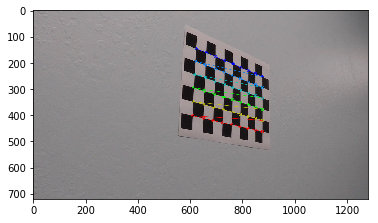

In [2]:
# camera calibration

# read in camera calibration images
cam_cal_imgs = glob.glob('./camera_cal/calibration*.jpg')

# prepare object points
nx = 9 # Chessboard size is 9x6
ny = 6 # Chessboard size is 9x6

obj_points = [] # object points
img_points = [] # image points

# prepare object points
objp = np.zeros((ny*nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for fname in cam_cal_imgs:

    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # append detected corners to the image points
        img_points.append(corners)
        obj_points.append(objp)
    
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
        print('Successfully loaded {}'.format(fname))
    else:
        print('Could not find corners. Image name is {}'.format(fname))

        #cv2.destroyAllWindows()

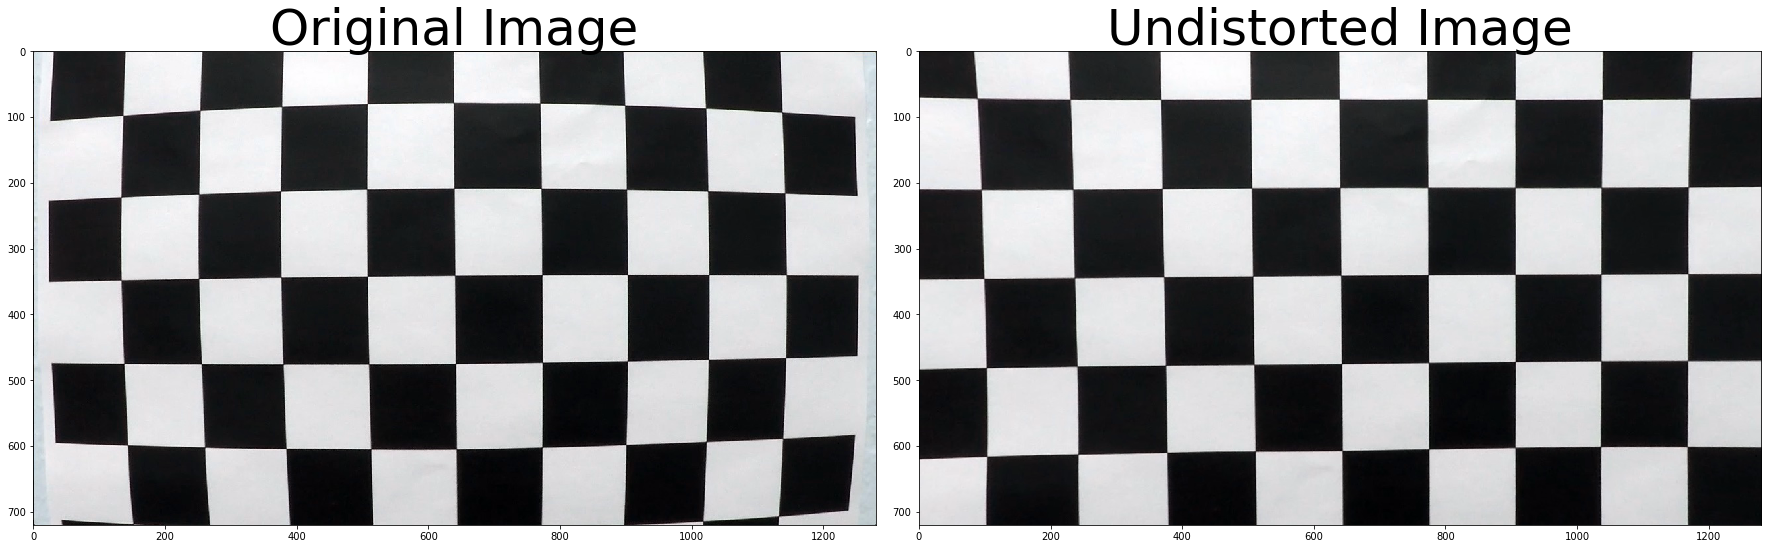

In [3]:
# use the first image as test image
img = cv2.imread(cam_cal_imgs[0])
shape = img.shape[0:2]

# perform camera calibration
# return value, camera calibration matrix, distortion coefficients, rotation and translation vectors
ret, cam_mat, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, shape, None, None)

# undistort image
undistorted = cv2.undistort(img, cam_mat, dist_coeff)

# plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

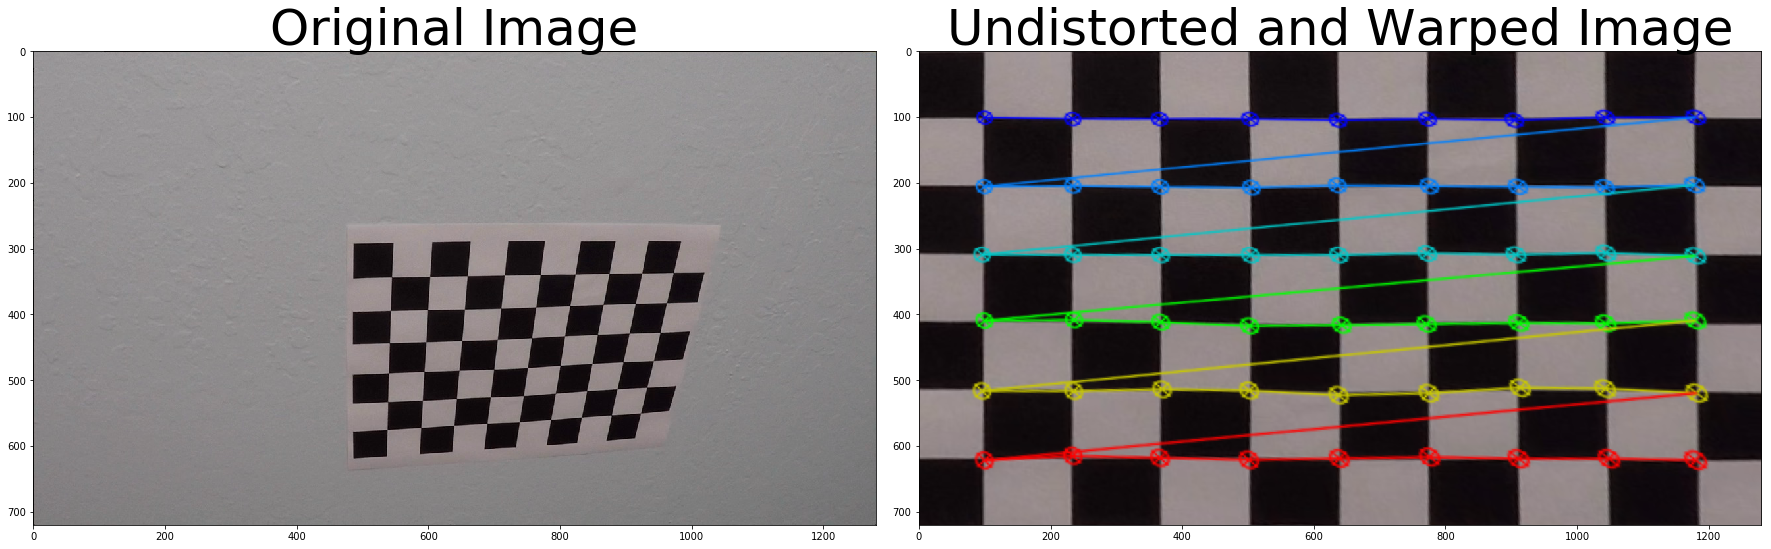

In [4]:
# unwarp images
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny))
    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    if(ret):
        img_size = (gray.shape[::-1])
        offset = 100
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # dst = np.float32([[100, 100],[1100, 100],[1100, 900],[100, 900]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    else:
        M = None
        warped = np.copy(img) 
        print('Cannot unwarp image, returning the same image!')
    return warped, M

img = cv2.imread(cam_cal_imgs[1]) # choose a test image


top_down, perspective_M = corners_unwarp(img, nx, ny, cam_mat, dist_coeff)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color and Gradient Threshold


In [5]:
# function definition

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if(orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif(orient == 'y'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    # 6) Return this mask as your binary_output image
    mag_binary[(scaled_sobel>=mag_thresh[0])&(scaled_sobel<=mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobel = np.sqrt(sobelx**2 + sobely **2)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(direction)
    
    # 6) Return this mask as your binary_output image
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return dir_binary

In [6]:

def combine_gradient_threshold(image):
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 63))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(128, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.75, 1.25))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined[((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

def color_gradient_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

# Read in an image
image = mpimg.imread('../Lesson16AdvancedLaneFinding/signs_vehicles_xygrad.png')

combined = color_gradient_threshold(image)
mag_binary = mag_thresh(image, sobel_kernel=5, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=5, thresh=(0.75, 1.25))  

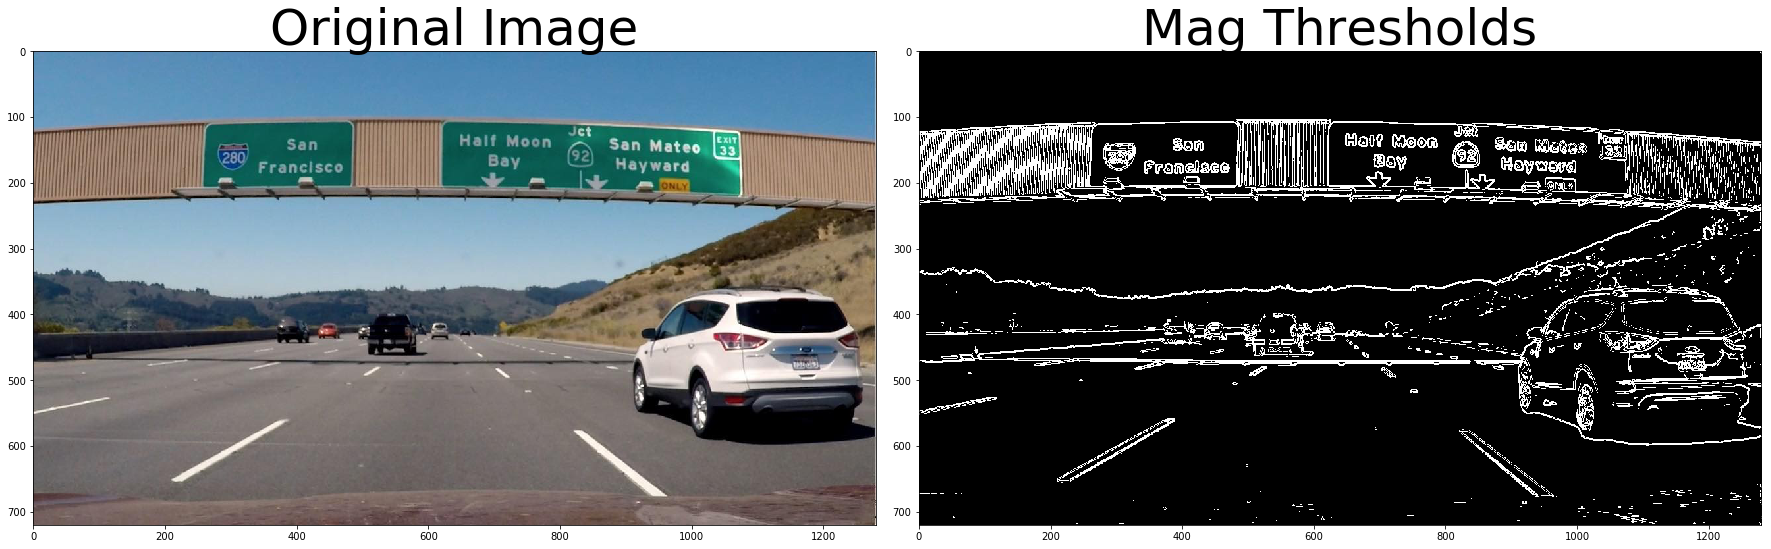

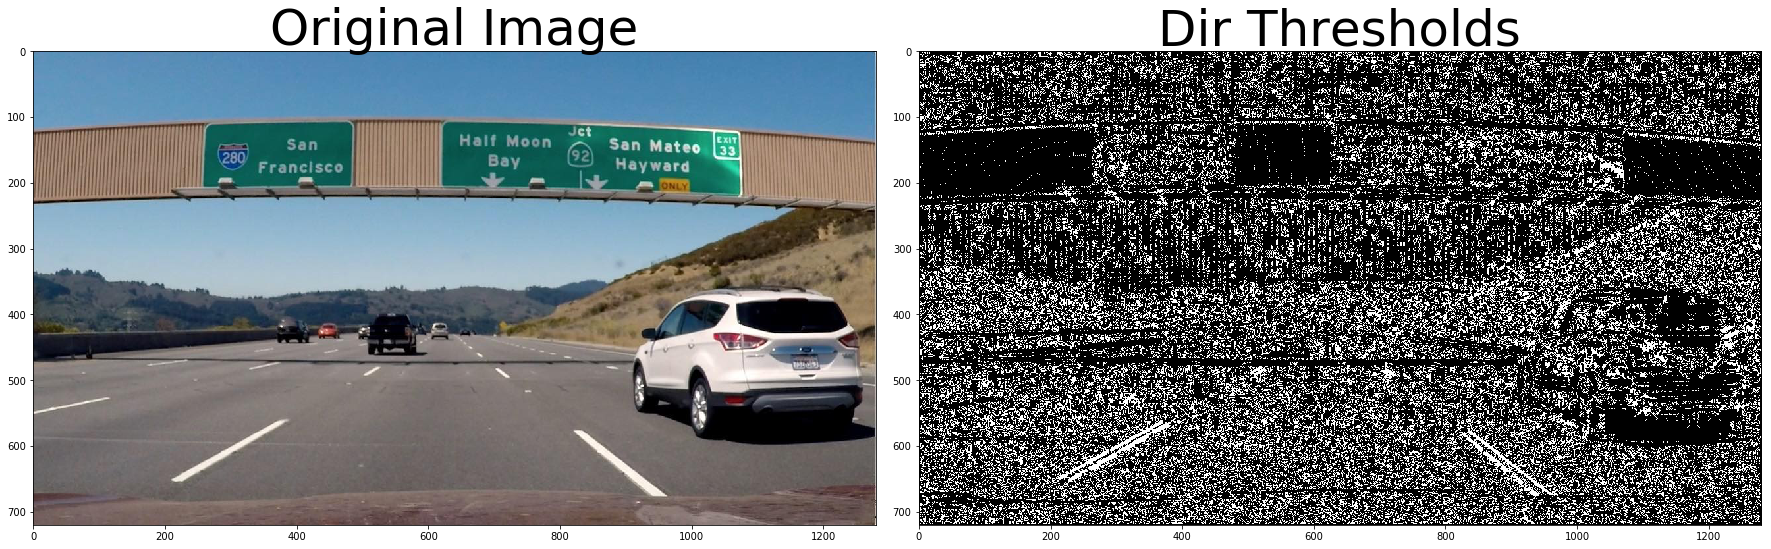

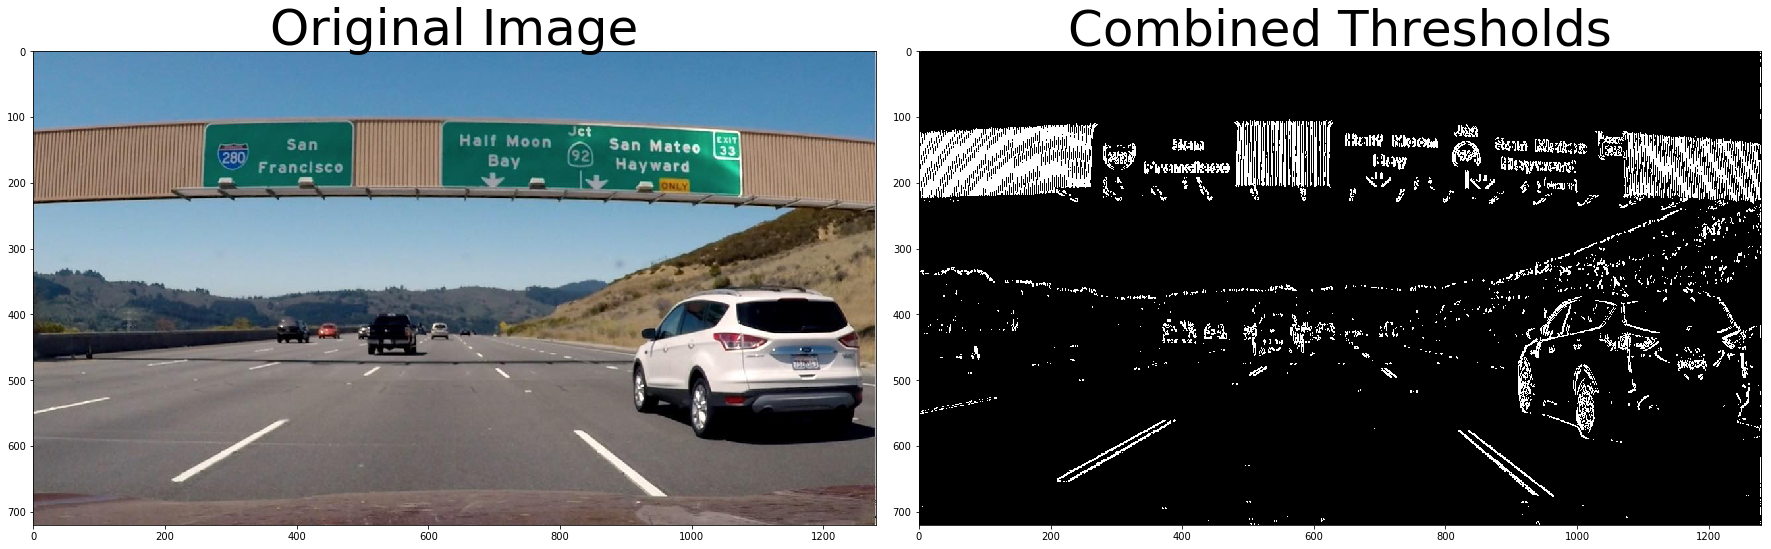

In [7]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Mag Thresholds', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Dir Thresholds', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Thresholds', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig(save_path + 'color_grad_combined_thresh.png')

## Perspective Transform
warp the images using perspective transform

In [15]:
# perspective transform
perspective_test_img = ['./test_images/straight_lines1.jpg', './test_images/straight_lines2.jpg']
img = cv2.imread(perspective_test_img[0])

img_size = [img.shape[1], img.shape[0]]

src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])


# hard coded src points
#src = np.array([[595, 450], [210, 720], [1115, 720], [685, 450]], dtype = 'int32')

# hard codede destination points
#dst = np.array([[320, 0], [320, 720], [960, 720], [960, 0]], dtype = 'int32')

# perspective transform matrix
M = cv2.getPerspectiveTransform((src), (dst))
Minv = cv2.getPerspectiveTransform((dst), (src))

In [17]:
print(src)
print(dst)

[[  585.           460.        ]
 [  203.33332825   720.        ]
 [ 1126.66662598   720.        ]
 [  695.           460.        ]]
[[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


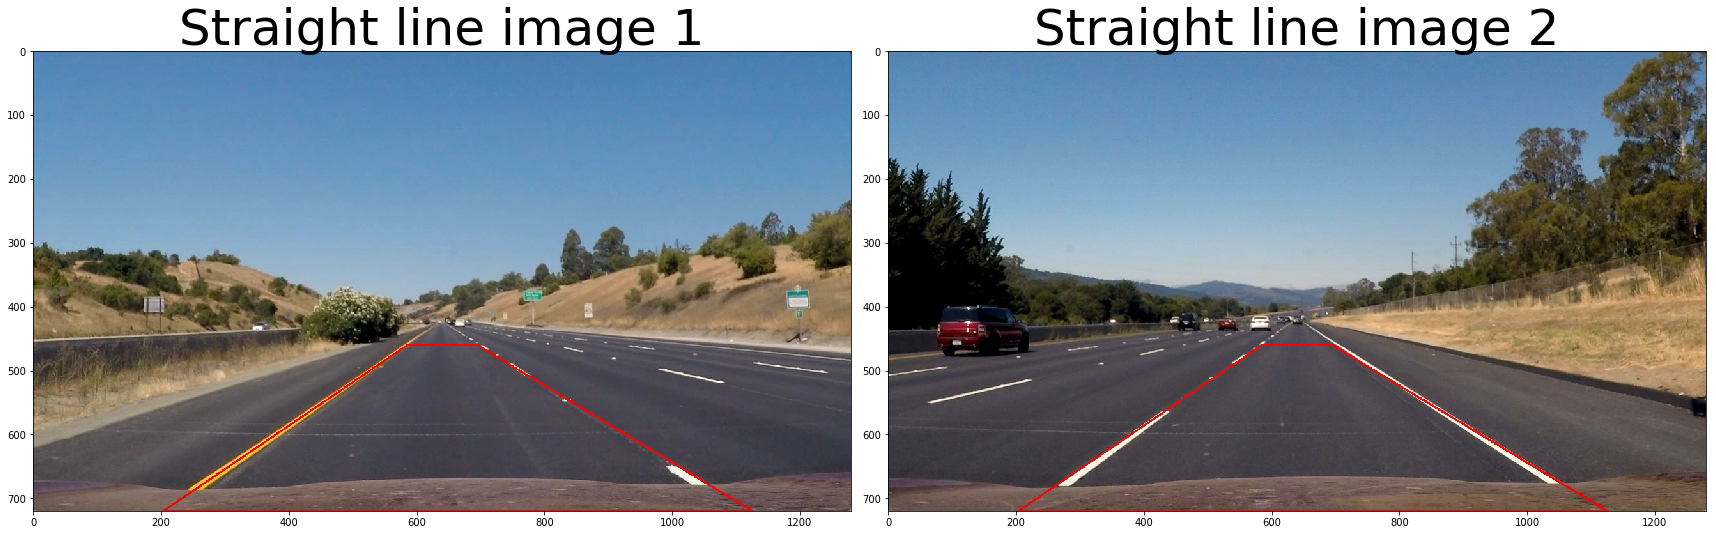

In [18]:
# visualize the polygon on two straight line images
img = cv2.imread(perspective_test_img[0])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
cv2.polylines(img, [np.int32(src)], True,(0,0,255), 2)
ax1.imshow((cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
ax1.set_title('Straight line image 1', fontsize=50)

img = cv2.imread(perspective_test_img[1])
f.tight_layout()
cv2.polylines(img, [np.int32(src)], True,(0,0,255), 2)
ax2.imshow((cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
ax2.set_title('Straight line image 2', fontsize=50)

plt.savefig(save_path + 'perspective_src_pnts.png')

In [19]:
# unwarp images

img = cv2.imread(perspective_test_img[0])
undist = cv2.undistort(img, cam_mat, dist_coeff)
img_size = (undist.shape[1], undist.shape[0])
top_down = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)


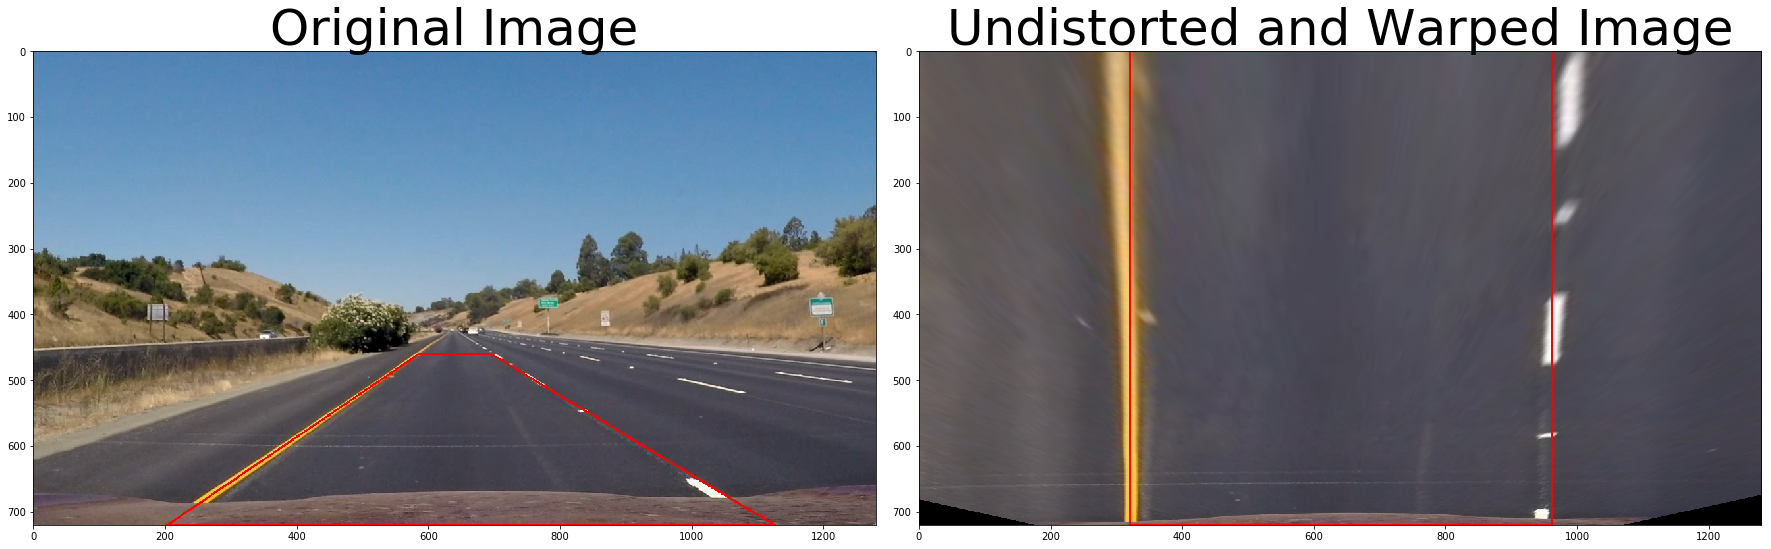

In [20]:
# plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
cv2.polylines(img, [np.int32(src)], True,(0,0,255), 2)
ax1.imshow((cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
ax1.set_title('Original Image', fontsize=50)

cv2.polylines(top_down, [np.int32(dst)], True,(0,0,255), 2)
ax2.imshow((cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB)))
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig(save_path + 'perspective_transform_example')

## Finding the Lanes

In [21]:
## here are the steps

## 1. undistort image
# undistorted = cv2.undistort(img, cam_mat, dist_coeff)

## 2. color and gradient thresholding 
# combined = color_gradient_threshold(image)
# mag_binary = mag_thresh(image, sobel_kernel=5, mag_thresh=(30, 100))
# dir_binary = dir_threshold(image, sobel_kernel=5, thresh=(0.75, 1.25))  

## 3. unwarp the images
# top_down = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

def unwarp_image(img, cam_mat, dist_coeff, M):
    undistorted = cv2.undistort(img, cam_mat, dist_coeff)
    combined = color_gradient_threshold(undistorted)
    img_size = (img.shape[1], img.shape[0])
    top_down = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
    return top_down

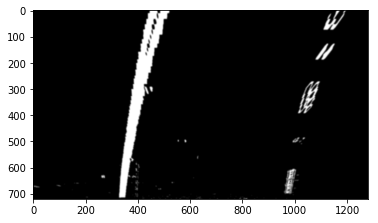

In [22]:

img = cv2.imread('./test_images/test3.jpg')
binary_warped = unwarp_image(img, cam_mat, dist_coeff, M)
plt.imshow(binary_warped, cmap = 'gray', interpolation = 'bicubic')

/Users/xingchihe/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


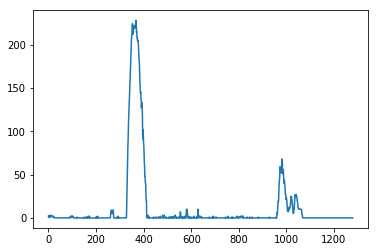

In [23]:
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [24]:
def sliding_window_test(binary_warped):
    overlay = True

    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if(overlay):
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
      
    if(overlay):
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
    return out_img, leftx, lefty, rightx, righty

/Users/xingchihe/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


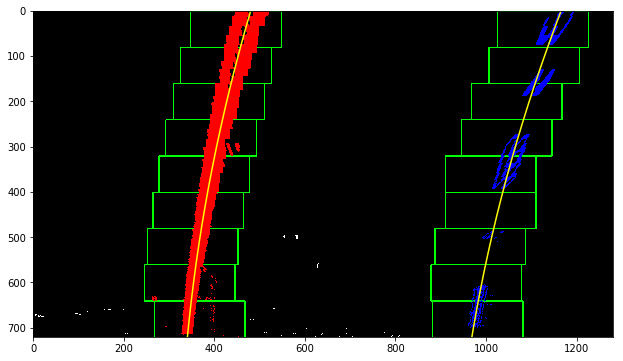

In [25]:
# visualization

out_img, leftx, lefty, rightx, righty = sliding_window_test(binary_warped)

    
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
    
    
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#out_img[lefty, leftx] = [255, 0, 0]
#out_img[righty, rightx] = [0, 0, 255]

plt.figure(figsize=(16,6))
plt.imshow(np.uint8(out_img), vmin = 0, vmax=255)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig(save_path + 'sliding_window.png')

## Skip the sliding windows step once you know where the lines are

In [26]:


# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]



(720, 0)

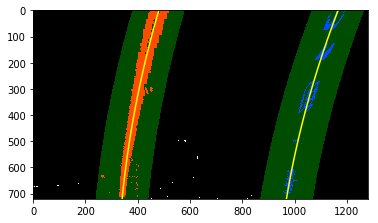

In [27]:
## visualize the result here as well
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(np.uint8(result))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Sliding Window Search - using convolution

In [28]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

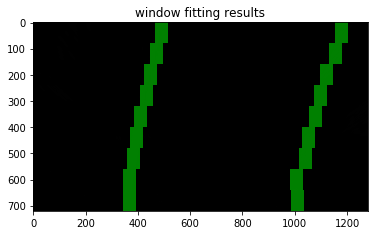

In [29]:
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

img = cv2.imread('./test_images/test6.jpg')
warped = unwarp_image(img, cam_mat, dist_coeff, M)

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows    
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(np.uint8(output))
plt.title('window fitting results')
plt.show()

[(369.0, 1011.0),
 (368.0, 1006.0),
 (384.0, 1040.0),
 (397.0, 1052.0),
 (412.0, 1079.0),
 (433.0, 1099.0),
 (449.0, 1121.0),
 (471.0, 1157.0),
 (491.0, 1179.0)]

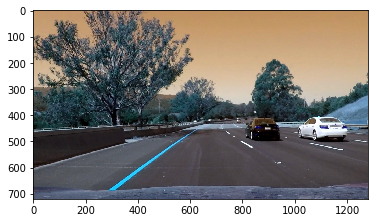

In [30]:
plt.imshow((img))
img.max()
window_centroids

## Measuring Curvature

In [202]:
def calc_curvature_meter(leftx, rightx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
  
    return left_curverad, right_curverad

  

In [285]:
def draw_lane(warped, undist, left_fitx, right_fitx, ploty, mode = 1):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    if mode == 1:
        result = undist
    else:        
        result = np.dstack((warped*255, warped*255, warped*255))
            
    if((left_fitx is not None) and (right_fitx is not None)):
        if((left_fitx.size == ploty.size) and (right_fitx.size==ploty.size)):
            # Recast the x and y points into usable format for cv2.fillPoly()
            pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
            pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
            pts = np.hstack((pts_left, pts_right))

            cv2.polylines(color_warp, np.int_(pts_left.reshape((-1,1,2))), True, (255, 0, 0), thickness = 50 )
            cv2.polylines(color_warp, np.int_(pts_right.reshape((-1,1,2))), True, (0, 0, 255), thickness = 50 )

            # Draw the lane onto the warped blank image
            cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

            # Warp the blank back to original image space using inverse perspective matrix (Minv)
            newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
            # Combine the result with the original image
            if mode == 1:
                result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
            else:
                result = cv2.addWeighted(np.dstack((warped*255, warped*255, warped*255)), 0.5, color_warp, 0.3, 0)

    return result

In [286]:
def sliding_window(binary_warped):
 
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    return leftx, lefty, rightx, righty


def increment_window(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty

In [287]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None
        
        self.recent_fit = []
        
        self.cnt = 0
        
class CenterLine():
    def __init__(self):
    
        self.best_pos = None     
        self.best_curv = None  
        
        self.recent_pos = []
        self.recent_curv = []



In [288]:
lane_l = Line()
lane_r = Line()
center = CenterLine()

In [289]:
def polynomial_fit(x, y):
     # Fit a second order polynomial to each
    fit  = np.polyfit(y, x, 2)  
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    return fit, fitx

def calc_curv(x, y):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
   
    y_eval = np.max(y)
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curvature = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curvature
    
def process_lane(lane, x, y, ploty, img_center, n):
    max_curv_diff = 50
    curvature_min = 175
    curvature_max = 1400
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    fit, fitx  = polynomial_fit(x, y)  
    curvature = calc_curv(fitx, ploty)
      
    print('curvature : {}'.format(curvature))
    
    if(x is not None):  #(curvature < curvature_max)):
            
        lane.cnt = 0 
        lane.detected = True
        lane.curvature = curvature
        print('curvature updated : {}'.format(curvature))
        
        #distance in meters of vehicle center from the line
        lane.line_base_pos = (img_center - fitx[-1]) * xm_per_pix
        
        if lane.bestx is None:
            lane.bestx = np.mean(lane.recent_xfitted, axis=0)
            
        if(len(lane.recent_fit) >= n):
            # x values of the last n fits of the line
            lane.recent_xfitted.pop(0)

            # recent polynomial fit
            lane.recent_fit.pop(0)     
        
        # x values of the last n fits of the line
        lane.recent_xfitted.append(fitx)
        
        # last n fits of the line
        lane.recent_fit.append(fit)
        
        #average x values of the fitted line over the last n iterations
        lane.bestx = np.mean(lane.recent_xfitted, axis=0) 
        
        #polynomial coefficients averaged over the last n iterations
        lane.best_fit = np.mean(lane.recent_fit, axis=0)   
    
        #difference in fit coefficients between last and new fits
        lane.diffs = lane.current_fit - fit
        
        #x values for detected line pixels
        lane.allx = x  
        #y values for detected line pixels
        lane.ally = y
        
        # Copy the polynomial fit
        lane.current_fit = fit
        
    else:
        print('curvature failed cnt: {}'.format(lane.cnt))
        
        lane.cnt = lane.cnt + 1
        
        
        if(len(lane.recent_xfitted)>2):
            # x values of the last n fits of the line
            lane.recent_xfitted.pop(0)
        
            # last n fits of the line
            lane.recent_fit.pop(0)
            
            #average x values of the fitted line over the last n iterations
            lane.bestx = np.mean(lane.recent_xfitted, axis=0) 
        
            #polynomial coefficients averaged over the last n iterations
            lane.best_fit = np.mean(lane.recent_fit, axis=0)   
    
        if lane.cnt >= n:
            lane.detected = False
            
    return lane

In [290]:
def process_image(img):
    global lane_l 
    global lane_r
    global center
    
    # parameters
    n = 10 # avaerage over the past n frames
    img_center = img.shape[1]/2
  
    # parameters are cam_mat, dist_coeff, and M
    # undistort image
    undistorted = cv2.undistort(img, cam_mat, dist_coeff)
    # color and gradient thresholding
    combined = color_gradient_threshold(undistorted)
    img_size = (img.shape[1], img.shape[0])
    
    # perspective transform
    binary_warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)

    if(lane_l.detected and lane_r.detected):
        leftx, lefty, rightx, righty = increment_window(binary_warped, lane_l.best_fit, lane_r.best_fit)
        #leftx, lefty, rightx, righty = sliding_window(binary_warped)
    else:
        leftx, lefty, rightx, righty = sliding_window(binary_warped)
        
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        
    lane_l = process_lane(lane_l, leftx,  lefty,  ploty, img_center, n)
    lane_r = process_lane(lane_r, rightx, righty, ploty, img_center, n)
    
    if(lane_l.line_base_pos is not None):  
        if(lane_l.line_base_pos <  50*3.7/700):
            lane_l.detected = False
    
    if(lane_r.line_base_pos is not None):  
        if(lane_r.line_base_pos > -50*3.7/700):
            lane_r.detected = False
        
    if(lane_l.detected and lane_r.detected):
        if((lane_l.curvature is not None) and (lane_r.curvature is not None)):
            if(len(center.recent_curv)>=n):
                center.recent_curv.pop(0)
            center.recent_curv.append(np.mean([lane_l.curvature, lane_r.curvature]))
            center.best_curv = np.mean(center.recent_curv, axis = 0)


        if((lane_l.line_base_pos is not None) and (lane_r.line_base_pos is not None)):
            if(len(center.recent_pos)>=n):
                center.recent_pos.pop(0)
            center.recent_pos.append(np.mean([lane_l.line_base_pos, lane_r.line_base_pos]))
            center.best_pos = np.mean(center.recent_pos, axis = 0)

    out_img = draw_lane(binary_warped, undistorted, lane_l.bestx, lane_r.bestx, ploty, 1)
    
    text_curv = 'Radius of Curvature is ' + '{0:.3f}'.format(center.best_curv) + ' (m)'
    text_pos  = 'Vehicle is ' + '{0:.3f}'.format(center.best_pos)  + ' m from the center'

    cv2.putText(out_img,  text_curv, (75, 75) , cv2.FONT_HERSHEY_SIMPLEX, 1.5, [255, 255, 255])
    cv2.putText(out_img,  text_pos,  (75, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, [255, 255, 255])
    
    return out_img

In [291]:

lefty

array([640, 640, 640, ..., 239, 239, 239])

In [292]:
lane_l.recent_xfitted

[]

curvature : 89.73587524678008
curvature updated : 89.73587524678008
curvature : 267.2647658026755
curvature updated : 267.2647658026755


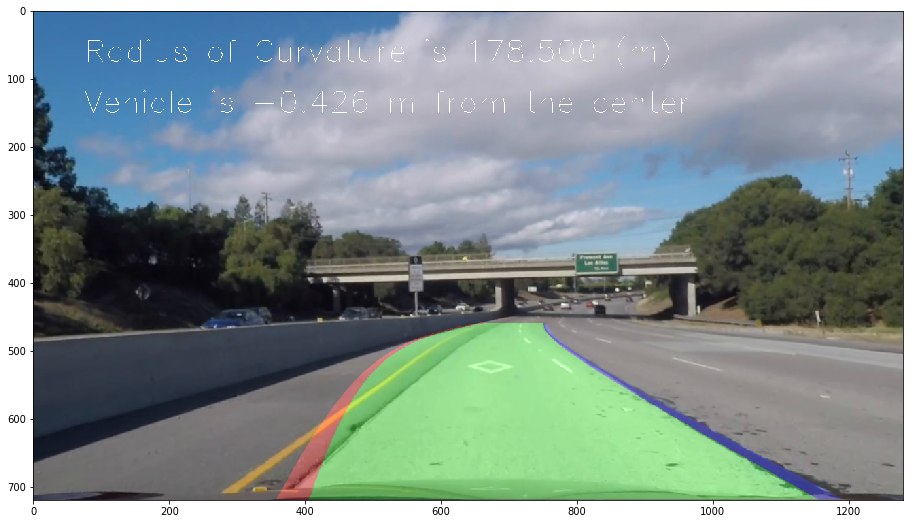

In [293]:
lane_l = Line()
lane_r = Line()
center = CenterLine()
test_results = process_image(frames[30,:,:,:])
plt.figure(figsize=(24,9))
plt.imshow(np.uint8(test_results))
#print('radius of curvature left {} and right {}' .format(lane_l.radius_of_curvature, lane_r.radius_of_curvature))

curvature : 64.6673453275457
curvature updated : 64.6673453275457
curvature : 55.9897710557389
curvature updated : 55.9897710557389


4

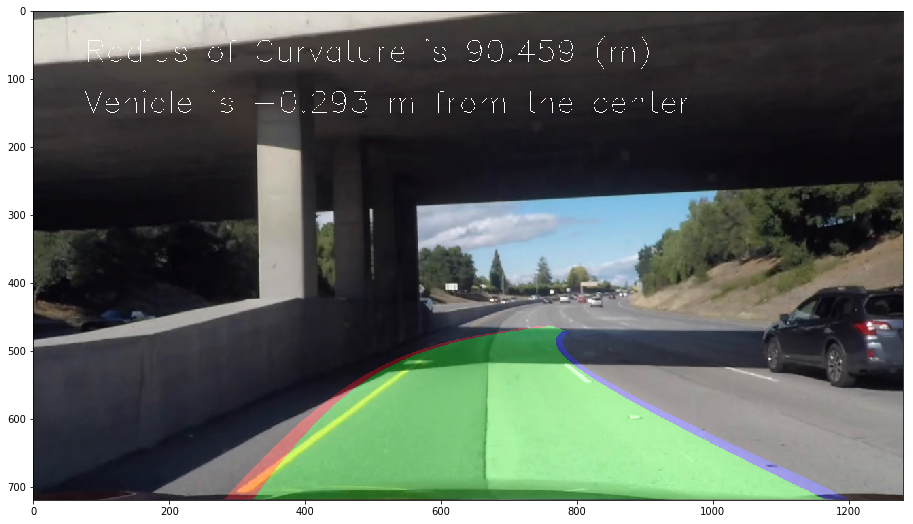

In [296]:
test_results = process_image(frames[101,:,:,:])
plt.figure(figsize=(24,9))
plt.imshow(np.uint8(test_results))
len(lane_l.recent_fit)

curvature : 754.8748622667099
curvature updated : 754.8748622667099
curvature : 479.8885483954749
curvature updated : 479.8885483954749
curvature : 2214.963997776719
curvature updated : 2214.963997776719
curvature : 1012.2339373708485
curvature updated : 1012.2339373708485
curvature : 167525.78806109118
curvature updated : 167525.78806109118
curvature : 6403.397443126469
curvature updated : 6403.397443126469
curvature : 3948.5579277208913
curvature updated : 3948.5579277208913
curvature : 3409.0291926176546
curvature updated : 3409.0291926176546
curvature : 4030.653067034795
curvature updated : 4030.653067034795
curvature : 1697.0084744204123
curvature updated : 1697.0084744204123
curvature : 22450.804559602828
curvature updated : 22450.804559602828
curvature : 6671.813546885276
curvature updated : 6671.813546885276
curvature : 667.3132505240507
curvature updated : 667.3132505240507
curvature : 729.7532136317916
curvature updated : 729.7532136317916
curvature : 3261.614035967219
curvat

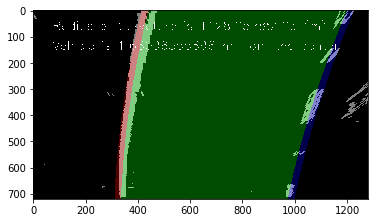

In [166]:
for k in range(250,1000,50):
    test_results = process_image(frames[k,:,:,:])
    plt.imshow(np.uint8(test_results))
    plt.savefig(str(k) + '.png')
#plt.imshow(np.uint8(test_results))
print('radius of curvature left {} and right {}' .format(lane_l.radius_of_curvature, lane_r.radius_of_curvature))

In [71]:
center.recent_curv

[]

In [272]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import time
clip1 = VideoFileClip("challenge_video.mp4")
k = -1
t = 0
frame = []

while t < clip1.duration:
    k = k + 1
    frame.append(clip1.get_frame(t)) # gets the picture at time ``t``
    #imdisplay( picture )        # display the picture
    t = t + 1.0/25              # increment time
    #time.sleep( 1.0/25 ) 

In [273]:

frames = np.array(frame)

In [265]:
if(True):
    lane_l = Line()
    lane_r = Line()
    center = CenterLine()
    project_video_output = 'project_video_output.mp4'
    clip1 = VideoFileClip("project_video.mp4")
    project_video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time project_video_clip.write_videofile(project_video_output, audio=False)

curvature : 643.1662795990025
curvature updated : 643.1662795990025
curvature : 963.0285298164935
curvature updated : 963.0285298164935
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



  0%|          | 0/1261 [00:00<?, ?it/s]

curvature : 637.035133366412
curvature updated : 637.035133366412
curvature : 942.6894614763556
curvature updated : 942.6894614763556



  0%|          | 1/1261 [00:00<03:58,  5.29it/s]

curvature : 670.3268915792748


  0%|          | 2/1261 [00:00<04:05,  5.14it/s]


curvature updated : 670.3268915792748
curvature : 1032.1830935684288
curvature updated : 1032.1830935684288
curvature : 648.1950045114129
curvature updated : 648.1950045114129
curvature : 708.0147612498774
curvature updated : 708.0147612498774



  0%|          | 5/1261 [00:00<03:36,  5.81it/s]

curvature : 663.930297800016
curvature updated : 663.930297800016
curvature : 653.2065087826564
curvature updated : 653.2065087826564
curvature : 652.1966176505445
curvature updated : 652.1966176505445
curvature : 704.2505590616956
curvature updated : 704.2505590616956



  1%|          | 7/1261 [00:01<03:27,  6.04it/s]

curvature : 688.9281742733665
curvature updated : 688.9281742733665
curvature : 990.6592303915318
curvature updated : 990.6592303915318
curvature : 673.0762157373794
curvature updated : 673.0762157373794
curvature : 1097.1191190976688
curvature updated : 1097.1191190976688



  1%|          | 8/1261 [00:01<03:30,  5.96it/s]

curvature : 656.837221174195
curvature updated : 656.837221174195
curvature : 2921.5593968846892
curvature updated : 2921.5593968846892
curvature : 706.617910640092
curvature updated : 706.617910640092
curvature : 1360.8976114171298
curvature updated : 1360.8976114171298



  1%|          | 10/1261 [00:01<03:28,  6.01it/s]

curvature : 735.0318600088805
curvature updated : 735.0318600088805
curvature : 2237.647495773316
curvature updated : 2237.647495773316
curvature : 762.4107549940716
curvature updated : 762.4107549940716
curvature : 1663.8036352956658
curvature updated : 1663.8036352956658



  1%|          | 12/1261 [00:02<03:29,  5.96it/s]

curvature : 826.5051010554004
curvature updated : 826.5051010554004
curvature : 2534.9333793755513
curvature updated : 2534.9333793755513
curvature : 841.7540083489686
curvature updated : 841.7540083489686
curvature : 1713.6155842020983
curvature updated : 1713.6155842020983



  1%|          | 15/1261 [00:02<03:25,  6.06it/s]

curvature : 892.4454547215034
curvature updated : 892.4454547215034
curvature : 3551.537616990088
curvature updated : 3551.537616990088
curvature : 972.551535738976
curvature updated : 972.551535738976
curvature : 1175.3954362086527
curvature updated : 1175.3954362086527



  1%|▏         | 16/1261 [00:02<03:23,  6.13it/s]

curvature : 1260.8812414259826
curvature updated : 1260.8812414259826
curvature : 1162.0361734711444
curvature updated : 1162.0361734711444
curvature : 994.7225687575736
curvature updated : 994.7225687575736
curvature : 1566.8638725214523
curvature updated : 1566.8638725214523



  2%|▏         | 19/1261 [00:03<03:21,  6.16it/s]

curvature : 1092.003688318462
curvature updated : 1092.003688318462
curvature : 1618.0929301738443
curvature updated : 1618.0929301738443
curvature : 1123.242389570886
curvature updated : 1123.242389570886
curvature : 1634.958727045542
curvature updated : 1634.958727045542



  2%|▏         | 21/1261 [00:03<03:17,  6.26it/s]

curvature : 1167.7068602613817
curvature updated : 1167.7068602613817
curvature : 1841.242873401971
curvature updated : 1841.242873401971
curvature : 1181.1358483721258
curvature updated : 1181.1358483721258
curvature : 7168.057171808142
curvature updated : 7168.057171808142



  2%|▏         | 23/1261 [00:03<03:17,  6.27it/s]

curvature : 1269.03430251402
curvature updated : 1269.03430251402
curvature : 6585.489795076765
curvature updated : 6585.489795076765
curvature : 1201.447951048326
curvature updated : 1201.447951048326
curvature : 8487.022705581541
curvature updated : 8487.022705581541



  2%|▏         | 24/1261 [00:04<03:43,  5.54it/s]

curvature : 1119.3706647251256
curvature updated : 1119.3706647251256
curvature : 1050.2623242922903
curvature updated : 1050.2623242922903
curvature : 955.0289178454016
curvature updated : 955.0289178454016
curvature : 871.5168877313938
curvature updated : 871.5168877313938



  2%|▏         | 27/1261 [00:04<03:20,  6.15it/s]

curvature : 1032.3861897852394
curvature updated : 1032.3861897852394
curvature : 1062.258454084717
curvature updated : 1062.258454084717
curvature : 948.8809369773203
curvature updated : 948.8809369773203
curvature : 1253.5584407839874
curvature updated : 1253.5584407839874



  2%|▏         | 29/1261 [00:04<03:18,  6.22it/s]

curvature : 997.8483986361306
curvature updated : 997.8483986361306
curvature : 1271.445061818497
curvature updated : 1271.445061818497
curvature : 1054.2779740307926
curvature updated : 1054.2779740307926
curvature : 857.4411245933256
curvature updated : 857.4411245933256



  2%|▏         | 31/1261 [00:05<03:15,  6.28it/s]

curvature : 915.5163387524836
curvature updated : 915.5163387524836
curvature : 575.8253536703252
curvature updated : 575.8253536703252
curvature : 723.7882700715495
curvature updated : 723.7882700715495
curvature : 728.3352007368732
curvature updated : 728.3352007368732



  3%|▎         | 33/1261 [00:05<03:12,  6.39it/s]

curvature : 667.7621930928659
curvature updated : 667.7621930928659
curvature : 1000.399022292938
curvature updated : 1000.399022292938
curvature : 676.158933717155
curvature updated : 676.158933717155
curvature : 2165.5533083755954
curvature updated : 2165.5533083755954



  3%|▎         | 35/1261 [00:05<03:12,  6.36it/s]

curvature : 627.7977747236724
curvature updated : 627.7977747236724
curvature : 4522.322966937118
curvature updated : 4522.322966937118
curvature : 606.3648689393378
curvature updated : 606.3648689393378
curvature : 4664.783453151097
curvature updated : 4664.783453151097



  3%|▎         | 37/1261 [00:06<03:11,  6.39it/s]

curvature : 599.7397553805689
curvature updated : 599.7397553805689
curvature : 1017.4177879590671
curvature updated : 1017.4177879590671
curvature : 577.0024898145676
curvature updated : 577.0024898145676
curvature : 966.8109522302523
curvature updated : 966.8109522302523



  3%|▎         | 39/1261 [00:06<03:12,  6.34it/s]

curvature : 547.190211749493
curvature updated : 547.190211749493
curvature : 1825.2978600749377
curvature updated : 1825.2978600749377
curvature : 528.322886652058
curvature updated : 528.322886652058
curvature : 1069.4881573873943
curvature updated : 1069.4881573873943



  3%|▎         | 41/1261 [00:06<03:12,  6.32it/s]

curvature : 532.5129942589451
curvature updated : 532.5129942589451
curvature : 653.8505103489856
curvature updated : 653.8505103489856
curvature : 519.3505659487372
curvature updated : 519.3505659487372
curvature : 706.7149507462681
curvature updated : 706.7149507462681



  3%|▎         | 43/1261 [00:07<03:15,  6.23it/s]

curvature : 535.5103517640849
curvature updated : 535.5103517640849
curvature : 647.9174746512452
curvature updated : 647.9174746512452
curvature : 503.2644410167768
curvature updated : 503.2644410167768
curvature : 638.68572137934
curvature updated : 638.68572137934



  4%|▎         | 45/1261 [00:07<03:18,  6.12it/s]

curvature : 550.7673677333493
curvature updated : 550.7673677333493
curvature : 664.0071353740298
curvature updated : 664.0071353740298
curvature : 610.3070093206829
curvature updated : 610.3070093206829
curvature : 873.9516908924353
curvature updated : 873.9516908924353



  4%|▎         | 47/1261 [00:07<03:20,  6.06it/s]

curvature : 616.7997481411518
curvature updated : 616.7997481411518
curvature : 2091.430905976777
curvature updated : 2091.430905976777
curvature : 641.4035851122925
curvature updated : 641.4035851122925
curvature : 3567.930219448553
curvature updated : 3567.930219448553



  4%|▍         | 48/1261 [00:07<03:31,  5.74it/s]

curvature : 670.1856881437819
curvature updated : 670.1856881437819
curvature : 2395.2445955080066
curvature updated : 2395.2445955080066



  4%|▍         | 49/1261 [00:08<03:39,  5.53it/s]

curvature : 691.4957396180173
curvature updated : 691.4957396180173
curvature : 995.5688077469594
curvature updated : 995.5688077469594
curvature : 738.8949968982052
curvature updated : 738.8949968982052
curvature : 752.6893560160482
curvature updated : 752.6893560160482



  4%|▍         | 51/1261 [00:08<03:48,  5.30it/s]

curvature : 800.9824257794395
curvature updated : 800.9824257794395
curvature : 1063.155745844407
curvature updated : 1063.155745844407



  4%|▍         | 52/1261 [00:08<03:51,  5.23it/s]

curvature : 842.5201111308226
curvature updated : 842.5201111308226
curvature : 1064.0291337235915
curvature updated : 1064.0291337235915
curvature : 894.0380318376695
curvature updated : 894.0380318376695
curvature : 633.0904906431343
curvature updated : 633.0904906431343



  4%|▍         | 54/1261 [00:09<04:02,  4.97it/s]

curvature : 925.2306918932943
curvature updated : 925.2306918932943
curvature : 666.799801042573
curvature updated : 666.799801042573



  4%|▍         | 55/1261 [00:09<04:19,  4.65it/s]

curvature : 962.0403396631227
curvature updated : 962.0403396631227
curvature : 667.8530284824973
curvature updated : 667.8530284824973
curvature : 1067.9238676105947
curvature updated : 1067.9238676105947
curvature : 684.8912027721562
curvature updated : 684.8912027721562



  5%|▍         | 57/1261 [00:09<03:49,  5.26it/s]

curvature : 1169.4318429391485
curvature updated : 1169.4318429391485
curvature : 873.5060350370583
curvature updated : 873.5060350370583
curvature : 1110.2490313396465
curvature updated : 1110.2490313396465
curvature : 1496.363256848848
curvature updated : 1496.363256848848



  5%|▍         | 59/1261 [00:10<03:36,  5.55it/s]

curvature : 1004.2911768801716
curvature updated : 1004.2911768801716
curvature : 3491.450620479966
curvature updated : 3491.450620479966
curvature : 969.7029151111609
curvature updated : 969.7029151111609
curvature : 958.3573182187766
curvature updated : 958.3573182187766



  5%|▍         | 62/1261 [00:10<03:24,  5.87it/s]

curvature : 890.6959929140954
curvature updated : 890.6959929140954
curvature : 1629.911400133677
curvature updated : 1629.911400133677
curvature : 830.9340282640451
curvature updated : 830.9340282640451
curvature : 1042.8058739947382
curvature updated : 1042.8058739947382



  5%|▍         | 63/1261 [00:10<03:17,  6.05it/s]

curvature : 794.9936144956449
curvature updated : 794.9936144956449
curvature : 1406.1080863217333
curvature updated : 1406.1080863217333
curvature : 764.9506680568456
curvature updated : 764.9506680568456
curvature : 794.7563185605571
curvature updated : 794.7563185605571



  5%|▌         | 65/1261 [00:11<03:32,  5.62it/s]

curvature : 807.6970051281509
curvature updated : 807.6970051281509
curvature : 640.3505784776438
curvature updated : 640.3505784776438



  5%|▌         | 66/1261 [00:11<03:44,  5.33it/s]

curvature : 764.2645124840482
curvature updated : 764.2645124840482
curvature : 857.2434571344808
curvature updated : 857.2434571344808



  5%|▌         | 67/1261 [00:11<03:59,  5.00it/s]

curvature : 773.7647981998509
curvature updated : 773.7647981998509
curvature : 934.0481305647223
curvature updated : 934.0481305647223



  5%|▌         | 68/1261 [00:11<04:15,  4.66it/s]

curvature : 769.3280353224859
curvature updated : 769.3280353224859
curvature : 1090.1552001114596
curvature updated : 1090.1552001114596



  5%|▌         | 69/1261 [00:12<04:28,  4.45it/s]

curvature : 790.2909356180576
curvature updated : 790.2909356180576
curvature : 1692.4901323548638
curvature updated : 1692.4901323548638
curvature : 846.0194570198192
curvature updated : 846.0194570198192
curvature : 2194.620510551393
curvature updated : 2194.620510551393



  6%|▌         | 72/1261 [00:12<03:36,  5.49it/s]

curvature : 859.9509571077014
curvature updated : 859.9509571077014
curvature : 1282.206034143508
curvature updated : 1282.206034143508
curvature : 990.3840031912736
curvature updated : 990.3840031912736
curvature : 724.0161729665341
curvature updated : 724.0161729665341



  6%|▌         | 73/1261 [00:12<03:54,  5.06it/s]

curvature : 1132.272858811389
curvature updated : 1132.272858811389
curvature : 837.0459999816583
curvature updated : 837.0459999816583
curvature : 1325.933906478398
curvature updated : 1325.933906478398
curvature : 993.5068974808675
curvature updated : 993.5068974808675



  6%|▌         | 75/1261 [00:13<03:30,  5.64it/s]

curvature : 1318.0499396146115
curvature updated : 1318.0499396146115
curvature : 1171.2238277870597
curvature updated : 1171.2238277870597
curvature : 1445.3372270257055
curvature updated : 1445.3372270257055
curvature : 761.1346973250605
curvature updated : 761.1346973250605



  6%|▌         | 78/1261 [00:13<03:38,  5.41it/s]

curvature : 1819.08415812789
curvature updated : 1819.08415812789
curvature : 745.1628252491008
curvature updated : 745.1628252491008
curvature : 2075.5513754271433
curvature updated : 2075.5513754271433
curvature : 660.2410764716566
curvature updated : 660.2410764716566



  6%|▋         | 79/1261 [00:13<03:26,  5.72it/s]

curvature : 2220.3764764410657
curvature updated : 2220.3764764410657
curvature : 550.5783348455003
curvature updated : 550.5783348455003



  6%|▋         | 80/1261 [00:13<03:42,  5.30it/s]

curvature : 2287.488413059514
curvature updated : 2287.488413059514
curvature : 549.9398958815696
curvature updated : 549.9398958815696
curvature : 1988.3099014816778
curvature updated : 1988.3099014816778
curvature : 694.5413314572226
curvature updated : 694.5413314572226



  7%|▋         | 83/1261 [00:14<03:21,  5.83it/s]

curvature : 1956.3808805906447
curvature updated : 1956.3808805906447
curvature : 801.3353708356511
curvature updated : 801.3353708356511
curvature : 1748.1049161881604
curvature updated : 1748.1049161881604
curvature : 1161.4291567149933
curvature updated : 1161.4291567149933



  7%|▋         | 84/1261 [00:14<03:37,  5.40it/s]

curvature : 1590.76782324423
curvature updated : 1590.76782324423
curvature : 1181.508965725584
curvature updated : 1181.508965725584



  7%|▋         | 86/1261 [00:15<03:29,  5.60it/s]

curvature : 1429.608009420423
curvature updated : 1429.608009420423
curvature : 2834.9586108318586
curvature updated : 2834.9586108318586
curvature : 1383.3321060154337
curvature updated : 1383.3321060154337
curvature : 16027.715554623717
curvature updated : 16027.715554623717



  7%|▋         | 88/1261 [00:15<03:19,  5.87it/s]

curvature : 1053.768800560404
curvature updated : 1053.768800560404
curvature : 1061.1519263909531
curvature updated : 1061.1519263909531
curvature : 915.7586604338186
curvature updated : 915.7586604338186
curvature : 2601.1267278639916
curvature updated : 2601.1267278639916



  7%|▋         | 90/1261 [00:15<03:13,  6.06it/s]

curvature : 783.4598942278158
curvature updated : 783.4598942278158
curvature : 1256.0723120492596
curvature updated : 1256.0723120492596
curvature : 759.9596799791344
curvature updated : 759.9596799791344
curvature : 1056.6579208084343
curvature updated : 1056.6579208084343



  7%|▋         | 91/1261 [00:15<03:13,  6.05it/s]

curvature : 762.4968234597599
curvature updated : 762.4968234597599
curvature : 836.4566945200668
curvature updated : 836.4566945200668
curvature : 754.4740239698316
curvature updated : 754.4740239698316
curvature : 803.4094700818838
curvature updated : 803.4094700818838



  7%|▋         | 94/1261 [00:16<03:13,  6.02it/s]

curvature : 702.5346664739326
curvature updated : 702.5346664739326
curvature : 1003.428993450818
curvature updated : 1003.428993450818
curvature : 695.6529183585897
curvature updated : 695.6529183585897
curvature : 1040.7838678609392
curvature updated : 1040.7838678609392



  8%|▊         | 96/1261 [00:16<03:04,  6.31it/s]

curvature : 712.4614025548968
curvature updated : 712.4614025548968
curvature : 1352.1965561183465
curvature updated : 1352.1965561183465
curvature : 732.4691697224947
curvature updated : 732.4691697224947
curvature : 3039.9603516089273
curvature updated : 3039.9603516089273



  8%|▊         | 97/1261 [00:16<03:06,  6.25it/s]

curvature : 748.6106381352655
curvature updated : 748.6106381352655
curvature : 8621.80734949744
curvature updated : 8621.80734949744
curvature : 759.9612414172009
curvature updated : 759.9612414172009
curvature : 895.8373057208543
curvature updated : 895.8373057208543



  8%|▊         | 99/1261 [00:17<03:41,  5.25it/s]

curvature : 796.6723050845007
curvature updated : 796.6723050845007
curvature : 903.1009178252539
curvature updated : 903.1009178252539



  8%|▊         | 100/1261 [00:17<03:59,  4.85it/s]

curvature : 795.3850105441788
curvature updated : 795.3850105441788
curvature : 1115.6187284734167
curvature updated : 1115.6187284734167



  8%|▊         | 102/1261 [00:17<03:37,  5.32it/s]

curvature : 785.1362011120133
curvature updated : 785.1362011120133
curvature : 1086.872069280896
curvature updated : 1086.872069280896
curvature : 803.2242037108508
curvature updated : 803.2242037108508
curvature : 709.2470854591638
curvature updated : 709.2470854591638



  8%|▊         | 104/1261 [00:18<03:19,  5.80it/s]

curvature : 837.5972419925927
curvature updated : 837.5972419925927
curvature : 526.873302152009
curvature updated : 526.873302152009
curvature : 821.8850921106254
curvature updated : 821.8850921106254
curvature : 598.630351550303
curvature updated : 598.630351550303



  8%|▊         | 106/1261 [00:18<03:15,  5.91it/s]

curvature : 807.8505829534523
curvature updated : 807.8505829534523
curvature : 650.9610298040182
curvature updated : 650.9610298040182
curvature : 877.2689995295323
curvature updated : 877.2689995295323
curvature : 646.9335622190432
curvature updated : 646.9335622190432



  9%|▊         | 108/1261 [00:18<03:09,  6.07it/s]

curvature : 832.8686270154755
curvature updated : 832.8686270154755
curvature : 636.3554295244448
curvature updated : 636.3554295244448
curvature : 766.0551907106938
curvature updated : 766.0551907106938
curvature : 787.0948131989062
curvature updated : 787.0948131989062



  9%|▊         | 110/1261 [00:19<03:06,  6.17it/s]

curvature : 771.2915679310195
curvature updated : 771.2915679310195
curvature : 1478.2406674862025
curvature updated : 1478.2406674862025
curvature : 790.6393974366786
curvature updated : 790.6393974366786
curvature : 3355.0986764985287
curvature updated : 3355.0986764985287



  9%|▉         | 111/1261 [00:19<03:06,  6.17it/s]

curvature : 749.9444216327346
curvature updated : 749.9444216327346
curvature : 1786.6642290214668
curvature updated : 1786.6642290214668
curvature : 802.8207970795079
curvature updated : 802.8207970795079
curvature : 832.3805977391241
curvature updated : 832.3805977391241



  9%|▉         | 114/1261 [00:19<03:07,  6.13it/s]

curvature : 721.6411811397086
curvature updated : 721.6411811397086
curvature : 676.7003053969123
curvature updated : 676.7003053969123
curvature : 724.6622228964566
curvature updated : 724.6622228964566
curvature : 773.6951686797785
curvature updated : 773.6951686797785



  9%|▉         | 116/1261 [00:20<03:07,  6.11it/s]

curvature : 649.6816857441439
curvature updated : 649.6816857441439
curvature : 664.0974449653352
curvature updated : 664.0974449653352
curvature : 703.5802965877263
curvature updated : 703.5802965877263
curvature : 567.480441025502
curvature updated : 567.480441025502



  9%|▉         | 118/1261 [00:20<03:04,  6.21it/s]

curvature : 659.5749108298932
curvature updated : 659.5749108298932
curvature : 571.9702014145803
curvature updated : 571.9702014145803
curvature : 652.5781392644667
curvature updated : 652.5781392644667
curvature : 622.9034036780963
curvature updated : 622.9034036780963



  9%|▉         | 119/1261 [00:20<03:04,  6.18it/s]

curvature : 664.1384386594391
curvature updated : 664.1384386594391
curvature : 674.870938255057
curvature updated : 674.870938255057
curvature : 606.9739441139308
curvature updated : 606.9739441139308
curvature : 752.2456438016228
curvature updated : 752.2456438016228



 10%|▉         | 121/1261 [00:20<03:21,  5.65it/s]

curvature : 650.5952849992916
curvature updated : 650.5952849992916
curvature : 1111.533113428713
curvature updated : 1111.533113428713



 10%|▉         | 123/1261 [00:21<03:20,  5.67it/s]

curvature : 622.5556737805462
curvature updated : 622.5556737805462
curvature : 898.9042833714658
curvature updated : 898.9042833714658
curvature : 610.718092502449
curvature updated : 610.718092502449
curvature : 663.2953956694569
curvature updated : 663.2953956694569



 10%|▉         | 124/1261 [00:21<03:14,  5.85it/s]

curvature : 599.9509802166768
curvature updated : 599.9509802166768
curvature : 1406.6160126719478
curvature updated : 1406.6160126719478
curvature : 596.4907880712547
curvature updated : 596.4907880712547
curvature : 837.6153259732737
curvature updated : 837.6153259732737



 10%|█         | 127/1261 [00:22<03:08,  6.00it/s]

curvature : 646.2407656361405
curvature updated : 646.2407656361405
curvature : 1271.2621273290154
curvature updated : 1271.2621273290154
curvature : 620.522950594212
curvature updated : 620.522950594212
curvature : 536.7250580534471
curvature updated : 536.7250580534471



 10%|█         | 129/1261 [00:22<03:01,  6.25it/s]

curvature : 660.4218455884546
curvature updated : 660.4218455884546
curvature : 513.262178896654
curvature updated : 513.262178896654
curvature : 638.568390610409
curvature updated : 638.568390610409
curvature : 573.2817170825907
curvature updated : 573.2817170825907



 10%|█         | 131/1261 [00:22<02:57,  6.36it/s]

curvature : 652.7470774223088
curvature updated : 652.7470774223088
curvature : 617.3201254384745
curvature updated : 617.3201254384745
curvature : 681.3074317637588
curvature updated : 681.3074317637588
curvature : 725.09532189998
curvature updated : 725.09532189998



 11%|█         | 133/1261 [00:22<02:56,  6.39it/s]

curvature : 675.6155278436081
curvature updated : 675.6155278436081
curvature : 780.7015237066137
curvature updated : 780.7015237066137
curvature : 703.2686447087707
curvature updated : 703.2686447087707
curvature : 911.6156449675273
curvature updated : 911.6156449675273



 11%|█         | 135/1261 [00:23<02:53,  6.48it/s]

curvature : 734.345087739152
curvature updated : 734.345087739152
curvature : 803.9594660605592
curvature updated : 803.9594660605592
curvature : 749.8473239668762
curvature updated : 749.8473239668762
curvature : 710.6764494259187
curvature updated : 710.6764494259187



 11%|█         | 137/1261 [00:23<02:53,  6.48it/s]

curvature : 772.3332945179425
curvature updated : 772.3332945179425
curvature : 902.6115333804404
curvature updated : 902.6115333804404
curvature : 790.7800404294599
curvature updated : 790.7800404294599
curvature : 1143.9957052996842
curvature updated : 1143.9957052996842



 11%|█         | 139/1261 [00:23<02:57,  6.33it/s]

curvature : 829.5794257493438
curvature updated : 829.5794257493438
curvature : 1044.906994746807
curvature updated : 1044.906994746807
curvature : 836.3558440285401
curvature updated : 836.3558440285401
curvature : 1268.2013512072592
curvature updated : 1268.2013512072592



 11%|█         | 141/1261 [00:24<02:57,  6.30it/s]

curvature : 860.7526595215066
curvature updated : 860.7526595215066
curvature : 1085.2439228519925
curvature updated : 1085.2439228519925
curvature : 860.8123311363942
curvature updated : 860.8123311363942
curvature : 705.7974046822701
curvature updated : 705.7974046822701



 11%|█▏        | 143/1261 [00:24<02:55,  6.36it/s]

curvature : 921.6792891194169
curvature updated : 921.6792891194169
curvature : 635.4131737855391
curvature updated : 635.4131737855391
curvature : 912.6117130628099
curvature updated : 912.6117130628099
curvature : 868.2377355953681
curvature updated : 868.2377355953681



 11%|█▏        | 144/1261 [00:24<02:58,  6.26it/s]

curvature : 916.5848311148059
curvature updated : 916.5848311148059
curvature : 1044.1435933462508
curvature updated : 1044.1435933462508
curvature : 982.9177940659941
curvature updated : 982.9177940659941
curvature : 1200.4225201251945
curvature updated : 1200.4225201251945



 12%|█▏        | 146/1261 [00:25<03:10,  5.86it/s]

curvature : 972.5099470318795
curvature updated : 972.5099470318795
curvature : 2347.0994310436695
curvature updated : 2347.0994310436695
curvature : 987.7517941188893
curvature updated : 987.7517941188893
curvature : 5122.645971848911
curvature updated : 5122.645971848911



 12%|█▏        | 149/1261 [00:25<03:02,  6.11it/s]

curvature : 938.8777742738836
curvature updated : 938.8777742738836
curvature : 784.2693819870757
curvature updated : 784.2693819870757
curvature : 891.0154398263118
curvature updated : 891.0154398263118
curvature : 1018.4425777116887
curvature updated : 1018.4425777116887



 12%|█▏        | 151/1261 [00:25<02:50,  6.50it/s]

curvature : 963.3067346655216
curvature updated : 963.3067346655216
curvature : 990.3276003741806
curvature updated : 990.3276003741806
curvature : 969.5448283091491
curvature updated : 969.5448283091491
curvature : 571.5672870521344
curvature updated : 571.5672870521344



 12%|█▏        | 152/1261 [00:25<02:59,  6.18it/s]

curvature : 1000.8154279982522
curvature updated : 1000.8154279982522
curvature : 582.6909952348494
curvature updated : 582.6909952348494
curvature : 972.5537319333429
curvature updated : 972.5537319333429
curvature : 553.0270921781291
curvature updated : 553.0270921781291



 12%|█▏        | 155/1261 [00:26<02:56,  6.28it/s]

curvature : 1015.4317756884356
curvature updated : 1015.4317756884356
curvature : 579.5237913306667
curvature updated : 579.5237913306667
curvature : 925.3884971334077
curvature updated : 925.3884971334077
curvature : 657.1960914215874
curvature updated : 657.1960914215874



 12%|█▏        | 157/1261 [00:26<02:53,  6.35it/s]

curvature : 919.2707141154893
curvature updated : 919.2707141154893
curvature : 752.0212255330886
curvature updated : 752.0212255330886
curvature : 906.7073630109836
curvature updated : 906.7073630109836
curvature : 865.3466610482845
curvature updated : 865.3466610482845



 13%|█▎        | 158/1261 [00:26<02:53,  6.37it/s]

curvature : 835.5569859849564
curvature updated : 835.5569859849564
curvature : 1338.7272067006597
curvature updated : 1338.7272067006597
curvature : 856.5507376895805
curvature updated : 856.5507376895805
curvature : 4106.580346704236
curvature updated : 4106.580346704236



 13%|█▎        | 161/1261 [00:27<02:52,  6.39it/s]

curvature : 783.2211413727454
curvature updated : 783.2211413727454
curvature : 1493.3401466465427
curvature updated : 1493.3401466465427
curvature : 788.0575158333282
curvature updated : 788.0575158333282
curvature : 1064.049948146397
curvature updated : 1064.049948146397



 13%|█▎        | 163/1261 [00:27<02:44,  6.68it/s]

curvature : 832.9901909731449
curvature updated : 832.9901909731449
curvature : 1340.313981472626
curvature updated : 1340.313981472626
curvature : 791.8461848124409
curvature updated : 791.8461848124409
curvature : 3511.982878301819
curvature updated : 3511.982878301819



 13%|█▎        | 165/1261 [00:27<02:40,  6.83it/s]

curvature : 766.4497396966678
curvature updated : 766.4497396966678
curvature : 7211.559533401688
curvature updated : 7211.559533401688
curvature : 781.7547402482134
curvature updated : 781.7547402482134
curvature : 863.1029805413095
curvature updated : 863.1029805413095



 13%|█▎        | 167/1261 [00:28<02:38,  6.89it/s]

curvature : 757.5562786100662
curvature updated : 757.5562786100662
curvature : 837.6897929135705
curvature updated : 837.6897929135705
curvature : 774.4465566357135
curvature updated : 774.4465566357135
curvature : 1134.6875070070428
curvature updated : 1134.6875070070428



 13%|█▎        | 169/1261 [00:28<02:38,  6.89it/s]

curvature : 810.2270759263083
curvature updated : 810.2270759263083
curvature : 851.8321434709806
curvature updated : 851.8321434709806
curvature : 881.3977623129466
curvature updated : 881.3977623129466
curvature : 860.1806429205261
curvature updated : 860.1806429205261



 14%|█▎        | 171/1261 [00:28<02:38,  6.86it/s]

curvature : 980.0704712360352
curvature updated : 980.0704712360352
curvature : 1054.4824885946487
curvature updated : 1054.4824885946487
curvature : 1050.7103407715433
curvature updated : 1050.7103407715433
curvature : 1118.1183804087098
curvature updated : 1118.1183804087098



 14%|█▎        | 173/1261 [00:29<02:38,  6.86it/s]

curvature : 1041.9700486365134
curvature updated : 1041.9700486365134
curvature : 1496.1777598559822
curvature updated : 1496.1777598559822
curvature : 1005.3784429494126
curvature updated : 1005.3784429494126
curvature : 456.1068323048199
curvature updated : 456.1068323048199



 14%|█▍        | 175/1261 [00:29<02:39,  6.82it/s]

curvature : 899.0615215121521
curvature updated : 899.0615215121521
curvature : 527.3981242127904
curvature updated : 527.3981242127904
curvature : 848.0104607387302
curvature updated : 848.0104607387302
curvature : 565.1406470260488
curvature updated : 565.1406470260488



 14%|█▍        | 177/1261 [00:29<02:40,  6.74it/s]

curvature : 862.7512498426521
curvature updated : 862.7512498426521
curvature : 467.1823492442266
curvature updated : 467.1823492442266
curvature : 963.3567505510916
curvature updated : 963.3567505510916
curvature : 395.9062480132069
curvature updated : 395.9062480132069



 14%|█▍        | 178/1261 [00:29<02:46,  6.50it/s]

curvature : 904.9317324339446
curvature updated : 904.9317324339446
curvature : 396.44666577018137
curvature updated : 396.44666577018137
curvature : 868.7295058570725
curvature updated : 868.7295058570725
curvature : 408.38300380624435
curvature updated : 408.38300380624435



 14%|█▍        | 181/1261 [00:30<02:58,  6.06it/s]

curvature : 787.9772890387853
curvature updated : 787.9772890387853
curvature : 414.86722447829004
curvature updated : 414.86722447829004
curvature : 690.957956177615
curvature updated : 690.957956177615
curvature : 469.2054783020456
curvature updated : 469.2054783020456



 14%|█▍        | 182/1261 [00:30<03:07,  5.74it/s]

curvature : 706.8690902896728
curvature updated : 706.8690902896728
curvature : 533.7680390472577
curvature updated : 533.7680390472577
curvature : 610.5059561028768
curvature updated : 610.5059561028768
curvature : 636.6567202421498
curvature updated : 636.6567202421498



 15%|█▍        | 185/1261 [00:31<02:54,  6.15it/s]

curvature : 570.542058067564
curvature updated : 570.542058067564
curvature : 703.228257717694
curvature updated : 703.228257717694
curvature : 533.4157057394141
curvature updated : 533.4157057394141
curvature : 707.8983913756655
curvature updated : 707.8983913756655



 15%|█▍        | 187/1261 [00:31<02:53,  6.18it/s]

curvature : 500.5470342077031
curvature updated : 500.5470342077031
curvature : 569.5353695775401
curvature updated : 569.5353695775401
curvature : 488.7873498336147
curvature updated : 488.7873498336147
curvature : 553.763267526453
curvature updated : 553.763267526453



 15%|█▍        | 189/1261 [00:31<02:56,  6.08it/s]

curvature : 497.5577701848089
curvature updated : 497.5577701848089
curvature : 679.2468344840337
curvature updated : 679.2468344840337
curvature : 494.7294584617149
curvature updated : 494.7294584617149
curvature : 693.5712544024818
curvature updated : 693.5712544024818



 15%|█▌        | 191/1261 [00:32<02:47,  6.41it/s]

curvature : 509.05107629900925
curvature updated : 509.05107629900925
curvature : 720.75827253388
curvature updated : 720.75827253388
curvature : 506.9350781765839
curvature updated : 506.9350781765839
curvature : 750.2656289426947
curvature updated : 750.2656289426947



 15%|█▌        | 193/1261 [00:32<02:48,  6.35it/s]

curvature : 535.8329913406104
curvature updated : 535.8329913406104
curvature : 672.09665460781
curvature updated : 672.09665460781
curvature : 547.3210458644222
curvature updated : 547.3210458644222
curvature : 671.927753318319
curvature updated : 671.927753318319



 15%|█▌        | 195/1261 [00:32<02:42,  6.55it/s]

curvature : 576.769966263495
curvature updated : 576.769966263495
curvature : 565.2372196040121
curvature updated : 565.2372196040121
curvature : 587.3745453584766
curvature updated : 587.3745453584766
curvature : 532.8095198103558
curvature updated : 532.8095198103558



 16%|█▌        | 197/1261 [00:32<02:42,  6.54it/s]

curvature : 679.9648227301308
curvature updated : 679.9648227301308
curvature : 570.1307635038655
curvature updated : 570.1307635038655
curvature : 712.9221286719913
curvature updated : 712.9221286719913
curvature : 480.59528980465075
curvature updated : 480.59528980465075



 16%|█▌        | 199/1261 [00:33<02:45,  6.42it/s]

curvature : 795.6056954532753
curvature updated : 795.6056954532753
curvature : 431.6194309334845
curvature updated : 431.6194309334845
curvature : 876.2977102724667
curvature updated : 876.2977102724667
curvature : 385.54279760085063
curvature updated : 385.54279760085063



 16%|█▌        | 201/1261 [00:33<02:45,  6.42it/s]

curvature : 898.1919682958545
curvature updated : 898.1919682958545
curvature : 462.19641816008414
curvature updated : 462.19641816008414
curvature : 1035.6485989978726
curvature updated : 1035.6485989978726
curvature : 538.2606989415364
curvature updated : 538.2606989415364



 16%|█▌        | 203/1261 [00:33<02:43,  6.48it/s]

curvature : 961.5697937106
curvature updated : 961.5697937106
curvature : 659.4426615826676
curvature updated : 659.4426615826676
curvature : 898.2530503571804
curvature updated : 898.2530503571804
curvature : 584.25875795097
curvature updated : 584.25875795097



 16%|█▋        | 205/1261 [00:34<02:41,  6.52it/s]

curvature : 880.8575051817503
curvature updated : 880.8575051817503
curvature : 532.1349411804573
curvature updated : 532.1349411804573
curvature : 800.5769878512535
curvature updated : 800.5769878512535
curvature : 583.6321294953312
curvature updated : 583.6321294953312



 16%|█▋        | 207/1261 [00:34<02:38,  6.66it/s]

curvature : 753.5589371650018
curvature updated : 753.5589371650018
curvature : 673.1801296919452
curvature updated : 673.1801296919452
curvature : 700.3819060558912
curvature updated : 700.3819060558912
curvature : 777.0308136408411
curvature updated : 777.0308136408411



 17%|█▋        | 209/1261 [00:34<02:39,  6.59it/s]

curvature : 659.8424951807584
curvature updated : 659.8424951807584
curvature : 612.4563746568298
curvature updated : 612.4563746568298
curvature : 674.1301131091168
curvature updated : 674.1301131091168
curvature : 798.4351504555368
curvature updated : 798.4351504555368



 17%|█▋        | 211/1261 [00:35<02:39,  6.58it/s]

curvature : 674.4868360128539
curvature updated : 674.4868360128539
curvature : 574.5983349380942
curvature updated : 574.5983349380942
curvature : 725.6307871446639
curvature updated : 725.6307871446639
curvature : 683.5654612217662
curvature updated : 683.5654612217662



 17%|█▋        | 213/1261 [00:35<02:37,  6.63it/s]

curvature : 677.1743947458896
curvature updated : 677.1743947458896
curvature : 738.5413368720368
curvature updated : 738.5413368720368
curvature : 680.890990787055
curvature updated : 680.890990787055
curvature : 1166.2543475798636
curvature updated : 1166.2543475798636



 17%|█▋        | 215/1261 [00:35<02:32,  6.86it/s]

curvature : 645.7946506520672
curvature updated : 645.7946506520672
curvature : 1158.3161399761502
curvature updated : 1158.3161399761502
curvature : 617.962770012721
curvature updated : 617.962770012721
curvature : 543.0512967842826
curvature updated : 543.0512967842826



 17%|█▋        | 217/1261 [00:36<02:39,  6.56it/s]

curvature : 609.3704035716046
curvature updated : 609.3704035716046
curvature : 584.6573706737663
curvature updated : 584.6573706737663
curvature : 608.7627349965701
curvature updated : 608.7627349965701
curvature : 701.2326553166625
curvature updated : 701.2326553166625



 17%|█▋        | 219/1261 [00:36<02:36,  6.65it/s]

curvature : 661.0752757637761
curvature updated : 661.0752757637761
curvature : 774.6598873776583
curvature updated : 774.6598873776583
curvature : 657.2400040691336
curvature updated : 657.2400040691336
curvature : 1078.3335473461857
curvature updated : 1078.3335473461857



 18%|█▊        | 221/1261 [00:36<02:38,  6.58it/s]

curvature : 701.2904160465965
curvature updated : 701.2904160465965
curvature : 2359.296494512093
curvature updated : 2359.296494512093
curvature : 754.8639139047671
curvature updated : 754.8639139047671
curvature : 3456.4875135939833
curvature updated : 3456.4875135939833



 18%|█▊        | 223/1261 [00:36<02:33,  6.77it/s]

curvature : 781.2480324216515
curvature updated : 781.2480324216515
curvature : 7678.184565150554
curvature updated : 7678.184565150554
curvature : 830.5029243923642
curvature updated : 830.5029243923642
curvature : 1278.2717683312958
curvature updated : 1278.2717683312958



 18%|█▊        | 225/1261 [00:37<02:34,  6.70it/s]

curvature : 813.8181674743906
curvature updated : 813.8181674743906
curvature : 1588.3919862566033
curvature updated : 1588.3919862566033
curvature : 803.9648787057612
curvature updated : 803.9648787057612
curvature : 2529.6993788840905
curvature updated : 2529.6993788840905



 18%|█▊        | 227/1261 [00:37<02:31,  6.84it/s]

curvature : 821.3648601687321
curvature updated : 821.3648601687321
curvature : 784.5956980607231
curvature updated : 784.5956980607231
curvature : 809.7662075564776
curvature updated : 809.7662075564776
curvature : 656.1156068494124
curvature updated : 656.1156068494124



 18%|█▊        | 229/1261 [00:37<02:34,  6.66it/s]

curvature : 854.0368949078454
curvature updated : 854.0368949078454
curvature : 651.3676990749506
curvature updated : 651.3676990749506
curvature : 839.1819696978446
curvature updated : 839.1819696978446
curvature : 773.1611470383461
curvature updated : 773.1611470383461



 18%|█▊        | 231/1261 [00:38<02:31,  6.79it/s]

curvature : 902.3076464904759
curvature updated : 902.3076464904759
curvature : 778.3434770000091
curvature updated : 778.3434770000091
curvature : 992.6331210777994
curvature updated : 992.6331210777994
curvature : 872.551225382605
curvature updated : 872.551225382605



 18%|█▊        | 233/1261 [00:38<02:30,  6.81it/s]

curvature : 1074.924242564697
curvature updated : 1074.924242564697
curvature : 1060.709435451378
curvature updated : 1060.709435451378
curvature : 1122.9450969128523
curvature updated : 1122.9450969128523
curvature : 3375.333536687109
curvature updated : 3375.333536687109



 19%|█▊        | 235/1261 [00:38<02:32,  6.74it/s]

curvature : 1110.638852889624
curvature updated : 1110.638852889624
curvature : 1307.309816734914
curvature updated : 1307.309816734914
curvature : 1066.0236129450432
curvature updated : 1066.0236129450432
curvature : 625.092150888013
curvature updated : 625.092150888013



 19%|█▉        | 237/1261 [00:38<02:30,  6.82it/s]

curvature : 970.0729312035859
curvature updated : 970.0729312035859
curvature : 880.0822917850894
curvature updated : 880.0822917850894
curvature : 943.4235920624677
curvature updated : 943.4235920624677
curvature : 917.2931540415078
curvature updated : 917.2931540415078



 19%|█▉        | 239/1261 [00:39<02:29,  6.81it/s]

curvature : 896.6109893057184
curvature updated : 896.6109893057184
curvature : 620.3330090503069
curvature updated : 620.3330090503069
curvature : 924.6626621672068
curvature updated : 924.6626621672068
curvature : 658.9739837261752
curvature updated : 658.9739837261752



 19%|█▉        | 241/1261 [00:39<02:29,  6.81it/s]

curvature : 879.9442505066766
curvature updated : 879.9442505066766
curvature : 625.2896800155996
curvature updated : 625.2896800155996
curvature : 854.2150697756994
curvature updated : 854.2150697756994
curvature : 625.7217104644523
curvature updated : 625.7217104644523



 19%|█▉        | 243/1261 [00:39<02:33,  6.63it/s]

curvature : 912.0876792621048
curvature updated : 912.0876792621048
curvature : 561.909236073661
curvature updated : 561.909236073661
curvature : 823.4098295574253
curvature updated : 823.4098295574253
curvature : 624.0927186212941
curvature updated : 624.0927186212941



 19%|█▉        | 245/1261 [00:40<02:31,  6.71it/s]

curvature : 811.0472628668135
curvature updated : 811.0472628668135
curvature : 685.3354689918214
curvature updated : 685.3354689918214
curvature : 774.8215061999791
curvature updated : 774.8215061999791
curvature : 689.8416161151247
curvature updated : 689.8416161151247



 20%|█▉        | 247/1261 [00:40<02:30,  6.73it/s]

curvature : 777.9648883065415
curvature updated : 777.9648883065415
curvature : 702.2276472433205
curvature updated : 702.2276472433205
curvature : 778.822330653654
curvature updated : 778.822330653654
curvature : 832.0991944150976
curvature updated : 832.0991944150976



 20%|█▉        | 249/1261 [00:40<02:30,  6.74it/s]

curvature : 728.5761034835647
curvature updated : 728.5761034835647
curvature : 593.190624708631
curvature updated : 593.190624708631
curvature : 800.7670469856175
curvature updated : 800.7670469856175
curvature : 448.61833628336336
curvature updated : 448.61833628336336



 20%|█▉        | 251/1261 [00:41<02:28,  6.81it/s]

curvature : 771.3534854592973
curvature updated : 771.3534854592973
curvature : 475.0553080405006
curvature updated : 475.0553080405006
curvature : 766.2803557056063
curvature updated : 766.2803557056063
curvature : 480.39413391787616
curvature updated : 480.39413391787616



 20%|██        | 253/1261 [00:41<02:27,  6.84it/s]

curvature : 860.5553182968648
curvature updated : 860.5553182968648
curvature : 579.1747693709316
curvature updated : 579.1747693709316
curvature : 842.3139776296576
curvature updated : 842.3139776296576
curvature : 629.8468187031349
curvature updated : 629.8468187031349



 20%|██        | 255/1261 [00:41<02:30,  6.69it/s]

curvature : 909.6966573240525
curvature updated : 909.6966573240525
curvature : 597.9503184978327
curvature updated : 597.9503184978327
curvature : 921.5233889511358
curvature updated : 921.5233889511358
curvature : 754.0125205321303
curvature updated : 754.0125205321303



 20%|██        | 257/1261 [00:41<02:30,  6.68it/s]

curvature : 893.3337588644778
curvature updated : 893.3337588644778
curvature : 756.0598750989622
curvature updated : 756.0598750989622
curvature : 890.3890698991704
curvature updated : 890.3890698991704
curvature : 576.3486643870542
curvature updated : 576.3486643870542



 21%|██        | 259/1261 [00:42<02:29,  6.72it/s]

curvature : 929.1537053260889
curvature updated : 929.1537053260889
curvature : 529.9888881610127
curvature updated : 529.9888881610127
curvature : 949.9521916353511
curvature updated : 949.9521916353511
curvature : 582.6758186354964
curvature updated : 582.6758186354964



 21%|██        | 261/1261 [00:42<02:27,  6.77it/s]

curvature : 895.4451589775739
curvature updated : 895.4451589775739
curvature : 479.86071991940315
curvature updated : 479.86071991940315
curvature : 937.956449854404
curvature updated : 937.956449854404
curvature : 584.3423617916677
curvature updated : 584.3423617916677



 21%|██        | 263/1261 [00:42<02:29,  6.67it/s]

curvature : 977.2665702603182
curvature updated : 977.2665702603182
curvature : 433.57684620527414
curvature updated : 433.57684620527414
curvature : 1020.9520322302367
curvature updated : 1020.9520322302367
curvature : 458.7650629740799
curvature updated : 458.7650629740799



 21%|██        | 265/1261 [00:43<02:28,  6.73it/s]

curvature : 950.7817127442844
curvature updated : 950.7817127442844
curvature : 500.8811842640632
curvature updated : 500.8811842640632
curvature : 995.7387744557567
curvature updated : 995.7387744557567
curvature : 526.1263404546057
curvature updated : 526.1263404546057



 21%|██        | 266/1261 [00:43<02:27,  6.74it/s]

curvature : 939.0624678037852
curvature updated : 939.0624678037852
curvature : 520.1253602496512
curvature updated : 520.1253602496512
curvature : 918.6247639461945
curvature updated : 918.6247639461945
curvature : 621.5188157614456
curvature updated : 621.5188157614456



 21%|██▏       | 269/1261 [00:43<02:34,  6.42it/s]

curvature : 938.2022915584205
curvature updated : 938.2022915584205
curvature : 643.5243255635802
curvature updated : 643.5243255635802
curvature : 997.4905662113199
curvature updated : 997.4905662113199
curvature : 633.0952394389228
curvature updated : 633.0952394389228



 21%|██▏       | 271/1261 [00:44<02:28,  6.65it/s]

curvature : 910.406262844903
curvature updated : 910.406262844903
curvature : 994.8235787840648
curvature updated : 994.8235787840648
curvature : 894.4436922578479
curvature updated : 894.4436922578479
curvature : 744.0696176936822
curvature updated : 744.0696176936822



 22%|██▏       | 273/1261 [00:44<02:26,  6.76it/s]

curvature : 838.2882898605657
curvature updated : 838.2882898605657
curvature : 1118.5900321846877
curvature updated : 1118.5900321846877
curvature : 866.6060576473052
curvature updated : 866.6060576473052
curvature : 806.8434461570125
curvature updated : 806.8434461570125



 22%|██▏       | 275/1261 [00:44<02:27,  6.67it/s]

curvature : 841.2037399628881
curvature updated : 841.2037399628881
curvature : 589.5295578623372
curvature updated : 589.5295578623372
curvature : 878.4736271966287
curvature updated : 878.4736271966287
curvature : 641.7304584109321
curvature updated : 641.7304584109321



 22%|██▏       | 277/1261 [00:44<02:27,  6.66it/s]

curvature : 935.602839747638
curvature updated : 935.602839747638
curvature : 730.7957627031533
curvature updated : 730.7957627031533
curvature : 882.730554442599
curvature updated : 882.730554442599
curvature : 824.2536520709598
curvature updated : 824.2536520709598



 22%|██▏       | 279/1261 [00:45<02:30,  6.52it/s]

curvature : 925.5200514934152
curvature updated : 925.5200514934152
curvature : 823.8992313820469
curvature updated : 823.8992313820469
curvature : 939.3711127959812
curvature updated : 939.3711127959812
curvature : 1131.4614250741747
curvature updated : 1131.4614250741747



 22%|██▏       | 281/1261 [00:45<02:32,  6.44it/s]

curvature : 1014.4728951116938
curvature updated : 1014.4728951116938
curvature : 1205.9075754698108
curvature updated : 1205.9075754698108
curvature : 1037.867892012351
curvature updated : 1037.867892012351
curvature : 1802.8584000534854
curvature updated : 1802.8584000534854



 22%|██▏       | 283/1261 [00:45<02:25,  6.71it/s]

curvature : 1172.778693568009
curvature updated : 1172.778693568009
curvature : 999.4044371903515
curvature updated : 999.4044371903515
curvature : 1241.3932817797813
curvature updated : 1241.3932817797813
curvature : 1073.688277216628
curvature updated : 1073.688277216628



 23%|██▎       | 285/1261 [00:46<02:22,  6.85it/s]

curvature : 1316.6398918050352
curvature updated : 1316.6398918050352
curvature : 1325.9529390168063
curvature updated : 1325.9529390168063
curvature : 1428.01305039036
curvature updated : 1428.01305039036
curvature : 1220.5367314286193
curvature updated : 1220.5367314286193



 23%|██▎       | 287/1261 [00:46<02:27,  6.62it/s]

curvature : 1522.8791212253002
curvature updated : 1522.8791212253002
curvature : 1479.8382452448432
curvature updated : 1479.8382452448432
curvature : 1587.1199082316539
curvature updated : 1587.1199082316539
curvature : 735.5901561827169
curvature updated : 735.5901561827169



 23%|██▎       | 289/1261 [00:46<02:26,  6.65it/s]

curvature : 1685.3617229206227
curvature updated : 1685.3617229206227
curvature : 782.5094975623746
curvature updated : 782.5094975623746
curvature : 1702.6727481114713
curvature updated : 1702.6727481114713
curvature : 818.686136838096
curvature updated : 818.686136838096



 23%|██▎       | 291/1261 [00:47<02:31,  6.42it/s]

curvature : 1896.201621434449
curvature updated : 1896.201621434449
curvature : 880.3022610346868
curvature updated : 880.3022610346868
curvature : 1531.514292877351
curvature updated : 1531.514292877351
curvature : 1345.9594717778048
curvature updated : 1345.9594717778048



 23%|██▎       | 293/1261 [00:47<02:32,  6.33it/s]

curvature : 1690.194331240106
curvature updated : 1690.194331240106
curvature : 1749.159324987721
curvature updated : 1749.159324987721
curvature : 1802.18056180824
curvature updated : 1802.18056180824
curvature : 4355.18954655044
curvature updated : 4355.18954655044



 23%|██▎       | 295/1261 [00:47<02:29,  6.47it/s]

curvature : 1789.1756982654367
curvature updated : 1789.1756982654367
curvature : 832.2191662438894
curvature updated : 832.2191662438894
curvature : 1666.2159213746374
curvature updated : 1666.2159213746374
curvature : 869.6734829316504
curvature updated : 869.6734829316504



 24%|██▎       | 297/1261 [00:48<02:30,  6.41it/s]

curvature : 1631.0049041962718
curvature updated : 1631.0049041962718
curvature : 1558.6056028946882
curvature updated : 1558.6056028946882
curvature : 1655.9445993344218
curvature updated : 1655.9445993344218
curvature : 1016.7586339341284
curvature updated : 1016.7586339341284



 24%|██▎       | 299/1261 [00:48<02:30,  6.38it/s]

curvature : 1732.057800630328
curvature updated : 1732.057800630328
curvature : 836.2706177720298
curvature updated : 836.2706177720298
curvature : 1853.2475841549362
curvature updated : 1853.2475841549362
curvature : 707.2191348467843
curvature updated : 707.2191348467843



 24%|██▍       | 301/1261 [00:48<02:31,  6.34it/s]

curvature : 2050.1107138538305
curvature updated : 2050.1107138538305
curvature : 697.6404439931744
curvature updated : 697.6404439931744
curvature : 1921.1585727802812
curvature updated : 1921.1585727802812
curvature : 1010.9729655079196
curvature updated : 1010.9729655079196



 24%|██▍       | 302/1261 [00:48<02:30,  6.36it/s]

curvature : 2286.1072304410463
curvature updated : 2286.1072304410463
curvature : 1005.52939160597
curvature updated : 1005.52939160597
curvature : 2124.2851844106426
curvature updated : 2124.2851844106426
curvature : 1311.9181096699726
curvature updated : 1311.9181096699726



 24%|██▍       | 305/1261 [00:49<02:31,  6.29it/s]

curvature : 2040.574501300249
curvature updated : 2040.574501300249
curvature : 2473.302306979201
curvature updated : 2473.302306979201
curvature : 2700.830117565073
curvature updated : 2700.830117565073
curvature : 1613.2852428716155
curvature updated : 1613.2852428716155



 24%|██▍       | 306/1261 [00:49<02:29,  6.37it/s]

curvature : 2822.977208068897
curvature updated : 2822.977208068897
curvature : 1409.4331578138058
curvature updated : 1409.4331578138058
curvature : 2913.705057476458
curvature updated : 2913.705057476458
curvature : 3090.35239087559
curvature updated : 3090.35239087559



 25%|██▍       | 309/1261 [00:49<02:33,  6.19it/s]

curvature : 2557.7127178100654
curvature updated : 2557.7127178100654
curvature : 3332.8650597356673
curvature updated : 3332.8650597356673
curvature : 3474.0399570954164
curvature updated : 3474.0399570954164
curvature : 3137.6105099198217
curvature updated : 3137.6105099198217



 25%|██▍       | 311/1261 [00:50<02:29,  6.34it/s]

curvature : 3014.628612027932
curvature updated : 3014.628612027932
curvature : 9188.557257257453
curvature updated : 9188.557257257453
curvature : 2944.333817978631
curvature updated : 2944.333817978631
curvature : 2335.563344031594
curvature updated : 2335.563344031594



 25%|██▍       | 313/1261 [00:50<02:24,  6.56it/s]

curvature : 3506.3717293436375
curvature updated : 3506.3717293436375
curvature : 3520.5314713672565
curvature updated : 3520.5314713672565
curvature : 2176.9095929737696
curvature updated : 2176.9095929737696
curvature : 30849.058207681453
curvature updated : 30849.058207681453



 25%|██▍       | 315/1261 [00:50<02:19,  6.77it/s]

curvature : 2996.4710665174657
curvature updated : 2996.4710665174657
curvature : 12687.654877826744
curvature updated : 12687.654877826744
curvature : 3645.7702951070687
curvature updated : 3645.7702951070687
curvature : 20525.72739917083
curvature updated : 20525.72739917083



 25%|██▌       | 317/1261 [00:51<02:22,  6.63it/s]

curvature : 8499.55820620392
curvature updated : 8499.55820620392
curvature : 8432.812977110607
curvature updated : 8432.812977110607
curvature : 27325.39415013434
curvature updated : 27325.39415013434
curvature : 5854.799997734154
curvature updated : 5854.799997734154



 25%|██▌       | 319/1261 [00:51<02:23,  6.56it/s]

curvature : 14132.4803024794
curvature updated : 14132.4803024794
curvature : 2233.188896410332
curvature updated : 2233.188896410332
curvature : 51457.671340954534
curvature updated : 51457.671340954534
curvature : 2451.523165010482
curvature updated : 2451.523165010482



 25%|██▌       | 321/1261 [00:51<02:26,  6.42it/s]

curvature : 19923.794105251272
curvature updated : 19923.794105251272
curvature : 1183.849744978273
curvature updated : 1183.849744978273
curvature : 11718.425061041717
curvature updated : 11718.425061041717
curvature : 1017.665692776062
curvature updated : 1017.665692776062



 26%|██▌       | 323/1261 [00:52<02:28,  6.31it/s]

curvature : 6128.63711559235
curvature updated : 6128.63711559235
curvature : 960.7617677186569
curvature updated : 960.7617677186569
curvature : 5676.719872239176
curvature updated : 5676.719872239176
curvature : 1065.8848473201924
curvature updated : 1065.8848473201924



 26%|██▌       | 325/1261 [00:52<02:25,  6.45it/s]

curvature : 5752.613462037152
curvature updated : 5752.613462037152
curvature : 1077.7372559451264
curvature updated : 1077.7372559451264
curvature : 6401.05674906887
curvature updated : 6401.05674906887
curvature : 1709.3956225808258
curvature updated : 1709.3956225808258



 26%|██▌       | 327/1261 [00:52<02:28,  6.29it/s]

curvature : 4681.774642585118
curvature updated : 4681.774642585118
curvature : 2253.4949596641873
curvature updated : 2253.4949596641873
curvature : 7396.312602589966
curvature updated : 7396.312602589966
curvature : 2520.336901827603
curvature updated : 2520.336901827603



 26%|██▌       | 329/1261 [00:53<02:21,  6.61it/s]

curvature : 7084.3591184659745
curvature updated : 7084.3591184659745
curvature : 3725.0252945117645
curvature updated : 3725.0252945117645
curvature : 11660.810464505495
curvature updated : 11660.810464505495
curvature : 3094.8890213223126
curvature updated : 3094.8890213223126



 26%|██▌       | 331/1261 [00:53<02:24,  6.44it/s]

curvature : 9707.409620697554
curvature updated : 9707.409620697554
curvature : 9251.706243952704
curvature updated : 9251.706243952704
curvature : 14352.370568991066
curvature updated : 14352.370568991066
curvature : 126139.69942983291
curvature updated : 126139.69942983291



 26%|██▋       | 333/1261 [00:53<02:23,  6.49it/s]

curvature : 143716.01076474332
curvature updated : 143716.01076474332
curvature : 2709.8651940142604
curvature updated : 2709.8651940142604
curvature : 150483.01469475773
curvature updated : 150483.01469475773
curvature : 1613.62268787564
curvature updated : 1613.62268787564



 27%|██▋       | 335/1261 [00:53<02:22,  6.51it/s]

curvature : 190477.5969161692
curvature updated : 190477.5969161692
curvature : 1588.3013415846706
curvature updated : 1588.3013415846706
curvature : 1626251.2355215414
curvature updated : 1626251.2355215414
curvature : 2485.6679004833372
curvature updated : 2485.6679004833372



 27%|██▋       | 337/1261 [00:54<02:19,  6.61it/s]

curvature : 228572.87813703288
curvature updated : 228572.87813703288
curvature : 2046.4104535581912
curvature updated : 2046.4104535581912
curvature : 513573.3502395416
curvature updated : 513573.3502395416
curvature : 3545.753438769645
curvature updated : 3545.753438769645



 27%|██▋       | 339/1261 [00:54<02:17,  6.71it/s]

curvature : 24875.37648254278
curvature updated : 24875.37648254278
curvature : 6932.065282523026
curvature updated : 6932.065282523026
curvature : 18546.014418227944
curvature updated : 18546.014418227944
curvature : 901091.6319089087
curvature updated : 901091.6319089087



 27%|██▋       | 341/1261 [00:54<02:22,  6.48it/s]

curvature : 7446.620649979195
curvature updated : 7446.620649979195
curvature : 7691.503489824881
curvature updated : 7691.503489824881
curvature : 5541.623900442411
curvature updated : 5541.623900442411
curvature : 2164.804405475566
curvature updated : 2164.804405475566



 27%|██▋       | 343/1261 [00:55<02:20,  6.52it/s]

curvature : 4687.71378317869
curvature updated : 4687.71378317869
curvature : 6001.083621122013
curvature updated : 6001.083621122013
curvature : 3996.2224485038764
curvature updated : 3996.2224485038764
curvature : 3310.9031590674767
curvature updated : 3310.9031590674767



 27%|██▋       | 345/1261 [00:55<02:20,  6.52it/s]

curvature : 3428.3887472807332
curvature updated : 3428.3887472807332
curvature : 3504.953734852625
curvature updated : 3504.953734852625
curvature : 2972.6814473570425
curvature updated : 2972.6814473570425
curvature : 23766.713547022857
curvature updated : 23766.713547022857



 28%|██▊       | 347/1261 [00:55<02:16,  6.70it/s]

curvature : 2864.444307858941
curvature updated : 2864.444307858941
curvature : 10933.87128248935
curvature updated : 10933.87128248935
curvature : 4550.631129626649
curvature updated : 4550.631129626649
curvature : 1856.8553931970816
curvature updated : 1856.8553931970816



 28%|██▊       | 349/1261 [00:56<02:20,  6.48it/s]

curvature : 5329.069179632111
curvature updated : 5329.069179632111
curvature : 2527.034159546626
curvature updated : 2527.034159546626
curvature : 10159.926999319803
curvature updated : 10159.926999319803
curvature : 3063.280793974106
curvature updated : 3063.280793974106



 28%|██▊       | 351/1261 [00:56<02:22,  6.37it/s]

curvature : 26317.296904474908
curvature updated : 26317.296904474908
curvature : 4708.224942059747
curvature updated : 4708.224942059747
curvature : 22849.70008206711
curvature updated : 22849.70008206711
curvature : 6922.422427041778
curvature updated : 6922.422427041778



 28%|██▊       | 353/1261 [00:56<02:18,  6.58it/s]

curvature : 8636.264224479568
curvature updated : 8636.264224479568
curvature : 16262.870653553431
curvature updated : 16262.870653553431
curvature : 3537.7789474020115
curvature updated : 3537.7789474020115
curvature : 5336.566587947532
curvature updated : 5336.566587947532



 28%|██▊       | 355/1261 [00:56<02:20,  6.43it/s]

curvature : 2730.3148024093994
curvature updated : 2730.3148024093994
curvature : 1842.6079762404704
curvature updated : 1842.6079762404704
curvature : 2854.9603308490123
curvature updated : 2854.9603308490123
curvature : 3814.855573456715
curvature updated : 3814.855573456715



 28%|██▊       | 357/1261 [00:57<02:22,  6.34it/s]

curvature : 2293.433731547754
curvature updated : 2293.433731547754
curvature : 8198.282146838816
curvature updated : 8198.282146838816
curvature : 3492.394740236259
curvature updated : 3492.394740236259
curvature : 4581.00234830207
curvature updated : 4581.00234830207



 28%|██▊       | 359/1261 [00:57<02:20,  6.42it/s]

curvature : 3364.387319947537
curvature updated : 3364.387319947537
curvature : 6566.264135638761
curvature updated : 6566.264135638761
curvature : 13703.417760984865
curvature updated : 13703.417760984865
curvature : 1164.5113989922372
curvature updated : 1164.5113989922372



 29%|██▊       | 361/1261 [00:57<02:22,  6.32it/s]

curvature : 28869.324620599695
curvature updated : 28869.324620599695
curvature : 1652.3966211160187
curvature updated : 1652.3966211160187
curvature : 90103.98252992095
curvature updated : 90103.98252992095
curvature : 2170.1418816861697
curvature updated : 2170.1418816861697



 29%|██▊       | 362/1261 [00:58<02:23,  6.28it/s]

curvature : 3597.7967433957897
curvature updated : 3597.7967433957897
curvature : 3436.4884609227956
curvature updated : 3436.4884609227956
curvature : 2209.7065573093105
curvature updated : 2209.7065573093105
curvature : 14844.613719394556
curvature updated : 14844.613719394556



 29%|██▉       | 365/1261 [00:58<02:23,  6.23it/s]

curvature : 2105.498335912526
curvature updated : 2105.498335912526
curvature : 81144.26282587767
curvature updated : 81144.26282587767
curvature : 1501.3671157689994
curvature updated : 1501.3671157689994
curvature : 24650.51162958781
curvature updated : 24650.51162958781



 29%|██▉       | 366/1261 [00:58<02:21,  6.31it/s]

curvature : 1371.4407409827259
curvature updated : 1371.4407409827259
curvature : 7492.686852340331
curvature updated : 7492.686852340331
curvature : 1176.9062736912797
curvature updated : 1176.9062736912797
curvature : 6458.791526731831
curvature updated : 6458.791526731831



 29%|██▉       | 369/1261 [00:59<02:27,  6.03it/s]

curvature : 1155.864472614891
curvature updated : 1155.864472614891
curvature : 3249.068852876227
curvature updated : 3249.068852876227
curvature : 1179.737024776907
curvature updated : 1179.737024776907
curvature : 3195.0193909470026
curvature updated : 3195.0193909470026



 29%|██▉       | 371/1261 [00:59<02:23,  6.21it/s]

curvature : 1251.572152607129
curvature updated : 1251.572152607129
curvature : 2790.8839598698123
curvature updated : 2790.8839598698123
curvature : 1281.0348259229743
curvature updated : 1281.0348259229743
curvature : 2266.14341671198
curvature updated : 2266.14341671198



 30%|██▉       | 373/1261 [00:59<02:16,  6.52it/s]

curvature : 1318.6979003317442
curvature updated : 1318.6979003317442
curvature : 2972.375888948655
curvature updated : 2972.375888948655
curvature : 1497.1712708775467
curvature updated : 1497.1712708775467
curvature : 3698.608984457777
curvature updated : 3698.608984457777



 30%|██▉       | 375/1261 [01:00<02:19,  6.33it/s]

curvature : 2242.269919048793
curvature updated : 2242.269919048793
curvature : 10601.36430831554
curvature updated : 10601.36430831554
curvature : 2758.174234591969
curvature updated : 2758.174234591969
curvature : 4196.791592456129
curvature updated : 4196.791592456129



 30%|██▉       | 377/1261 [01:00<02:17,  6.45it/s]

curvature : 6993.173033418986
curvature updated : 6993.173033418986
curvature : 4763.579278771261
curvature updated : 4763.579278771261
curvature : 11624.01647773823
curvature updated : 11624.01647773823
curvature : 2961.2219739047882
curvature updated : 2961.2219739047882



 30%|███       | 379/1261 [01:00<02:19,  6.30it/s]

curvature : 18337.10011991525
curvature updated : 18337.10011991525
curvature : 5558.493467426338
curvature updated : 5558.493467426338
curvature : 6799.019995048897
curvature updated : 6799.019995048897
curvature : 4086.525696771932
curvature updated : 4086.525696771932



 30%|███       | 381/1261 [01:01<02:20,  6.24it/s]

curvature : 4547.522960632572
curvature updated : 4547.522960632572
curvature : 5358.564327824852
curvature updated : 5358.564327824852
curvature : 4390.076444148365
curvature updated : 4390.076444148365
curvature : 13644.614434288
curvature updated : 13644.614434288



 30%|███       | 383/1261 [01:01<02:13,  6.56it/s]

curvature : 6443.878742099732
curvature updated : 6443.878742099732
curvature : 2574.267455403517
curvature updated : 2574.267455403517
curvature : 5502.220866041136
curvature updated : 5502.220866041136
curvature : 1631.349697009043
curvature updated : 1631.349697009043



 31%|███       | 385/1261 [01:01<02:13,  6.57it/s]

curvature : 4955.7859489145985
curvature updated : 4955.7859489145985
curvature : 2299.6500752939382
curvature updated : 2299.6500752939382
curvature : 9080.826271727243
curvature updated : 9080.826271727243
curvature : 4826.54969682267
curvature updated : 4826.54969682267



 31%|███       | 387/1261 [01:02<02:11,  6.64it/s]

curvature : 7264.52974464369
curvature updated : 7264.52974464369
curvature : 9961.034276200171
curvature updated : 9961.034276200171
curvature : 19589.812073311972
curvature updated : 19589.812073311972
curvature : 9249.695491517148
curvature updated : 9249.695491517148



 31%|███       | 389/1261 [01:02<02:14,  6.46it/s]

curvature : 64964.03747107879
curvature updated : 64964.03747107879
curvature : 7260.418825201467
curvature updated : 7260.418825201467
curvature : 8815.870009513064
curvature updated : 8815.870009513064
curvature : 2161.1286761351125
curvature updated : 2161.1286761351125



 31%|███       | 391/1261 [01:02<02:13,  6.52it/s]

curvature : 21146.37580503927
curvature updated : 21146.37580503927
curvature : 1421.3226470961756
curvature updated : 1421.3226470961756
curvature : 32600.363285233594
curvature updated : 32600.363285233594
curvature : 1428.403696075774
curvature updated : 1428.403696075774



 31%|███       | 393/1261 [01:02<02:17,  6.30it/s]

curvature : 56192.4359562592
curvature updated : 56192.4359562592
curvature : 2336.9839749981647
curvature updated : 2336.9839749981647
curvature : 6560.670470949418
curvature updated : 6560.670470949418
curvature : 33668.81141883427
curvature updated : 33668.81141883427



 31%|███▏      | 395/1261 [01:03<02:17,  6.30it/s]

curvature : 5680.568012892531
curvature updated : 5680.568012892531
curvature : 3856.657593788802
curvature updated : 3856.657593788802
curvature : 4642.259547166286
curvature updated : 4642.259547166286
curvature : 4839.414909049456
curvature updated : 4839.414909049456



 31%|███▏      | 397/1261 [01:03<02:14,  6.44it/s]

curvature : 2953.7298726480635
curvature updated : 2953.7298726480635
curvature : 9222.853625316498
curvature updated : 9222.853625316498
curvature : 3112.5846101080388
curvature updated : 3112.5846101080388
curvature : 4516.24053549357
curvature updated : 4516.24053549357



 32%|███▏      | 399/1261 [01:03<02:10,  6.60it/s]

curvature : 3426.691583575048
curvature updated : 3426.691583575048
curvature : 4564.934062097612
curvature updated : 4564.934062097612
curvature : 3686.171793948869
curvature updated : 3686.171793948869
curvature : 8883.038159560618
curvature updated : 8883.038159560618



 32%|███▏      | 401/1261 [01:04<02:10,  6.61it/s]

curvature : 3637.869412937204
curvature updated : 3637.869412937204
curvature : 16005.709977409208
curvature updated : 16005.709977409208
curvature : 3526.222610673959
curvature updated : 3526.222610673959
curvature : 3409.0291926174905
curvature updated : 3409.0291926174905



 32%|███▏      | 403/1261 [01:04<02:09,  6.61it/s]

curvature : 4438.8332085356915
curvature updated : 4438.8332085356915
curvature : 1656.2312540495561
curvature updated : 1656.2312540495561
curvature : 9944.820049128251
curvature updated : 9944.820049128251
curvature : 1042.8003686704963
curvature updated : 1042.8003686704963



 32%|███▏      | 405/1261 [01:04<02:08,  6.67it/s]

curvature : 21645.200690729238
curvature updated : 21645.200690729238
curvature : 978.9700311070055
curvature updated : 978.9700311070055
curvature : 99091.94756262533
curvature updated : 99091.94756262533
curvature : 10071.060068912884
curvature updated : 10071.060068912884



 32%|███▏      | 407/1261 [01:05<02:11,  6.50it/s]

curvature : 22314.304250805424
curvature updated : 22314.304250805424
curvature : 61496.02532594695
curvature updated : 61496.02532594695
curvature : 8722.460112635285
curvature updated : 8722.460112635285
curvature : 3790.355659535723
curvature updated : 3790.355659535723



 32%|███▏      | 409/1261 [01:05<02:08,  6.65it/s]

curvature : 8823.00469462668
curvature updated : 8823.00469462668
curvature : 4092.251896037869
curvature updated : 4092.251896037869
curvature : 5803.824738372182
curvature updated : 5803.824738372182
curvature : 13563.198631411784
curvature updated : 13563.198631411784



 33%|███▎      | 411/1261 [01:05<02:09,  6.58it/s]

curvature : 5922.248007184294
curvature updated : 5922.248007184294
curvature : 2174.9547582111577
curvature updated : 2174.9547582111577
curvature : 9092.38849662683
curvature updated : 9092.38849662683
curvature : 2603.2589962167744
curvature updated : 2603.2589962167744



 33%|███▎      | 413/1261 [01:06<02:07,  6.63it/s]

curvature : 24750.588473275995
curvature updated : 24750.588473275995
curvature : 10550.839557297628
curvature updated : 10550.839557297628
curvature : 86215.8196425871
curvature updated : 86215.8196425871
curvature : 25187.460220787016
curvature updated : 25187.460220787016



 33%|███▎      | 415/1261 [01:06<02:06,  6.71it/s]

curvature : 42608.391949783836
curvature updated : 42608.391949783836
curvature : 1109.4910085116292
curvature updated : 1109.4910085116292
curvature : 16179.95190570884
curvature updated : 16179.95190570884
curvature : 1320.0802883935455
curvature updated : 1320.0802883935455



 33%|███▎      | 417/1261 [01:06<02:08,  6.59it/s]

curvature : 9798.54597005428
curvature updated : 9798.54597005428
curvature : 1136.6543846621105
curvature updated : 1136.6543846621105
curvature : 6116.611028928383
curvature updated : 6116.611028928383
curvature : 5905.6766121266355
curvature updated : 5905.6766121266355



 33%|███▎      | 419/1261 [01:06<02:06,  6.67it/s]

curvature : 5762.6269632032545
curvature updated : 5762.6269632032545
curvature : 39610.50117422677
curvature updated : 39610.50117422677
curvature : 4212.864773755043
curvature updated : 4212.864773755043
curvature : 2645.014848802567
curvature updated : 2645.014848802567



 33%|███▎      | 421/1261 [01:07<02:07,  6.58it/s]

curvature : 3250.0289197606303
curvature updated : 3250.0289197606303
curvature : 54383.86184717663
curvature updated : 54383.86184717663
curvature : 33177.15428433852
curvature updated : 33177.15428433852
curvature : 3810.96646334374
curvature updated : 3810.96646334374



 34%|███▎      | 423/1261 [01:07<02:09,  6.49it/s]

curvature : 4702.459139049412
curvature updated : 4702.459139049412
curvature : 20771.400798373183
curvature updated : 20771.400798373183
curvature : 4974.421954447609
curvature updated : 4974.421954447609
curvature : 61688.17163771266
curvature updated : 61688.17163771266



 34%|███▎      | 425/1261 [01:07<02:06,  6.62it/s]

curvature : 4770.457601823037
curvature updated : 4770.457601823037
curvature : 6866.350146129985
curvature updated : 6866.350146129985
curvature : 4112.819701712869
curvature updated : 4112.819701712869
curvature : 2294.801515134001
curvature updated : 2294.801515134001



 34%|███▍      | 427/1261 [01:08<02:05,  6.66it/s]

curvature : 5112.05543020702
curvature updated : 5112.05543020702
curvature : 1241.5878334014822
curvature updated : 1241.5878334014822
curvature : 9071.472835098599
curvature updated : 9071.472835098599
curvature : 1321.4053494327181
curvature updated : 1321.4053494327181



 34%|███▍      | 429/1261 [01:08<02:08,  6.48it/s]

curvature : 12997.69139240321
curvature updated : 12997.69139240321
curvature : 56951.087127360224
curvature updated : 56951.087127360224
curvature : 11832.243970463618
curvature updated : 11832.243970463618
curvature : 7462.7776681300875
curvature updated : 7462.7776681300875



 34%|███▍      | 431/1261 [01:08<02:08,  6.47it/s]

curvature : 21142.363522862473
curvature updated : 21142.363522862473
curvature : 6512.299593528469
curvature updated : 6512.299593528469
curvature : 12864.162639895942
curvature updated : 12864.162639895942
curvature : 3324.7098421902197
curvature updated : 3324.7098421902197



 34%|███▍      | 433/1261 [01:09<02:05,  6.62it/s]

curvature : 24206.348847208516
curvature updated : 24206.348847208516
curvature : 4491.378331658299
curvature updated : 4491.378331658299
curvature : 281130.9585400545
curvature updated : 281130.9585400545
curvature : 4235.277136869421
curvature updated : 4235.277136869421



 34%|███▍      | 435/1261 [01:09<02:03,  6.71it/s]

curvature : 68432.66524208701
curvature updated : 68432.66524208701
curvature : 2206.1311368006695
curvature updated : 2206.1311368006695
curvature : 16370.120996107162
curvature updated : 16370.120996107162
curvature : 2631.5098106854352
curvature updated : 2631.5098106854352



 35%|███▍      | 437/1261 [01:09<02:01,  6.76it/s]

curvature : 12425.916348450586
curvature updated : 12425.916348450586
curvature : 10816.30697823474
curvature updated : 10816.30697823474
curvature : 3822.2835849312355
curvature updated : 3822.2835849312355
curvature : 1696.3852368792907
curvature updated : 1696.3852368792907



 35%|███▍      | 439/1261 [01:09<02:02,  6.72it/s]

curvature : 3885.447442502301
curvature updated : 3885.447442502301
curvature : 1521.7619477089486
curvature updated : 1521.7619477089486
curvature : 2935.8170592121196
curvature updated : 2935.8170592121196
curvature : 18257.469987480556
curvature updated : 18257.469987480556



 35%|███▍      | 441/1261 [01:10<02:01,  6.77it/s]

curvature : 3600.024654980409
curvature updated : 3600.024654980409
curvature : 102134.01264868407
curvature updated : 102134.01264868407
curvature : 2778.501069853961
curvature updated : 2778.501069853961
curvature : 22958.02918880762
curvature updated : 22958.02918880762



 35%|███▌      | 443/1261 [01:10<02:01,  6.76it/s]

curvature : 2581.2573372429024
curvature updated : 2581.2573372429024
curvature : 16322.751872028637
curvature updated : 16322.751872028637
curvature : 2224.889792557034
curvature updated : 2224.889792557034
curvature : 16445.293365985362
curvature updated : 16445.293365985362



 35%|███▌      | 445/1261 [01:10<01:59,  6.83it/s]

curvature : 3138.8463706184584
curvature updated : 3138.8463706184584
curvature : 1513.4757050282901
curvature updated : 1513.4757050282901
curvature : 2875.702339673149
curvature updated : 2875.702339673149
curvature : 1878.6564054504145
curvature updated : 1878.6564054504145



 35%|███▌      | 447/1261 [01:11<02:00,  6.75it/s]

curvature : 2772.144930909856
curvature updated : 2772.144930909856
curvature : 2179.2955378847532
curvature updated : 2179.2955378847532
curvature : 2851.018882811428
curvature updated : 2851.018882811428
curvature : 4564.606860262538
curvature updated : 4564.606860262538



 36%|███▌      | 449/1261 [01:11<02:01,  6.69it/s]

curvature : 3383.5862234265246
curvature updated : 3383.5862234265246
curvature : 10261.070737503114
curvature updated : 10261.070737503114
curvature : 3098.0763901802843
curvature updated : 3098.0763901802843
curvature : 3364.2554892116796
curvature updated : 3364.2554892116796



 36%|███▌      | 451/1261 [01:11<02:01,  6.69it/s]

curvature : 3049.263521661903
curvature updated : 3049.263521661903
curvature : 11166.462590225683
curvature updated : 11166.462590225683
curvature : 3989.1285446976967
curvature updated : 3989.1285446976967
curvature : 1762.7814240169932
curvature updated : 1762.7814240169932



 36%|███▌      | 453/1261 [01:12<02:00,  6.68it/s]

curvature : 4285.424402356966
curvature updated : 4285.424402356966
curvature : 2354.399897122653
curvature updated : 2354.399897122653
curvature : 4407.6586388457645
curvature updated : 4407.6586388457645
curvature : 4016.618867667392
curvature updated : 4016.618867667392



 36%|███▌      | 455/1261 [01:12<02:00,  6.67it/s]

curvature : 7309.181215934765
curvature updated : 7309.181215934765
curvature : 3481.2535824960387
curvature updated : 3481.2535824960387
curvature : 26360.934159820936
curvature updated : 26360.934159820936
curvature : 1687.160114191853
curvature updated : 1687.160114191853



 36%|███▌      | 457/1261 [01:12<02:00,  6.68it/s]

curvature : 5913.050631473515
curvature updated : 5913.050631473515
curvature : 1557.559917114427
curvature updated : 1557.559917114427
curvature : 7749.77216528226
curvature updated : 7749.77216528226
curvature : 3256.181807897792
curvature updated : 3256.181807897792



 36%|███▋      | 459/1261 [01:12<02:00,  6.64it/s]

curvature : 21787.862565710595
curvature updated : 21787.862565710595
curvature : 5278.033856162962
curvature updated : 5278.033856162962
curvature : 14320.238316771596
curvature updated : 14320.238316771596
curvature : 28015.887963604604
curvature updated : 28015.887963604604



 37%|███▋      | 461/1261 [01:13<01:59,  6.71it/s]

curvature : 10202.521023239096
curvature updated : 10202.521023239096
curvature : 5554.393949800118
curvature updated : 5554.393949800118
curvature : 5369.166079261236
curvature updated : 5369.166079261236
curvature : 1204.075179480388
curvature updated : 1204.075179480388



 37%|███▋      | 462/1261 [01:13<02:03,  6.48it/s]

curvature : 5180.780893515907
curvature updated : 5180.780893515907
curvature : 1043.9436185530478
curvature updated : 1043.9436185530478
curvature : 3929.4069243997887
curvature updated : 3929.4069243997887
curvature : 1321.9267255569348
curvature updated : 1321.9267255569348



 37%|███▋      | 465/1261 [01:13<01:58,  6.71it/s]

curvature : 3215.8605259715328
curvature updated : 3215.8605259715328
curvature : 35004.67788401041
curvature updated : 35004.67788401041
curvature : 2845.9636541793184
curvature updated : 2845.9636541793184
curvature : 3803.85841952083
curvature updated : 3803.85841952083



 37%|███▋      | 467/1261 [01:14<02:01,  6.56it/s]

curvature : 2874.148786764045
curvature updated : 2874.148786764045
curvature : 4396.453419061441
curvature updated : 4396.453419061441
curvature : 2248.9845720404587
curvature updated : 2248.9845720404587
curvature : 4290.932072251402
curvature updated : 4290.932072251402



 37%|███▋      | 469/1261 [01:14<02:02,  6.46it/s]

curvature : 2254.12940562007
curvature updated : 2254.12940562007
curvature : 6198.542606233867
curvature updated : 6198.542606233867
curvature : 2580.3629895911454
curvature updated : 2580.3629895911454
curvature : 6573.936375217339
curvature updated : 6573.936375217339



 37%|███▋      | 471/1261 [01:14<01:58,  6.68it/s]

curvature : 2375.884250656938
curvature updated : 2375.884250656938
curvature : 7418.521130166914
curvature updated : 7418.521130166914
curvature : 3278.3199861488933
curvature updated : 3278.3199861488933
curvature : 2484.106725213122
curvature updated : 2484.106725213122



 38%|███▊      | 473/1261 [01:15<02:01,  6.49it/s]

curvature : 4255.1967602470595
curvature updated : 4255.1967602470595
curvature : 1959.7799918000762
curvature updated : 1959.7799918000762
curvature : 5986.06720723498
curvature updated : 5986.06720723498
curvature : 1253.870569113775
curvature updated : 1253.870569113775



 38%|███▊      | 475/1261 [01:15<01:56,  6.74it/s]

curvature : 17770.70554052407
curvature updated : 17770.70554052407
curvature : 1003.9647877648871
curvature updated : 1003.9647877648871
curvature : 68606.4337353515
curvature updated : 68606.4337353515
curvature : 1559.8618196840655
curvature updated : 1559.8618196840655



 38%|███▊      | 477/1261 [01:15<01:56,  6.75it/s]

curvature : 12767.64229139763
curvature updated : 12767.64229139763
curvature : 62051.32743581952
curvature updated : 62051.32743581952
curvature : 7470.8937228770155
curvature updated : 7470.8937228770155
curvature : 3181.7087587975443
curvature updated : 3181.7087587975443



 38%|███▊      | 479/1261 [01:15<01:56,  6.72it/s]

curvature : 8198.44031607378
curvature updated : 8198.44031607378
curvature : 60893.127080093676
curvature updated : 60893.127080093676
curvature : 7041.1477022055105
curvature updated : 7041.1477022055105
curvature : 350972.8220618772
curvature updated : 350972.8220618772



 38%|███▊      | 481/1261 [01:16<01:54,  6.81it/s]

curvature : 5339.372247002308
curvature updated : 5339.372247002308
curvature : 11516.712131027534
curvature updated : 11516.712131027534
curvature : 7871.496130267931
curvature updated : 7871.496130267931
curvature : 5624.465933413206
curvature updated : 5624.465933413206



 38%|███▊      | 483/1261 [01:16<01:57,  6.62it/s]

curvature : 6177.799153764485
curvature updated : 6177.799153764485
curvature : 3246.521228027838
curvature updated : 3246.521228027838
curvature : 4206.6356335679975
curvature updated : 4206.6356335679975
curvature : 2827.932500714174
curvature updated : 2827.932500714174



 38%|███▊      | 485/1261 [01:16<01:59,  6.52it/s]

curvature : 4494.803396421438
curvature updated : 4494.803396421438
curvature : 6207.517899134144
curvature updated : 6207.517899134144
curvature : 6720.181650283607
curvature updated : 6720.181650283607
curvature : 5390.733130940479
curvature updated : 5390.733130940479



 39%|███▊      | 487/1261 [01:17<01:57,  6.58it/s]

curvature : 11470.99913433276
curvature updated : 11470.99913433276
curvature : 1572.6217350066897
curvature updated : 1572.6217350066897
curvature : 95712.76715316212
curvature updated : 95712.76715316212
curvature : 999.7576260389205
curvature updated : 999.7576260389205



 39%|███▉      | 489/1261 [01:17<01:57,  6.59it/s]

curvature : 16512.621956437182
curvature updated : 16512.621956437182
curvature : 20450.81172717731
curvature updated : 20450.81172717731
curvature : 92145.2213527307
curvature updated : 92145.2213527307
curvature : 4462.150929019944
curvature updated : 4462.150929019944



 39%|███▉      | 491/1261 [01:17<01:54,  6.75it/s]

curvature : 16811.69372744402
curvature updated : 16811.69372744402
curvature : 3226.441974365484
curvature updated : 3226.441974365484
curvature : 10325.168504854826
curvature updated : 10325.168504854826
curvature : 41053.01576700666
curvature updated : 41053.01576700666



 39%|███▉      | 493/1261 [01:18<01:57,  6.52it/s]

curvature : 38723.003680357644
curvature updated : 38723.003680357644
curvature : 2018.259519615077
curvature updated : 2018.259519615077
curvature : 115042.78098174869
curvature updated : 115042.78098174869
curvature : 1902.3060507024163
curvature updated : 1902.3060507024163



 39%|███▉      | 495/1261 [01:18<01:56,  6.56it/s]

curvature : 13734.767564132615
curvature updated : 13734.767564132615
curvature : 1850.05784162688
curvature updated : 1850.05784162688
curvature : 7172.027642628396
curvature updated : 7172.027642628396
curvature : 2593.8123814770315
curvature updated : 2593.8123814770315



 39%|███▉      | 497/1261 [01:18<01:59,  6.37it/s]

curvature : 11751.678149873575
curvature updated : 11751.678149873575
curvature : 2833.4197823231516
curvature updated : 2833.4197823231516
curvature : 11500.527435674252
curvature updated : 11500.527435674252
curvature : 1861.301538603642
curvature updated : 1861.301538603642



 40%|███▉      | 499/1261 [01:19<02:00,  6.32it/s]

curvature : 21407.392944390882
curvature updated : 21407.392944390882
curvature : 1580.3649858725494
curvature updated : 1580.3649858725494
curvature : 13854.921093061585
curvature updated : 13854.921093061585
curvature : 1757.9137743889087
curvature updated : 1757.9137743889087



 40%|███▉      | 501/1261 [01:19<01:54,  6.62it/s]

curvature : 190652.2774618413
curvature updated : 190652.2774618413
curvature : 1987.0405322032977
curvature updated : 1987.0405322032977
curvature : 24824.690946184935
curvature updated : 24824.690946184935
curvature : 6671.813546880016
curvature updated : 6671.813546880016



 40%|███▉      | 503/1261 [01:19<01:55,  6.55it/s]

curvature : 9057.629485641177
curvature updated : 9057.629485641177
curvature : 72085.68047367423
curvature updated : 72085.68047367423
curvature : 139938.4433357794
curvature updated : 139938.4433357794
curvature : 6136.350369646096
curvature updated : 6136.350369646096



 40%|████      | 505/1261 [01:19<01:55,  6.53it/s]

curvature : 16493.609986660562
curvature updated : 16493.609986660562
curvature : 3114.515260436049
curvature updated : 3114.515260436049
curvature : 5934.610711593
curvature updated : 5934.610711593
curvature : 2298.040573628665
curvature updated : 2298.040573628665



 40%|████      | 507/1261 [01:20<01:55,  6.51it/s]

curvature : 6246.3902316452395
curvature updated : 6246.3902316452395
curvature : 8066.872628872872
curvature updated : 8066.872628872872
curvature : 4596.4209609557365
curvature updated : 4596.4209609557365
curvature : 3717.942167665567
curvature updated : 3717.942167665567



 40%|████      | 509/1261 [01:20<01:56,  6.43it/s]

curvature : 5613.832299569267
curvature updated : 5613.832299569267
curvature : 3833.7752591654344
curvature updated : 3833.7752591654344
curvature : 6538.47926550986
curvature updated : 6538.47926550986
curvature : 2976.5779214520658
curvature updated : 2976.5779214520658



 41%|████      | 511/1261 [01:20<01:58,  6.36it/s]

curvature : 9022.943066328851
curvature updated : 9022.943066328851
curvature : 3115.9970122000104
curvature updated : 3115.9970122000104
curvature : 22414.46173723992
curvature updated : 22414.46173723992
curvature : 2118.423230833145
curvature updated : 2118.423230833145



 41%|████      | 513/1261 [01:21<02:00,  6.23it/s]

curvature : 417503.3495712143
curvature updated : 417503.3495712143
curvature : 1813.8119236975124
curvature updated : 1813.8119236975124
curvature : 11291.186394212034
curvature updated : 11291.186394212034
curvature : 4420.51225202176
curvature updated : 4420.51225202176



 41%|████      | 515/1261 [01:21<01:59,  6.27it/s]

curvature : 13629.96223628092
curvature updated : 13629.96223628092
curvature : 4444.637658963332
curvature updated : 4444.637658963332
curvature : 26068.576689198886
curvature updated : 26068.576689198886
curvature : 5997.735329897132
curvature updated : 5997.735329897132



 41%|████      | 517/1261 [01:21<01:56,  6.40it/s]

curvature : 20382.333514309306
curvature updated : 20382.333514309306
curvature : 7051.59468994378
curvature updated : 7051.59468994378
curvature : 141779.96924546518
curvature updated : 141779.96924546518
curvature : 82588.79334141329
curvature updated : 82588.79334141329



 41%|████      | 519/1261 [01:22<01:53,  6.53it/s]

curvature : 9423.021226381325
curvature updated : 9423.021226381325
curvature : 1936.061358116621
curvature updated : 1936.061358116621
curvature : 11916.442543621364
curvature updated : 11916.442543621364
curvature : 1639.1439605252554
curvature updated : 1639.1439605252554



 41%|████▏     | 521/1261 [01:22<01:53,  6.50it/s]

curvature : 3630.774655658767
curvature updated : 3630.774655658767
curvature : 2054.100066675251
curvature updated : 2054.100066675251
curvature : 4905.43408369469
curvature updated : 4905.43408369469
curvature : 3024.3894392701905
curvature updated : 3024.3894392701905



 41%|████▏     | 523/1261 [01:22<01:54,  6.46it/s]

curvature : 5459.463908380962
curvature updated : 5459.463908380962
curvature : 27979.775499677013
curvature updated : 27979.775499677013
curvature : 33390.989835759516
curvature updated : 33390.989835759516
curvature : 2424.115230443684
curvature updated : 2424.115230443684



 42%|████▏     | 525/1261 [01:23<01:55,  6.35it/s]

curvature : 40822.2460820724
curvature updated : 40822.2460820724
curvature : 1951.3021289206126
curvature updated : 1951.3021289206126
curvature : 20968.61340053629
curvature updated : 20968.61340053629
curvature : 89890.03360627161
curvature updated : 89890.03360627161



 42%|████▏     | 527/1261 [01:23<01:57,  6.24it/s]

curvature : 23575.383865563646
curvature updated : 23575.383865563646
curvature : 5243.447005391587
curvature updated : 5243.447005391587
curvature : 36785.9111045076
curvature updated : 36785.9111045076
curvature : 3208.324204138507
curvature updated : 3208.324204138507



 42%|████▏     | 529/1261 [01:23<01:55,  6.31it/s]

curvature : 25459.984621326937
curvature updated : 25459.984621326937
curvature : 2897.142887430918
curvature updated : 2897.142887430918
curvature : 20516.626946075732
curvature updated : 20516.626946075732
curvature : 5221.083930135515
curvature updated : 5221.083930135515



 42%|████▏     | 531/1261 [01:24<01:53,  6.44it/s]

curvature : 12722.468760968974
curvature updated : 12722.468760968974
curvature : 11171.04053892379
curvature updated : 11171.04053892379
curvature : 6902.049350474308
curvature updated : 6902.049350474308
curvature : 72687.59347991172
curvature updated : 72687.59347991172



 42%|████▏     | 533/1261 [01:24<01:51,  6.51it/s]

curvature : 2928.0647352276906
curvature updated : 2928.0647352276906
curvature : 4935.238373295183
curvature updated : 4935.238373295183
curvature : 5757.747710025547
curvature updated : 5757.747710025547
curvature : 1262.423117091759
curvature updated : 1262.423117091759



 42%|████▏     | 535/1261 [01:24<01:50,  6.56it/s]

curvature : 3024.8794676085076
curvature updated : 3024.8794676085076
curvature : 2015.2454852106903
curvature updated : 2015.2454852106903
curvature : 2036.409576209537
curvature updated : 2036.409576209537
curvature : 1416.217863378226
curvature updated : 1416.217863378226



 43%|████▎     | 537/1261 [01:24<01:52,  6.41it/s]

curvature : 2113.2878862461434
curvature updated : 2113.2878862461434
curvature : 1835.328940585129
curvature updated : 1835.328940585129
curvature : 1799.129061816499
curvature updated : 1799.129061816499
curvature : 3281.108760090425
curvature updated : 3281.108760090425



 43%|████▎     | 539/1261 [01:25<01:52,  6.40it/s]

curvature : 1776.5408642779253
curvature updated : 1776.5408642779253
curvature : 3432.825194461666
curvature updated : 3432.825194461666
curvature : 1750.3368407740952
curvature updated : 1750.3368407740952
curvature : 9526.478044315818
curvature updated : 9526.478044315818



 43%|████▎     | 540/1261 [01:25<01:53,  6.33it/s]

curvature : 2679.3540037195166
curvature updated : 2679.3540037195166
curvature : 14670.005250713011
curvature updated : 14670.005250713011
curvature : 3011.8427123424153
curvature updated : 3011.8427123424153
curvature : 5141.529327136241
curvature updated : 5141.529327136241



 43%|████▎     | 543/1261 [01:25<01:51,  6.43it/s]

curvature : 1305.753151207532
curvature updated : 1305.753151207532
curvature : 4263.094355831039
curvature updated : 4263.094355831039
curvature : 1355.388965001729
curvature updated : 1355.388965001729
curvature : 3781.130020483626
curvature updated : 3781.130020483626



 43%|████▎     | 545/1261 [01:26<01:48,  6.62it/s]

curvature : 2391.2051159554894
curvature updated : 2391.2051159554894
curvature : 7553.274731057507
curvature updated : 7553.274731057507
curvature : 1908.7701212426107
curvature updated : 1908.7701212426107
curvature : 7189.9647434696435
curvature updated : 7189.9647434696435



 43%|████▎     | 547/1261 [01:26<01:45,  6.80it/s]

curvature : 1400.1379681177257
curvature updated : 1400.1379681177257
curvature : 2739.1904545224975
curvature updated : 2739.1904545224975
curvature : 1222.6278929257867
curvature updated : 1222.6278929257867
curvature : 7873.640358298024
curvature updated : 7873.640358298024



 44%|████▎     | 549/1261 [01:26<01:49,  6.51it/s]

curvature : 1099.463109434646
curvature updated : 1099.463109434646
curvature : 2474.8406453958214
curvature updated : 2474.8406453958214
curvature : 1120.2938071696053
curvature updated : 1120.2938071696053
curvature : 1770.8288829672563
curvature updated : 1770.8288829672563



 44%|████▎     | 551/1261 [01:27<01:45,  6.71it/s]

curvature : 4799.736889631308
curvature updated : 4799.736889631308
curvature : 1253.8348373339907
curvature updated : 1253.8348373339907
curvature : 136664.84058199544
curvature updated : 136664.84058199544
curvature : 27011.018923383002
curvature updated : 27011.018923383002



 44%|████▍     | 552/1261 [01:27<01:48,  6.51it/s]

curvature : 4584.014021755963
curvature updated : 4584.014021755963
curvature : 12827.770609198235
curvature updated : 12827.770609198235
curvature : 2533.3052989352695
curvature updated : 2533.3052989352695
curvature : 18172.610399998222
curvature updated : 18172.610399998222



 44%|████▍     | 554/1261 [01:27<01:51,  6.36it/s]

curvature : 4216.130216551612
curvature updated : 4216.130216551612
curvature : 11162.935428788047
curvature updated : 11162.935428788047
curvature : 3318.2644968070554
curvature updated : 3318.2644968070554
curvature : 8559.11231564706
curvature updated : 8559.11231564706



 44%|████▍     | 557/1261 [01:28<01:45,  6.66it/s]

curvature : 1883.4627075348628
curvature updated : 1883.4627075348628
curvature : 2694.660368570121
curvature updated : 2694.660368570121
curvature : 1131.4792635888837
curvature updated : 1131.4792635888837
curvature : 1165.7094308620428
curvature updated : 1165.7094308620428



 44%|████▍     | 559/1261 [01:28<01:46,  6.59it/s]

curvature : 1041.3604837278297
curvature updated : 1041.3604837278297
curvature : 1126.4399183509727
curvature updated : 1126.4399183509727
curvature : 1549.4059556523373
curvature updated : 1549.4059556523373
curvature : 2107.8201669800137
curvature updated : 2107.8201669800137



 44%|████▍     | 561/1261 [01:28<01:46,  6.59it/s]

curvature : 4415.741638416762
curvature updated : 4415.741638416762
curvature : 14024.583775470615
curvature updated : 14024.583775470615
curvature : 2773.1884355104853
curvature updated : 2773.1884355104853
curvature : 5452.296346995297
curvature updated : 5452.296346995297



 45%|████▍     | 563/1261 [01:28<01:44,  6.68it/s]

curvature : 1976.7936744272824
curvature updated : 1976.7936744272824
curvature : 4336.424465760931
curvature updated : 4336.424465760931
curvature : 26043.42559467222
curvature updated : 26043.42559467222
curvature : 27433.68474625716
curvature updated : 27433.68474625716



 45%|████▍     | 565/1261 [01:29<01:43,  6.69it/s]

curvature : 3482.8931271594083
curvature updated : 3482.8931271594083
curvature : 1365.0655878395735
curvature updated : 1365.0655878395735
curvature : 1729.9943482131391
curvature updated : 1729.9943482131391
curvature : 6120.979512031113
curvature updated : 6120.979512031113



 45%|████▍     | 567/1261 [01:29<01:44,  6.62it/s]

curvature : 652.4868562493702
curvature updated : 652.4868562493702
curvature : 4270.445178662781
curvature updated : 4270.445178662781
curvature : 2486.5235849337255
curvature updated : 2486.5235849337255
curvature : 2583.3067332455457
curvature updated : 2583.3067332455457



 45%|████▌     | 569/1261 [01:29<01:40,  6.88it/s]

curvature : 2821.054032517672
curvature updated : 2821.054032517672
curvature : 6987.1266133716135
curvature updated : 6987.1266133716135
curvature : 6958.577902329381
curvature updated : 6958.577902329381
curvature : 1124.202284825612
curvature updated : 1124.202284825612



 45%|████▌     | 571/1261 [01:30<01:44,  6.58it/s]

curvature : 877.9833978781992
curvature updated : 877.9833978781992
curvature : 531.8583779382858
curvature updated : 531.8583779382858
curvature : 2302.929421325637
curvature updated : 2302.929421325637
curvature : 1308.532899724155
curvature updated : 1308.532899724155



 45%|████▌     | 573/1261 [01:30<01:45,  6.50it/s]

curvature : 13591.567391091989
curvature updated : 13591.567391091989
curvature : 19734.77255315848
curvature updated : 19734.77255315848
curvature : 5957.946023525045
curvature updated : 5957.946023525045
curvature : 9342.21525401775
curvature updated : 9342.21525401775



 46%|████▌     | 575/1261 [01:30<01:41,  6.76it/s]

curvature : 2170.635686735478
curvature updated : 2170.635686735478
curvature : 1241.1346247451675
curvature updated : 1241.1346247451675
curvature : 838.1367277236321
curvature updated : 838.1367277236321
curvature : 1432.2498274851132
curvature updated : 1432.2498274851132



 46%|████▌     | 577/1261 [01:31<01:42,  6.64it/s]

curvature : 1780.521683186826
curvature updated : 1780.521683186826
curvature : 2944.5251228347784
curvature updated : 2944.5251228347784
curvature : 1522.7149906441177
curvature updated : 1522.7149906441177
curvature : 235967.67891762278
curvature updated : 235967.67891762278



 46%|████▌     | 579/1261 [01:31<01:41,  6.71it/s]

curvature : 464.42410413546696
curvature updated : 464.42410413546696
curvature : 10366.450710091753
curvature updated : 10366.450710091753
curvature : 1490.3085466177477
curvature updated : 1490.3085466177477
curvature : 2873.014985302017
curvature updated : 2873.014985302017



 46%|████▌     | 581/1261 [01:31<01:37,  6.96it/s]

curvature : 1067.2905948991945
curvature updated : 1067.2905948991945
curvature : 38453.36167718759
curvature updated : 38453.36167718759
curvature : 2726.6243320250524
curvature updated : 2726.6243320250524
curvature : 1499.2121128829558
curvature updated : 1499.2121128829558



 46%|████▌     | 583/1261 [01:31<01:37,  6.98it/s]

curvature : 14263.426373633745
curvature updated : 14263.426373633745
curvature : 2328.837538974741
curvature updated : 2328.837538974741
curvature : 1311.5120460588064
curvature updated : 1311.5120460588064
curvature : 1546.898822483397
curvature updated : 1546.898822483397



 46%|████▋     | 585/1261 [01:32<01:36,  7.02it/s]

curvature : 682.6663797381236
curvature updated : 682.6663797381236
curvature : 3238.204800648959
curvature updated : 3238.204800648959
curvature : 18812.793308832734
curvature updated : 18812.793308832734
curvature : 2448.587191470089
curvature updated : 2448.587191470089



 47%|████▋     | 587/1261 [01:32<01:37,  6.90it/s]

curvature : 894.7069437730471
curvature updated : 894.7069437730471
curvature : 1723.948840187041
curvature updated : 1723.948840187041
curvature : 3876.530999160586
curvature updated : 3876.530999160586
curvature : 1559.8994887208396
curvature updated : 1559.8994887208396



 47%|████▋     | 589/1261 [01:32<01:35,  7.05it/s]

curvature : 739.0107750798278
curvature updated : 739.0107750798278
curvature : 948.6979192534419
curvature updated : 948.6979192534419
curvature : 2865.7061143543237
curvature updated : 2865.7061143543237
curvature : 596.6275484707875
curvature updated : 596.6275484707875



 47%|████▋     | 591/1261 [01:33<01:36,  6.96it/s]

curvature : 414.18340694028876
curvature updated : 414.18340694028876
curvature : 889.3418974067064
curvature updated : 889.3418974067064
curvature : 1897.6173042656383
curvature updated : 1897.6173042656383
curvature : 839.0810087451193
curvature updated : 839.0810087451193



 47%|████▋     | 593/1261 [01:33<01:36,  6.92it/s]

curvature : 5454.612874951507
curvature updated : 5454.612874951507
curvature : 992.3321216895217
curvature updated : 992.3321216895217
curvature : 646.172283939495
curvature updated : 646.172283939495
curvature : 1503.5689238981158
curvature updated : 1503.5689238981158



 47%|████▋     | 595/1261 [01:33<01:33,  7.14it/s]

curvature : 1142.1984855003805
curvature updated : 1142.1984855003805
curvature : 2470.3759735915282
curvature updated : 2470.3759735915282
curvature : 2967.268006099044
curvature updated : 2967.268006099044
curvature : 1649.4272766625863
curvature updated : 1649.4272766625863



 47%|████▋     | 597/1261 [01:33<01:27,  7.57it/s]

curvature : 1793.1445610168587
curvature updated : 1793.1445610168587
curvature : 1380.3454767094931
curvature updated : 1380.3454767094931
curvature : 1042.5950044338304
curvature updated : 1042.5950044338304
curvature : 1807.9817288569307
curvature updated : 1807.9817288569307



 48%|████▊     | 599/1261 [01:34<01:29,  7.41it/s]

curvature : 3168.2248766088082
curvature updated : 3168.2248766088082
curvature : 1404.8060918629071
curvature updated : 1404.8060918629071
curvature : 963.7452044560796
curvature updated : 963.7452044560796
curvature : 4794.304692144698
curvature updated : 4794.304692144698



 48%|████▊     | 601/1261 [01:34<01:26,  7.65it/s]

curvature : 3135.1360328602113
curvature updated : 3135.1360328602113
curvature : 2208.555875532583
curvature updated : 2208.555875532583
curvature : 2390.704761331975
curvature updated : 2390.704761331975
curvature : 3086.798730739132
curvature updated : 3086.798730739132



 48%|████▊     | 603/1261 [01:34<01:22,  8.00it/s]

curvature : 2946.06465740973
curvature updated : 2946.06465740973
curvature : 5511.151773854046
curvature updated : 5511.151773854046
curvature : 1648.1096245389992
curvature updated : 1648.1096245389992
curvature : 7942.182928911082
curvature updated : 7942.182928911082



 48%|████▊     | 605/1261 [01:34<01:25,  7.68it/s]

curvature : 1361.7899757384366
curvature updated : 1361.7899757384366
curvature : 5566.852709262041
curvature updated : 5566.852709262041
curvature : 2279.4815768392677
curvature updated : 2279.4815768392677
curvature : 2452.114096966272
curvature updated : 2452.114096966272



 48%|████▊     | 607/1261 [01:35<01:34,  6.92it/s]

curvature : 2543.8037042922524
curvature updated : 2543.8037042922524
curvature : 705.1822938277479
curvature updated : 705.1822938277479
curvature : 1502.1648240237812
curvature updated : 1502.1648240237812
curvature : 804.1537281652536
curvature updated : 804.1537281652536



 48%|████▊     | 609/1261 [01:35<01:37,  6.71it/s]

curvature : 1201.8659046504533
curvature updated : 1201.8659046504533
curvature : 685.0601437851316
curvature updated : 685.0601437851316
curvature : 973.068173342724
curvature updated : 973.068173342724
curvature : 688.127645207624
curvature updated : 688.127645207624



 48%|████▊     | 611/1261 [01:35<01:39,  6.54it/s]

curvature : 943.1238306811186
curvature updated : 943.1238306811186
curvature : 650.1529882630924
curvature updated : 650.1529882630924
curvature : 835.1614240417362
curvature updated : 835.1614240417362
curvature : 557.3873419682958
curvature updated : 557.3873419682958



 49%|████▊     | 613/1261 [01:36<01:38,  6.55it/s]

curvature : 1031.6909358998378
curvature updated : 1031.6909358998378
curvature : 579.7645277206633
curvature updated : 579.7645277206633
curvature : 1047.4029194119626
curvature updated : 1047.4029194119626
curvature : 613.3287881048768
curvature updated : 613.3287881048768



 49%|████▉     | 615/1261 [01:36<01:39,  6.48it/s]

curvature : 1026.62628138617
curvature updated : 1026.62628138617
curvature : 534.0128716252217
curvature updated : 534.0128716252217
curvature : 868.3556968262048
curvature updated : 868.3556968262048
curvature : 573.9678783489246
curvature updated : 573.9678783489246



 49%|████▉     | 617/1261 [01:36<01:36,  6.66it/s]

curvature : 968.703763545495
curvature updated : 968.703763545495
curvature : 577.4446824300352
curvature updated : 577.4446824300352
curvature : 1158.386516028006
curvature updated : 1158.386516028006
curvature : 632.2736907124773
curvature updated : 632.2736907124773



 49%|████▉     | 619/1261 [01:37<01:39,  6.48it/s]

curvature : 1009.4206494721718
curvature updated : 1009.4206494721718
curvature : 969.8027416412174
curvature updated : 969.8027416412174
curvature : 1161.4596233680109
curvature updated : 1161.4596233680109
curvature : 1122.0477755642955
curvature updated : 1122.0477755642955



 49%|████▉     | 621/1261 [01:37<01:41,  6.28it/s]

curvature : 1146.587699605184
curvature updated : 1146.587699605184
curvature : 920.2657249521255
curvature updated : 920.2657249521255
curvature : 1253.1621409330214
curvature updated : 1253.1621409330214
curvature : 2039.8504545720402
curvature updated : 2039.8504545720402



 49%|████▉     | 622/1261 [01:37<01:44,  6.11it/s]

curvature : 1084.6883412729032
curvature updated : 1084.6883412729032
curvature : 2177.447493095005
curvature updated : 2177.447493095005
curvature : 1036.1290122581297
curvature updated : 1036.1290122581297
curvature : 4132.452889104975
curvature updated : 4132.452889104975



 50%|████▉     | 625/1261 [01:38<01:42,  6.23it/s]

curvature : 951.6689031258453
curvature updated : 951.6689031258453
curvature : 2603.6114571817193
curvature updated : 2603.6114571817193
curvature : 1007.5842486385895
curvature updated : 1007.5842486385895
curvature : 935.9176143313406
curvature updated : 935.9176143313406



 50%|████▉     | 627/1261 [01:38<01:40,  6.30it/s]

curvature : 782.1246358593892
curvature updated : 782.1246358593892
curvature : 946.992548565524
curvature updated : 946.992548565524
curvature : 746.6086596943339
curvature updated : 746.6086596943339
curvature : 909.5169157076378
curvature updated : 909.5169157076378



 50%|████▉     | 629/1261 [01:38<01:38,  6.39it/s]

curvature : 679.2595864585165
curvature updated : 679.2595864585165
curvature : 860.496927739071
curvature updated : 860.496927739071
curvature : 861.7745029043372
curvature updated : 861.7745029043372
curvature : 823.0592907900939
curvature updated : 823.0592907900939



 50%|████▉     | 630/1261 [01:38<01:41,  6.24it/s]

curvature : 1241.199920333524
curvature updated : 1241.199920333524
curvature : 1002.3191898293026
curvature updated : 1002.3191898293026
curvature : 933.7518993640375
curvature updated : 933.7518993640375
curvature : 1016.8832769547679
curvature updated : 1016.8832769547679



 50%|█████     | 632/1261 [01:39<01:44,  6.04it/s]

curvature : 847.5390662651407
curvature updated : 847.5390662651407
curvature : 1176.2460280429993
curvature updated : 1176.2460280429993
curvature : 718.9576567985677
curvature updated : 718.9576567985677
curvature : 1090.5925376679088
curvature updated : 1090.5925376679088



 50%|█████     | 635/1261 [01:39<01:40,  6.22it/s]

curvature : 963.4725353567894
curvature updated : 963.4725353567894
curvature : 1186.2842875389347
curvature updated : 1186.2842875389347
curvature : 941.0651825334852
curvature updated : 941.0651825334852
curvature : 1031.909014191433
curvature updated : 1031.909014191433



 51%|█████     | 637/1261 [01:39<01:39,  6.24it/s]

curvature : 1277.5478698766874
curvature updated : 1277.5478698766874
curvature : 697.7804620080499
curvature updated : 697.7804620080499
curvature : 1283.3012176489385
curvature updated : 1283.3012176489385
curvature : 584.9992342890037
curvature updated : 584.9992342890037



 51%|█████     | 639/1261 [01:40<01:38,  6.29it/s]

curvature : 1341.3113884858403
curvature updated : 1341.3113884858403
curvature : 634.0022873616534
curvature updated : 634.0022873616534
curvature : 1356.4710595951522
curvature updated : 1356.4710595951522
curvature : 657.9739917861862
curvature updated : 657.9739917861862



 51%|█████     | 641/1261 [01:40<01:38,  6.32it/s]

curvature : 1305.6422129044524
curvature updated : 1305.6422129044524
curvature : 713.6511119743917
curvature updated : 713.6511119743917
curvature : 1346.2538621954463
curvature updated : 1346.2538621954463
curvature : 1003.8995805973647
curvature updated : 1003.8995805973647



 51%|█████     | 643/1261 [01:40<01:37,  6.35it/s]

curvature : 1354.9719817019113
curvature updated : 1354.9719817019113
curvature : 999.229026863365
curvature updated : 999.229026863365
curvature : 1471.2761255361338
curvature updated : 1471.2761255361338
curvature : 673.6061705374183
curvature updated : 673.6061705374183



 51%|█████     | 645/1261 [01:41<01:38,  6.28it/s]

curvature : 1422.9267120749741
curvature updated : 1422.9267120749741
curvature : 956.2362979006601
curvature updated : 956.2362979006601
curvature : 1527.9892742744528
curvature updated : 1527.9892742744528
curvature : 809.2726794943803
curvature updated : 809.2726794943803



 51%|█████▏    | 647/1261 [01:41<01:36,  6.38it/s]

curvature : 1439.9274287245526
curvature updated : 1439.9274287245526
curvature : 711.7292113926534
curvature updated : 711.7292113926534
curvature : 1278.2420681033173
curvature updated : 1278.2420681033173
curvature : 877.7668626874952
curvature updated : 877.7668626874952



 51%|█████▏    | 649/1261 [01:41<01:33,  6.54it/s]

curvature : 1301.1853698335865
curvature updated : 1301.1853698335865
curvature : 1121.8437922945427
curvature updated : 1121.8437922945427
curvature : 1195.027278797323
curvature updated : 1195.027278797323
curvature : 1055.3326952376442
curvature updated : 1055.3326952376442



 52%|█████▏    | 651/1261 [01:42<01:32,  6.57it/s]

curvature : 1333.1309537656955
curvature updated : 1333.1309537656955
curvature : 1086.5691931871672
curvature updated : 1086.5691931871672
curvature : 1196.5394401032986
curvature updated : 1196.5394401032986
curvature : 882.3464161072643
curvature updated : 882.3464161072643



 52%|█████▏    | 653/1261 [01:42<01:30,  6.70it/s]

curvature : 1044.1578216431817
curvature updated : 1044.1578216431817
curvature : 844.1654850943352
curvature updated : 844.1654850943352
curvature : 902.6104351827044
curvature updated : 902.6104351827044
curvature : 726.5664601019059
curvature updated : 726.5664601019059



 52%|█████▏    | 655/1261 [01:42<01:28,  6.83it/s]

curvature : 838.8478397465949
curvature updated : 838.8478397465949
curvature : 650.8040572199137
curvature updated : 650.8040572199137
curvature : 822.8994697177775
curvature updated : 822.8994697177775
curvature : 897.8509192076433
curvature updated : 897.8509192076433



 52%|█████▏    | 657/1261 [01:43<01:29,  6.73it/s]

curvature : 763.7116889910895
curvature updated : 763.7116889910895
curvature : 1019.0114722523681
curvature updated : 1019.0114722523681
curvature : 719.7263572328602
curvature updated : 719.7263572328602
curvature : 991.06375831235
curvature updated : 991.06375831235



 52%|█████▏    | 659/1261 [01:43<01:31,  6.59it/s]

curvature : 700.4411817217689
curvature updated : 700.4411817217689
curvature : 1037.6245433270187
curvature updated : 1037.6245433270187
curvature : 700.8800837490452
curvature updated : 700.8800837490452
curvature : 907.4674394436612
curvature updated : 907.4674394436612



 52%|█████▏    | 661/1261 [01:43<01:35,  6.27it/s]

curvature : 700.3486742108392
curvature updated : 700.3486742108392
curvature : 1361.6256007254974
curvature updated : 1361.6256007254974
curvature : 706.8775996553463
curvature updated : 706.8775996553463
curvature : 1778.3507880878033
curvature updated : 1778.3507880878033



 53%|█████▎    | 663/1261 [01:43<01:35,  6.26it/s]

curvature : 762.4244944373553
curvature updated : 762.4244944373553
curvature : 1430.7997542397218
curvature updated : 1430.7997542397218
curvature : 733.0775096035127
curvature updated : 733.0775096035127
curvature : 1145.5505804303937
curvature updated : 1145.5505804303937



 53%|█████▎    | 665/1261 [01:44<01:33,  6.37it/s]

curvature : 780.7252633682637
curvature updated : 780.7252633682637
curvature : 1120.9004283884592
curvature updated : 1120.9004283884592
curvature : 694.4231592724334
curvature updated : 694.4231592724334
curvature : 1135.8689971832468
curvature updated : 1135.8689971832468



 53%|█████▎    | 667/1261 [01:44<01:29,  6.61it/s]

curvature : 731.4667573803845
curvature updated : 731.4667573803845
curvature : 876.5885639052685
curvature updated : 876.5885639052685
curvature : 774.828727796154
curvature updated : 774.828727796154
curvature : 958.6331213069222
curvature updated : 958.6331213069222



 53%|█████▎    | 669/1261 [01:44<01:32,  6.43it/s]

curvature : 802.1786985033534
curvature updated : 802.1786985033534
curvature : 1153.0452334517838
curvature updated : 1153.0452334517838
curvature : 882.6385392841579
curvature updated : 882.6385392841579
curvature : 1995.2109120721973
curvature updated : 1995.2109120721973



 53%|█████▎    | 671/1261 [01:45<01:31,  6.45it/s]

curvature : 930.0513894018383
curvature updated : 930.0513894018383
curvature : 1201.569837753254
curvature updated : 1201.569837753254
curvature : 964.1105898643106
curvature updated : 964.1105898643106
curvature : 1001.2615287292512
curvature updated : 1001.2615287292512



 53%|█████▎    | 673/1261 [01:45<01:32,  6.33it/s]

curvature : 1003.9528221941251
curvature updated : 1003.9528221941251
curvature : 1051.3209749770062
curvature updated : 1051.3209749770062
curvature : 1089.7752588064882
curvature updated : 1089.7752588064882
curvature : 1301.4337131793359
curvature updated : 1301.4337131793359



 54%|█████▎    | 675/1261 [01:45<01:32,  6.32it/s]

curvature : 1090.6721458532525
curvature updated : 1090.6721458532525
curvature : 1582.9740931434237
curvature updated : 1582.9740931434237
curvature : 1151.0549553522387
curvature updated : 1151.0549553522387
curvature : 1158.3217364535367
curvature updated : 1158.3217364535367



 54%|█████▎    | 677/1261 [01:46<01:31,  6.35it/s]

curvature : 1065.837260487513
curvature updated : 1065.837260487513
curvature : 1069.1584929324529
curvature updated : 1069.1584929324529
curvature : 1022.1480989587034
curvature updated : 1022.1480989587034
curvature : 903.9387039722731
curvature updated : 903.9387039722731



 54%|█████▍    | 679/1261 [01:46<01:30,  6.42it/s]

curvature : 1085.9966126941426
curvature updated : 1085.9966126941426
curvature : 747.1146859588313
curvature updated : 747.1146859588313
curvature : 1154.0800024371094
curvature updated : 1154.0800024371094
curvature : 559.70589897113
curvature updated : 559.70589897113



 54%|█████▍    | 681/1261 [01:46<01:32,  6.26it/s]

curvature : 1211.0898008387414
curvature updated : 1211.0898008387414
curvature : 625.8225077480591
curvature updated : 625.8225077480591
curvature : 1181.2125329479795
curvature updated : 1181.2125329479795
curvature : 1349.1095776983732
curvature updated : 1349.1095776983732



 54%|█████▍    | 683/1261 [01:47<01:31,  6.31it/s]

curvature : 1276.5137436997243
curvature updated : 1276.5137436997243
curvature : 1024.3478055053545
curvature updated : 1024.3478055053545
curvature : 1297.5251806514148
curvature updated : 1297.5251806514148
curvature : 812.0469892961836
curvature updated : 812.0469892961836



 54%|█████▍    | 685/1261 [01:47<01:27,  6.55it/s]

curvature : 1258.1900780339613
curvature updated : 1258.1900780339613
curvature : 823.6989299171732
curvature updated : 823.6989299171732
curvature : 1214.5486426650455
curvature updated : 1214.5486426650455
curvature : 1052.3912519264948
curvature updated : 1052.3912519264948



 54%|█████▍    | 687/1261 [01:47<01:29,  6.45it/s]

curvature : 1180.8437465371737
curvature updated : 1180.8437465371737
curvature : 1183.3653301318045
curvature updated : 1183.3653301318045
curvature : 1194.1771639944934
curvature updated : 1194.1771639944934
curvature : 1254.857153931615
curvature updated : 1254.857153931615



 55%|█████▍    | 689/1261 [01:48<01:27,  6.55it/s]

curvature : 1047.95792836856
curvature updated : 1047.95792836856
curvature : 1315.5916530786105
curvature updated : 1315.5916530786105
curvature : 979.316153727978
curvature updated : 979.316153727978
curvature : 1188.763850927507
curvature updated : 1188.763850927507



 55%|█████▍    | 691/1261 [01:48<01:29,  6.35it/s]

curvature : 862.5046972635406
curvature updated : 862.5046972635406
curvature : 1215.7022970991889
curvature updated : 1215.7022970991889
curvature : 804.8308413410879
curvature updated : 804.8308413410879
curvature : 745.7499480889688
curvature updated : 745.7499480889688



 55%|█████▍    | 693/1261 [01:48<01:27,  6.46it/s]

curvature : 777.8818351518105
curvature updated : 777.8818351518105
curvature : 811.3808286299698
curvature updated : 811.3808286299698
curvature : 730.2788589359564
curvature updated : 730.2788589359564
curvature : 1380.704657471612
curvature updated : 1380.704657471612



 55%|█████▌    | 695/1261 [01:48<01:28,  6.37it/s]

curvature : 735.9966853251772
curvature updated : 735.9966853251772
curvature : 1169.4674271311244
curvature updated : 1169.4674271311244
curvature : 711.1666372669885
curvature updated : 711.1666372669885
curvature : 843.4008154383868
curvature updated : 843.4008154383868



 55%|█████▌    | 697/1261 [01:49<01:29,  6.29it/s]

curvature : 708.7419517384438
curvature updated : 708.7419517384438
curvature : 914.034384783014
curvature updated : 914.034384783014
curvature : 688.7174917064664
curvature updated : 688.7174917064664
curvature : 1281.2309424333855
curvature updated : 1281.2309424333855



 55%|█████▌    | 699/1261 [01:49<01:26,  6.49it/s]

curvature : 671.3460792052638
curvature updated : 671.3460792052638
curvature : 1099.9847848627462
curvature updated : 1099.9847848627462
curvature : 690.6585224077044
curvature updated : 690.6585224077044
curvature : 913.3905577439322
curvature updated : 913.3905577439322



 56%|█████▌    | 701/1261 [01:49<01:27,  6.42it/s]

curvature : 709.2466322435723
curvature updated : 709.2466322435723
curvature : 965.1150826631939
curvature updated : 965.1150826631939
curvature : 707.7690260030241
curvature updated : 707.7690260030241
curvature : 801.0796550993463
curvature updated : 801.0796550993463



 56%|█████▌    | 703/1261 [01:50<01:27,  6.36it/s]

curvature : 662.3937953663019
curvature updated : 662.3937953663019
curvature : 836.2115056160038
curvature updated : 836.2115056160038
curvature : 734.0886358021827
curvature updated : 734.0886358021827
curvature : 787.7680446015619
curvature updated : 787.7680446015619



 56%|█████▌    | 705/1261 [01:50<01:25,  6.49it/s]

curvature : 734.8378054499569
curvature updated : 734.8378054499569
curvature : 825.0298214518232
curvature updated : 825.0298214518232
curvature : 747.6483408339179
curvature updated : 747.6483408339179
curvature : 900.9154061130856
curvature updated : 900.9154061130856



 56%|█████▌    | 707/1261 [01:50<01:25,  6.46it/s]

curvature : 799.831616239199
curvature updated : 799.831616239199
curvature : 823.6210443208477
curvature updated : 823.6210443208477
curvature : 819.8621727066079
curvature updated : 819.8621727066079
curvature : 777.400860928962
curvature updated : 777.400860928962



 56%|█████▌    | 709/1261 [01:51<01:27,  6.31it/s]

curvature : 807.7401308947891
curvature updated : 807.7401308947891
curvature : 921.1673207272909
curvature updated : 921.1673207272909
curvature : 842.045925707014
curvature updated : 842.045925707014
curvature : 960.6638323053171
curvature updated : 960.6638323053171



 56%|█████▋    | 711/1261 [01:51<01:25,  6.41it/s]

curvature : 777.0930733231028
curvature updated : 777.0930733231028
curvature : 895.1407097290355
curvature updated : 895.1407097290355
curvature : 864.0951694009453
curvature updated : 864.0951694009453
curvature : 890.8575199806876
curvature updated : 890.8575199806876



 57%|█████▋    | 713/1261 [01:51<01:25,  6.41it/s]

curvature : 862.9720829515251
curvature updated : 862.9720829515251
curvature : 811.6804526093805
curvature updated : 811.6804526093805
curvature : 837.3859781285958
curvature updated : 837.3859781285958
curvature : 743.724617195838
curvature updated : 743.724617195838



 57%|█████▋    | 715/1261 [01:52<01:25,  6.40it/s]

curvature : 815.446961002286
curvature updated : 815.446961002286
curvature : 735.6499093189751
curvature updated : 735.6499093189751
curvature : 903.5193800141412
curvature updated : 903.5193800141412
curvature : 706.6378233876178
curvature updated : 706.6378233876178



 57%|█████▋    | 716/1261 [01:52<01:24,  6.48it/s]

curvature : 916.2263109400079
curvature updated : 916.2263109400079
curvature : 723.0760319583769
curvature updated : 723.0760319583769
curvature : 882.8491750693173
curvature updated : 882.8491750693173
curvature : 780.5392536472975
curvature updated : 780.5392536472975



 57%|█████▋    | 719/1261 [01:52<01:24,  6.42it/s]

curvature : 937.5456866844606
curvature updated : 937.5456866844606
curvature : 823.9374807435463
curvature updated : 823.9374807435463
curvature : 962.3354728602129
curvature updated : 962.3354728602129
curvature : 801.0759551005458
curvature updated : 801.0759551005458



 57%|█████▋    | 721/1261 [01:53<01:22,  6.56it/s]

curvature : 945.0723778703078
curvature updated : 945.0723778703078
curvature : 782.6565869693234
curvature updated : 782.6565869693234
curvature : 873.3653476075455
curvature updated : 873.3653476075455
curvature : 716.6510919975236
curvature updated : 716.6510919975236



 57%|█████▋    | 723/1261 [01:53<01:20,  6.71it/s]

curvature : 919.0170963450138
curvature updated : 919.0170963450138
curvature : 1115.2186989463491
curvature updated : 1115.2186989463491
curvature : 884.5007736490669
curvature updated : 884.5007736490669
curvature : 1134.8082143464555
curvature updated : 1134.8082143464555



 57%|█████▋    | 725/1261 [01:53<01:18,  6.84it/s]

curvature : 841.1917975069401
curvature updated : 841.1917975069401
curvature : 1069.3942229982838
curvature updated : 1069.3942229982838
curvature : 892.1886276275527
curvature updated : 892.1886276275527
curvature : 1137.2293455214565
curvature updated : 1137.2293455214565



 58%|█████▊    | 727/1261 [01:53<01:18,  6.77it/s]

curvature : 845.0775695179872
curvature updated : 845.0775695179872
curvature : 875.5725754935385
curvature updated : 875.5725754935385
curvature : 857.3837231768388
curvature updated : 857.3837231768388
curvature : 852.4616004192288
curvature updated : 852.4616004192288



 58%|█████▊    | 729/1261 [01:54<01:17,  6.85it/s]

curvature : 828.6129944080592
curvature updated : 828.6129944080592
curvature : 689.7612897921597
curvature updated : 689.7612897921597
curvature : 745.2215050868742
curvature updated : 745.2215050868742
curvature : 660.597069001946
curvature updated : 660.597069001946



 58%|█████▊    | 731/1261 [01:54<01:17,  6.83it/s]

curvature : 739.0904237519921
curvature updated : 739.0904237519921
curvature : 894.4926406827831
curvature updated : 894.4926406827831
curvature : 734.7731942206269
curvature updated : 734.7731942206269
curvature : 1174.1835852369802
curvature updated : 1174.1835852369802



 58%|█████▊    | 733/1261 [01:54<01:17,  6.86it/s]

curvature : 824.3763314129782
curvature updated : 824.3763314129782
curvature : 943.8214688521266
curvature updated : 943.8214688521266
curvature : 854.3438557621635
curvature updated : 854.3438557621635
curvature : 1091.167225873091
curvature updated : 1091.167225873091



 58%|█████▊    | 735/1261 [01:55<01:19,  6.59it/s]

curvature : 835.0194907292844
curvature updated : 835.0194907292844
curvature : 1306.9377443143092
curvature updated : 1306.9377443143092
curvature : 793.6015651939778
curvature updated : 793.6015651939778
curvature : 1088.5701862783644
curvature updated : 1088.5701862783644



 58%|█████▊    | 737/1261 [01:55<01:17,  6.78it/s]

curvature : 735.7034063760997
curvature updated : 735.7034063760997
curvature : 1058.25587911834
curvature updated : 1058.25587911834
curvature : 709.9793547664955
curvature updated : 709.9793547664955
curvature : 995.431348192318
curvature updated : 995.431348192318



 59%|█████▊    | 739/1261 [01:55<01:18,  6.68it/s]

curvature : 733.8662477292654
curvature updated : 733.8662477292654
curvature : 828.5592255873206
curvature updated : 828.5592255873206
curvature : 692.6391201085967
curvature updated : 692.6391201085967
curvature : 726.3429135196419
curvature updated : 726.3429135196419



 59%|█████▉    | 741/1261 [01:55<01:17,  6.74it/s]

curvature : 735.0294358808677
curvature updated : 735.0294358808677
curvature : 557.135942694503
curvature updated : 557.135942694503
curvature : 725.6416652989548
curvature updated : 725.6416652989548
curvature : 689.5923507480004
curvature updated : 689.5923507480004



 59%|█████▉    | 743/1261 [01:56<01:16,  6.79it/s]

curvature : 752.3989696557281
curvature updated : 752.3989696557281
curvature : 713.7733378056333
curvature updated : 713.7733378056333
curvature : 767.6847117708488
curvature updated : 767.6847117708488
curvature : 613.3457823124367
curvature updated : 613.3457823124367



 59%|█████▉    | 745/1261 [01:56<01:15,  6.80it/s]

curvature : 755.9561150229229
curvature updated : 755.9561150229229
curvature : 789.1738371225281
curvature updated : 789.1738371225281
curvature : 814.3744262582802
curvature updated : 814.3744262582802
curvature : 886.7907072260438
curvature updated : 886.7907072260438



 59%|█████▉    | 747/1261 [01:56<01:17,  6.60it/s]

curvature : 824.1916720961163
curvature updated : 824.1916720961163
curvature : 943.5932670200924
curvature updated : 943.5932670200924
curvature : 929.0588663209878
curvature updated : 929.0588663209878
curvature : 906.3188823298566
curvature updated : 906.3188823298566



 59%|█████▉    | 749/1261 [01:57<01:16,  6.72it/s]

curvature : 934.1792389791706
curvature updated : 934.1792389791706
curvature : 913.0034362452134
curvature updated : 913.0034362452134
curvature : 979.8074717213667
curvature updated : 979.8074717213667
curvature : 835.7484736610265
curvature updated : 835.7484736610265



 60%|█████▉    | 751/1261 [01:57<01:16,  6.64it/s]

curvature : 1079.5661032936055
curvature updated : 1079.5661032936055
curvature : 741.8510033895216
curvature updated : 741.8510033895216
curvature : 1042.0337813230153
curvature updated : 1042.0337813230153
curvature : 692.5497440370876
curvature updated : 692.5497440370876



 60%|█████▉    | 753/1261 [01:57<01:16,  6.60it/s]

curvature : 1124.7578042624905
curvature updated : 1124.7578042624905
curvature : 614.1017579073225
curvature updated : 614.1017579073225
curvature : 1090.6885734215955
curvature updated : 1090.6885734215955
curvature : 694.3893158068049
curvature updated : 694.3893158068049



 60%|█████▉    | 755/1261 [01:58<01:15,  6.69it/s]

curvature : 1067.2796277988286
curvature updated : 1067.2796277988286
curvature : 862.2694373798423
curvature updated : 862.2694373798423
curvature : 981.0488128297329
curvature updated : 981.0488128297329
curvature : 736.2182939412702
curvature updated : 736.2182939412702



 60%|██████    | 757/1261 [01:58<01:14,  6.75it/s]

curvature : 1020.7152403544793
curvature updated : 1020.7152403544793
curvature : 817.4637404243998
curvature updated : 817.4637404243998
curvature : 1025.7825688588098
curvature updated : 1025.7825688588098
curvature : 740.4782668155024
curvature updated : 740.4782668155024



 60%|██████    | 759/1261 [01:58<01:15,  6.67it/s]

curvature : 999.8665058775615
curvature updated : 999.8665058775615
curvature : 1100.524222668691
curvature updated : 1100.524222668691
curvature : 999.5538427619522
curvature updated : 999.5538427619522
curvature : 1334.0559554585907
curvature updated : 1334.0559554585907



 60%|██████    | 761/1261 [01:58<01:15,  6.61it/s]

curvature : 966.4743036817896
curvature updated : 966.4743036817896
curvature : 1360.1689519282852
curvature updated : 1360.1689519282852
curvature : 948.8602231312782
curvature updated : 948.8602231312782
curvature : 1115.9930115995164
curvature updated : 1115.9930115995164



 61%|██████    | 763/1261 [01:59<01:15,  6.60it/s]

curvature : 938.1906514154837
curvature updated : 938.1906514154837
curvature : 1194.5163592760164
curvature updated : 1194.5163592760164
curvature : 836.2552914689627
curvature updated : 836.2552914689627
curvature : 926.8265112717509
curvature updated : 926.8265112717509



 61%|██████    | 765/1261 [01:59<01:15,  6.56it/s]

curvature : 788.2153485058196
curvature updated : 788.2153485058196
curvature : 803.5340401872865
curvature updated : 803.5340401872865
curvature : 745.3250249499719
curvature updated : 745.3250249499719
curvature : 762.891069882586
curvature updated : 762.891069882586



 61%|██████    | 767/1261 [01:59<01:14,  6.60it/s]

curvature : 715.4927308548974
curvature updated : 715.4927308548974
curvature : 1091.9056246335113
curvature updated : 1091.9056246335113
curvature : 682.4839540183077
curvature updated : 682.4839540183077
curvature : 1392.7151482447189
curvature updated : 1392.7151482447189



 61%|██████    | 769/1261 [02:00<01:13,  6.67it/s]

curvature : 664.6249775815342
curvature updated : 664.6249775815342
curvature : 1040.0936147091827
curvature updated : 1040.0936147091827
curvature : 654.371503330583
curvature updated : 654.371503330583
curvature : 1451.6037821584816
curvature updated : 1451.6037821584816



 61%|██████    | 771/1261 [02:00<01:12,  6.74it/s]

curvature : 625.6195225359537
curvature updated : 625.6195225359537
curvature : 1980.8111563570299
curvature updated : 1980.8111563570299
curvature : 642.3556285736473
curvature updated : 642.3556285736473
curvature : 1942.6173734162137
curvature updated : 1942.6173734162137



 61%|██████▏   | 773/1261 [02:00<01:13,  6.63it/s]

curvature : 689.6721872750421
curvature updated : 689.6721872750421
curvature : 2204.4845283848063
curvature updated : 2204.4845283848063
curvature : 722.9889553293835
curvature updated : 722.9889553293835
curvature : 1444.7914788964551
curvature updated : 1444.7914788964551



 61%|██████▏   | 775/1261 [02:01<01:12,  6.69it/s]

curvature : 755.8976336723063
curvature updated : 755.8976336723063
curvature : 1190.755445145364
curvature updated : 1190.755445145364
curvature : 743.4700845139149
curvature updated : 743.4700845139149
curvature : 904.234292440704
curvature updated : 904.234292440704



 62%|██████▏   | 777/1261 [02:01<01:13,  6.60it/s]

curvature : 817.4399607448784
curvature updated : 817.4399607448784
curvature : 629.3061884992654
curvature updated : 629.3061884992654
curvature : 788.3345108631408
curvature updated : 788.3345108631408
curvature : 895.9088684019366
curvature updated : 895.9088684019366



 62%|██████▏   | 779/1261 [02:01<01:11,  6.79it/s]

curvature : 836.0445496353212
curvature updated : 836.0445496353212
curvature : 1071.7896796620046
curvature updated : 1071.7896796620046
curvature : 873.048570658064
curvature updated : 873.048570658064
curvature : 841.8472021560744
curvature updated : 841.8472021560744



 62%|██████▏   | 781/1261 [02:01<01:12,  6.63it/s]

curvature : 909.4891732528604
curvature updated : 909.4891732528604
curvature : 781.6645651172623
curvature updated : 781.6645651172623
curvature : 1007.6436270621294
curvature updated : 1007.6436270621294
curvature : 891.5097563123232
curvature updated : 891.5097563123232



 62%|██████▏   | 783/1261 [02:02<01:13,  6.48it/s]

curvature : 1125.915357998844
curvature updated : 1125.915357998844
curvature : 1152.2788637944875
curvature updated : 1152.2788637944875
curvature : 1140.7768500976904
curvature updated : 1140.7768500976904
curvature : 1261.0925117103968
curvature updated : 1261.0925117103968



 62%|██████▏   | 785/1261 [02:02<01:14,  6.42it/s]

curvature : 1076.2030491491512
curvature updated : 1076.2030491491512
curvature : 1268.384169199123
curvature updated : 1268.384169199123
curvature : 969.3773248737479
curvature updated : 969.3773248737479
curvature : 1055.602144397527
curvature updated : 1055.602144397527



 62%|██████▏   | 786/1261 [02:02<01:13,  6.43it/s]

curvature : 1044.867401741385
curvature updated : 1044.867401741385
curvature : 927.1205964859848
curvature updated : 927.1205964859848
curvature : 1015.6353022493759
curvature updated : 1015.6353022493759
curvature : 817.2672483350893
curvature updated : 817.2672483350893



 63%|██████▎   | 789/1261 [02:03<01:14,  6.36it/s]

curvature : 906.3565696212227
curvature updated : 906.3565696212227
curvature : 512.790827439749
curvature updated : 512.790827439749
curvature : 945.8117385489159
curvature updated : 945.8117385489159
curvature : 564.0139179046978
curvature updated : 564.0139179046978



 63%|██████▎   | 791/1261 [02:03<01:14,  6.33it/s]

curvature : 1025.1558059070771
curvature updated : 1025.1558059070771
curvature : 1070.173957260609
curvature updated : 1070.173957260609
curvature : 1082.5723545725411
curvature updated : 1082.5723545725411
curvature : 839.5134138013185
curvature updated : 839.5134138013185



 63%|██████▎   | 792/1261 [02:03<01:13,  6.37it/s]

curvature : 1224.520210628656
curvature updated : 1224.520210628656
curvature : 909.3067167922948
curvature updated : 909.3067167922948
curvature : 1317.00820009044
curvature updated : 1317.00820009044
curvature : 1246.1302074634323
curvature updated : 1246.1302074634323



 63%|██████▎   | 795/1261 [02:04<01:15,  6.19it/s]

curvature : 1491.04144007945
curvature updated : 1491.04144007945
curvature : 1750.339502891566
curvature updated : 1750.339502891566
curvature : 1509.3517288324047
curvature updated : 1509.3517288324047
curvature : 1545.9691096301224
curvature updated : 1545.9691096301224



 63%|██████▎   | 797/1261 [02:04<01:12,  6.44it/s]

curvature : 1588.7120220969757
curvature updated : 1588.7120220969757
curvature : 1136.9250178307534
curvature updated : 1136.9250178307534
curvature : 1626.4035834849926
curvature updated : 1626.4035834849926
curvature : 1084.6004940136745
curvature updated : 1084.6004940136745



 63%|██████▎   | 799/1261 [02:04<01:12,  6.41it/s]

curvature : 1647.0846986821603
curvature updated : 1647.0846986821603
curvature : 939.9467985402532
curvature updated : 939.9467985402532
curvature : 1646.8920107846188
curvature updated : 1646.8920107846188
curvature : 869.486908849649
curvature updated : 869.486908849649



 64%|██████▎   | 801/1261 [02:05<01:08,  6.70it/s]

curvature : 1670.1517835773159
curvature updated : 1670.1517835773159
curvature : 674.6986249334859
curvature updated : 674.6986249334859
curvature : 1399.0490018417258
curvature updated : 1399.0490018417258
curvature : 721.9981493588654
curvature updated : 721.9981493588654



 64%|██████▎   | 803/1261 [02:05<01:08,  6.66it/s]

curvature : 1374.703635564383
curvature updated : 1374.703635564383
curvature : 1926.0617215797429
curvature updated : 1926.0617215797429
curvature : 1402.9778128824041
curvature updated : 1402.9778128824041
curvature : 4972.510522537388
curvature updated : 4972.510522537388



 64%|██████▍   | 805/1261 [02:05<01:06,  6.87it/s]

curvature : 1633.2806057661571
curvature updated : 1633.2806057661571
curvature : 2360.254099997549
curvature updated : 2360.254099997549
curvature : 1320.2005829333225
curvature updated : 1320.2005829333225
curvature : 2173.445556789518
curvature updated : 2173.445556789518



 64%|██████▍   | 807/1261 [02:05<01:09,  6.57it/s]

curvature : 1151.8310380312864
curvature updated : 1151.8310380312864
curvature : 2044.121296498832
curvature updated : 2044.121296498832
curvature : 1100.423778818067
curvature updated : 1100.423778818067
curvature : 1671.32570216785
curvature updated : 1671.32570216785



 64%|██████▍   | 809/1261 [02:06<01:08,  6.64it/s]

curvature : 1033.8071316897708
curvature updated : 1033.8071316897708
curvature : 1382.7188065787936
curvature updated : 1382.7188065787936
curvature : 894.8769163223043
curvature updated : 894.8769163223043
curvature : 1680.1209504845635
curvature updated : 1680.1209504845635



 64%|██████▍   | 811/1261 [02:06<01:09,  6.47it/s]

curvature : 842.4546550868748
curvature updated : 842.4546550868748
curvature : 1501.8553895567284
curvature updated : 1501.8553895567284
curvature : 838.0526011549313
curvature updated : 838.0526011549313
curvature : 940.8329352906735
curvature updated : 940.8329352906735



 64%|██████▍   | 813/1261 [02:06<01:10,  6.33it/s]

curvature : 790.8592699080374
curvature updated : 790.8592699080374
curvature : 622.9855055852536
curvature updated : 622.9855055852536
curvature : 752.2191790828927
curvature updated : 752.2191790828927
curvature : 565.7884328486472
curvature updated : 565.7884328486472



 65%|██████▍   | 815/1261 [02:07<01:08,  6.50it/s]

curvature : 720.0228620804886
curvature updated : 720.0228620804886
curvature : 509.5417933994401
curvature updated : 509.5417933994401
curvature : 747.8861720012802
curvature updated : 747.8861720012802
curvature : 866.8941305137743
curvature updated : 866.8941305137743



 65%|██████▍   | 817/1261 [02:07<01:08,  6.49it/s]

curvature : 825.1197199551389
curvature updated : 825.1197199551389
curvature : 672.9166177621552
curvature updated : 672.9166177621552
curvature : 813.3690609648474
curvature updated : 813.3690609648474
curvature : 898.0650426649206
curvature updated : 898.0650426649206



 65%|██████▍   | 819/1261 [02:07<01:09,  6.35it/s]

curvature : 869.8691732018027
curvature updated : 869.8691732018027
curvature : 866.6944201690145
curvature updated : 866.6944201690145
curvature : 943.4372752154763
curvature updated : 943.4372752154763
curvature : 823.2672080953269
curvature updated : 823.2672080953269



 65%|██████▌   | 821/1261 [02:08<01:08,  6.39it/s]

curvature : 1023.1499846359017
curvature updated : 1023.1499846359017
curvature : 797.4974385587639
curvature updated : 797.4974385587639
curvature : 1106.27637545443
curvature updated : 1106.27637545443
curvature : 781.5400023964613
curvature updated : 781.5400023964613



 65%|██████▌   | 823/1261 [02:08<01:08,  6.38it/s]

curvature : 1311.909912710374
curvature updated : 1311.909912710374
curvature : 813.4705708480357
curvature updated : 813.4705708480357
curvature : 1160.088570979466
curvature updated : 1160.088570979466
curvature : 841.8711432891748
curvature updated : 841.8711432891748



 65%|██████▌   | 825/1261 [02:08<01:08,  6.33it/s]

curvature : 1249.583120525682
curvature updated : 1249.583120525682
curvature : 656.4569584806815
curvature updated : 656.4569584806815
curvature : 1467.7579045095333
curvature updated : 1467.7579045095333
curvature : 580.587662717531
curvature updated : 580.587662717531



 66%|██████▌   | 827/1261 [02:09<01:07,  6.41it/s]

curvature : 1369.4902199968951
curvature updated : 1369.4902199968951
curvature : 837.0968105213617
curvature updated : 837.0968105213617
curvature : 1207.6337506329244
curvature updated : 1207.6337506329244
curvature : 740.897768313437
curvature updated : 740.897768313437



 66%|██████▌   | 829/1261 [02:09<01:05,  6.60it/s]

curvature : 1224.0831845150462
curvature updated : 1224.0831845150462
curvature : 713.9935422229821
curvature updated : 713.9935422229821
curvature : 1206.26254137773
curvature updated : 1206.26254137773
curvature : 780.6753051555489
curvature updated : 780.6753051555489



 66%|██████▌   | 831/1261 [02:09<01:04,  6.67it/s]

curvature : 1112.1615349963454
curvature updated : 1112.1615349963454
curvature : 955.6374337121525
curvature updated : 955.6374337121525
curvature : 1008.7786624565791
curvature updated : 1008.7786624565791
curvature : 859.0283185091578
curvature updated : 859.0283185091578



 66%|██████▌   | 833/1261 [02:10<01:03,  6.73it/s]

curvature : 996.796171317295
curvature updated : 996.796171317295
curvature : 849.2548058969525
curvature updated : 849.2548058969525
curvature : 959.9564028074744
curvature updated : 959.9564028074744
curvature : 896.1999051975602
curvature updated : 896.1999051975602



 66%|██████▌   | 835/1261 [02:10<01:03,  6.76it/s]

curvature : 958.4613376734364
curvature updated : 958.4613376734364
curvature : 872.6032099238649
curvature updated : 872.6032099238649
curvature : 900.290489641664
curvature updated : 900.290489641664
curvature : 686.2807229657608
curvature updated : 686.2807229657608



 66%|██████▋   | 837/1261 [02:10<01:02,  6.82it/s]

curvature : 862.3918460324576
curvature updated : 862.3918460324576
curvature : 775.8997268057504
curvature updated : 775.8997268057504
curvature : 795.058582969552
curvature updated : 795.058582969552
curvature : 569.4763219473191
curvature updated : 569.4763219473191



 67%|██████▋   | 839/1261 [02:10<01:03,  6.60it/s]

curvature : 729.8506474349624
curvature updated : 729.8506474349624
curvature : 610.1397756172834
curvature updated : 610.1397756172834
curvature : 769.2916534934075
curvature updated : 769.2916534934075
curvature : 1148.102329346725
curvature updated : 1148.102329346725



 67%|██████▋   | 841/1261 [02:11<01:02,  6.67it/s]

curvature : 756.2340582703731
curvature updated : 756.2340582703731
curvature : 810.9810645771606
curvature updated : 810.9810645771606
curvature : 766.7452090389181
curvature updated : 766.7452090389181
curvature : 755.4285811693268
curvature updated : 755.4285811693268



 67%|██████▋   | 842/1261 [02:11<01:03,  6.61it/s]

curvature : 707.370221731055
curvature updated : 707.370221731055
curvature : 804.1913960943939
curvature updated : 804.1913960943939
curvature : 730.9101941196523
curvature updated : 730.9101941196523
curvature : 734.8813155710043
curvature updated : 734.8813155710043



 67%|██████▋   | 845/1261 [02:11<01:07,  6.15it/s]

curvature : 734.9301273454382
curvature updated : 734.9301273454382
curvature : 908.1189741869838
curvature updated : 908.1189741869838
curvature : 744.4174890417653
curvature updated : 744.4174890417653
curvature : 1198.8199671358966
curvature updated : 1198.8199671358966



 67%|██████▋   | 846/1261 [02:12<01:07,  6.11it/s]

curvature : 754.7350874558003
curvature updated : 754.7350874558003
curvature : 1093.6376016381462
curvature updated : 1093.6376016381462
curvature : 765.6908726049337
curvature updated : 765.6908726049337
curvature : 1701.5746555878911
curvature updated : 1701.5746555878911



 67%|██████▋   | 849/1261 [02:12<01:07,  6.07it/s]

curvature : 775.9438300950327
curvature updated : 775.9438300950327
curvature : 1202.3269530876323
curvature updated : 1202.3269530876323
curvature : 750.2473985467901
curvature updated : 750.2473985467901
curvature : 756.2939967196738
curvature updated : 756.2939967196738



 67%|██████▋   | 851/1261 [02:12<01:10,  5.83it/s]

curvature : 878.7797728274143
curvature updated : 878.7797728274143
curvature : 797.8643879294021
curvature updated : 797.8643879294021
curvature : 957.9105182783275
curvature updated : 957.9105182783275
curvature : 751.1563891240207
curvature updated : 751.1563891240207



 68%|██████▊   | 853/1261 [02:13<01:06,  6.14it/s]

curvature : 1037.8661870717488
curvature updated : 1037.8661870717488
curvature : 1441.7278081321724
curvature updated : 1441.7278081321724
curvature : 1115.162885287188
curvature updated : 1115.162885287188
curvature : 1360.2334554956956
curvature updated : 1360.2334554956956



 68%|██████▊   | 854/1261 [02:13<01:08,  5.94it/s]

curvature : 1308.5819606061968
curvature updated : 1308.5819606061968
curvature : 1082.7076627374815
curvature updated : 1082.7076627374815
curvature : 1259.4519229517814
curvature updated : 1259.4519229517814
curvature : 1115.5480145605932
curvature updated : 1115.5480145605932



 68%|██████▊   | 857/1261 [02:13<01:06,  6.07it/s]

curvature : 1387.5158880798483
curvature updated : 1387.5158880798483
curvature : 1620.5526556365076
curvature updated : 1620.5526556365076
curvature : 1442.0162939725587
curvature updated : 1442.0162939725587
curvature : 1517.7127305212782
curvature updated : 1517.7127305212782



 68%|██████▊   | 859/1261 [02:14<01:03,  6.30it/s]

curvature : 1430.8390343157077
curvature updated : 1430.8390343157077
curvature : 1330.978214242937
curvature updated : 1330.978214242937
curvature : 1460.4916003006065
curvature updated : 1460.4916003006065
curvature : 859.6677908695215
curvature updated : 859.6677908695215



 68%|██████▊   | 861/1261 [02:14<01:00,  6.57it/s]

curvature : 1277.4245357272246
curvature updated : 1277.4245357272246
curvature : 852.4627599464178
curvature updated : 852.4627599464178
curvature : 1246.249652717777
curvature updated : 1246.249652717777
curvature : 687.82744981826
curvature updated : 687.82744981826



 68%|██████▊   | 863/1261 [02:14<00:59,  6.63it/s]

curvature : 1239.2011642128282
curvature updated : 1239.2011642128282
curvature : 727.7286898407441
curvature updated : 727.7286898407441
curvature : 1211.6746798210315
curvature updated : 1211.6746798210315
curvature : 1100.9956496222228
curvature updated : 1100.9956496222228



 69%|██████▊   | 865/1261 [02:15<01:00,  6.59it/s]

curvature : 1209.7614917942603
curvature updated : 1209.7614917942603
curvature : 852.664211580158
curvature updated : 852.664211580158
curvature : 1137.7537566552082
curvature updated : 1137.7537566552082
curvature : 938.6706005086445
curvature updated : 938.6706005086445



 69%|██████▉   | 867/1261 [02:15<01:00,  6.56it/s]

curvature : 1241.475559926439
curvature updated : 1241.475559926439
curvature : 732.8854115652844
curvature updated : 732.8854115652844
curvature : 1238.4589296507738
curvature updated : 1238.4589296507738
curvature : 775.5947724405428
curvature updated : 775.5947724405428



 69%|██████▉   | 869/1261 [02:15<01:00,  6.47it/s]

curvature : 1344.7505695506807
curvature updated : 1344.7505695506807
curvature : 763.5221838957439
curvature updated : 763.5221838957439
curvature : 1377.3557181965402
curvature updated : 1377.3557181965402
curvature : 1102.1813049349212
curvature updated : 1102.1813049349212



 69%|██████▉   | 871/1261 [02:16<01:01,  6.39it/s]

curvature : 1367.7646161331513
curvature updated : 1367.7646161331513
curvature : 1345.18534438558
curvature updated : 1345.18534438558
curvature : 1260.9597755518696
curvature updated : 1260.9597755518696
curvature : 1133.6755352412292
curvature updated : 1133.6755352412292



 69%|██████▉   | 873/1261 [02:16<00:59,  6.55it/s]

curvature : 1410.3327287616883
curvature updated : 1410.3327287616883
curvature : 1084.1910029826258
curvature updated : 1084.1910029826258
curvature : 1155.2998618868562
curvature updated : 1155.2998618868562
curvature : 885.8008634199554
curvature updated : 885.8008634199554



 69%|██████▉   | 875/1261 [02:16<01:00,  6.39it/s]

curvature : 1192.3198795657802
curvature updated : 1192.3198795657802
curvature : 699.8249667335424
curvature updated : 699.8249667335424
curvature : 1169.0821687690889
curvature updated : 1169.0821687690889
curvature : 841.6012251148848
curvature updated : 841.6012251148848



 70%|██████▉   | 877/1261 [02:16<01:00,  6.39it/s]

curvature : 1007.0704420232756
curvature updated : 1007.0704420232756
curvature : 1007.0273070070506
curvature updated : 1007.0273070070506
curvature : 1001.8334742324664
curvature updated : 1001.8334742324664
curvature : 1191.4119215994147
curvature updated : 1191.4119215994147



 70%|██████▉   | 879/1261 [02:17<00:58,  6.47it/s]

curvature : 1040.6890916267648
curvature updated : 1040.6890916267648
curvature : 1065.1274003702708
curvature updated : 1065.1274003702708
curvature : 931.2916429149634
curvature updated : 931.2916429149634
curvature : 926.2101376518705
curvature updated : 926.2101376518705



 70%|██████▉   | 881/1261 [02:17<00:57,  6.57it/s]

curvature : 820.072829587589
curvature updated : 820.072829587589
curvature : 987.9463272828231
curvature updated : 987.9463272828231
curvature : 840.3663863929165
curvature updated : 840.3663863929165
curvature : 2168.43020737409
curvature updated : 2168.43020737409



 70%|██████▉   | 882/1261 [02:17<01:02,  6.09it/s]

curvature : 959.3600706452943
curvature updated : 959.3600706452943
curvature : 6942.259042861372
curvature updated : 6942.259042861372
curvature : 1018.9987115878921
curvature updated : 1018.9987115878921
curvature : 2072.60495022199
curvature updated : 2072.60495022199



 70%|███████   | 884/1261 [02:18<01:02,  6.04it/s]

curvature : 1113.576274594382
curvature updated : 1113.576274594382
curvature : 1246.6587892032583
curvature updated : 1246.6587892032583
curvature : 1292.4838830249291
curvature updated : 1292.4838830249291
curvature : 807.2604741012966
curvature updated : 807.2604741012966



 70%|███████   | 887/1261 [02:18<00:59,  6.28it/s]

curvature : 1296.8739368069857
curvature updated : 1296.8739368069857
curvature : 777.3105875264164
curvature updated : 777.3105875264164
curvature : 1326.2762104049148
curvature updated : 1326.2762104049148
curvature : 1326.2341101834488
curvature updated : 1326.2341101834488



 70%|███████   | 889/1261 [02:18<00:57,  6.47it/s]

curvature : 1400.4596728682354
curvature updated : 1400.4596728682354
curvature : 1003.9482311013371
curvature updated : 1003.9482311013371
curvature : 1550.772364310481
curvature updated : 1550.772364310481
curvature : 936.764079314725
curvature updated : 936.764079314725



 71%|███████   | 891/1261 [02:19<00:56,  6.54it/s]

curvature : 1591.458477901641
curvature updated : 1591.458477901641
curvature : 831.341721899072
curvature updated : 831.341721899072
curvature : 1985.4511258520865
curvature updated : 1985.4511258520865
curvature : 810.285706695044
curvature updated : 810.285706695044



 71%|███████   | 893/1261 [02:19<00:55,  6.64it/s]

curvature : 2155.029918520458
curvature updated : 2155.029918520458
curvature : 1503.3146469982432
curvature updated : 1503.3146469982432
curvature : 2250.467289993023
curvature updated : 2250.467289993023
curvature : 2553.2353557853776
curvature updated : 2553.2353557853776



 71%|███████   | 895/1261 [02:19<00:55,  6.64it/s]

curvature : 2288.359053744411
curvature updated : 2288.359053744411
curvature : 2662.9545239431964
curvature updated : 2662.9545239431964
curvature : 2532.3799234276835
curvature updated : 2532.3799234276835
curvature : 2800.713402197867
curvature updated : 2800.713402197867



 71%|███████   | 897/1261 [02:20<00:54,  6.69it/s]

curvature : 2439.3481174423705
curvature updated : 2439.3481174423705
curvature : 958.795462961587
curvature updated : 958.795462961587
curvature : 2374.595927567152
curvature updated : 2374.595927567152
curvature : 1038.2575599502627
curvature updated : 1038.2575599502627



 71%|███████▏  | 899/1261 [02:20<00:55,  6.51it/s]

curvature : 2135.369557041138
curvature updated : 2135.369557041138
curvature : 1274.2720464985102
curvature updated : 1274.2720464985102
curvature : 2071.5933725856053
curvature updated : 2071.5933725856053
curvature : 1729.9626323843383
curvature updated : 1729.9626323843383



 71%|███████▏  | 901/1261 [02:20<00:58,  6.20it/s]

curvature : 1708.3347777024223
curvature updated : 1708.3347777024223
curvature : 1332.7444962260154
curvature updated : 1332.7444962260154
curvature : 1652.1166277147809
curvature updated : 1652.1166277147809
curvature : 1070.8516259324695
curvature updated : 1070.8516259324695



 72%|███████▏  | 903/1261 [02:21<00:56,  6.38it/s]

curvature : 1528.4027665126114
curvature updated : 1528.4027665126114
curvature : 1127.1876934383738
curvature updated : 1127.1876934383738
curvature : 1616.1912043203952
curvature updated : 1616.1912043203952
curvature : 1433.1381721611428
curvature updated : 1433.1381721611428



 72%|███████▏  | 905/1261 [02:21<00:54,  6.55it/s]

curvature : 1639.963139882001
curvature updated : 1639.963139882001
curvature : 1404.7620379363964
curvature updated : 1404.7620379363964
curvature : 1584.7342216734105
curvature updated : 1584.7342216734105
curvature : 1126.3650746252367
curvature updated : 1126.3650746252367



 72%|███████▏  | 907/1261 [02:21<00:55,  6.43it/s]

curvature : 1618.4104831352106
curvature updated : 1618.4104831352106
curvature : 772.9868384038643
curvature updated : 772.9868384038643
curvature : 1593.730367224052
curvature updated : 1593.730367224052
curvature : 711.9108989500204
curvature updated : 711.9108989500204



 72%|███████▏  | 909/1261 [02:21<00:54,  6.46it/s]

curvature : 1409.3506315900456
curvature updated : 1409.3506315900456
curvature : 572.1307737233561
curvature updated : 572.1307737233561
curvature : 1173.4160737643203
curvature updated : 1173.4160737643203
curvature : 611.3147833483716
curvature updated : 611.3147833483716



 72%|███████▏  | 911/1261 [02:22<00:53,  6.54it/s]

curvature : 1076.3563036963442
curvature updated : 1076.3563036963442
curvature : 727.6203328298883
curvature updated : 727.6203328298883
curvature : 973.3069419629328
curvature updated : 973.3069419629328
curvature : 877.5886656152052
curvature updated : 877.5886656152052



 72%|███████▏  | 913/1261 [02:22<00:54,  6.42it/s]

curvature : 1012.1694845783168
curvature updated : 1012.1694845783168
curvature : 732.2847437319651
curvature updated : 732.2847437319651
curvature : 946.3741533401459
curvature updated : 946.3741533401459
curvature : 711.2643297885129
curvature updated : 711.2643297885129



 73%|███████▎  | 915/1261 [02:22<00:54,  6.34it/s]

curvature : 922.6825177713024
curvature updated : 922.6825177713024
curvature : 846.4996751173738
curvature updated : 846.4996751173738
curvature : 885.9577726556636
curvature updated : 885.9577726556636
curvature : 931.0547205983288
curvature updated : 931.0547205983288



 73%|███████▎  | 917/1261 [02:23<00:52,  6.56it/s]

curvature : 817.9399356302118
curvature updated : 817.9399356302118
curvature : 930.1504276943981
curvature updated : 930.1504276943981
curvature : 844.1367002550854
curvature updated : 844.1367002550854
curvature : 1018.6090295680405
curvature updated : 1018.6090295680405



 73%|███████▎  | 919/1261 [02:23<00:53,  6.40it/s]

curvature : 848.3582004877659
curvature updated : 848.3582004877659
curvature : 1553.0544216201638
curvature updated : 1553.0544216201638
curvature : 814.1027419102269
curvature updated : 814.1027419102269
curvature : 827.6864277940305
curvature updated : 827.6864277940305



 73%|███████▎  | 920/1261 [02:23<00:53,  6.41it/s]

curvature : 762.3599743726937
curvature updated : 762.3599743726937
curvature : 599.0620882347655
curvature updated : 599.0620882347655
curvature : 724.720419030362
curvature updated : 724.720419030362
curvature : 737.2187238629157
curvature updated : 737.2187238629157



 73%|███████▎  | 922/1261 [02:23<00:52,  6.42it/s]

curvature : 788.0508023196514
curvature updated : 788.0508023196514
curvature : 1492.1316169286206
curvature updated : 1492.1316169286206
curvature : 850.1172420809268
curvature updated : 850.1172420809268
curvature : 1252.2860736982066
curvature updated : 1252.2860736982066



 73%|███████▎  | 924/1261 [02:24<00:56,  5.98it/s]

curvature : 890.1663612031787
curvature updated : 890.1663612031787
curvature : 1013.0565623491599
curvature updated : 1013.0565623491599
curvature : 933.1629967537104
curvature updated : 933.1629967537104
curvature : 1337.030867087578
curvature updated : 1337.030867087578



 74%|███████▎  | 927/1261 [02:24<00:56,  5.93it/s]

curvature : 952.0524506091948
curvature updated : 952.0524506091948
curvature : 1464.6887191239935
curvature updated : 1464.6887191239935
curvature : 1035.243709417246
curvature updated : 1035.243709417246
curvature : 1560.4888427885476
curvature updated : 1560.4888427885476



 74%|███████▎  | 928/1261 [02:25<00:55,  5.96it/s]

curvature : 1060.0019825857098
curvature updated : 1060.0019825857098
curvature : 1510.0391892095263
curvature updated : 1510.0391892095263
curvature : 1367.5464475984127
curvature updated : 1367.5464475984127
curvature : 1467.8267935370852
curvature updated : 1467.8267935370852



 74%|███████▍  | 931/1261 [02:25<00:51,  6.36it/s]

curvature : 1069.4607962256327
curvature updated : 1069.4607962256327
curvature : 868.958371897326
curvature updated : 868.958371897326
curvature : 1315.2675269854944
curvature updated : 1315.2675269854944
curvature : 613.2605971671597
curvature updated : 613.2605971671597



 74%|███████▍  | 932/1261 [02:25<00:50,  6.52it/s]

curvature : 1691.3858851128375
curvature updated : 1691.3858851128375
curvature : 620.1259608530106
curvature updated : 620.1259608530106
curvature : 1778.7313013889031
curvature updated : 1778.7313013889031
curvature : 767.5424512043928
curvature updated : 767.5424512043928



 74%|███████▍  | 935/1261 [02:26<00:51,  6.33it/s]

curvature : 1733.3841679095287
curvature updated : 1733.3841679095287
curvature : 855.2609340397647
curvature updated : 855.2609340397647
curvature : 1957.632602979648
curvature updated : 1957.632602979648
curvature : 629.6713902503798
curvature updated : 629.6713902503798



 74%|███████▍  | 937/1261 [02:26<00:48,  6.70it/s]

curvature : 1542.227831966307
curvature updated : 1542.227831966307
curvature : 682.9410926034176
curvature updated : 682.9410926034176
curvature : 1322.827752686489
curvature updated : 1322.827752686489
curvature : 741.6635517417432
curvature updated : 741.6635517417432



 74%|███████▍  | 939/1261 [02:26<00:46,  6.89it/s]

curvature : 1095.8254529230087
curvature updated : 1095.8254529230087
curvature : 944.9802155011046
curvature updated : 944.9802155011046
curvature : 1027.970427125571
curvature updated : 1027.970427125571
curvature : 772.8597349937871
curvature updated : 772.8597349937871



 75%|███████▍  | 941/1261 [02:26<00:46,  6.91it/s]

curvature : 922.6861833331997
curvature updated : 922.6861833331997
curvature : 743.6684006103336
curvature updated : 743.6684006103336
curvature : 943.6410119537741
curvature updated : 943.6410119537741
curvature : 772.6235615786617
curvature updated : 772.6235615786617



 75%|███████▍  | 943/1261 [02:27<00:45,  6.93it/s]

curvature : 838.2559134798834
curvature updated : 838.2559134798834
curvature : 580.5417849519832
curvature updated : 580.5417849519832
curvature : 791.1864709312451
curvature updated : 791.1864709312451
curvature : 574.2758908136848
curvature updated : 574.2758908136848



 75%|███████▍  | 945/1261 [02:27<00:46,  6.78it/s]

curvature : 840.3101901195087
curvature updated : 840.3101901195087
curvature : 544.6584132135266
curvature updated : 544.6584132135266
curvature : 783.6833406979297
curvature updated : 783.6833406979297
curvature : 845.8024542140033
curvature updated : 845.8024542140033



 75%|███████▌  | 947/1261 [02:27<00:46,  6.81it/s]

curvature : 838.1550951079432
curvature updated : 838.1550951079432
curvature : 889.732868890589
curvature updated : 889.732868890589
curvature : 843.6285958700634
curvature updated : 843.6285958700634
curvature : 896.8581978210977
curvature updated : 896.8581978210977



 75%|███████▌  | 948/1261 [02:28<00:48,  6.40it/s]

curvature : 903.3186423707394
curvature updated : 903.3186423707394
curvature : 806.3839849589084
curvature updated : 806.3839849589084
curvature : 945.5895509600857
curvature updated : 945.5895509600857
curvature : 982.7931140237489
curvature updated : 982.7931140237489



 75%|███████▌  | 951/1261 [02:28<00:48,  6.34it/s]

curvature : 981.0969706398906
curvature updated : 981.0969706398906
curvature : 1115.576807077168
curvature updated : 1115.576807077168
curvature : 1083.72698688786
curvature updated : 1083.72698688786
curvature : 1133.631926959668
curvature updated : 1133.631926959668



 76%|███████▌  | 953/1261 [02:28<00:47,  6.48it/s]

curvature : 1129.1571765589529
curvature updated : 1129.1571765589529
curvature : 1526.2538199800629
curvature updated : 1526.2538199800629
curvature : 1172.8965486064226
curvature updated : 1172.8965486064226
curvature : 1170.2369543979164
curvature updated : 1170.2369543979164



 76%|███████▌  | 955/1261 [02:29<00:47,  6.51it/s]

curvature : 1276.00432012631
curvature updated : 1276.00432012631
curvature : 1301.113253010763
curvature updated : 1301.113253010763
curvature : 1460.1839576953957
curvature updated : 1460.1839576953957
curvature : 712.9800158333921
curvature updated : 712.9800158333921



 76%|███████▌  | 957/1261 [02:29<00:46,  6.56it/s]

curvature : 1259.1769973922699
curvature updated : 1259.1769973922699
curvature : 852.5969596521284
curvature updated : 852.5969596521284
curvature : 1256.8891422537065
curvature updated : 1256.8891422537065
curvature : 1361.2747287859604
curvature updated : 1361.2747287859604



 76%|███████▌  | 959/1261 [02:29<00:45,  6.65it/s]

curvature : 1305.5930787288555
curvature updated : 1305.5930787288555
curvature : 1109.145279694636
curvature updated : 1109.145279694636
curvature : 1014.0256264852328
curvature updated : 1014.0256264852328
curvature : 1419.047831818839
curvature updated : 1419.047831818839



 76%|███████▌  | 960/1261 [02:29<00:45,  6.61it/s]

curvature : 1238.46084336493
curvature updated : 1238.46084336493
curvature : 1445.5701330225627
curvature updated : 1445.5701330225627



 76%|███████▌  | 961/1261 [02:30<00:55,  5.40it/s]

curvature : 1211.5041978077645
curvature updated : 1211.5041978077645
curvature : 2947.4884018839284
curvature updated : 2947.4884018839284



 76%|███████▋  | 962/1261 [02:30<00:59,  5.02it/s]

curvature : 1137.9009512321338
curvature updated : 1137.9009512321338
curvature : 2424.2394860768954
curvature updated : 2424.2394860768954



 76%|███████▋  | 963/1261 [02:30<00:59,  4.97it/s]

curvature : 1148.7747967801097
curvature updated : 1148.7747967801097
curvature : 1899.8562594019197
curvature updated : 1899.8562594019197
curvature : 1145.8108885530298
curvature updated : 1145.8108885530298
curvature : 2164.6567933806764
curvature updated : 2164.6567933806764



 77%|███████▋  | 965/1261 [02:30<00:56,  5.25it/s]

curvature : 1189.0725590788902
curvature updated : 1189.0725590788902
curvature : 952.4226523690454
curvature updated : 952.4226523690454
curvature : 1304.475439288955
curvature updated : 1304.475439288955
curvature : 808.2626567089676
curvature updated : 808.2626567089676



 77%|███████▋  | 968/1261 [02:31<00:52,  5.59it/s]

curvature : 1356.3973609579243
curvature updated : 1356.3973609579243
curvature : 717.0216448936006
curvature updated : 717.0216448936006
curvature : 1535.4462814464023
curvature updated : 1535.4462814464023
curvature : 1108.6787592473277
curvature updated : 1108.6787592473277



 77%|███████▋  | 970/1261 [02:31<00:47,  6.10it/s]

curvature : 1855.2533987449804
curvature updated : 1855.2533987449804
curvature : 1629.6413501731038
curvature updated : 1629.6413501731038
curvature : 2037.3751497793237
curvature updated : 2037.3751497793237
curvature : 1482.6854232378469
curvature updated : 1482.6854232378469



 77%|███████▋  | 972/1261 [02:32<00:44,  6.49it/s]

curvature : 2779.11739991944
curvature updated : 2779.11739991944
curvature : 1256.7511915974997
curvature updated : 1256.7511915974997
curvature : 3432.213290594198
curvature updated : 3432.213290594198
curvature : 1114.1186927308481
curvature updated : 1114.1186927308481



 77%|███████▋  | 974/1261 [02:32<00:44,  6.39it/s]

curvature : 8797.678480218014
curvature updated : 8797.678480218014
curvature : 1608.4005898547023
curvature updated : 1608.4005898547023
curvature : 18112.324267210253
curvature updated : 18112.324267210253
curvature : 2208.9138450007435
curvature updated : 2208.9138450007435



 77%|███████▋  | 976/1261 [02:32<00:45,  6.26it/s]

curvature : 5808.918824614427
curvature updated : 5808.918824614427
curvature : 2664.7360380036703
curvature updated : 2664.7360380036703
curvature : 2124.554714226761
curvature updated : 2124.554714226761
curvature : 1578.8594563824054
curvature updated : 1578.8594563824054



 78%|███████▊  | 978/1261 [02:32<00:44,  6.40it/s]

curvature : 5391.667860220876
curvature updated : 5391.667860220876
curvature : 1028.1063474056632
curvature updated : 1028.1063474056632
curvature : 5110.272493430582
curvature updated : 5110.272493430582
curvature : 748.8653706668816
curvature updated : 748.8653706668816



 78%|███████▊  | 980/1261 [02:33<00:43,  6.45it/s]

curvature : 3369.50300136723
curvature updated : 3369.50300136723
curvature : 706.8072564535386
curvature updated : 706.8072564535386
curvature : 26251.45665581205
curvature updated : 26251.45665581205
curvature : 615.743954787477
curvature updated : 615.743954787477



 78%|███████▊  | 982/1261 [02:33<00:42,  6.59it/s]

curvature : 222314.04807711477
curvature updated : 222314.04807711477
curvature : 1007.0734962521026
curvature updated : 1007.0734962521026
curvature : 1395.877849529614
curvature updated : 1395.877849529614
curvature : 887.6300999087091
curvature updated : 887.6300999087091



 78%|███████▊  | 984/1261 [02:33<00:42,  6.54it/s]

curvature : 1020.6795615058685
curvature updated : 1020.6795615058685
curvature : 647.2261298835596
curvature updated : 647.2261298835596
curvature : 1009.5029186248463
curvature updated : 1009.5029186248463
curvature : 1799.507610136838
curvature updated : 1799.507610136838



 78%|███████▊  | 986/1261 [02:34<00:42,  6.41it/s]

curvature : 1037.3677749174522
curvature updated : 1037.3677749174522
curvature : 523.4031086540185
curvature updated : 523.4031086540185
curvature : 1608.6532589095393
curvature updated : 1608.6532589095393
curvature : 508.95722125245305
curvature updated : 508.95722125245305



 78%|███████▊  | 988/1261 [02:34<00:42,  6.37it/s]

curvature : 3085.544283628978
curvature updated : 3085.544283628978
curvature : 509.83150137948553
curvature updated : 509.83150137948553
curvature : 6772.041022551211
curvature updated : 6772.041022551211
curvature : 1444.3440441043922
curvature updated : 1444.3440441043922



 78%|███████▊  | 989/1261 [02:34<00:42,  6.44it/s]

curvature : 22114.054739618055
curvature updated : 22114.054739618055
curvature : 1348.2795030044144
curvature updated : 1348.2795030044144
curvature : 4170985.05015579
curvature updated : 4170985.05015579
curvature : 2191.933632776869
curvature updated : 2191.933632776869



 79%|███████▊  | 992/1261 [02:35<00:44,  6.03it/s]

curvature : 1631.763027250134
curvature updated : 1631.763027250134
curvature : 1119.7783696510517
curvature updated : 1119.7783696510517
curvature : 1454.943634913108
curvature updated : 1454.943634913108
curvature : 1387.3900670134492
curvature updated : 1387.3900670134492



 79%|███████▊  | 993/1261 [02:35<00:45,  5.89it/s]

curvature : 2171.2310817076113
curvature updated : 2171.2310817076113
curvature : 990.8437033403202
curvature updated : 990.8437033403202
curvature : 1945.186352886008
curvature updated : 1945.186352886008
curvature : 669.6265356509297
curvature updated : 669.6265356509297



 79%|███████▉  | 995/1261 [02:35<00:44,  5.99it/s]

curvature : 900.3018300502074
curvature updated : 900.3018300502074
curvature : 1043.5403956486534
curvature updated : 1043.5403956486534
curvature : 580.6612996400186
curvature updated : 580.6612996400186
curvature : 1260.0004410937165
curvature updated : 1260.0004410937165



 79%|███████▉  | 997/1261 [02:36<00:44,  5.96it/s]

curvature : 402.8661809396816
curvature updated : 402.8661809396816
curvature : 1475.738908987396
curvature updated : 1475.738908987396
curvature : 411.08952079676453
curvature updated : 411.08952079676453
curvature : 775.0300018552292
curvature updated : 775.0300018552292



 79%|███████▉  | 1000/1261 [02:36<00:44,  5.85it/s]

curvature : 421.2792263964905
curvature updated : 421.2792263964905
curvature : 2267.9819275806854
curvature updated : 2267.9819275806854
curvature : 599.9678092333644
curvature updated : 599.9678092333644
curvature : 1775.7914571249808
curvature updated : 1775.7914571249808



 79%|███████▉  | 1001/1261 [02:36<00:42,  6.06it/s]

curvature : 698.7244031439773
curvature updated : 698.7244031439773
curvature : 1172.2545667856575
curvature updated : 1172.2545667856575
curvature : 822.4369470253537
curvature updated : 822.4369470253537
curvature : 1428.384372308376
curvature updated : 1428.384372308376



 80%|███████▉  | 1004/1261 [02:37<00:38,  6.64it/s]

curvature : 1165.3892730086277
curvature updated : 1165.3892730086277
curvature : 1799.6886168639708
curvature updated : 1799.6886168639708
curvature : 956.2781424702297
curvature updated : 956.2781424702297
curvature : 1950.5457908635467
curvature updated : 1950.5457908635467



 80%|███████▉  | 1006/1261 [02:37<00:39,  6.43it/s]

curvature : 913.0412682287588
curvature updated : 913.0412682287588
curvature : 1479.723918102753
curvature updated : 1479.723918102753
curvature : 1682.2658352036708
curvature updated : 1682.2658352036708
curvature : 468.63013654307116
curvature updated : 468.63013654307116



 80%|███████▉  | 1008/1261 [02:37<00:37,  6.73it/s]

curvature : 1312.6155988997893
curvature updated : 1312.6155988997893
curvature : 462.4298455500403
curvature updated : 462.4298455500403
curvature : 893.6905682633959
curvature updated : 893.6905682633959
curvature : 600.5115577399616
curvature updated : 600.5115577399616



 80%|████████  | 1009/1261 [02:37<00:39,  6.36it/s]

curvature : 936.7375452188055
curvature updated : 936.7375452188055
curvature : 671.0218908159987
curvature updated : 671.0218908159987
curvature : 1156.8613974088255
curvature updated : 1156.8613974088255
curvature : 611.0110363122367
curvature updated : 611.0110363122367



 80%|████████  | 1012/1261 [02:38<00:39,  6.38it/s]

curvature : 711.8594813929086
curvature updated : 711.8594813929086
curvature : 616.740340484239
curvature updated : 616.740340484239
curvature : 20448.667528524205
curvature updated : 20448.667528524205
curvature : 660.1865133396303
curvature updated : 660.1865133396303



 80%|████████  | 1014/1261 [02:38<00:37,  6.53it/s]

curvature : 3517.595516327882
curvature updated : 3517.595516327882
curvature : 632.3820822013693
curvature updated : 632.3820822013693
curvature : 4842.0293093663795
curvature updated : 4842.0293093663795
curvature : 975.5029312143251
curvature updated : 975.5029312143251



 81%|████████  | 1016/1261 [02:39<00:37,  6.49it/s]

curvature : 7151.029071597431
curvature updated : 7151.029071597431
curvature : 973.6576555801032
curvature updated : 973.6576555801032
curvature : 6189.826998822498
curvature updated : 6189.826998822498
curvature : 818.0670902938925
curvature updated : 818.0670902938925



 81%|████████  | 1018/1261 [02:39<00:35,  6.84it/s]

curvature : 2803.303661798409
curvature updated : 2803.303661798409
curvature : 994.33156602236
curvature updated : 994.33156602236
curvature : 965.9548471077495
curvature updated : 965.9548471077495
curvature : 904.7601160510607
curvature updated : 904.7601160510607



 81%|████████  | 1020/1261 [02:39<00:34,  7.03it/s]

curvature : 1358.9607427188114
curvature updated : 1358.9607427188114
curvature : 890.5006132841877
curvature updated : 890.5006132841877
curvature : 1724.6083007683096
curvature updated : 1724.6083007683096
curvature : 779.8937017367813
curvature updated : 779.8937017367813



 81%|████████  | 1022/1261 [02:39<00:33,  7.06it/s]

curvature : 1249.609324020159
curvature updated : 1249.609324020159
curvature : 910.3928288360646
curvature updated : 910.3928288360646
curvature : 1119.1761106916279
curvature updated : 1119.1761106916279
curvature : 1068.3278174301731
curvature updated : 1068.3278174301731



 81%|████████  | 1024/1261 [02:40<00:34,  6.78it/s]

curvature : 973.2922575303859
curvature updated : 973.2922575303859
curvature : 1048.7946593948311
curvature updated : 1048.7946593948311
curvature : 1418.5617917186748
curvature updated : 1418.5617917186748
curvature : 929.2634027935493
curvature updated : 929.2634027935493



 81%|████████▏ | 1026/1261 [02:40<00:35,  6.61it/s]

curvature : 1908.6628441141152
curvature updated : 1908.6628441141152
curvature : 2039.2141162716741
curvature updated : 2039.2141162716741
curvature : 1014.7992514396084
curvature updated : 1014.7992514396084
curvature : 1387.774516878065
curvature updated : 1387.774516878065



 82%|████████▏ | 1028/1261 [02:40<00:34,  6.73it/s]

curvature : 1737.8818110674829
curvature updated : 1737.8818110674829
curvature : 1114.0778496208638
curvature updated : 1114.0778496208638
curvature : 8366.393544973389
curvature updated : 8366.393544973389
curvature : 810.7874382338626
curvature updated : 810.7874382338626



 82%|████████▏ | 1030/1261 [02:41<00:34,  6.66it/s]

curvature : 2300.322076076927
curvature updated : 2300.322076076927
curvature : 785.7666712611639
curvature updated : 785.7666712611639
curvature : 1188.551908876415
curvature updated : 1188.551908876415
curvature : 1231.3793131936598
curvature updated : 1231.3793131936598



 82%|████████▏ | 1032/1261 [02:41<00:33,  6.82it/s]

curvature : 1829.3929118722324
curvature updated : 1829.3929118722324
curvature : 713.6799673851123
curvature updated : 713.6799673851123
curvature : 1375.1489148358692
curvature updated : 1375.1489148358692
curvature : 807.8253466266774
curvature updated : 807.8253466266774



 82%|████████▏ | 1034/1261 [02:41<00:35,  6.43it/s]

curvature : 763.6185049222178
curvature updated : 763.6185049222178
curvature : 1136.8887031360327
curvature updated : 1136.8887031360327
curvature : 663.3332894735865
curvature updated : 663.3332894735865
curvature : 707.334438818006
curvature updated : 707.334438818006



 82%|████████▏ | 1036/1261 [02:42<00:34,  6.57it/s]

curvature : 695.5043865697702
curvature updated : 695.5043865697702
curvature : 634.096437556111
curvature updated : 634.096437556111
curvature : 513.2253644764586
curvature updated : 513.2253644764586
curvature : 529.6566200538333
curvature updated : 529.6566200538333



 82%|████████▏ | 1038/1261 [02:42<00:34,  6.41it/s]

curvature : 606.0752528960707
curvature updated : 606.0752528960707
curvature : 368.51220589389226
curvature updated : 368.51220589389226
curvature : 725.5861209306479
curvature updated : 725.5861209306479
curvature : 274.68022125218585
curvature updated : 274.68022125218585



 82%|████████▏ | 1040/1261 [02:42<00:35,  6.31it/s]

curvature : 551.8763711936866
curvature updated : 551.8763711936866
curvature : 319.42869552571193
curvature updated : 319.42869552571193
curvature : 668.6133607492725
curvature updated : 668.6133607492725
curvature : 242.68837729047976
curvature updated : 242.68837729047976



 83%|████████▎ | 1041/1261 [02:42<00:35,  6.16it/s]

curvature : 745.346484147563
curvature updated : 745.346484147563
curvature : 356.95297438171673
curvature updated : 356.95297438171673
curvature : 935.8078735177271
curvature updated : 935.8078735177271
curvature : 536.8076881988884
curvature updated : 536.8076881988884



 83%|████████▎ | 1043/1261 [02:43<00:39,  5.51it/s]

curvature : 795.7088338976394
curvature updated : 795.7088338976394
curvature : 494.48687761219605
curvature updated : 494.48687761219605



 83%|████████▎ | 1044/1261 [02:43<00:43,  4.93it/s]

curvature : 717.2120543795426
curvature updated : 717.2120543795426
curvature : 482.5209874505265
curvature updated : 482.5209874505265



 83%|████████▎ | 1045/1261 [02:43<00:45,  4.79it/s]

curvature : 684.0215901272046
curvature updated : 684.0215901272046
curvature : 485.9382330792575
curvature updated : 485.9382330792575



 83%|████████▎ | 1046/1261 [02:43<00:45,  4.72it/s]

curvature : 634.121054972738
curvature updated : 634.121054972738
curvature : 655.2904678676608
curvature updated : 655.2904678676608



 83%|████████▎ | 1047/1261 [02:44<00:45,  4.65it/s]

curvature : 667.4701137964007
curvature updated : 667.4701137964007
curvature : 662.1644865928798
curvature updated : 662.1644865928798



 83%|████████▎ | 1048/1261 [02:44<00:46,  4.62it/s]

curvature : 507.178637032744
curvature updated : 507.178637032744
curvature : 738.7301755789218
curvature updated : 738.7301755789218



 83%|████████▎ | 1049/1261 [02:44<00:45,  4.67it/s]

curvature : 473.56867926745224
curvature updated : 473.56867926745224
curvature : 973.7411376292887
curvature updated : 973.7411376292887



 83%|████████▎ | 1050/1261 [02:44<00:44,  4.69it/s]

curvature : 403.91901650770774
curvature updated : 403.91901650770774
curvature : 1508.3646635672123
curvature updated : 1508.3646635672123



 83%|████████▎ | 1051/1261 [02:44<00:44,  4.73it/s]

curvature : 613.6047591204803
curvature updated : 613.6047591204803
curvature : 1184.7560474324978
curvature updated : 1184.7560474324978



 83%|████████▎ | 1052/1261 [02:45<00:44,  4.71it/s]

curvature : 749.96458855842
curvature updated : 749.96458855842
curvature : 1292.6374526072034
curvature updated : 1292.6374526072034



 84%|████████▎ | 1053/1261 [02:45<00:46,  4.51it/s]

curvature : 771.659116119842
curvature updated : 771.659116119842
curvature : 623.2696711210826
curvature updated : 623.2696711210826



 84%|████████▎ | 1054/1261 [02:45<00:45,  4.54it/s]

curvature : 1400.0009670192678
curvature updated : 1400.0009670192678
curvature : 1611.7314205079826
curvature updated : 1611.7314205079826
curvature : 2045.8372751200866
curvature updated : 2045.8372751200866
curvature : 1591.928535007778
curvature updated : 1591.928535007778



 84%|████████▎ | 1056/1261 [02:46<00:45,  4.46it/s]

curvature : 1967.4022373078597
curvature updated : 1967.4022373078597
curvature : 1377.2256418981287
curvature updated : 1377.2256418981287



 84%|████████▍ | 1057/1261 [02:46<00:44,  4.62it/s]

curvature : 2278.2199864842855
curvature updated : 2278.2199864842855
curvature : 948.8359279716374
curvature updated : 948.8359279716374
curvature : 2340.29526059243
curvature updated : 2340.29526059243
curvature : 935.2193604755275
curvature updated : 935.2193604755275



 84%|████████▍ | 1059/1261 [02:46<00:41,  4.85it/s]

curvature : 5542.3106568406365
curvature updated : 5542.3106568406365
curvature : 784.3498315988344
curvature updated : 784.3498315988344
curvature : 2636.0952166700736
curvature updated : 2636.0952166700736
curvature : 635.5396264451258
curvature updated : 635.5396264451258



 84%|████████▍ | 1061/1261 [02:47<00:40,  4.97it/s]

curvature : 4374.502886771237
curvature updated : 4374.502886771237
curvature : 614.8120695584215
curvature updated : 614.8120695584215
curvature : 1947.106241045077
curvature updated : 1947.106241045077
curvature : 576.0016522852741
curvature updated : 576.0016522852741



 84%|████████▍ | 1063/1261 [02:47<00:38,  5.17it/s]

curvature : 2013.5585920205071
curvature updated : 2013.5585920205071
curvature : 681.4103910386912
curvature updated : 681.4103910386912
curvature : 1291.315359985083
curvature updated : 1291.315359985083
curvature : 731.498354395973
curvature updated : 731.498354395973



 84%|████████▍ | 1065/1261 [02:47<00:37,  5.23it/s]

curvature : 1307.2363785399493
curvature updated : 1307.2363785399493
curvature : 784.0401452729056
curvature updated : 784.0401452729056
curvature : 979.2697237184041
curvature updated : 979.2697237184041
curvature : 963.3078970262729
curvature updated : 963.3078970262729



 85%|████████▍ | 1067/1261 [02:48<00:36,  5.29it/s]

curvature : 1255.6687147369996
curvature updated : 1255.6687147369996
curvature : 808.8349800222456
curvature updated : 808.8349800222456
curvature : 1183.007623242394
curvature updated : 1183.007623242394
curvature : 724.7068362330771
curvature updated : 724.7068362330771



 85%|████████▍ | 1069/1261 [02:48<00:36,  5.28it/s]

curvature : 1809.4772861682711
curvature updated : 1809.4772861682711
curvature : 856.3482121428716
curvature updated : 856.3482121428716
curvature : 2265.553887533027
curvature updated : 2265.553887533027
curvature : 963.6216620121083
curvature updated : 963.6216620121083



 85%|████████▍ | 1071/1261 [02:48<00:35,  5.28it/s]

curvature : 1848.7736925526247
curvature updated : 1848.7736925526247
curvature : 901.4468680988883
curvature updated : 901.4468680988883
curvature : 1757.0544666652302
curvature updated : 1757.0544666652302
curvature : 1692.7185512675196
curvature updated : 1692.7185512675196



 85%|████████▌ | 1073/1261 [02:49<00:35,  5.29it/s]

curvature : 2450.3924482052425
curvature updated : 2450.3924482052425
curvature : 1301.8216039713068
curvature updated : 1301.8216039713068
curvature : 1749.5266073799435
curvature updated : 1749.5266073799435
curvature : 1119.516306863439
curvature updated : 1119.516306863439



 85%|████████▌ | 1075/1261 [02:49<00:35,  5.29it/s]

curvature : 1530.207096348766
curvature updated : 1530.207096348766
curvature : 770.5818523960495
curvature updated : 770.5818523960495
curvature : 1710.5564366100582
curvature updated : 1710.5564366100582
curvature : 914.9635377185384
curvature updated : 914.9635377185384



 85%|████████▌ | 1077/1261 [02:50<00:34,  5.28it/s]

curvature : 1651.9977502331985
curvature updated : 1651.9977502331985
curvature : 1105.875440062603
curvature updated : 1105.875440062603
curvature : 1538.6940509277067
curvature updated : 1538.6940509277067
curvature : 953.0854855824577
curvature updated : 953.0854855824577



 86%|████████▌ | 1079/1261 [02:50<00:34,  5.31it/s]

curvature : 1383.0329571789514
curvature updated : 1383.0329571789514
curvature : 939.6832142880287
curvature updated : 939.6832142880287
curvature : 1274.1052694957039
curvature updated : 1274.1052694957039
curvature : 1355.7344813217258
curvature updated : 1355.7344813217258



 86%|████████▌ | 1081/1261 [02:50<00:34,  5.24it/s]

curvature : 1425.4977173521868
curvature updated : 1425.4977173521868
curvature : 1598.6369734655302
curvature updated : 1598.6369734655302
curvature : 1374.5125033521697
curvature updated : 1374.5125033521697
curvature : 1724.611650641295
curvature updated : 1724.611650641295



 86%|████████▌ | 1083/1261 [02:51<00:33,  5.25it/s]

curvature : 1315.1578321199752
curvature updated : 1315.1578321199752
curvature : 1526.9044018069956
curvature updated : 1526.9044018069956
curvature : 1456.1149815250947
curvature updated : 1456.1149815250947
curvature : 1199.3943253004024
curvature updated : 1199.3943253004024



 86%|████████▌ | 1085/1261 [02:51<00:33,  5.26it/s]

curvature : 1185.6422873079127
curvature updated : 1185.6422873079127
curvature : 1162.3138074188012
curvature updated : 1162.3138074188012
curvature : 1226.6221146387575
curvature updated : 1226.6221146387575
curvature : 900.1272243351717
curvature updated : 900.1272243351717



 86%|████████▌ | 1087/1261 [02:52<00:33,  5.26it/s]

curvature : 1207.7009450365174
curvature updated : 1207.7009450365174
curvature : 647.5962732370285
curvature updated : 647.5962732370285
curvature : 1134.861182787661
curvature updated : 1134.861182787661
curvature : 927.018403987611
curvature updated : 927.018403987611



 86%|████████▋ | 1089/1261 [02:52<00:32,  5.27it/s]

curvature : 1076.993333337397
curvature updated : 1076.993333337397
curvature : 1003.513957514964
curvature updated : 1003.513957514964
curvature : 1104.667857272675
curvature updated : 1104.667857272675
curvature : 696.2470475868362
curvature updated : 696.2470475868362



 87%|████████▋ | 1091/1261 [02:52<00:32,  5.29it/s]

curvature : 1214.5606934588652
curvature updated : 1214.5606934588652
curvature : 734.8997360493365
curvature updated : 734.8997360493365
curvature : 1240.7418006772607
curvature updated : 1240.7418006772607
curvature : 711.1303007953902
curvature updated : 711.1303007953902



 87%|████████▋ | 1093/1261 [02:53<00:31,  5.25it/s]

curvature : 1528.8628544452602
curvature updated : 1528.8628544452602
curvature : 1171.468043490702
curvature updated : 1171.468043490702
curvature : 1604.3645562158817
curvature updated : 1604.3645562158817
curvature : 1236.8032344459111
curvature updated : 1236.8032344459111



 87%|████████▋ | 1095/1261 [02:53<00:31,  5.25it/s]

curvature : 1662.378250767341
curvature updated : 1662.378250767341
curvature : 1284.2845690672211
curvature updated : 1284.2845690672211
curvature : 2043.173974721759
curvature updated : 2043.173974721759
curvature : 841.2545257409465
curvature updated : 841.2545257409465



 87%|████████▋ | 1097/1261 [02:53<00:31,  5.25it/s]

curvature : 2730.9911195630293
curvature updated : 2730.9911195630293
curvature : 841.483639816997
curvature updated : 841.483639816997
curvature : 2652.455828691302
curvature updated : 2652.455828691302
curvature : 971.316838394555
curvature updated : 971.316838394555



 87%|████████▋ | 1099/1261 [02:54<00:30,  5.26it/s]

curvature : 3696.514640156444
curvature updated : 3696.514640156444
curvature : 1405.457707936986
curvature updated : 1405.457707936986
curvature : 3593.2794988076753
curvature updated : 3593.2794988076753
curvature : 2162.924733652925
curvature updated : 2162.924733652925



 87%|████████▋ | 1101/1261 [02:54<00:30,  5.31it/s]

curvature : 3731.9217682468884
curvature updated : 3731.9217682468884
curvature : 2331.341122315673
curvature updated : 2331.341122315673
curvature : 5924.836953647777
curvature updated : 5924.836953647777
curvature : 2075.1583244519707
curvature updated : 2075.1583244519707



 87%|████████▋ | 1103/1261 [02:55<00:29,  5.32it/s]

curvature : 3587.939566744643
curvature updated : 3587.939566744643
curvature : 1903.3562150022706
curvature updated : 1903.3562150022706
curvature : 3088.72963505897
curvature updated : 3088.72963505897
curvature : 1550.6621504999628
curvature updated : 1550.6621504999628



 88%|████████▊ | 1105/1261 [02:55<00:29,  5.31it/s]

curvature : 2369.2401549615847
curvature updated : 2369.2401549615847
curvature : 7833.825703580296
curvature updated : 7833.825703580296
curvature : 1559.6438795911638
curvature updated : 1559.6438795911638
curvature : 1991.85511382077
curvature updated : 1991.85511382077



 88%|████████▊ | 1107/1261 [02:55<00:28,  5.33it/s]

curvature : 1499.0155760855043
curvature updated : 1499.0155760855043
curvature : 1190.5268514846673
curvature updated : 1190.5268514846673
curvature : 1191.8523389062443
curvature updated : 1191.8523389062443
curvature : 746.6928445808163
curvature updated : 746.6928445808163



 88%|████████▊ | 1109/1261 [02:56<00:28,  5.26it/s]

curvature : 1167.7980739729846
curvature updated : 1167.7980739729846
curvature : 694.3021578925585
curvature updated : 694.3021578925585
curvature : 1204.368079701771
curvature updated : 1204.368079701771



 88%|████████▊ | 1110/1261 [02:56<00:29,  5.19it/s]

curvature : 603.2742092844516
curvature updated : 603.2742092844516
curvature : 1227.474714890123
curvature updated : 1227.474714890123
curvature : 656.0953256917187
curvature updated : 656.0953256917187



 88%|████████▊ | 1112/1261 [02:56<00:28,  5.14it/s]

curvature : 1342.9903412987062
curvature updated : 1342.9903412987062
curvature : 699.4346423486891
curvature updated : 699.4346423486891



 88%|████████▊ | 1113/1261 [02:56<00:29,  5.01it/s]

curvature : 1431.4692468160774
curvature updated : 1431.4692468160774
curvature : 564.59025806482
curvature updated : 564.59025806482



 88%|████████▊ | 1114/1261 [02:57<00:29,  4.96it/s]

curvature : 1556.9553217516368
curvature updated : 1556.9553217516368
curvature : 509.02420477536003
curvature updated : 509.02420477536003



 88%|████████▊ | 1115/1261 [02:57<00:29,  4.96it/s]

curvature : 1672.0475837443182
curvature updated : 1672.0475837443182
curvature : 689.3060390622829
curvature updated : 689.3060390622829



 89%|████████▊ | 1116/1261 [02:57<00:29,  4.94it/s]

curvature : 2309.901100531185
curvature updated : 2309.901100531185
curvature : 708.0873280364113
curvature updated : 708.0873280364113
curvature : 2182.630066503409
curvature updated : 2182.630066503409



 89%|████████▊ | 1117/1261 [02:57<00:28,  4.99it/s]

curvature : 683.3721250995385
curvature updated : 683.3721250995385
curvature : 2971.7291838238298
curvature updated : 2971.7291838238298



 89%|████████▊ | 1118/1261 [02:57<00:28,  4.94it/s]

curvature : 864.1040572707308
curvature updated : 864.1040572707308



 89%|████████▊ | 1119/1261 [02:58<00:29,  4.86it/s]

curvature : 2747.3359022169634
curvature updated : 2747.3359022169634
curvature : 675.1269016327855
curvature updated : 675.1269016327855



 89%|████████▉ | 1120/1261 [02:58<00:28,  4.88it/s]

curvature : 3113.6467538423394
curvature updated : 3113.6467538423394
curvature : 656.1084030038483
curvature updated : 656.1084030038483
curvature : 2670.83025551271


 89%|████████▉ | 1121/1261 [02:58<00:28,  4.90it/s]


curvature updated : 2670.83025551271
curvature : 607.3389482280934
curvature updated : 607.3389482280934



 89%|████████▉ | 1122/1261 [02:58<00:28,  4.82it/s]

curvature : 2084.115741737461
curvature updated : 2084.115741737461
curvature : 692.4740885284558
curvature updated : 692.4740885284558



 89%|████████▉ | 1123/1261 [02:59<00:28,  4.77it/s]

curvature : 1573.04253219807
curvature updated : 1573.04253219807
curvature : 643.7250727545297
curvature updated : 643.7250727545297
curvature : 1883.7209171156628
curvature updated : 1883.7209171156628
curvature : 1116.1788688065844
curvature updated : 1116.1788688065844



 89%|████████▉ | 1125/1261 [02:59<00:26,  5.05it/s]

curvature : 1496.779510525872
curvature updated : 1496.779510525872
curvature : 1418.0722725227336
curvature updated : 1418.0722725227336
curvature : 1388.4404531854045
curvature updated : 1388.4404531854045
curvature : 959.1522323369595
curvature updated : 959.1522323369595



 89%|████████▉ | 1127/1261 [02:59<00:25,  5.17it/s]

curvature : 1360.3086900405963
curvature updated : 1360.3086900405963
curvature : 910.5668243458498
curvature updated : 910.5668243458498
curvature : 1181.5843467217326
curvature updated : 1181.5843467217326
curvature : 1196.1768102645867
curvature updated : 1196.1768102645867



 90%|████████▉ | 1129/1261 [03:00<00:25,  5.22it/s]

curvature : 1137.698776804681
curvature updated : 1137.698776804681
curvature : 1676.3594021276033
curvature updated : 1676.3594021276033
curvature : 1157.0651861182791
curvature updated : 1157.0651861182791
curvature : 1606.9963413679611
curvature updated : 1606.9963413679611



 90%|████████▉ | 1131/1261 [03:00<00:25,  5.19it/s]

curvature : 1029.3011200599378
curvature updated : 1029.3011200599378
curvature : 871.0919691632065
curvature updated : 871.0919691632065
curvature : 1309.1557680531512
curvature updated : 1309.1557680531512
curvature : 700.0464012413688



 90%|████████▉ | 1133/1261 [03:00<00:24,  5.12it/s]

curvature updated : 700.0464012413688
curvature : 1035.2154343943341
curvature updated : 1035.2154343943341
curvature : 802.8066969537265
curvature updated : 802.8066969537265



 90%|████████▉ | 1134/1261 [03:01<00:26,  4.84it/s]

curvature : 1074.735849337783
curvature updated : 1074.735849337783
curvature : 1274.235562507428
curvature updated : 1274.235562507428



 90%|█████████ | 1135/1261 [03:01<00:26,  4.77it/s]

curvature : 1242.564544164689
curvature updated : 1242.564544164689
curvature : 1046.2492325577903
curvature updated : 1046.2492325577903
curvature : 1456.885725554786
curvature updated : 1456.885725554786
curvature : 1091.2703237108599
curvature updated : 1091.2703237108599



 90%|█████████ | 1137/1261 [03:01<00:24,  4.96it/s]

curvature : 1504.1681888432117
curvature updated : 1504.1681888432117
curvature : 1207.553398705528
curvature updated : 1207.553398705528
curvature : 1858.1243129784493
curvature updated : 1858.1243129784493
curvature : 1671.4442249320796
curvature updated : 1671.4442249320796



 90%|█████████ | 1139/1261 [03:02<00:23,  5.09it/s]

curvature : 2006.1008580455416
curvature updated : 2006.1008580455416
curvature : 1500.880325681211
curvature updated : 1500.880325681211
curvature : 2253.462424597286
curvature updated : 2253.462424597286
curvature : 1183.8927885291248
curvature updated : 1183.8927885291248



 90%|█████████ | 1141/1261 [03:02<00:23,  5.12it/s]

curvature : 2061.5317914039933
curvature updated : 2061.5317914039933
curvature : 1659.0882778516823
curvature updated : 1659.0882778516823
curvature : 2370.7306681566
curvature updated : 2370.7306681566
curvature : 886.1378960338135
curvature updated : 886.1378960338135



 91%|█████████ | 1143/1261 [03:02<00:23,  5.07it/s]

curvature : 2314.190923952137
curvature updated : 2314.190923952137
curvature : 751.6747119185891
curvature updated : 751.6747119185891
curvature : 2380.4074234792424
curvature updated : 2380.4074234792424
curvature : 744.034329368432
curvature updated : 744.034329368432



 91%|█████████ | 1145/1261 [03:03<00:22,  5.16it/s]

curvature : 1947.684767511568
curvature updated : 1947.684767511568
curvature : 1046.4050047724925
curvature updated : 1046.4050047724925
curvature : 2190.476740466776
curvature updated : 2190.476740466776
curvature : 856.6253730277234
curvature updated : 856.6253730277234



 91%|█████████ | 1147/1261 [03:03<00:22,  5.03it/s]

curvature : 2101.0235714562496
curvature updated : 2101.0235714562496
curvature : 695.1501196309972
curvature updated : 695.1501196309972
curvature : 1685.7419205443287
curvature updated : 1685.7419205443287
curvature : 813.2295916898806
curvature updated : 813.2295916898806



 91%|█████████ | 1149/1261 [03:04<00:21,  5.09it/s]

curvature : 1753.6829960741636
curvature updated : 1753.6829960741636
curvature : 858.8742423808884
curvature updated : 858.8742423808884
curvature : 1731.3024486635738
curvature updated : 1731.3024486635738
curvature : 1039.6993058182038
curvature updated : 1039.6993058182038



 91%|█████████▏| 1151/1261 [03:04<00:21,  5.17it/s]

curvature : 1749.3440831956545
curvature updated : 1749.3440831956545
curvature : 1245.4541161385682
curvature updated : 1245.4541161385682
curvature : 1431.031754760106
curvature updated : 1431.031754760106
curvature : 1100.3693664189627
curvature updated : 1100.3693664189627



 91%|█████████▏| 1153/1261 [03:04<00:20,  5.24it/s]

curvature : 1461.918130722915
curvature updated : 1461.918130722915
curvature : 776.4726908795343
curvature updated : 776.4726908795343



 92%|█████████▏| 1154/1261 [03:05<00:21,  5.01it/s]

curvature : 1662.8364205700482
curvature updated : 1662.8364205700482
curvature : 762.9692046498424
curvature updated : 762.9692046498424



 92%|█████████▏| 1155/1261 [03:05<00:21,  4.93it/s]

curvature : 1581.379302501742
curvature updated : 1581.379302501742
curvature : 673.2411210263308
curvature updated : 673.2411210263308



 92%|█████████▏| 1156/1261 [03:05<00:21,  4.94it/s]

curvature : 1663.5997128763781
curvature updated : 1663.5997128763781
curvature : 586.8027195087574
curvature updated : 586.8027195087574



 92%|█████████▏| 1157/1261 [03:05<00:21,  4.86it/s]

curvature : 1450.4626061814417
curvature updated : 1450.4626061814417
curvature : 572.3919125740688
curvature updated : 572.3919125740688



 92%|█████████▏| 1158/1261 [03:05<00:21,  4.89it/s]

curvature : 1373.115709066827
curvature updated : 1373.115709066827
curvature : 996.928609657733
curvature updated : 996.928609657733
curvature : 1118.8383666102204
curvature updated : 1118.8383666102204
curvature : 872.4080181203112
curvature updated : 872.4080181203112



 92%|█████████▏| 1160/1261 [03:06<00:20,  5.05it/s]

curvature : 930.8074930459962
curvature updated : 930.8074930459962
curvature : 762.4269214884177
curvature updated : 762.4269214884177



 92%|█████████▏| 1161/1261 [03:06<00:19,  5.02it/s]

curvature : 1005.1571797269737
curvature updated : 1005.1571797269737
curvature : 1133.058164932748
curvature updated : 1133.058164932748
curvature : 883.642351068707
curvature updated : 883.642351068707
curvature : 1036.394209471188
curvature updated : 1036.394209471188



 92%|█████████▏| 1163/1261 [03:06<00:19,  5.04it/s]

curvature : 1082.1867090616213
curvature updated : 1082.1867090616213
curvature : 891.9750429933357
curvature updated : 891.9750429933357



 92%|█████████▏| 1164/1261 [03:07<00:19,  5.01it/s]

curvature : 1053.958710603159
curvature updated : 1053.958710603159
curvature : 775.0066945156224
curvature updated : 775.0066945156224
curvature : 851.2800571362242
curvature updated : 851.2800571362242
curvature : 844.6848699290066
curvature updated : 844.6848699290066



 92%|█████████▏| 1166/1261 [03:07<00:19,  4.95it/s]

curvature : 902.3137519834953
curvature updated : 902.3137519834953
curvature : 593.2725575116862
curvature updated : 593.2725575116862



 93%|█████████▎| 1167/1261 [03:07<00:19,  4.87it/s]

curvature : 950.1721673579997
curvature updated : 950.1721673579997
curvature : 516.6240841058741
curvature updated : 516.6240841058741



 93%|█████████▎| 1168/1261 [03:07<00:19,  4.84it/s]

curvature : 1024.5748171629014
curvature updated : 1024.5748171629014
curvature : 476.5652442271311
curvature updated : 476.5652442271311
curvature : 1068.5794670715695
curvature updated : 1068.5794670715695
curvature : 748.7929291276471
curvature updated : 748.7929291276471



 93%|█████████▎| 1170/1261 [03:08<00:18,  5.01it/s]

curvature : 1292.7059440272185
curvature updated : 1292.7059440272185
curvature : 646.0442372587544
curvature updated : 646.0442372587544
curvature : 1364.1472828899075
curvature updated : 1364.1472828899075
curvature : 757.1041472479469
curvature updated : 757.1041472479469



 93%|█████████▎| 1172/1261 [03:08<00:17,  4.96it/s]

curvature : 1675.799659850866
curvature updated : 1675.799659850866
curvature : 1048.6124115144837
curvature updated : 1048.6124115144837
curvature : 1833.4360945204335


 93%|█████████▎| 1173/1261 [03:08<00:17,  4.94it/s]


curvature updated : 1833.4360945204335
curvature : 1086.3089740923333
curvature updated : 1086.3089740923333
curvature : 2226.3024090169083
curvature updated : 2226.3024090169083
curvature : 1092.6058800036128
curvature updated : 1092.6058800036128



 93%|█████████▎| 1175/1261 [03:09<00:17,  4.95it/s]

curvature : 2077.5011342414887
curvature updated : 2077.5011342414887
curvature : 1293.9461768458402
curvature updated : 1293.9461768458402
curvature : 2213.2813308201794
curvature updated : 2213.2813308201794
curvature : 915.7572119515319
curvature updated : 915.7572119515319



 93%|█████████▎| 1177/1261 [03:09<00:16,  5.12it/s]

curvature : 2352.2913246475105
curvature updated : 2352.2913246475105
curvature : 865.0692483117771
curvature updated : 865.0692483117771
curvature : 2610.0836906977247
curvature updated : 2610.0836906977247
curvature : 891.3258479033415
curvature updated : 891.3258479033415



 93%|█████████▎| 1179/1261 [03:10<00:16,  5.02it/s]

curvature : 2589.7946710559518
curvature updated : 2589.7946710559518
curvature : 1227.5030156365215
curvature updated : 1227.5030156365215
curvature : 2426.2298335071782
curvature updated : 2426.2298335071782
curvature : 1151.317207040943
curvature updated : 1151.317207040943



 94%|█████████▎| 1181/1261 [03:10<00:15,  5.14it/s]

curvature : 2652.127362118151
curvature updated : 2652.127362118151
curvature : 973.9484478360033
curvature updated : 973.9484478360033
curvature : 2805.612859400353
curvature updated : 2805.612859400353



 94%|█████████▎| 1182/1261 [03:10<00:15,  5.08it/s]

curvature : 986.6741911937128
curvature updated : 986.6741911937128
curvature : 2527.6726478585756
curvature updated : 2527.6726478585756
curvature : 1147.9807968316136
curvature updated : 1147.9807968316136



 94%|█████████▍| 1184/1261 [03:11<00:15,  5.06it/s]

curvature : 2189.6543132805646
curvature updated : 2189.6543132805646
curvature : 1875.245480481924
curvature updated : 1875.245480481924
curvature : 2343.689935146146
curvature updated : 2343.689935146146
curvature : 1097.3962201506815
curvature updated : 1097.3962201506815



 94%|█████████▍| 1187/1261 [03:11<00:12,  5.70it/s]

curvature : 2140.130397529599
curvature updated : 2140.130397529599
curvature : 773.4458102867151
curvature updated : 773.4458102867151
curvature : 1690.1855389467535
curvature updated : 1690.1855389467535
curvature : 657.4332807312961
curvature updated : 657.4332807312961



 94%|█████████▍| 1188/1261 [03:11<00:13,  5.58it/s]

curvature : 1389.5330271597472
curvature updated : 1389.5330271597472
curvature : 591.197749028391
curvature updated : 591.197749028391
curvature : 1261.1357606933057
curvature updated : 1261.1357606933057
curvature : 614.0742333652915
curvature updated : 614.0742333652915



 94%|█████████▍| 1190/1261 [03:12<00:12,  5.64it/s]

curvature : 1216.1494028113282
curvature updated : 1216.1494028113282
curvature : 986.167935507954
curvature updated : 986.167935507954
curvature : 1039.116213722812
curvature updated : 1039.116213722812
curvature : 916.0108307824592
curvature updated : 916.0108307824592



 95%|█████████▍| 1193/1261 [03:12<00:11,  5.90it/s]

curvature : 1022.519472904917
curvature updated : 1022.519472904917
curvature : 782.8187926380072
curvature updated : 782.8187926380072
curvature : 973.416005795058
curvature updated : 973.416005795058
curvature : 1005.3742280922397
curvature updated : 1005.3742280922397



 95%|█████████▍| 1195/1261 [03:13<00:11,  5.72it/s]

curvature : 926.6935476175805
curvature updated : 926.6935476175805
curvature : 1402.464524164138
curvature updated : 1402.464524164138
curvature : 1029.0656888841236
curvature updated : 1029.0656888841236
curvature : 1033.8698532376745
curvature updated : 1033.8698532376745



 95%|█████████▍| 1196/1261 [03:13<00:12,  5.35it/s]

curvature : 974.1576341411832
curvature updated : 974.1576341411832
curvature : 835.4753916444507
curvature updated : 835.4753916444507



 95%|█████████▍| 1197/1261 [03:13<00:12,  5.16it/s]

curvature : 1076.1041240878833
curvature updated : 1076.1041240878833
curvature : 792.2864530534539
curvature updated : 792.2864530534539



 95%|█████████▌| 1198/1261 [03:13<00:12,  4.99it/s]

curvature : 1196.9037016979053
curvature updated : 1196.9037016979053
curvature : 763.1972867709992
curvature updated : 763.1972867709992
curvature : 1127.1672060147737
curvature updated : 1127.1672060147737
curvature : 803.7993110427572
curvature updated : 803.7993110427572



 95%|█████████▌| 1200/1261 [03:13<00:11,  5.44it/s]

curvature : 934.5160258181751
curvature updated : 934.5160258181751
curvature : 1234.1521583394608
curvature updated : 1234.1521583394608
curvature : 1338.0106180527257
curvature updated : 1338.0106180527257
curvature : 639.0653804721118
curvature updated : 639.0653804721118



 95%|█████████▌| 1203/1261 [03:14<00:10,  5.62it/s]

curvature : 1347.648525792124
curvature updated : 1347.648525792124
curvature : 611.9607936713272
curvature updated : 611.9607936713272
curvature : 1359.4880949022047
curvature updated : 1359.4880949022047
curvature : 1108.0685206087624
curvature updated : 1108.0685206087624



 96%|█████████▌| 1205/1261 [03:14<00:09,  6.03it/s]

curvature : 1090.6225265057046
curvature updated : 1090.6225265057046
curvature : 670.0779023987519
curvature updated : 670.0779023987519
curvature : 1026.4421213361782
curvature updated : 1026.4421213361782
curvature : 607.6588750883368
curvature updated : 607.6588750883368



 96%|█████████▌| 1206/1261 [03:15<00:09,  6.02it/s]

curvature : 1203.3118582706038
curvature updated : 1203.3118582706038
curvature : 854.170223757177
curvature updated : 854.170223757177
curvature : 1430.657679555442
curvature updated : 1430.657679555442
curvature : 655.9317003880191
curvature updated : 655.9317003880191



 96%|█████████▌| 1209/1261 [03:15<00:08,  6.26it/s]

curvature : 1494.6036795888945
curvature updated : 1494.6036795888945
curvature : 747.8401567659802
curvature updated : 747.8401567659802
curvature : 1490.9254545724293
curvature updated : 1490.9254545724293
curvature : 576.0276026731041
curvature updated : 576.0276026731041



 96%|█████████▌| 1211/1261 [03:15<00:07,  6.34it/s]

curvature : 1492.082235147526
curvature updated : 1492.082235147526
curvature : 577.8041597891541
curvature updated : 577.8041597891541
curvature : 1453.3708622103945
curvature updated : 1453.3708622103945
curvature : 554.8723556511146
curvature updated : 554.8723556511146



 96%|█████████▌| 1213/1261 [03:16<00:07,  6.44it/s]

curvature : 1173.45196642531
curvature updated : 1173.45196642531
curvature : 705.9525688473069
curvature updated : 705.9525688473069
curvature : 1082.2524385848008
curvature updated : 1082.2524385848008
curvature : 846.2962707155032
curvature updated : 846.2962707155032



 96%|█████████▋| 1215/1261 [03:16<00:07,  6.45it/s]

curvature : 1161.2202750994775
curvature updated : 1161.2202750994775
curvature : 745.6150828777595
curvature updated : 745.6150828777595
curvature : 1166.4961405369206
curvature updated : 1166.4961405369206
curvature : 658.5158284586184
curvature updated : 658.5158284586184



 97%|█████████▋| 1217/1261 [03:16<00:06,  6.55it/s]

curvature : 1309.0093328047844
curvature updated : 1309.0093328047844
curvature : 736.337270360028
curvature updated : 736.337270360028
curvature : 1262.4866084435414
curvature updated : 1262.4866084435414
curvature : 1188.390614535148
curvature updated : 1188.390614535148



 97%|█████████▋| 1219/1261 [03:17<00:06,  6.54it/s]

curvature : 1457.9213396967043
curvature updated : 1457.9213396967043
curvature : 1202.9448571366943
curvature updated : 1202.9448571366943
curvature : 1346.5865719864512
curvature updated : 1346.5865719864512
curvature : 1291.727097587147
curvature updated : 1291.727097587147



 97%|█████████▋| 1221/1261 [03:17<00:06,  6.51it/s]

curvature : 1353.8356617437366
curvature updated : 1353.8356617437366
curvature : 936.9162994003326
curvature updated : 936.9162994003326
curvature : 1427.9149808030802
curvature updated : 1427.9149808030802
curvature : 859.6768275570743
curvature updated : 859.6768275570743



 97%|█████████▋| 1223/1261 [03:17<00:05,  6.49it/s]

curvature : 1487.2530126319475
curvature updated : 1487.2530126319475
curvature : 636.6572068783416
curvature updated : 636.6572068783416
curvature : 1643.6305608165208
curvature updated : 1643.6305608165208
curvature : 767.4119876204946
curvature updated : 767.4119876204946



 97%|█████████▋| 1225/1261 [03:17<00:05,  6.54it/s]

curvature : 1774.2894352282342
curvature updated : 1774.2894352282342
curvature : 858.2335108132045
curvature updated : 858.2335108132045
curvature : 1669.705052842139
curvature updated : 1669.705052842139
curvature : 548.0458408817318
curvature updated : 548.0458408817318



 97%|█████████▋| 1227/1261 [03:18<00:05,  6.52it/s]

curvature : 1803.687675566881
curvature updated : 1803.687675566881
curvature : 578.6885712188274
curvature updated : 578.6885712188274
curvature : 2087.134578181378
curvature updated : 2087.134578181378
curvature : 613.5579650258969
curvature updated : 613.5579650258969



 97%|█████████▋| 1229/1261 [03:18<00:04,  6.48it/s]

curvature : 1941.5370176586287
curvature updated : 1941.5370176586287
curvature : 579.3501691565825
curvature updated : 579.3501691565825
curvature : 1523.9735387529652
curvature updated : 1523.9735387529652
curvature : 791.362581069929
curvature updated : 791.362581069929



 98%|█████████▊| 1231/1261 [03:18<00:04,  6.49it/s]

curvature : 1471.8279298446923
curvature updated : 1471.8279298446923
curvature : 1578.4864172377752
curvature updated : 1578.4864172377752
curvature : 1303.8648843021824
curvature updated : 1303.8648843021824
curvature : 1630.0956124052313
curvature updated : 1630.0956124052313



 98%|█████████▊| 1233/1261 [03:19<00:04,  6.54it/s]

curvature : 1456.321233301994
curvature updated : 1456.321233301994
curvature : 1339.4959691932181
curvature updated : 1339.4959691932181
curvature : 2257.373413675196
curvature updated : 2257.373413675196
curvature : 726.8150256293789
curvature updated : 726.8150256293789



 98%|█████████▊| 1235/1261 [03:19<00:03,  6.51it/s]

curvature : 2320.3269604492784
curvature updated : 2320.3269604492784
curvature : 803.1118422573169
curvature updated : 803.1118422573169
curvature : 3102.5570902526065
curvature updated : 3102.5570902526065
curvature : 1330.9143675965558
curvature updated : 1330.9143675965558



 98%|█████████▊| 1237/1261 [03:19<00:03,  6.49it/s]

curvature : 3560.0967157312957
curvature updated : 3560.0967157312957
curvature : 2318.071028208118
curvature updated : 2318.071028208118
curvature : 7638.099875939156
curvature updated : 7638.099875939156
curvature : 1606.0163930694414
curvature updated : 1606.0163930694414



 98%|█████████▊| 1239/1261 [03:20<00:03,  6.53it/s]

curvature : 7527.46866958041
curvature updated : 7527.46866958041
curvature : 1368.6418107328907
curvature updated : 1368.6418107328907
curvature : 5793.610780327481
curvature updated : 5793.610780327481
curvature : 1871.9262912257102
curvature updated : 1871.9262912257102



 98%|█████████▊| 1241/1261 [03:20<00:03,  6.56it/s]

curvature : 5405.927194754036
curvature updated : 5405.927194754036
curvature : 3942.07445458423
curvature updated : 3942.07445458423
curvature : 4220.163193062525
curvature updated : 4220.163193062525
curvature : 2129.401792164298
curvature updated : 2129.401792164298



 99%|█████████▊| 1243/1261 [03:20<00:02,  6.60it/s]

curvature : 6735.666095780662
curvature updated : 6735.666095780662
curvature : 1359.2855547837544
curvature updated : 1359.2855547837544
curvature : 3959.053679341076
curvature updated : 3959.053679341076
curvature : 1377.0243271085467
curvature updated : 1377.0243271085467



 99%|█████████▊| 1245/1261 [03:21<00:02,  6.49it/s]

curvature : 5987.631759596824
curvature updated : 5987.631759596824
curvature : 944.1223387868087
curvature updated : 944.1223387868087
curvature : 8699.258012675447
curvature updated : 8699.258012675447
curvature : 1054.4044152402535
curvature updated : 1054.4044152402535



 99%|█████████▉| 1247/1261 [03:21<00:02,  6.56it/s]

curvature : 4954.808686465454
curvature updated : 4954.808686465454
curvature : 948.2093108337973
curvature updated : 948.2093108337973
curvature : 3004.6133263269153
curvature updated : 3004.6133263269153
curvature : 1189.95281534098
curvature updated : 1189.95281534098



 99%|█████████▉| 1249/1261 [03:21<00:01,  6.52it/s]

curvature : 3779.602674198234
curvature updated : 3779.602674198234
curvature : 1948.6184613394587
curvature updated : 1948.6184613394587
curvature : 3372.325036212232
curvature updated : 3372.325036212232
curvature : 1831.5118973134215
curvature updated : 1831.5118973134215



 99%|█████████▉| 1251/1261 [03:21<00:01,  6.54it/s]

curvature : 2775.764504531073
curvature updated : 2775.764504531073
curvature : 2239.530260036105
curvature updated : 2239.530260036105
curvature : 3508.426500145983
curvature updated : 3508.426500145983
curvature : 4793.7783977001745
curvature updated : 4793.7783977001745



 99%|█████████▉| 1253/1261 [03:22<00:01,  6.60it/s]

curvature : 3049.672979918122
curvature updated : 3049.672979918122
curvature : 4800.051100531605
curvature updated : 4800.051100531605
curvature : 4060.8215114182035
curvature updated : 4060.8215114182035
curvature : 2285.1464988454604
curvature updated : 2285.1464988454604



100%|█████████▉| 1255/1261 [03:22<00:00,  6.58it/s]

curvature : 3585.7221145174567
curvature updated : 3585.7221145174567
curvature : 1296.02788792743
curvature updated : 1296.02788792743
curvature : 5947.337087352923
curvature updated : 5947.337087352923
curvature : 1328.6029763477052
curvature updated : 1328.6029763477052



100%|█████████▉| 1257/1261 [03:22<00:00,  6.58it/s]

curvature : 5156.819168444188
curvature updated : 5156.819168444188
curvature : 1284.1051693088355
curvature updated : 1284.1051693088355
curvature : 5399.333186850907
curvature updated : 5399.333186850907
curvature : 1510.1432456432324
curvature updated : 1510.1432456432324



100%|█████████▉| 1259/1261 [03:23<00:00,  6.54it/s]

curvature : 10890.046383097837
curvature updated : 10890.046383097837
curvature : 1499.9432418579079
curvature updated : 1499.9432418579079
curvature : 4786.912634037471
curvature updated : 4786.912634037471
curvature : 1504.018696178006
curvature updated : 1504.018696178006



100%|█████████▉| 1260/1261 [03:23<00:00,  6.42it/s]


curvature : 5323.52819996662
curvature updated : 5323.52819996662
curvature : 1647.762324878742
curvature updated : 1647.762324878742
[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 48s, sys: 57.6 s, total: 4min 45s
Wall time: 3min 23s


In [297]:
if(True):
    lane_l = Line()
    lane_r = Line()
    center = CenterLine()
    project_video_output = 'challenge_video_output.mp4'
    clip2 = VideoFileClip("challenge_video.mp4")
    project_video_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
    %time project_video_clip.write_videofile(project_video_output, audio=False)

curvature : 320.12129291343706
curvature updated : 320.12129291343706
curvature : 566.8531897751634
curvature updated : 566.8531897751634
[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4




  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 1/485 [00:00<01:17,  6.26it/s]

curvature : 330.8203737638959
curvature updated : 330.8203737638959
curvature : 360.392343684419
curvature updated : 360.392343684419




  0%|          | 2/485 [00:00<01:17,  6.20it/s]

curvature : 369.6318821656561
curvature updated : 369.6318821656561
curvature : 265.08265360789545
curvature updated : 265.08265360789545


curvature : 358.4825996383201
curvature updated : 358.4825996383201
curvature : 245.2092662010991
curvature updated : 245.2092662010991




  1%|          | 3/485 [00:00<01:19,  6.04it/s]

curvature : 366.3298660023875
curvature updated : 366.3298660023875
curvature : 246.10215725762774
curvature updated : 246.10215725762774




  1%|          | 4/485 [00:00<01:21,  5.90it/s]

  1%|          | 5/485 [00:00<01:19,  6.03it/s]

curvature : 329.7096549077192
curvature updated : 329.7096549077192
curvature : 239.42288417531148
curvature updated : 239.42288417531148


curvature : 319.0392058183704
curvature updated : 319.0392058183704
curvature : 241.54479892006353
curvature updated : 241.54479892006353




  1%|          | 6/485 [00:01<01:19,  6.02it/s]

curvature : 312.36660719315614
curvature updated : 312.36660719315614
curvature : 237.72130785200116
curvature updated : 237.72130785200116




  1%|▏         | 7/485 [00:01<01:20,  5.95it/s]

curvature : 307.8362367782263
curvature updated : 307.8362367782263
curvature : 236.3457217559223
curvature updated : 236.3457217559223




  2%|▏         | 8/485 [00:01<01:22,  5.79it/s]

curvature : 300.31513946453094
curvature updated : 300.31513946453094
curvature : 229.3553023217327
curvature updated : 229.3553023217327




  2%|▏         | 9/485 [00:01<01:23,  5.67it/s]

  2%|▏         | 10/485 [00:01<01:21,  5.85it/s]

curvature : 267.30645161993243
curvature updated : 267.30645161993243
curvature : 233.88309469765926
curvature updated : 233.88309469765926


curvature : 305.62630392546447
curvature updated : 305.62630392546447
curvature : 235.52319875750337
curvature updated : 235.52319875750337




  2%|▏         | 11/485 [00:01<01:21,  5.81it/s]

curvature : 271.26539506878055
curvature updated : 271.26539506878055
curvature : 248.34083882352112
curvature updated : 248.34083882352112




  2%|▏         | 12/485 [00:02<01:20,  5.88it/s]

curvature : 295.26159493692677
curvature updated : 295.26159493692677
curvature : 256.27565483592576
curvature updated : 256.27565483592576




  3%|▎         | 13/485 [00:02<01:21,  5.76it/s]

curvature : 287.53588462662964
curvature updated : 287.53588462662964
curvature : 258.2902577557016
curvature updated : 258.2902577557016




  3%|▎         | 14/485 [00:02<01:20,  5.84it/s]

curvature : 278.003846714088
curvature updated : 278.003846714088
curvature : 276.3385180085123
curvature updated : 276.3385180085123




  3%|▎         | 15/485 [00:02<01:20,  5.83it/s]

curvature : 288.8454026598514
curvature updated : 288.8454026598514
curvature : 279.9204472576292
curvature updated : 279.9204472576292




  3%|▎         | 16/485 [00:02<01:21,  5.74it/s]

curvature : 321.32636319643746
curvature updated : 321.32636319643746
curvature : 291.43486342907744
curvature updated : 291.43486342907744




  4%|▎         | 17/485 [00:02<01:22,  5.70it/s]

  4%|▎         | 18/485 [00:03<01:20,  5.81it/s]

curvature : 312.99343968812695
curvature updated : 312.99343968812695
curvature : 275.8856471374163
curvature updated : 275.8856471374163




  4%|▍         | 19/485 [00:03<01:19,  5.90it/s]

curvature : 303.1097186364189
curvature updated : 303.1097186364189
curvature : 294.02222758242846
curvature updated : 294.02222758242846




  4%|▍         | 20/485 [00:03<01:17,  6.02it/s]

curvature : 357.7052530553869
curvature updated : 357.7052530553869
curvature : 299.3273598910303
curvature updated : 299.3273598910303


curvature : 334.59776102683907
curvature updated : 334.59776102683907
curvature : 299.7198852445086
curvature updated : 299.7198852445086




  4%|▍         | 21/485 [00:03<01:17,  5.95it/s]

  5%|▍         | 22/485 [00:03<01:16,  6.05it/s]

curvature : 311.49657446045154
curvature updated : 311.49657446045154
curvature : 304.3155087566705
curvature updated : 304.3155087566705




  5%|▍         | 23/485 [00:03<01:15,  6.10it/s]

curvature : 299.6646686484924
curvature updated : 299.6646686484924
curvature : 316.05552669046494
curvature updated : 316.05552669046494




  5%|▍         | 24/485 [00:04<01:14,  6.18it/s]

curvature : 314.1297447396418
curvature updated : 314.1297447396418
curvature : 318.7307845590689
curvature updated : 318.7307845590689




  5%|▌         | 25/485 [00:04<01:14,  6.16it/s]

curvature : 316.0235367366364
curvature updated : 316.0235367366364
curvature : 337.7346194062169
curvature updated : 337.7346194062169




  5%|▌         | 26/485 [00:04<01:14,  6.17it/s]

curvature : 305.01831925726106
curvature updated : 305.01831925726106
curvature : 326.83613873043373
curvature updated : 326.83613873043373




  6%|▌         | 27/485 [00:04<01:14,  6.18it/s]

curvature : 337.1269391855917
curvature updated : 337.1269391855917
curvature : 318.93315978119335
curvature updated : 318.93315978119335


curvature : 328.03567484517873
curvature updated : 328.03567484517873
curvature : 325.9983685505688
curvature updated : 325.9983685505688




  6%|▌         | 28/485 [00:04<01:14,  6.10it/s]

  6%|▌         | 29/485 [00:04<01:14,  6.13it/s]

curvature : 328.32039514456
curvature updated : 328.32039514456
curvature : 324.54021630083486
curvature updated : 324.54021630083486




  6%|▌         | 30/485 [00:05<01:13,  6.23it/s]

curvature : 299.53227573284687
curvature updated : 299.53227573284687
curvature : 333.983961993587
curvature updated : 333.983961993587




  6%|▋         | 31/485 [00:05<01:13,  6.21it/s]

curvature : 264.8445836977505
curvature updated : 264.8445836977505
curvature : 356.22446251348066
curvature updated : 356.22446251348066




  7%|▋         | 32/485 [00:05<01:13,  6.18it/s]

curvature : 253.76328792762965
curvature updated : 253.76328792762965
curvature : 371.0342193721173
curvature updated : 371.0342193721173




  7%|▋         | 33/485 [00:05<01:11,  6.30it/s]

curvature : 259.61196514977274
curvature updated : 259.61196514977274
curvature : 392.30928672957583
curvature updated : 392.30928672957583




  7%|▋         | 34/485 [00:05<01:12,  6.25it/s]

curvature : 262.030489071921
curvature updated : 262.030489071921
curvature : 354.914978433451
curvature updated : 354.914978433451




  7%|▋         | 35/485 [00:05<01:10,  6.35it/s]

curvature : 256.7831201118948
curvature updated : 256.7831201118948
curvature : 330.653365420849
curvature updated : 330.653365420849




  7%|▋         | 36/485 [00:05<01:11,  6.31it/s]

curvature : 307.7144951281213
curvature updated : 307.7144951281213
curvature : 300.5598747192462
curvature updated : 300.5598747192462




  8%|▊         | 37/485 [00:06<01:10,  6.31it/s]

curvature : 390.04388123181883
curvature updated : 390.04388123181883
curvature : 293.0895337067746
curvature updated : 293.0895337067746




  8%|▊         | 38/485 [00:06<01:11,  6.26it/s]

curvature : 345.95102713874195
curvature updated : 345.95102713874195
curvature : 286.84856192810145
curvature updated : 286.84856192810145




  8%|▊         | 39/485 [00:06<01:11,  6.24it/s]

curvature : 329.9335363863878
curvature updated : 329.9335363863878
curvature : 278.1272499081467
curvature updated : 278.1272499081467




  8%|▊         | 40/485 [00:06<01:10,  6.30it/s]

curvature : 327.2223388781621
curvature updated : 327.2223388781621
curvature : 284.5111935657109
curvature updated : 284.5111935657109


curvature : 322.60233046834924
curvature updated : 322.60233046834924
curvature : 321.87130817989794
curvature updated : 321.87130817989794




  8%|▊         | 41/485 [00:06<01:12,  6.16it/s]

  9%|▊         | 42/485 [00:06<01:11,  6.17it/s]

curvature : 312.33109191714817
curvature updated : 312.33109191714817
curvature : 324.93809291440783
curvature updated : 324.93809291440783


curvature : 296.0351947202047
curvature updated : 296.0351947202047
curvature : 295.5853123297704
curvature updated : 295.5853123297704




  9%|▉         | 43/485 [00:07<01:13,  6.04it/s]

curvature : 316.9301838884847
curvature updated : 316.9301838884847
curvature : 296.31723762301993
curvature updated : 296.31723762301993




  9%|▉         | 44/485 [00:07<01:14,  5.94it/s]

  9%|▉         | 45/485 [00:07<01:10,  6.23it/s]

curvature : 320.7771371927352
curvature updated : 320.7771371927352
curvature : 283.9276105017054
curvature updated : 283.9276105017054




  9%|▉         | 46/485 [00:07<01:06,  6.60it/s]

curvature : 370.52734708472013
curvature updated : 370.52734708472013
curvature : 291.21194031556473
curvature updated : 291.21194031556473




 10%|▉         | 47/485 [00:07<01:03,  6.90it/s]

curvature : 413.92313860498706
curvature updated : 413.92313860498706
curvature : 302.7965338682111
curvature updated : 302.7965338682111




 10%|▉         | 48/485 [00:07<01:01,  7.11it/s]

curvature : 465.1767502441699
curvature updated : 465.1767502441699
curvature : 312.8780518970387
curvature updated : 312.8780518970387




 10%|█         | 49/485 [00:07<00:59,  7.29it/s]

curvature : 736.509063043992
curvature updated : 736.509063043992
curvature : 290.29155645220237
curvature updated : 290.29155645220237




 10%|█         | 50/485 [00:08<00:58,  7.49it/s]

curvature : 474.185145990359
curvature updated : 474.185145990359
curvature : 285.4039192116499
curvature updated : 285.4039192116499




 11%|█         | 51/485 [00:08<00:58,  7.45it/s]

curvature : 542.7421359407625
curvature updated : 542.7421359407625
curvature : 279.6250717566177
curvature updated : 279.6250717566177




 11%|█         | 52/485 [00:08<00:57,  7.53it/s]

curvature : 466.117991478199
curvature updated : 466.117991478199
curvature : 283.91630315360874
curvature updated : 283.91630315360874




 11%|█         | 53/485 [00:08<00:58,  7.41it/s]

curvature : 694.1367576538379
curvature updated : 694.1367576538379
curvature : 281.3557272770754
curvature updated : 281.3557272770754




 11%|█         | 54/485 [00:08<01:00,  7.11it/s]

curvature : 2813.0105169458593
curvature updated : 2813.0105169458593
curvature : 294.83388367501516
curvature updated : 294.83388367501516




 11%|█▏        | 55/485 [00:08<00:59,  7.20it/s]

curvature : 8053.4340291101125
curvature updated : 8053.4340291101125
curvature : 317.49132345447805
curvature updated : 317.49132345447805




 12%|█▏        | 56/485 [00:08<00:58,  7.30it/s]

curvature : 905.4829649423199
curvature updated : 905.4829649423199
curvature : 311.1910466645329
curvature updated : 311.1910466645329




 12%|█▏        | 57/485 [00:09<00:58,  7.31it/s]

curvature : 788.397216115199
curvature updated : 788.397216115199
curvature : 315.0937580081678
curvature updated : 315.0937580081678




 12%|█▏        | 58/485 [00:09<00:59,  7.21it/s]

curvature : 500.78897870778076
curvature updated : 500.78897870778076
curvature : 302.82436847949907
curvature updated : 302.82436847949907




 12%|█▏        | 59/485 [00:09<00:58,  7.32it/s]

curvature : 366.5679546432893
curvature updated : 366.5679546432893
curvature : 282.5967857288292
curvature updated : 282.5967857288292




 12%|█▏        | 60/485 [00:09<00:57,  7.34it/s]

curvature : 252.23899242255678
curvature updated : 252.23899242255678
curvature : 309.8321681346005
curvature updated : 309.8321681346005




 13%|█▎        | 61/485 [00:09<00:57,  7.36it/s]

curvature : 189.7542641667657
curvature updated : 189.7542641667657
curvature : 336.7569081803431
curvature updated : 336.7569081803431




 13%|█▎        | 62/485 [00:09<00:57,  7.39it/s]

curvature : 150.38481652110428
curvature updated : 150.38481652110428
curvature : 363.0735970572455
curvature updated : 363.0735970572455


curvature : 181.35336028113065
curvature updated : 181.35336028113065
curvature : 996.7963519740291
curvature updated : 996.7963519740291




 13%|█▎        | 63/485 [00:09<01:06,  6.39it/s]

 13%|█▎        | 64/485 [00:10<01:12,  5.81it/s]

 13%|█▎        | 65/485 [00:10<01:08,  6.10it/s]

curvature : 112.83884410850636
curvature updated : 112.83884410850636
curvature : 369.8395888795928
curvature updated : 369.8395888795928
curvature : 109.80894310150343
curvature updated : 109.80894310150343
curvature : 398.6661984788963
curvature updated : 398.6661984788963




 14%|█▎        | 66/485 [00:10<01:08,  6.10it/s]

 14%|█▍        | 67/485 [00:10<01:05,  6.40it/s]

curvature : 112.06292041258432
curvature updated : 112.06292041258432
curvature : 352.7278654845092
curvature updated : 352.7278654845092
curvature : 106.85586834485929
curvature updated : 106.85586834485929
curvature : 350.8163320892754
curvature updated : 350.8163320892754




 14%|█▍        | 68/485 [00:10<01:03,  6.54it/s]

 14%|█▍        | 69/485 [00:10<01:01,  6.71it/s]

curvature : 111.04159292201727
curvature updated : 111.04159292201727
curvature : 372.25974210813894
curvature updated : 372.25974210813894
curvature : 109.66738137995821
curvature updated : 109.66738137995821
curvature : 623.8167767612375
curvature updated : 623.8167767612375




 14%|█▍        | 70/485 [00:11<01:00,  6.81it/s]

 15%|█▍        | 71/485 [00:11<01:01,  6.73it/s]

curvature : 113.61997053969688
curvature updated : 113.61997053969688
curvature : 318.74704132443054
curvature updated : 318.74704132443054
curvature : 119.18149490667226
curvature updated : 119.18149490667226
curvature : 472.1381436149712
curvature updated : 472.1381436149712




 15%|█▍        | 72/485 [00:11<01:03,  6.54it/s]

curvature : 121.90614786444169
curvature updated : 121.90614786444169
curvature : 403.269653695957
curvature updated : 403.269653695957
curvature : 168.34090347395824
curvature updated : 168.34090347395824
curvature : 606.3437960220612
curvature updated : 606.3437960220612




 15%|█▌        | 73/485 [00:11<01:05,  6.29it/s]

 15%|█▌        | 74/485 [00:11<01:07,  6.08it/s]

 15%|█▌        | 75/485 [00:11<01:06,  6.16it/s]

curvature : 130.25277637153323
curvature updated : 130.25277637153323
curvature : 603.1064662956545
curvature updated : 603.1064662956545
curvature : 176.90313182369368
curvature updated : 176.90313182369368
curvature : 352.3388133209256
curvature updated : 352.3388133209256




 16%|█▌        | 76/485 [00:11<01:04,  6.31it/s]

 16%|█▌        | 77/485 [00:12<01:02,  6.55it/s]

curvature : 544.3807230009922
curvature updated : 544.3807230009922
curvature : 263.36389574817633
curvature updated : 263.36389574817633
curvature : 544.8298068388704
curvature updated : 544.8298068388704
curvature : 197.68684863848478
curvature updated : 197.68684863848478




 16%|█▌        | 78/485 [00:12<00:59,  6.81it/s]

 16%|█▋        | 79/485 [00:12<00:58,  6.94it/s]

curvature : 370.55831745849883
curvature updated : 370.55831745849883
curvature : 159.96034164088857
curvature updated : 159.96034164088857
curvature : 322.1989139449595
curvature updated : 322.1989139449595
curvature : 133.75094995193126
curvature updated : 133.75094995193126




 16%|█▋        | 80/485 [00:12<00:58,  6.91it/s]

 17%|█▋        | 81/485 [00:12<01:00,  6.64it/s]

curvature : 385.6385595817626
curvature updated : 385.6385595817626
curvature : 125.40134279583147
curvature updated : 125.40134279583147
curvature : 330.30379346146265
curvature updated : 330.30379346146265
curvature : 120.03651685387493
curvature updated : 120.03651685387493




 17%|█▋        | 82/485 [00:12<01:02,  6.46it/s]

 17%|█▋        | 83/485 [00:13<01:02,  6.47it/s]

curvature : 511.53532053640157
curvature updated : 511.53532053640157
curvature : 111.11161566047194
curvature updated : 111.11161566047194
curvature : 502.7308820885335
curvature updated : 502.7308820885335
curvature : 94.15953814431596
curvature updated : 94.15953814431596




 17%|█▋        | 84/485 [00:13<01:01,  6.57it/s]

 18%|█▊        | 85/485 [00:13<01:00,  6.63it/s]

curvature : 552.8543050789726
curvature updated : 552.8543050789726
curvature : 90.76943879421738
curvature updated : 90.76943879421738
curvature : 515.2199521600804
curvature updated : 515.2199521600804
curvature : 96.64497332473361
curvature updated : 96.64497332473361




 18%|█▊        | 86/485 [00:13<01:00,  6.64it/s]

 18%|█▊        | 87/485 [00:13<00:59,  6.70it/s]

curvature : 445.1995641695941
curvature updated : 445.1995641695941
curvature : 182.67624235218634
curvature updated : 182.67624235218634
curvature : 369.7595862517886
curvature updated : 369.7595862517886
curvature : 2121.860668454281
curvature updated : 2121.860668454281




 18%|█▊        | 88/485 [00:13<01:02,  6.36it/s]

curvature : 397.65825577501255
curvature updated : 397.65825577501255
curvature : 104.9861532150156
curvature updated : 104.9861532150156




 18%|█▊        | 89/485 [00:13<01:07,  5.88it/s]

curvature : 379.4567496293982
curvature updated : 379.4567496293982
curvature : 56.964064503315136
curvature updated : 56.964064503315136
curvature : 349.32064477721264
curvature updated : 349.32064477721264
curvature : 78.07856448814321
curvature updated : 78.07856448814321




 19%|█▊        | 90/485 [00:14<01:06,  5.94it/s]

 19%|█▉        | 91/485 [00:14<01:04,  6.08it/s]

 19%|█▉        | 92/485 [00:14<01:04,  6.09it/s]

curvature : 344.8272214196272
curvature updated : 344.8272214196272
curvature : 78.15940491474328
curvature updated : 78.15940491474328
curvature : 330.5684908221587
curvature updated : 330.5684908221587
curvature : 2777.444224594139
curvature updated : 2777.444224594139




 19%|█▉        | 93/485 [00:14<01:03,  6.14it/s]

 19%|█▉        | 94/485 [00:14<01:02,  6.22it/s]

curvature : 299.7670565310201
curvature updated : 299.7670565310201
curvature : 515.9075382665039
curvature updated : 515.9075382665039
curvature : 316.6514231448111
curvature updated : 316.6514231448111
curvature : 196.60488567256084
curvature updated : 196.60488567256084




 20%|█▉        | 95/485 [00:14<01:01,  6.29it/s]

 20%|█▉        | 96/485 [00:15<01:01,  6.36it/s]

curvature : 285.19170035285697
curvature updated : 285.19170035285697
curvature : 183.0466151783182
curvature updated : 183.0466151783182
curvature : 280.6189467089233
curvature updated : 280.6189467089233
curvature : 270.2370255037434
curvature updated : 270.2370255037434




 20%|██        | 97/485 [00:15<01:01,  6.34it/s]

 20%|██        | 98/485 [00:15<01:00,  6.43it/s]

curvature : 281.1443980141525
curvature updated : 281.1443980141525
curvature : 116.87586213074778
curvature updated : 116.87586213074778
curvature : 290.7879764257282
curvature updated : 290.7879764257282
curvature : 93.91691166046085
curvature updated : 93.91691166046085




 20%|██        | 99/485 [00:15<00:57,  6.74it/s]

 21%|██        | 100/485 [00:15<00:53,  7.26it/s]

curvature : 298.9442619491546
curvature updated : 298.9442619491546
curvature : 81.97165822128154
curvature updated : 81.97165822128154
curvature : 240.11044029997433
curvature updated : 240.11044029997433
curvature : 82.58883563585768
curvature updated : 82.58883563585768




 21%|██        | 101/485 [00:15<00:50,  7.60it/s]

 21%|██        | 102/485 [00:15<00:50,  7.54it/s]

curvature : 200.28097218054862
curvature updated : 200.28097218054862
curvature : 89.79135425951198
curvature updated : 89.79135425951198
curvature : 186.04154754643505
curvature updated : 186.04154754643505
curvature : 104.00922684764033
curvature updated : 104.00922684764033




 21%|██        | 103/485 [00:16<00:53,  7.16it/s]

 21%|██▏       | 104/485 [00:16<00:51,  7.41it/s]

curvature : 176.45456253344136
curvature updated : 176.45456253344136
curvature : 89.20277435201282
curvature updated : 89.20277435201282
curvature : 180.38839183871235
curvature updated : 180.38839183871235
curvature : 85.77059161023224
curvature updated : 85.77059161023224




 22%|██▏       | 105/485 [00:16<00:52,  7.23it/s]

 22%|██▏       | 106/485 [00:16<00:55,  6.89it/s]

curvature : 172.44614694278553
curvature updated : 172.44614694278553
curvature : 75.37437689261654
curvature updated : 75.37437689261654
curvature : 163.4382989419963
curvature updated : 163.4382989419963
curvature : 77.88082395527607
curvature updated : 77.88082395527607




 22%|██▏       | 107/485 [00:16<00:54,  6.91it/s]

 22%|██▏       | 108/485 [00:16<00:52,  7.14it/s]

curvature : 153.51765131430554
curvature updated : 153.51765131430554
curvature : 78.89254863446597
curvature updated : 78.89254863446597
curvature : 144.98538222671903
curvature updated : 144.98538222671903
curvature : 65.2734530691999
curvature updated : 65.2734530691999




 22%|██▏       | 109/485 [00:16<00:51,  7.30it/s]

 23%|██▎       | 110/485 [00:17<00:50,  7.43it/s]

curvature : 141.38906695561363
curvature updated : 141.38906695561363
curvature : 371.30667588967344
curvature updated : 371.30667588967344
curvature : 149.49529268622302
curvature updated : 149.49529268622302
curvature : 90.18204271722472
curvature updated : 90.18204271722472




 23%|██▎       | 111/485 [00:17<00:50,  7.42it/s]

 23%|██▎       | 112/485 [00:17<00:49,  7.50it/s]

curvature : 169.83185978214007
curvature updated : 169.83185978214007
curvature : 91.86790089083861
curvature updated : 91.86790089083861
curvature : 148.58379543265374
curvature updated : 148.58379543265374
curvature : 96.00461602994625
curvature updated : 96.00461602994625




 23%|██▎       | 113/485 [00:17<00:49,  7.47it/s]

 24%|██▎       | 114/485 [00:17<00:49,  7.47it/s]

curvature : 176.05610199498136
curvature updated : 176.05610199498136
curvature : 77.11207726055817
curvature updated : 77.11207726055817
curvature : 150.24651684416915
curvature updated : 150.24651684416915
curvature : 94.06678033277801
curvature updated : 94.06678033277801




 24%|██▎       | 115/485 [00:17<00:49,  7.47it/s]

 24%|██▍       | 116/485 [00:17<00:49,  7.39it/s]

curvature : 148.4404863808645
curvature updated : 148.4404863808645
curvature : 157.16740007349114
curvature updated : 157.16740007349114
curvature : 136.27318326139357
curvature updated : 136.27318326139357
curvature : 73.46169521325595
curvature updated : 73.46169521325595




 24%|██▍       | 117/485 [00:17<00:48,  7.51it/s]

 24%|██▍       | 118/485 [00:18<00:48,  7.63it/s]

curvature : 216.64233635038076
curvature updated : 216.64233635038076
curvature : 123.84723425539305
curvature updated : 123.84723425539305
curvature : 225.87476237090777
curvature updated : 225.87476237090777
curvature : 68.17774242228545
curvature updated : 68.17774242228545




 25%|██▍       | 119/485 [00:18<00:47,  7.74it/s]

 25%|██▍       | 120/485 [00:18<00:46,  7.83it/s]

curvature : 261.9980287426147
curvature updated : 261.9980287426147
curvature : 77.88996038573879
curvature updated : 77.88996038573879
curvature : 323.066813325427
curvature updated : 323.066813325427
curvature : 53.44680892416576
curvature updated : 53.44680892416576




 25%|██▍       | 121/485 [00:18<00:46,  7.87it/s]

 25%|██▌       | 122/485 [00:18<00:45,  7.98it/s]

curvature : 449.72511120842273
curvature updated : 449.72511120842273
curvature : 61.814724515647235
curvature updated : 61.814724515647235
curvature : 695.7901785384786
curvature updated : 695.7901785384786
curvature : 55.9897710557389
curvature updated : 55.9897710557389




 25%|██▌       | 123/485 [00:18<00:45,  7.96it/s]

 26%|██▌       | 124/485 [00:18<00:45,  7.96it/s]

curvature : 1091.8541821915362
curvature updated : 1091.8541821915362
curvature : 50.59515860307844
curvature updated : 50.59515860307844
curvature : 4520.836096585379
curvature updated : 4520.836096585379
curvature : 36.7656392188406
curvature updated : 36.7656392188406




 26%|██▌       | 125/485 [00:18<00:45,  7.93it/s]

 26%|██▌       | 126/485 [00:19<00:44,  8.04it/s]

curvature : 9206.962258583768
curvature updated : 9206.962258583768
curvature : 30.532254624071822
curvature updated : 30.532254624071822
curvature : 2062.2018169809326
curvature updated : 2062.2018169809326
curvature : 24.331065107567284
curvature updated : 24.331065107567284




 26%|██▌       | 127/485 [00:19<00:44,  8.01it/s]

 26%|██▋       | 128/485 [00:19<00:44,  8.01it/s]

curvature : 1259.9704078292657
curvature updated : 1259.9704078292657
curvature : 38.942835432006575
curvature updated : 38.942835432006575
curvature : 501.59857829985083
curvature updated : 501.59857829985083
curvature : 100.62829869059121
curvature updated : 100.62829869059121




 27%|██▋       | 129/485 [00:19<00:44,  7.97it/s]

 27%|██▋       | 130/485 [00:19<00:44,  8.04it/s]

curvature : 369.9350415963711
curvature updated : 369.9350415963711
curvature : 95.68024289477748
curvature updated : 95.68024289477748
curvature : 268.9727675601643
curvature updated : 268.9727675601643
curvature : 83.96692087321037
curvature updated : 83.96692087321037




 27%|██▋       | 131/485 [00:19<00:44,  7.98it/s]

 27%|██▋       | 132/485 [00:19<00:44,  7.95it/s]

curvature : 244.77043073824566
curvature updated : 244.77043073824566
curvature : 69.5308402957169
curvature updated : 69.5308402957169
curvature : 293.3407435994302
curvature updated : 293.3407435994302
curvature : 66.14471710298244
curvature updated : 66.14471710298244




 27%|██▋       | 133/485 [00:19<00:46,  7.65it/s]

 28%|██▊       | 134/485 [00:20<00:46,  7.51it/s]

curvature : 294.78938723542484
curvature updated : 294.78938723542484
curvature : 16.7662118761743
curvature updated : 16.7662118761743
curvature : 242.7018426559869
curvature updated : 242.7018426559869
curvature : 82.33495954456214
curvature updated : 82.33495954456214




 28%|██▊       | 135/485 [00:20<00:47,  7.31it/s]

 28%|██▊       | 136/485 [00:20<00:48,  7.26it/s]

curvature : 226.70372496454362
curvature updated : 226.70372496454362
curvature : 65.99797412012457
curvature updated : 65.99797412012457
curvature : 322.6905406621328
curvature updated : 322.6905406621328
curvature : 14.79339823743694
curvature updated : 14.79339823743694




 28%|██▊       | 137/485 [00:20<00:48,  7.18it/s]

 28%|██▊       | 138/485 [00:20<00:48,  7.22it/s]

curvature : 197.56823430556327
curvature updated : 197.56823430556327
curvature : 16.258334918907508
curvature updated : 16.258334918907508
curvature : 200.85314821035487
curvature updated : 200.85314821035487
curvature : 16.470622364047763
curvature updated : 16.470622364047763




 29%|██▊       | 139/485 [00:20<00:48,  7.16it/s]

 29%|██▉       | 140/485 [00:20<00:48,  7.15it/s]

curvature : 192.3726588492625
curvature updated : 192.3726588492625
curvature : 18.295132423920386
curvature updated : 18.295132423920386
curvature : 197.28666405149025
curvature updated : 197.28666405149025
curvature : 14.24769331113899
curvature updated : 14.24769331113899




 29%|██▉       | 141/485 [00:21<00:49,  6.98it/s]

 29%|██▉       | 142/485 [00:21<00:49,  6.89it/s]

curvature : 336.03045131955287
curvature updated : 336.03045131955287
curvature : 12.419699176884423
curvature updated : 12.419699176884423
curvature : 313.65420273517157
curvature updated : 313.65420273517157
curvature : 8.823475188172425
curvature updated : 8.823475188172425




 29%|██▉       | 143/485 [00:21<00:50,  6.78it/s]

 30%|██▉       | 144/485 [00:21<00:52,  6.52it/s]

curvature : 391.66549891547936
curvature updated : 391.66549891547936
curvature : 7.864859990159808
curvature updated : 7.864859990159808
curvature : 537.2128746021655
curvature updated : 537.2128746021655
curvature : 4.317778258398111
curvature updated : 4.317778258398111




 30%|██▉       | 145/485 [00:21<00:54,  6.28it/s]

 30%|███       | 146/485 [00:21<00:52,  6.50it/s]

curvature : 466.5487763633569
curvature updated : 466.5487763633569
curvature : 108.04964935500796
curvature updated : 108.04964935500796
curvature : 582.8860633699601
curvature updated : 582.8860633699601
curvature : 63.66962667980514
curvature updated : 63.66962667980514




 30%|███       | 147/485 [00:22<00:50,  6.75it/s]

 31%|███       | 148/485 [00:22<00:49,  6.79it/s]

curvature : 743.640034897737
curvature updated : 743.640034897737
curvature : 7.0892915060177275
curvature updated : 7.0892915060177275
curvature : 1763.8640217179268
curvature updated : 1763.8640217179268
curvature : 484.1324124358666
curvature updated : 484.1324124358666




 31%|███       | 149/485 [00:22<00:48,  6.88it/s]

 31%|███       | 150/485 [00:22<00:47,  7.07it/s]

curvature : 1362.7219060328857
curvature updated : 1362.7219060328857
curvature : 486.5069906274125
curvature updated : 486.5069906274125
curvature : 1291.523519224187
curvature updated : 1291.523519224187
curvature : 389.12971821231946
curvature updated : 389.12971821231946




 31%|███       | 151/485 [00:22<00:45,  7.40it/s]

 31%|███▏      | 152/485 [00:22<00:44,  7.50it/s]

curvature : 758.4022033341358
curvature updated : 758.4022033341358
curvature : 42.82094865525996
curvature updated : 42.82094865525996
curvature : 1043.8482317652997
curvature updated : 1043.8482317652997
curvature : 524.5313237267665
curvature updated : 524.5313237267665




 32%|███▏      | 153/485 [00:22<00:44,  7.52it/s]

curvature : 772.1571750709685
curvature updated : 772.1571750709685
curvature : 314.5730118524631
curvature updated : 314.5730118524631
curvature : 19.384582807699704
curvature updated : 19.384582807699704
curvature : 1917.3368101484243
curvature updated : 1917.3368101484243




 32%|███▏      | 154/485 [00:23<00:50,  6.58it/s]

 32%|███▏      | 155/485 [00:23<00:57,  5.75it/s]

 32%|███▏      | 156/485 [00:23<00:54,  5.99it/s]

curvature : 737.0171256129394
curvature updated : 737.0171256129394
curvature : 378.5084658502862
curvature updated : 378.5084658502862
curvature : 20.059493907457107
curvature updated : 20.059493907457107
curvature : 13.238591240995323
curvature updated : 13.238591240995323




 32%|███▏      | 157/485 [00:23<00:54,  6.02it/s]

 33%|███▎      | 158/485 [00:23<00:52,  6.20it/s]

curvature : 715.5371104492261
curvature updated : 715.5371104492261
curvature : 448.60633153631795
curvature updated : 448.60633153631795
curvature : 23.486383625127072
curvature updated : 23.486383625127072
curvature : 120.59789448942057
curvature updated : 120.59789448942057




 33%|███▎      | 159/485 [00:23<00:52,  6.18it/s]

 33%|███▎      | 160/485 [00:24<00:51,  6.29it/s]

curvature : 528.7360921825459
curvature updated : 528.7360921825459
curvature : 408.9096596356806
curvature updated : 408.9096596356806
curvature : 27.393627355441083
curvature updated : 27.393627355441083
curvature : 324.7127831728044
curvature updated : 324.7127831728044




 33%|███▎      | 161/485 [00:24<00:52,  6.22it/s]

curvature : 546.1967291599204
curvature updated : 546.1967291599204
curvature : 353.4846649499025
curvature updated : 353.4846649499025
curvature : 19.38698600415622
curvature updated : 19.38698600415622
curvature : 399.233853463783
curvature updated : 399.233853463783




 33%|███▎      | 162/485 [00:24<00:55,  5.85it/s]

 34%|███▎      | 163/485 [00:24<01:03,  5.10it/s]

curvature : 420.7423692556639
curvature updated : 420.7423692556639
curvature : 337.70953612677073
curvature updated : 337.70953612677073
curvature : 18.805680229764288
curvature updated : 18.805680229764288
curvature : 641.9573952110372
curvature updated : 641.9573952110372




 34%|███▍      | 164/485 [00:24<01:02,  5.14it/s]

 34%|███▍      | 165/485 [00:25<01:04,  4.99it/s]

curvature : 383.0419410278461
curvature updated : 383.0419410278461
curvature : 363.766217358516
curvature updated : 363.766217358516
curvature : 19.284650842349095
curvature updated : 19.284650842349095
curvature : 261.04296617756995
curvature updated : 261.04296617756995




 34%|███▍      | 166/485 [00:25<01:01,  5.20it/s]

 34%|███▍      | 167/485 [00:25<01:01,  5.20it/s]

 35%|███▍      | 168/485 [00:25<00:57,  5.48it/s]

curvature : 393.1395649606377
curvature updated : 393.1395649606377
curvature : 390.04071822065504
curvature updated : 390.04071822065504
curvature : 20.479726196657218
curvature updated : 20.479726196657218
curvature : 442.45816926075594
curvature updated : 442.45816926075594




 35%|███▍      | 169/485 [00:25<00:56,  5.59it/s]

 35%|███▌      | 170/485 [00:25<00:55,  5.68it/s]

curvature : 389.8365291279962
curvature updated : 389.8365291279962
curvature : 437.77495500044074
curvature updated : 437.77495500044074
curvature : 24.25329824026639
curvature updated : 24.25329824026639
curvature : 399.3310772132297
curvature updated : 399.3310772132297




 35%|███▌      | 171/485 [00:26<00:54,  5.81it/s]

 35%|███▌      | 172/485 [00:26<00:52,  5.93it/s]

curvature : 30.06599070021333
curvature updated : 30.06599070021333
curvature : 413.7563540747244
curvature updated : 413.7563540747244
curvature : 28.123757375657263
curvature updated : 28.123757375657263
curvature : 424.08670375857014
curvature updated : 424.08670375857014




 36%|███▌      | 173/485 [00:26<00:52,  5.97it/s]

 36%|███▌      | 174/485 [00:26<00:52,  5.98it/s]

curvature : 29.865196753848203
curvature updated : 29.865196753848203
curvature : 442.0765601095793
curvature updated : 442.0765601095793
curvature : 27.233152072314425
curvature updated : 27.233152072314425
curvature : 451.8124023850212
curvature updated : 451.8124023850212




 36%|███▌      | 175/485 [00:26<00:52,  5.86it/s]

 36%|███▋      | 176/485 [00:26<00:52,  5.90it/s]

curvature : 30.971244753691373
curvature updated : 30.971244753691373
curvature : 536.819010343359
curvature updated : 536.819010343359
curvature : 29.75163687638449
curvature updated : 29.75163687638449
curvature : 446.99067871617535
curvature updated : 446.99067871617535




 36%|███▋      | 177/485 [00:27<00:56,  5.47it/s]

curvature : 30.984383439536064
curvature updated : 30.984383439536064
curvature : 496.10576534527115
curvature updated : 496.10576534527115




 37%|███▋      | 178/485 [00:27<00:57,  5.37it/s]

 37%|███▋      | 179/485 [00:27<00:54,  5.57it/s]

curvature : 29.301394649711217
curvature updated : 29.301394649711217
curvature : 475.25505328391523
curvature updated : 475.25505328391523
curvature : 31.323750258551552
curvature updated : 31.323750258551552
curvature : 441.3397144701434
curvature updated : 441.3397144701434




 37%|███▋      | 180/485 [00:27<00:54,  5.60it/s]

 37%|███▋      | 181/485 [00:27<00:52,  5.78it/s]

curvature : 28.941501734120713
curvature updated : 28.941501734120713
curvature : 437.0455563049471
curvature updated : 437.0455563049471
curvature : 29.791931679857424
curvature updated : 29.791931679857424
curvature : 466.80690950449304
curvature updated : 466.80690950449304




 38%|███▊      | 182/485 [00:28<00:54,  5.61it/s]

curvature : 29.652761939326677
curvature updated : 29.652761939326677
curvature : 422.5105217479788
curvature updated : 422.5105217479788
curvature : 29.59307265749975
curvature updated : 29.59307265749975
curvature : 428.3128048729131
curvature updated : 428.3128048729131




 38%|███▊      | 183/485 [00:28<00:53,  5.69it/s]

 38%|███▊      | 184/485 [00:28<00:52,  5.68it/s]

curvature : 29.43679903913397
curvature updated : 29.43679903913397
curvature : 431.62879383277186
curvature updated : 431.62879383277186




 38%|███▊      | 185/485 [00:28<00:59,  5.08it/s]

curvature : 29.31239240484879
curvature updated : 29.31239240484879
curvature : 427.86892001664233
curvature updated : 427.86892001664233




 38%|███▊      | 186/485 [00:28<01:04,  4.62it/s]

curvature : 28.750667541889126
curvature updated : 28.750667541889126
curvature : 434.14357962636046
curvature updated : 434.14357962636046
curvature : 30.22913605996567
curvature updated : 30.22913605996567
curvature : 414.1715124260508
curvature updated : 414.1715124260508




 39%|███▊      | 187/485 [00:29<00:59,  4.98it/s]

 39%|███▉      | 188/485 [00:29<00:56,  5.26it/s]

 39%|███▉      | 189/485 [00:29<00:53,  5.51it/s]

curvature : 30.476036292117723
curvature updated : 30.476036292117723
curvature : 342.9907027363072
curvature updated : 342.9907027363072
curvature : 31.223256043191387
curvature updated : 31.223256043191387
curvature : 321.9037625862382
curvature updated : 321.9037625862382




 39%|███▉      | 190/485 [00:29<00:55,  5.34it/s]

curvature : 31.305154298938714
curvature updated : 31.305154298938714
curvature : 360.50198013673673
curvature updated : 360.50198013673673
curvature : 31.543287593422114
curvature updated : 31.543287593422114
curvature : 337.953714917373
curvature updated : 337.953714917373




 39%|███▉      | 191/485 [00:29<00:53,  5.49it/s]

 40%|███▉      | 192/485 [00:29<00:53,  5.49it/s]

 40%|███▉      | 193/485 [00:30<00:51,  5.67it/s]

curvature : 31.362424544895422
curvature updated : 31.362424544895422
curvature : 297.1578021416114
curvature updated : 297.1578021416114
curvature : 32.17635304558874
curvature updated : 32.17635304558874
curvature : 295.49652210213947
curvature updated : 295.49652210213947




 40%|████      | 194/485 [00:30<00:50,  5.73it/s]

 40%|████      | 195/485 [00:30<00:49,  5.84it/s]

curvature : 31.65556443920435
curvature updated : 31.65556443920435
curvature : 287.735683724141
curvature updated : 287.735683724141
curvature : 31.54134667899733
curvature updated : 31.54134667899733
curvature : 282.9686146191371
curvature updated : 282.9686146191371




 40%|████      | 196/485 [00:30<00:48,  5.96it/s]

 41%|████      | 197/485 [00:30<00:47,  6.02it/s]

curvature : 31.73433414027031
curvature updated : 31.73433414027031
curvature : 289.039167261878
curvature updated : 289.039167261878
curvature : 34.93258837451663
curvature updated : 34.93258837451663
curvature : 288.43293649209534
curvature updated : 288.43293649209534




 41%|████      | 198/485 [00:30<00:47,  6.05it/s]

curvature : 34.814965487150275
curvature updated : 34.814965487150275
curvature : 318.0214367208962
curvature updated : 318.0214367208962




 41%|████      | 199/485 [00:31<00:51,  5.57it/s]

curvature : 35.22602540071847
curvature updated : 35.22602540071847
curvature : 319.0491568801057
curvature updated : 319.0491568801057




 41%|████      | 200/485 [00:31<00:54,  5.23it/s]

curvature : 35.25527519464551
curvature updated : 35.25527519464551
curvature : 316.2243741034956
curvature updated : 316.2243741034956




 41%|████▏     | 201/485 [00:31<00:57,  4.97it/s]

 42%|████▏     | 202/485 [00:31<00:53,  5.31it/s]

curvature : 35.590688762139784
curvature updated : 35.590688762139784
curvature : 311.5220385913973
curvature updated : 311.5220385913973
curvature : 35.70091346294226
curvature updated : 35.70091346294226
curvature : 301.81613240358
curvature updated : 301.81613240358




 42%|████▏     | 203/485 [00:31<00:50,  5.54it/s]

 42%|████▏     | 204/485 [00:32<00:48,  5.80it/s]

curvature : 36.48121854705946
curvature updated : 36.48121854705946
curvature : 304.03259396832425
curvature updated : 304.03259396832425
curvature : 35.912434216663456
curvature updated : 35.912434216663456
curvature : 324.94638755079563
curvature updated : 324.94638755079563




 42%|████▏     | 205/485 [00:32<00:48,  5.78it/s]

 42%|████▏     | 206/485 [00:32<00:45,  6.11it/s]

curvature : 35.155968856293775
curvature updated : 35.155968856293775
curvature : 321.00971322128066
curvature updated : 321.00971322128066
curvature : 34.82606140990564
curvature updated : 34.82606140990564
curvature : 295.42709801018134
curvature updated : 295.42709801018134




 43%|████▎     | 207/485 [00:32<00:44,  6.25it/s]

 43%|████▎     | 208/485 [00:32<00:43,  6.31it/s]

curvature : 34.99979102156107
curvature updated : 34.99979102156107
curvature : 290.37711312511976
curvature updated : 290.37711312511976
curvature : 34.81413273151463
curvature updated : 34.81413273151463
curvature : 300.65818512759506
curvature updated : 300.65818512759506




 43%|████▎     | 209/485 [00:32<00:46,  5.95it/s]

curvature : 34.181555770769016
curvature updated : 34.181555770769016
curvature : 315.9476140779946
curvature updated : 315.9476140779946
curvature : 35.22449564432087
curvature updated : 35.22449564432087
curvature : 334.2205583518152
curvature updated : 334.2205583518152




 43%|████▎     | 210/485 [00:33<00:46,  5.87it/s]

 44%|████▎     | 211/485 [00:33<00:45,  6.00it/s]

 44%|████▎     | 212/485 [00:33<00:44,  6.19it/s]

curvature : 39.90379834243834
curvature updated : 39.90379834243834
curvature : 322.23688279837506
curvature updated : 322.23688279837506
curvature : 39.2806424354835
curvature updated : 39.2806424354835
curvature : 300.534828019221
curvature updated : 300.534828019221




 44%|████▍     | 213/485 [00:33<00:43,  6.21it/s]

 44%|████▍     | 214/485 [00:33<00:42,  6.34it/s]

curvature : 37.907634953362965
curvature updated : 37.907634953362965
curvature : 302.6449883094106
curvature updated : 302.6449883094106
curvature : 37.299964681133766
curvature updated : 37.299964681133766
curvature : 327.88073113633214
curvature updated : 327.88073113633214




 44%|████▍     | 215/485 [00:33<00:42,  6.36it/s]

 45%|████▍     | 216/485 [00:33<00:42,  6.37it/s]

curvature : 36.99113481254639
curvature updated : 36.99113481254639
curvature : 291.62773451858936
curvature updated : 291.62773451858936
curvature : 37.34837035346451
curvature updated : 37.34837035346451
curvature : 308.26693925544265
curvature updated : 308.26693925544265




 45%|████▍     | 217/485 [00:34<00:42,  6.33it/s]

 45%|████▍     | 218/485 [00:34<00:41,  6.39it/s]

curvature : 37.062716947598894
curvature updated : 37.062716947598894
curvature : 287.7359169041022
curvature updated : 287.7359169041022
curvature : 37.323101657148385
curvature updated : 37.323101657148385
curvature : 309.1226574276123
curvature updated : 309.1226574276123




 45%|████▌     | 219/485 [00:34<00:41,  6.35it/s]

 45%|████▌     | 220/485 [00:34<00:41,  6.42it/s]

curvature : 37.06930487663046
curvature updated : 37.06930487663046
curvature : 279.3682592836465
curvature updated : 279.3682592836465
curvature : 36.763726047408085
curvature updated : 36.763726047408085
curvature : 297.97876493701443
curvature updated : 297.97876493701443




 46%|████▌     | 221/485 [00:34<00:41,  6.39it/s]

 46%|████▌     | 222/485 [00:34<00:40,  6.47it/s]

curvature : 40.20189964620698
curvature updated : 40.20189964620698
curvature : 303.94400071688744
curvature updated : 303.94400071688744
curvature : 38.0103652113022
curvature updated : 38.0103652113022
curvature : 325.6553609642018
curvature updated : 325.6553609642018




 46%|████▌     | 223/485 [00:35<00:40,  6.43it/s]

 46%|████▌     | 224/485 [00:35<00:40,  6.44it/s]

curvature : 38.382633320051106
curvature updated : 38.382633320051106
curvature : 341.8659352450875
curvature updated : 341.8659352450875
curvature : 38.861555286358914
curvature updated : 38.861555286358914
curvature : 364.4550733052267
curvature updated : 364.4550733052267




 46%|████▋     | 225/485 [00:35<00:41,  6.30it/s]

 47%|████▋     | 226/485 [00:35<00:40,  6.35it/s]

curvature : 39.651519972504666
curvature updated : 39.651519972504666
curvature : 333.08888146859283
curvature updated : 333.08888146859283
curvature : 40.25723506373096
curvature updated : 40.25723506373096
curvature : 330.8602236552091
curvature updated : 330.8602236552091




 47%|████▋     | 227/485 [00:35<00:40,  6.36it/s]

 47%|████▋     | 228/485 [00:35<00:39,  6.52it/s]

curvature : 39.78223737246764
curvature updated : 39.78223737246764
curvature : 329.65319903570753
curvature updated : 329.65319903570753
curvature : 38.92406492364343
curvature updated : 38.92406492364343
curvature : 334.0062111827822
curvature updated : 334.0062111827822




 47%|████▋     | 229/485 [00:35<00:39,  6.48it/s]

 47%|████▋     | 230/485 [00:36<00:39,  6.51it/s]

curvature : 38.62645355099824
curvature updated : 38.62645355099824
curvature : 316.2800660659307
curvature updated : 316.2800660659307
curvature : 39.0988602739215
curvature updated : 39.0988602739215
curvature : 302.26922975355836
curvature updated : 302.26922975355836




 48%|████▊     | 231/485 [00:36<00:39,  6.49it/s]

 48%|████▊     | 232/485 [00:36<00:38,  6.53it/s]

curvature : 38.529315502056434
curvature updated : 38.529315502056434
curvature : 321.3130568340967
curvature updated : 321.3130568340967
curvature : 38.177839423437824
curvature updated : 38.177839423437824
curvature : 359.07179073297243
curvature updated : 359.07179073297243




 48%|████▊     | 233/485 [00:36<00:38,  6.55it/s]

 48%|████▊     | 234/485 [00:36<00:37,  6.66it/s]

curvature : 40.91163514953682
curvature updated : 40.91163514953682
curvature : 334.9840895864998
curvature updated : 334.9840895864998
curvature : 39.989827945907436
curvature updated : 39.989827945907436
curvature : 353.978174319047
curvature updated : 353.978174319047




 48%|████▊     | 235/485 [00:36<00:38,  6.53it/s]

 49%|████▊     | 236/485 [00:37<00:37,  6.56it/s]

curvature : 39.273623393385606
curvature updated : 39.273623393385606
curvature : 314.9241408960273
curvature updated : 314.9241408960273
curvature : 41.315959668286524
curvature updated : 41.315959668286524
curvature : 361.7517388716626
curvature updated : 361.7517388716626




 49%|████▉     | 237/485 [00:37<00:38,  6.43it/s]

 49%|████▉     | 238/485 [00:37<00:37,  6.57it/s]

curvature : 42.612416402101516
curvature updated : 42.612416402101516
curvature : 340.4888543477527
curvature updated : 340.4888543477527
curvature : 43.84130927239603
curvature updated : 43.84130927239603
curvature : 328.876449368985
curvature updated : 328.876449368985




 49%|████▉     | 239/485 [00:37<00:37,  6.57it/s]

 49%|████▉     | 240/485 [00:37<00:36,  6.64it/s]

curvature : 42.98913944747923
curvature updated : 42.98913944747923
curvature : 310.02560879397373
curvature updated : 310.02560879397373
curvature : 42.59805573300726
curvature updated : 42.59805573300726
curvature : 330.3919030250264
curvature updated : 330.3919030250264




 50%|████▉     | 241/485 [00:37<00:36,  6.65it/s]

 50%|████▉     | 242/485 [00:37<00:35,  6.79it/s]

curvature : 42.09245264093339
curvature updated : 42.09245264093339
curvature : 310.87216662543875
curvature updated : 310.87216662543875
curvature : 42.27365046487228
curvature updated : 42.27365046487228
curvature : 312.99114746777434
curvature updated : 312.99114746777434




 50%|█████     | 243/485 [00:38<00:37,  6.53it/s]

 50%|█████     | 244/485 [00:38<00:36,  6.54it/s]

curvature : 42.08163251561779
curvature updated : 42.08163251561779
curvature : 260.5962227152912
curvature updated : 260.5962227152912
curvature : 42.356378821602284
curvature updated : 42.356378821602284
curvature : 283.74724675143
curvature updated : 283.74724675143




 51%|█████     | 245/485 [00:38<00:37,  6.40it/s]

 51%|█████     | 246/485 [00:38<00:36,  6.46it/s]

curvature : 42.07292575148201
curvature updated : 42.07292575148201
curvature : 278.8477880921775
curvature updated : 278.8477880921775
curvature : 42.42110584938256
curvature updated : 42.42110584938256
curvature : 302.84820269522316
curvature updated : 302.84820269522316




 51%|█████     | 247/485 [00:38<00:37,  6.37it/s]

 51%|█████     | 248/485 [00:38<00:36,  6.46it/s]

curvature : 41.602817266035935
curvature updated : 41.602817266035935
curvature : 305.01921737232203
curvature updated : 305.01921737232203
curvature : 44.29856530591988
curvature updated : 44.29856530591988
curvature : 307.8423179355596
curvature updated : 307.8423179355596




 51%|█████▏    | 249/485 [00:39<00:36,  6.39it/s]

 52%|█████▏    | 250/485 [00:39<00:36,  6.42it/s]

curvature : 45.619915855826896
curvature updated : 45.619915855826896
curvature : 288.1809326238045
curvature updated : 288.1809326238045
curvature : 44.2821384049477
curvature updated : 44.2821384049477
curvature : 313.72933861475315
curvature updated : 313.72933861475315




 52%|█████▏    | 251/485 [00:39<00:36,  6.41it/s]

 52%|█████▏    | 252/485 [00:39<00:35,  6.47it/s]

curvature : 46.43895922191334
curvature updated : 46.43895922191334
curvature : 296.21259927342646
curvature updated : 296.21259927342646
curvature : 46.95783552080106
curvature updated : 46.95783552080106
curvature : 313.2540830785244
curvature updated : 313.2540830785244




 52%|█████▏    | 253/485 [00:39<00:36,  6.42it/s]

 52%|█████▏    | 254/485 [00:39<00:35,  6.45it/s]

curvature : 45.55345530072188
curvature updated : 45.55345530072188
curvature : 319.73378008394604
curvature updated : 319.73378008394604
curvature : 46.418943874877954
curvature updated : 46.418943874877954
curvature : 321.53909123088573
curvature updated : 321.53909123088573




 53%|█████▎    | 255/485 [00:39<00:36,  6.26it/s]

curvature : 45.67459848523644
curvature updated : 45.67459848523644
curvature : 338.20714100798
curvature updated : 338.20714100798
curvature : 45.316126810175255
curvature updated : 45.316126810175255
curvature : 318.5682841532643
curvature updated : 318.5682841532643




 53%|█████▎    | 256/485 [00:40<00:36,  6.22it/s]

 53%|█████▎    | 257/485 [00:40<00:36,  6.22it/s]

 53%|█████▎    | 258/485 [00:40<00:35,  6.34it/s]

curvature : 45.11791215341108
curvature updated : 45.11791215341108
curvature : 285.87782568607486
curvature updated : 285.87782568607486
curvature : 44.83040539650528
curvature updated : 44.83040539650528
curvature : 305.10918023089704
curvature updated : 305.10918023089704




 53%|█████▎    | 259/485 [00:40<00:35,  6.29it/s]

 54%|█████▎    | 260/485 [00:40<00:35,  6.36it/s]

curvature : 43.28690198766382
curvature updated : 43.28690198766382
curvature : 299.2469022928764
curvature updated : 299.2469022928764
curvature : 42.3527755565621
curvature updated : 42.3527755565621
curvature : 310.99376655076134
curvature updated : 310.99376655076134




 54%|█████▍    | 261/485 [00:40<00:35,  6.32it/s]

 54%|█████▍    | 262/485 [00:41<00:34,  6.37it/s]

curvature : 44.77085538783686
curvature updated : 44.77085538783686
curvature : 305.1994051596055
curvature updated : 305.1994051596055
curvature : 44.58832083075826
curvature updated : 44.58832083075826
curvature : 295.2280916273499
curvature updated : 295.2280916273499




 54%|█████▍    | 263/485 [00:41<00:35,  6.33it/s]

 54%|█████▍    | 264/485 [00:41<00:34,  6.42it/s]

curvature : 45.88770894551787
curvature updated : 45.88770894551787
curvature : 286.1127955983436
curvature updated : 286.1127955983436
curvature : 46.480129692608024
curvature updated : 46.480129692608024
curvature : 276.85271517565974
curvature updated : 276.85271517565974




 55%|█████▍    | 265/485 [00:41<00:34,  6.32it/s]

 55%|█████▍    | 266/485 [00:41<00:34,  6.39it/s]

curvature : 45.63117666029453
curvature updated : 45.63117666029453
curvature : 303.16801821897735
curvature updated : 303.16801821897735
curvature : 45.88399483845894
curvature updated : 45.88399483845894
curvature : 325.5066875681454
curvature updated : 325.5066875681454




 55%|█████▌    | 267/485 [00:41<00:34,  6.36it/s]

 55%|█████▌    | 268/485 [00:42<00:34,  6.37it/s]

curvature : 45.125270400785574
curvature updated : 45.125270400785574
curvature : 314.02675752600607
curvature updated : 314.02675752600607
curvature : 44.845504137987085
curvature updated : 44.845504137987085
curvature : 350.4743314884262
curvature updated : 350.4743314884262




 55%|█████▌    | 269/485 [00:42<00:34,  6.34it/s]

 56%|█████▌    | 270/485 [00:42<00:33,  6.43it/s]

curvature : 44.51246842148828
curvature updated : 44.51246842148828
curvature : 345.4573127831853
curvature updated : 345.4573127831853
curvature : 44.69940455286394
curvature updated : 44.69940455286394
curvature : 345.82643316360594
curvature updated : 345.82643316360594




 56%|█████▌    | 271/485 [00:42<00:33,  6.34it/s]

 56%|█████▌    | 272/485 [00:42<00:33,  6.37it/s]

curvature : 43.57460775796597
curvature updated : 43.57460775796597
curvature : 349.6437184487493
curvature updated : 349.6437184487493
curvature : 46.36800746150056
curvature updated : 46.36800746150056
curvature : 350.95187449852443
curvature updated : 350.95187449852443




 56%|█████▋    | 273/485 [00:42<00:33,  6.37it/s]

 56%|█████▋    | 274/485 [00:42<00:33,  6.39it/s]

curvature : 47.10423680548163
curvature updated : 47.10423680548163
curvature : 323.0379446156929
curvature updated : 323.0379446156929
curvature : 48.27743091455684
curvature updated : 48.27743091455684
curvature : 310.17866590138004
curvature updated : 310.17866590138004




 57%|█████▋    | 275/485 [00:43<00:33,  6.28it/s]

 57%|█████▋    | 276/485 [00:43<00:33,  6.31it/s]

curvature : 49.253185661387505
curvature updated : 49.253185661387505
curvature : 317.0637737505371
curvature updated : 317.0637737505371
curvature : 47.51038452036258
curvature updated : 47.51038452036258
curvature : 315.16532881550256
curvature updated : 315.16532881550256




 57%|█████▋    | 277/485 [00:43<00:33,  6.29it/s]

 57%|█████▋    | 278/485 [00:43<00:32,  6.33it/s]

curvature : 47.29746455057732
curvature updated : 47.29746455057732
curvature : 310.56548070214205
curvature updated : 310.56548070214205
curvature : 47.0945302361001
curvature updated : 47.0945302361001
curvature : 291.949044638481
curvature updated : 291.949044638481




 58%|█████▊    | 279/485 [00:43<00:32,  6.33it/s]

 58%|█████▊    | 280/485 [00:43<00:31,  6.42it/s]

curvature : 52.07740719095538
curvature updated : 52.07740719095538
curvature : 283.2486952590565
curvature updated : 283.2486952590565
curvature : 186.99107731492143
curvature updated : 186.99107731492143
curvature : 302.5654200462539
curvature updated : 302.5654200462539




 58%|█████▊    | 281/485 [00:44<00:32,  6.34it/s]

 58%|█████▊    | 282/485 [00:44<00:31,  6.41it/s]

curvature : 107.03784997416172
curvature updated : 107.03784997416172
curvature : 325.8342251275937
curvature updated : 325.8342251275937
curvature : 88.09024047843931
curvature updated : 88.09024047843931
curvature : 309.79456850034995
curvature updated : 309.79456850034995




 58%|█████▊    | 283/485 [00:44<00:32,  6.29it/s]

 59%|█████▊    | 284/485 [00:44<00:31,  6.35it/s]

curvature : 77.71403151846113
curvature updated : 77.71403151846113
curvature : 323.8700358117677
curvature updated : 323.8700358117677
curvature : 62.291712749186345
curvature updated : 62.291712749186345
curvature : 345.3008323097873
curvature updated : 345.3008323097873




 59%|█████▉    | 285/485 [00:44<00:31,  6.29it/s]

 59%|█████▉    | 286/485 [00:44<00:31,  6.36it/s]

curvature : 61.80461992838909
curvature updated : 61.80461992838909
curvature : 345.4852545690968
curvature updated : 345.4852545690968
curvature : 61.94797428775106
curvature updated : 61.94797428775106
curvature : 377.60654018264523
curvature updated : 377.60654018264523




 59%|█████▉    | 287/485 [00:45<00:31,  6.29it/s]

 59%|█████▉    | 288/485 [00:45<00:30,  6.36it/s]

curvature : 63.09835920597723
curvature updated : 63.09835920597723
curvature : 402.96644070306974
curvature updated : 402.96644070306974
curvature : 69.23458179988937
curvature updated : 69.23458179988937
curvature : 407.4503352146802
curvature updated : 407.4503352146802




 60%|█████▉    | 289/485 [00:45<00:31,  6.29it/s]

 60%|█████▉    | 290/485 [00:45<00:30,  6.35it/s]

curvature : 71.22053954324132
curvature updated : 71.22053954324132
curvature : 420.59762443690033
curvature updated : 420.59762443690033
curvature : 70.46475833113185
curvature updated : 70.46475833113185
curvature : 389.39916955460336
curvature updated : 389.39916955460336




 60%|██████    | 291/485 [00:45<00:30,  6.27it/s]

 60%|██████    | 292/485 [00:45<00:30,  6.36it/s]

curvature : 68.19570830951483
curvature updated : 68.19570830951483
curvature : 398.4386415803051
curvature updated : 398.4386415803051
curvature : 66.04196151661965
curvature updated : 66.04196151661965
curvature : 384.1526678531743
curvature updated : 384.1526678531743




 60%|██████    | 293/485 [00:45<00:30,  6.26it/s]

 61%|██████    | 294/485 [00:46<00:30,  6.32it/s]

curvature : 66.82231393280418
curvature updated : 66.82231393280418
curvature : 404.2358587398343
curvature updated : 404.2358587398343
curvature : 65.82415441189384
curvature updated : 65.82415441189384
curvature : 424.0788337344396
curvature updated : 424.0788337344396




 61%|██████    | 295/485 [00:46<00:30,  6.30it/s]

 61%|██████    | 296/485 [00:46<00:29,  6.35it/s]

curvature : 67.10300163792478
curvature updated : 67.10300163792478
curvature : 426.50399740795456
curvature updated : 426.50399740795456
curvature : 65.86128866867034
curvature updated : 65.86128866867034
curvature : 438.8661494372354
curvature updated : 438.8661494372354




 61%|██████    | 297/485 [00:46<00:29,  6.29it/s]

 61%|██████▏   | 298/485 [00:46<00:29,  6.34it/s]

curvature : 65.88862299218177
curvature updated : 65.88862299218177
curvature : 489.8490956964675
curvature updated : 489.8490956964675
curvature : 66.10191034823039
curvature updated : 66.10191034823039
curvature : 535.6462442972171
curvature updated : 535.6462442972171




 62%|██████▏   | 299/485 [00:46<00:29,  6.32it/s]

 62%|██████▏   | 300/485 [00:47<00:29,  6.36it/s]

curvature : 63.79612795169469
curvature updated : 63.79612795169469
curvature : 536.8623918724686
curvature updated : 536.8623918724686
curvature : 65.93403309690618
curvature updated : 65.93403309690618
curvature : 551.7828363161833
curvature updated : 551.7828363161833




 62%|██████▏   | 301/485 [00:47<00:29,  6.28it/s]

 62%|██████▏   | 302/485 [00:47<00:28,  6.34it/s]

curvature : 65.58060850644574
curvature updated : 65.58060850644574
curvature : 609.0066013097072
curvature updated : 609.0066013097072
curvature : 63.923751765552666
curvature updated : 63.923751765552666
curvature : 584.7315717626874
curvature updated : 584.7315717626874




 62%|██████▏   | 303/485 [00:47<00:28,  6.30it/s]

 63%|██████▎   | 304/485 [00:47<00:28,  6.40it/s]

curvature : 64.42167326370931
curvature updated : 64.42167326370931
curvature : 627.791809036891
curvature updated : 627.791809036891
curvature : 69.5393118319709
curvature updated : 69.5393118319709
curvature : 647.426306700245
curvature updated : 647.426306700245




 63%|██████▎   | 305/485 [00:47<00:28,  6.33it/s]

 63%|██████▎   | 306/485 [00:48<00:28,  6.28it/s]

curvature : 66.0142995151191
curvature updated : 66.0142995151191
curvature : 619.2302883708168
curvature updated : 619.2302883708168
curvature : 64.12116852687528
curvature updated : 64.12116852687528
curvature : 626.3633249993242
curvature updated : 626.3633249993242




 63%|██████▎   | 307/485 [00:48<00:28,  6.22it/s]

 64%|██████▎   | 308/485 [00:48<00:27,  6.32it/s]

curvature : 67.32800069009939
curvature updated : 67.32800069009939
curvature : 633.0276673177391
curvature updated : 633.0276673177391
curvature : 67.38160269066164
curvature updated : 67.38160269066164
curvature : 658.3341310445492
curvature updated : 658.3341310445492




 64%|██████▎   | 309/485 [00:48<00:27,  6.34it/s]

curvature : 70.05563027539101
curvature updated : 70.05563027539101
curvature : 613.6738241382404
curvature updated : 613.6738241382404
curvature : 69.33676407557203
curvature updated : 69.33676407557203
curvature : 689.4943501561311
curvature updated : 689.4943501561311




 64%|██████▍   | 310/485 [00:48<00:28,  6.12it/s]

 64%|██████▍   | 311/485 [00:48<00:29,  5.90it/s]

curvature : 70.08090815427876
curvature updated : 70.08090815427876
curvature : 769.0778276904979
curvature updated : 769.0778276904979
curvature : 68.33946141502182
curvature updated : 68.33946141502182
curvature : 1216.7054930456895
curvature updated : 1216.7054930456895




 64%|██████▍   | 312/485 [00:49<00:29,  5.93it/s]

 65%|██████▍   | 313/485 [00:49<00:28,  6.01it/s]

 65%|██████▍   | 314/485 [00:49<00:27,  6.16it/s]

curvature : 68.78532075775485
curvature updated : 68.78532075775485
curvature : 1199.316109426188
curvature updated : 1199.316109426188
curvature : 67.8637091611695
curvature updated : 67.8637091611695
curvature : 1088.7777275619762
curvature updated : 1088.7777275619762




 65%|██████▍   | 315/485 [00:49<00:27,  6.15it/s]

 65%|██████▌   | 316/485 [00:49<00:27,  6.25it/s]

curvature : 69.51446224018459
curvature updated : 69.51446224018459
curvature : 993.3950200771961
curvature updated : 993.3950200771961
curvature : 70.52798377263993
curvature updated : 70.52798377263993
curvature : 1058.319361055947
curvature updated : 1058.319361055947




 65%|██████▌   | 317/485 [00:49<00:26,  6.25it/s]

 66%|██████▌   | 318/485 [00:49<00:26,  6.31it/s]

curvature : 69.52077499443425
curvature updated : 69.52077499443425
curvature : 901.762988525424
curvature updated : 901.762988525424
curvature : 68.65180402775115
curvature updated : 68.65180402775115
curvature : 887.921995231363
curvature updated : 887.921995231363




 66%|██████▌   | 319/485 [00:50<00:26,  6.29it/s]

 66%|██████▌   | 320/485 [00:50<00:26,  6.30it/s]

curvature : 68.09467411190082
curvature updated : 68.09467411190082
curvature : 927.6784376021328
curvature updated : 927.6784376021328
curvature : 68.18573883949935
curvature updated : 68.18573883949935
curvature : 1101.7229145816639
curvature updated : 1101.7229145816639




 66%|██████▌   | 321/485 [00:50<00:26,  6.27it/s]

 66%|██████▋   | 322/485 [00:50<00:25,  6.32it/s]

curvature : 66.904689858047
curvature updated : 66.904689858047
curvature : 1127.0343146688735
curvature updated : 1127.0343146688735
curvature : 72.52454071000223
curvature updated : 72.52454071000223
curvature : 1209.2654368192275
curvature updated : 1209.2654368192275




 67%|██████▋   | 323/485 [00:50<00:25,  6.28it/s]

 67%|██████▋   | 324/485 [00:50<00:25,  6.30it/s]

curvature : 75.32962888170432
curvature updated : 75.32962888170432
curvature : 1163.8845061223444
curvature updated : 1163.8845061223444
curvature : 75.9988252285402
curvature updated : 75.9988252285402
curvature : 2156.4178135050283
curvature updated : 2156.4178135050283




 67%|██████▋   | 325/485 [00:51<00:25,  6.24it/s]

 67%|██████▋   | 326/485 [00:51<00:25,  6.29it/s]

curvature : 77.61855643033266
curvature updated : 77.61855643033266
curvature : 1521.3232343595118
curvature updated : 1521.3232343595118
curvature : 78.4883025346077
curvature updated : 78.4883025346077
curvature : 1720.631965504113
curvature updated : 1720.631965504113




 67%|██████▋   | 327/485 [00:51<00:25,  6.26it/s]

 68%|██████▊   | 328/485 [00:51<00:24,  6.32it/s]

curvature : 78.95057609243283
curvature updated : 78.95057609243283
curvature : 2031.4168281526267
curvature updated : 2031.4168281526267
curvature : 75.13509519058458
curvature updated : 75.13509519058458
curvature : 4737.6604716275915
curvature updated : 4737.6604716275915




 68%|██████▊   | 329/485 [00:51<00:24,  6.28it/s]

 68%|██████▊   | 330/485 [00:51<00:24,  6.36it/s]

curvature : 76.99424195226455
curvature updated : 76.99424195226455
curvature : 2017.4874753348543
curvature updated : 2017.4874753348543
curvature : 82.73053373585856
curvature updated : 82.73053373585856
curvature : 2449.9200055858264
curvature updated : 2449.9200055858264




 68%|██████▊   | 331/485 [00:52<00:24,  6.32it/s]

 68%|██████▊   | 332/485 [00:52<00:24,  6.30it/s]

curvature : 88.13262672009573
curvature updated : 88.13262672009573
curvature : 2811.30905545803
curvature updated : 2811.30905545803
curvature : 88.10075117730213
curvature updated : 88.10075117730213
curvature : 1800.3654260631142
curvature updated : 1800.3654260631142




 69%|██████▊   | 333/485 [00:52<00:24,  6.26it/s]

 69%|██████▉   | 334/485 [00:52<00:23,  6.30it/s]

curvature : 89.17840267548081
curvature updated : 89.17840267548081
curvature : 1863.0809665941808
curvature updated : 1863.0809665941808
curvature : 86.27164833663218
curvature updated : 86.27164833663218
curvature : 2096.2654598773356
curvature updated : 2096.2654598773356




 69%|██████▉   | 335/485 [00:52<00:23,  6.27it/s]

 69%|██████▉   | 336/485 [00:52<00:23,  6.35it/s]

curvature : 87.16852316094871
curvature updated : 87.16852316094871
curvature : 1977.0718470219633
curvature updated : 1977.0718470219633
curvature : 81.10627167673542
curvature updated : 81.10627167673542
curvature : 2752.1794075643397
curvature updated : 2752.1794075643397




 69%|██████▉   | 337/485 [00:53<00:24,  6.11it/s]

 70%|██████▉   | 338/485 [00:53<00:23,  6.24it/s]

curvature : 81.9469760091758
curvature updated : 81.9469760091758
curvature : 2624.8564913214395
curvature updated : 2624.8564913214395
curvature : 81.17994376437747
curvature updated : 81.17994376437747
curvature : 3623.7672643823703
curvature updated : 3623.7672643823703




 70%|██████▉   | 339/485 [00:53<00:23,  6.24it/s]

 70%|███████   | 340/485 [00:53<00:22,  6.31it/s]

curvature : 76.24385408427712
curvature updated : 76.24385408427712
curvature : 3196.1351405955847
curvature updated : 3196.1351405955847
curvature : 81.35189717618323
curvature updated : 81.35189717618323
curvature : 2862.3375624893883
curvature updated : 2862.3375624893883




 70%|███████   | 341/485 [00:53<00:22,  6.26it/s]

 71%|███████   | 342/485 [00:53<00:22,  6.36it/s]

curvature : 77.13494745490915
curvature updated : 77.13494745490915
curvature : 75043.08260784416
curvature updated : 75043.08260784416
curvature : 77.7800021786181
curvature updated : 77.7800021786181
curvature : 4460.323103342147
curvature updated : 4460.323103342147




 71%|███████   | 343/485 [00:53<00:22,  6.32it/s]

 71%|███████   | 344/485 [00:54<00:22,  6.38it/s]

curvature : 80.17028396901449
curvature updated : 80.17028396901449
curvature : 2795.6953324944643
curvature updated : 2795.6953324944643
curvature : 78.65461174434076
curvature updated : 78.65461174434076
curvature : 5615.73114800751
curvature updated : 5615.73114800751




 71%|███████   | 345/485 [00:54<00:22,  6.29it/s]

 71%|███████▏  | 346/485 [00:54<00:21,  6.35it/s]

curvature : 72.39831895802162
curvature updated : 72.39831895802162
curvature : 8010.862265960656
curvature updated : 8010.862265960656
curvature : 71.66169138769327
curvature updated : 71.66169138769327
curvature : 7360.88626088013
curvature updated : 7360.88626088013




 72%|███████▏  | 347/485 [00:54<00:21,  6.32it/s]

 72%|███████▏  | 348/485 [00:54<00:21,  6.39it/s]

curvature : 75.04479784773872
curvature updated : 75.04479784773872
curvature : 9366.169442724859
curvature updated : 9366.169442724859
curvature : 75.16275850445052
curvature updated : 75.16275850445052
curvature : 3024.9475841409185
curvature updated : 3024.9475841409185




 72%|███████▏  | 349/485 [00:54<00:21,  6.29it/s]

 72%|███████▏  | 350/485 [00:55<00:21,  6.33it/s]

curvature : 77.55996898876559
curvature updated : 77.55996898876559
curvature : 1868.9995516668662
curvature updated : 1868.9995516668662
curvature : 74.65164006783762
curvature updated : 74.65164006783762
curvature : 2667.6312337560444
curvature updated : 2667.6312337560444




 72%|███████▏  | 351/485 [00:55<00:21,  6.33it/s]

 73%|███████▎  | 352/485 [00:55<00:20,  6.36it/s]

curvature : 74.44125230610776
curvature updated : 74.44125230610776
curvature : 1817.1133582610373
curvature updated : 1817.1133582610373
curvature : 71.11034784471813
curvature updated : 71.11034784471813
curvature : 1599.9565151878946
curvature updated : 1599.9565151878946




 73%|███████▎  | 353/485 [00:55<00:21,  6.27it/s]

 73%|███████▎  | 354/485 [00:55<00:20,  6.32it/s]

curvature : 70.79685798239991
curvature updated : 70.79685798239991
curvature : 1350.1487192870736
curvature updated : 1350.1487192870736
curvature : 71.27113435960949
curvature updated : 71.27113435960949
curvature : 1179.6390006902118
curvature updated : 1179.6390006902118




 73%|███████▎  | 355/485 [00:55<00:20,  6.28it/s]

 73%|███████▎  | 356/485 [00:56<00:20,  6.33it/s]

curvature : 71.52537671321272
curvature updated : 71.52537671321272
curvature : 1079.699347811277
curvature updated : 1079.699347811277
curvature : 73.36001554840617
curvature updated : 73.36001554840617
curvature : 995.3449704480547
curvature updated : 995.3449704480547




 74%|███████▎  | 357/485 [00:56<00:20,  6.28it/s]

 74%|███████▍  | 358/485 [00:56<00:20,  6.34it/s]

curvature : 74.91011850451322
curvature updated : 74.91011850451322
curvature : 1473.831713108454
curvature updated : 1473.831713108454
curvature : 76.7955258088913
curvature updated : 76.7955258088913
curvature : 1015.9818734737757
curvature updated : 1015.9818734737757




 74%|███████▍  | 359/485 [00:56<00:20,  6.28it/s]

 74%|███████▍  | 360/485 [00:56<00:19,  6.30it/s]

curvature : 77.05483733930744
curvature updated : 77.05483733930744
curvature : 1297.232205075628
curvature updated : 1297.232205075628
curvature : 82.91472221624394
curvature updated : 82.91472221624394
curvature : 1151.6495212999043
curvature updated : 1151.6495212999043




 74%|███████▍  | 361/485 [00:56<00:19,  6.25it/s]

 75%|███████▍  | 362/485 [00:56<00:19,  6.33it/s]

curvature : 79.68809762840091
curvature updated : 79.68809762840091
curvature : 966.0215163579101
curvature updated : 966.0215163579101
curvature : 74.2520550944426
curvature updated : 74.2520550944426
curvature : 696.3974959209891
curvature updated : 696.3974959209891




 75%|███████▍  | 363/485 [00:57<00:19,  6.31it/s]

 75%|███████▌  | 364/485 [00:57<00:19,  6.37it/s]

curvature : 79.7493336613916
curvature updated : 79.7493336613916
curvature : 1062.3840359028782
curvature updated : 1062.3840359028782
curvature : 76.70587715163627
curvature updated : 76.70587715163627
curvature : 902.9025864889368
curvature updated : 902.9025864889368




 75%|███████▌  | 365/485 [00:57<00:19,  6.23it/s]

 75%|███████▌  | 366/485 [00:57<00:18,  6.35it/s]

curvature : 75.61081117496664
curvature updated : 75.61081117496664
curvature : 798.0510240253141
curvature updated : 798.0510240253141
curvature : 84.50638616182856
curvature updated : 84.50638616182856
curvature : 743.2927215004944
curvature updated : 743.2927215004944




 76%|███████▌  | 367/485 [00:57<00:18,  6.23it/s]

 76%|███████▌  | 368/485 [00:57<00:18,  6.23it/s]

curvature : 85.75847134429586
curvature updated : 85.75847134429586
curvature : 661.4887278531903
curvature updated : 661.4887278531903
curvature : 86.81371866015142
curvature updated : 86.81371866015142
curvature : 536.7942637295829
curvature updated : 536.7942637295829




 76%|███████▌  | 369/485 [00:58<00:18,  6.17it/s]

 76%|███████▋  | 370/485 [00:58<00:18,  6.16it/s]

curvature : 80.18110912103786
curvature updated : 80.18110912103786
curvature : 563.024901257311
curvature updated : 563.024901257311
curvature : 78.25012336813265
curvature updated : 78.25012336813265
curvature : 616.4593315866731
curvature updated : 616.4593315866731




 76%|███████▋  | 371/485 [00:58<00:18,  6.05it/s]

 77%|███████▋  | 372/485 [00:58<00:18,  6.11it/s]

curvature : 71.57342506458043
curvature updated : 71.57342506458043
curvature : 620.4827513699703
curvature updated : 620.4827513699703
curvature : 71.67603390272505
curvature updated : 71.67603390272505
curvature : 664.2199237519635
curvature updated : 664.2199237519635




 77%|███████▋  | 373/485 [00:58<00:19,  5.69it/s]

curvature : 71.83811855262235
curvature updated : 71.83811855262235
curvature : 634.4752539087273
curvature updated : 634.4752539087273
curvature : 71.95860537098176
curvature updated : 71.95860537098176




 77%|███████▋  | 374/485 [00:58<00:20,  5.54it/s]

 77%|███████▋  | 375/485 [00:59<00:19,  5.72it/s]

curvature : 653.9285253003709
curvature updated : 653.9285253003709
curvature : 70.19939986217064
curvature updated : 70.19939986217064
curvature : 658.9483829597073
curvature updated : 658.9483829597073




 78%|███████▊  | 376/485 [00:59<00:18,  5.88it/s]

 78%|███████▊  | 377/485 [00:59<00:17,  6.05it/s]

curvature : 75.44579843032014
curvature updated : 75.44579843032014
curvature : 716.532587287466
curvature updated : 716.532587287466
curvature : 73.60288231751514
curvature updated : 73.60288231751514
curvature : 715.5711268419666
curvature updated : 715.5711268419666




 78%|███████▊  | 378/485 [00:59<00:17,  5.95it/s]

 78%|███████▊  | 379/485 [00:59<00:17,  6.03it/s]

curvature : 75.34331858693652
curvature updated : 75.34331858693652
curvature : 736.1604091801997
curvature updated : 736.1604091801997
curvature : 71.69725653553131
curvature updated : 71.69725653553131
curvature : 820.8479475673245
curvature updated : 820.8479475673245




 78%|███████▊  | 380/485 [00:59<00:17,  5.89it/s]

 79%|███████▊  | 381/485 [01:00<00:17,  6.04it/s]

curvature : 74.25930921194282
curvature updated : 74.25930921194282
curvature : 867.7214466348477
curvature updated : 867.7214466348477
curvature : 74.26011529423977
curvature updated : 74.26011529423977
curvature : 869.4345787912284
curvature updated : 869.4345787912284




 79%|███████▉  | 382/485 [01:00<00:16,  6.09it/s]

curvature : 75.19727077802503
curvature updated : 75.19727077802503
curvature : 908.2108438830527
curvature updated : 908.2108438830527
curvature : 76.1040935139943
curvature updated : 76.1040935139943
curvature : 991.0045918230818
curvature updated : 991.0045918230818




 79%|███████▉  | 383/485 [01:00<00:16,  6.01it/s]

 79%|███████▉  | 384/485 [01:00<00:16,  6.03it/s]

 79%|███████▉  | 385/485 [01:00<00:16,  6.06it/s]

curvature : 73.2042058123207
curvature updated : 73.2042058123207
curvature : 958.686609981123
curvature updated : 958.686609981123
curvature : 68.76047716614444
curvature updated : 68.76047716614444
curvature : 720.8184399103426
curvature updated : 720.8184399103426




 80%|███████▉  | 386/485 [01:01<00:17,  5.54it/s]

curvature : 72.3002819013559
curvature updated : 72.3002819013559
curvature : 975.7707585974887
curvature updated : 975.7707585974887
curvature : 74.88118924126923
curvature updated : 74.88118924126923
curvature : 984.2398693903248



 80%|███████▉  | 387/485 [01:01<00:18,  5.44it/s]


curvature updated : 984.2398693903248




 80%|████████  | 388/485 [01:01<00:18,  5.14it/s]

curvature : 74.86044124449897
curvature updated : 74.86044124449897
curvature : 1159.091210549736
curvature updated : 1159.091210549736
curvature : 71.1045816745422
curvature updated : 71.1045816745422
curvature : 1108.6890722933717
curvature updated : 1108.6890722933717




 80%|████████  | 389/485 [01:01<00:17,  5.44it/s]

 80%|████████  | 390/485 [01:01<00:17,  5.58it/s]

 81%|████████  | 391/485 [01:01<00:16,  5.78it/s]

curvature : 69.347753982275
curvature updated : 69.347753982275
curvature : 1074.2331282577118
curvature updated : 1074.2331282577118
curvature : 73.7580329026547
curvature updated : 73.7580329026547
curvature : 1568.1420405444824
curvature updated : 1568.1420405444824




 81%|████████  | 392/485 [01:02<00:16,  5.80it/s]

 81%|████████  | 393/485 [01:02<00:15,  5.92it/s]

curvature : 73.24186641249489
curvature updated : 73.24186641249489
curvature : 1615.9727217057264
curvature updated : 1615.9727217057264
curvature : 72.27900003419084
curvature updated : 72.27900003419084
curvature : 2017.5176637000932
curvature updated : 2017.5176637000932




 81%|████████  | 394/485 [01:02<00:15,  5.89it/s]

 81%|████████▏ | 395/485 [01:02<00:15,  5.98it/s]

curvature : 71.0849314670826
curvature updated : 71.0849314670826
curvature : 2232.2271927490383
curvature updated : 2232.2271927490383
curvature : 67.40220882163257
curvature updated : 67.40220882163257
curvature : 2281.5767998396254
curvature updated : 2281.5767998396254




 82%|████████▏ | 396/485 [01:02<00:14,  5.99it/s]

 82%|████████▏ | 397/485 [01:02<00:14,  6.06it/s]

curvature : 68.81401573046968
curvature updated : 68.81401573046968
curvature : 3652.1034123436993
curvature updated : 3652.1034123436993
curvature : 65.47150751547426
curvature updated : 65.47150751547426
curvature : 3540.523154106075
curvature updated : 3540.523154106075




 82%|████████▏ | 398/485 [01:03<00:14,  6.07it/s]

 82%|████████▏ | 399/485 [01:03<00:13,  6.15it/s]

curvature : 67.74597467260934
curvature updated : 67.74597467260934
curvature : 4117.229226404461
curvature updated : 4117.229226404461
curvature : 72.22293963413627
curvature updated : 72.22293963413627
curvature : 3709.499524498906
curvature updated : 3709.499524498906




 82%|████████▏ | 400/485 [01:03<00:13,  6.14it/s]

 83%|████████▎ | 401/485 [01:03<00:13,  6.19it/s]

curvature : 71.3884362167041
curvature updated : 71.3884362167041
curvature : 3531.4794998944476
curvature updated : 3531.4794998944476
curvature : 68.77649712450459
curvature updated : 68.77649712450459
curvature : 2543.2369858868124
curvature updated : 2543.2369858868124




 83%|████████▎ | 402/485 [01:03<00:13,  6.18it/s]

 83%|████████▎ | 403/485 [01:03<00:13,  6.23it/s]

curvature : 67.2715546705743
curvature updated : 67.2715546705743
curvature : 3193.0374657667717
curvature updated : 3193.0374657667717
curvature : 67.7971909526437
curvature updated : 67.7971909526437
curvature : 8321.590747675104
curvature updated : 8321.590747675104




 83%|████████▎ | 404/485 [01:04<00:13,  6.14it/s]

 84%|████████▎ | 405/485 [01:04<00:13,  6.13it/s]

curvature : 67.11122156464555
curvature updated : 67.11122156464555
curvature : 3941.9102614513063
curvature updated : 3941.9102614513063
curvature : 65.39141269665056
curvature updated : 65.39141269665056
curvature : 16852.409132458917
curvature updated : 16852.409132458917




 84%|████████▎ | 406/485 [01:04<00:13,  6.08it/s]

 84%|████████▍ | 407/485 [01:04<00:12,  6.14it/s]

curvature : 74.94354466838745
curvature updated : 74.94354466838745
curvature : 4330.346935803356
curvature updated : 4330.346935803356
curvature : 77.38959501099119
curvature updated : 77.38959501099119
curvature : 6794.305147540745
curvature updated : 6794.305147540745




 84%|████████▍ | 408/485 [01:04<00:12,  6.03it/s]

 84%|████████▍ | 409/485 [01:04<00:12,  6.07it/s]

curvature : 88.25936224214855
curvature updated : 88.25936224214855
curvature : 12456.715798403344
curvature updated : 12456.715798403344
curvature : 75.88611062097603
curvature updated : 75.88611062097603
curvature : 50658.977827532144
curvature updated : 50658.977827532144




 85%|████████▍ | 410/485 [01:05<00:12,  6.03it/s]

 85%|████████▍ | 411/485 [01:05<00:12,  6.06it/s]

curvature : 75.020256833833
curvature updated : 75.020256833833
curvature : 538431.6767530001
curvature updated : 538431.6767530001
curvature : 71.13456480683347
curvature updated : 71.13456480683347
curvature : 4851.790609322851
curvature updated : 4851.790609322851




 85%|████████▍ | 412/485 [01:05<00:11,  6.09it/s]

 85%|████████▌ | 413/485 [01:05<00:11,  6.14it/s]

curvature : 71.27554464219384
curvature updated : 71.27554464219384
curvature : 8947.475760439516
curvature updated : 8947.475760439516
curvature : 72.69244764287397
curvature updated : 72.69244764287397
curvature : 10809.427964310686
curvature updated : 10809.427964310686




 85%|████████▌ | 414/485 [01:05<00:11,  6.10it/s]

 86%|████████▌ | 415/485 [01:05<00:11,  6.20it/s]

curvature : 68.82055447444233
curvature updated : 68.82055447444233
curvature : 10957.736572370095
curvature updated : 10957.736572370095
curvature : 73.91432250703794
curvature updated : 73.91432250703794
curvature : 4638.229379574913
curvature updated : 4638.229379574913




 86%|████████▌ | 416/485 [01:05<00:11,  6.11it/s]

 86%|████████▌ | 417/485 [01:06<00:10,  6.19it/s]

curvature : 73.07516462843044
curvature updated : 73.07516462843044
curvature : 6924.113099711259
curvature updated : 6924.113099711259
curvature : 70.63191797494014
curvature updated : 70.63191797494014
curvature : 5359.014514483722
curvature updated : 5359.014514483722




 86%|████████▌ | 418/485 [01:06<00:10,  6.16it/s]

 86%|████████▋ | 419/485 [01:06<00:10,  6.20it/s]

curvature : 71.00270021310305
curvature updated : 71.00270021310305
curvature : 6812.995648152966
curvature updated : 6812.995648152966
curvature : 70.88347269843383
curvature updated : 70.88347269843383
curvature : 6572.462224686637
curvature updated : 6572.462224686637




 87%|████████▋ | 420/485 [01:06<00:10,  6.14it/s]

 87%|████████▋ | 421/485 [01:06<00:10,  6.15it/s]

curvature : 67.1405006843281
curvature updated : 67.1405006843281
curvature : 10104.608906608017
curvature updated : 10104.608906608017
curvature : 66.35046663284261
curvature updated : 66.35046663284261
curvature : 1627.829372284927
curvature updated : 1627.829372284927




 87%|████████▋ | 422/485 [01:06<00:10,  6.11it/s]

 87%|████████▋ | 423/485 [01:07<00:10,  6.19it/s]

curvature : 64.24254317962115
curvature updated : 64.24254317962115
curvature : 1769.999387078886
curvature updated : 1769.999387078886
curvature : 63.68696444393609
curvature updated : 63.68696444393609
curvature : 5370.892274866559
curvature updated : 5370.892274866559




 87%|████████▋ | 424/485 [01:07<00:09,  6.12it/s]

curvature : 63.78992824477645
curvature updated : 63.78992824477645
curvature : 4615.203136203768
curvature updated : 4615.203136203768
curvature : 64.4501905179273
curvature updated : 64.4501905179273
curvature : 16093.283149468667
curvature updated : 16093.283149468667




 88%|████████▊ | 425/485 [01:07<00:09,  6.03it/s]

 88%|████████▊ | 426/485 [01:07<00:10,  5.63it/s]

curvature : 59.59948132384834
curvature updated : 59.59948132384834
curvature : 1280.4611215570064
curvature updated : 1280.4611215570064




 88%|████████▊ | 427/485 [01:07<00:10,  5.38it/s]

curvature : 64.20932945381118
curvature updated : 64.20932945381118
curvature : 1346.0732074158216
curvature updated : 1346.0732074158216
curvature : 88.18731548547423
curvature updated : 88.18731548547423
curvature : 1588.4267617199855
curvature updated : 1588.4267617199855




 88%|████████▊ | 428/485 [01:08<00:11,  5.17it/s]

 88%|████████▊ | 429/485 [01:08<00:10,  5.11it/s]

curvature : 238.3552701781127
curvature updated : 238.3552701781127
curvature : 2421.426942364589
curvature updated : 2421.426942364589
curvature : 67.85217934178222
curvature updated : 67.85217934178222
curvature : 2248.800695841185
curvature updated : 2248.800695841185




 89%|████████▊ | 430/485 [01:08<00:10,  5.31it/s]

 89%|████████▉ | 431/485 [01:08<00:09,  5.44it/s]

curvature : 64.95863416452964
curvature updated : 64.95863416452964
curvature : 1988.5718779594595
curvature updated : 1988.5718779594595
curvature : 60.34600822548958
curvature updated : 60.34600822548958
curvature : 1857.0361875883448
curvature updated : 1857.0361875883448




 89%|████████▉ | 432/485 [01:08<00:09,  5.54it/s]

 89%|████████▉ | 433/485 [01:08<00:09,  5.64it/s]

 89%|████████▉ | 434/485 [01:09<00:08,  5.76it/s]

curvature : 58.63897329926906
curvature updated : 58.63897329926906
curvature : 2219.673846930487
curvature updated : 2219.673846930487
curvature : 58.24425832411736
curvature updated : 58.24425832411736
curvature : 2153.22217523209
curvature updated : 2153.22217523209




 90%|████████▉ | 435/485 [01:09<00:08,  5.73it/s]

curvature : 58.83726360001105
curvature updated : 58.83726360001105
curvature : 1553.9084415980603
curvature updated : 1553.9084415980603
curvature : 276.27283651424887
curvature updated : 276.27283651424887
curvature : 1103.8228903668405
curvature updated : 1103.8228903668405




 90%|████████▉ | 436/485 [01:09<00:08,  5.76it/s]

 90%|█████████ | 437/485 [01:09<00:08,  5.75it/s]

 90%|█████████ | 438/485 [01:09<00:08,  5.84it/s]

curvature : 1762.2091845770583
curvature updated : 1762.2091845770583
curvature : 1304.5145803879275
curvature updated : 1304.5145803879275
curvature : 1855.4072754537576
curvature updated : 1855.4072754537576
curvature : 1095.6815087968712
curvature updated : 1095.6815087968712




 91%|█████████ | 439/485 [01:09<00:07,  5.86it/s]

curvature : 632.0321793018093
curvature updated : 632.0321793018093
curvature : 1181.317995844537
curvature updated : 1181.317995844537
curvature : 1994.6966357523147
curvature updated : 1994.6966357523147
curvature : 1118.483113762607
curvature updated : 1118.483113762607




 91%|█████████ | 440/485 [01:10<00:07,  5.84it/s]

 91%|█████████ | 441/485 [01:10<00:07,  5.77it/s]

curvature : 4149.965188934144
curvature updated : 4149.965188934144
curvature : 1121.5736032198895
curvature updated : 1121.5736032198895
curvature : 1446.2718956143347
curvature updated : 1446.2718956143347
curvature : 968.6933052812074
curvature updated : 968.6933052812074




 91%|█████████ | 442/485 [01:10<00:07,  5.83it/s]

 91%|█████████▏| 443/485 [01:10<00:07,  5.85it/s]

curvature : 1140.5598410309362
curvature updated : 1140.5598410309362
curvature : 1004.7115250126391
curvature updated : 1004.7115250126391
curvature : 1488.8421872325137
curvature updated : 1488.8421872325137
curvature : 1256.9226681642108
curvature updated : 1256.9226681642108




 92%|█████████▏| 444/485 [01:10<00:06,  5.89it/s]

 92%|█████████▏| 445/485 [01:11<00:06,  5.91it/s]

curvature : 1824.5686771661888
curvature updated : 1824.5686771661888
curvature : 952.9554658264357
curvature updated : 952.9554658264357
curvature : 2021.84300587938
curvature updated : 2021.84300587938
curvature : 992.889863756549
curvature updated : 992.889863756549




 92%|█████████▏| 446/485 [01:11<00:06,  5.91it/s]

 92%|█████████▏| 447/485 [01:11<00:06,  5.77it/s]

curvature : 2138.4729185228584
curvature updated : 2138.4729185228584
curvature : 1087.4543202317952
curvature updated : 1087.4543202317952
curvature : 2371.0524143142425
curvature updated : 2371.0524143142425
curvature : 972.3512164927909
curvature updated : 972.3512164927909




 92%|█████████▏| 448/485 [01:11<00:06,  5.75it/s]

 93%|█████████▎| 449/485 [01:11<00:06,  5.68it/s]

curvature : 2725.2833288965057
curvature updated : 2725.2833288965057
curvature : 1376.2089907795753
curvature updated : 1376.2089907795753
curvature : 2039.4803411585951
curvature updated : 2039.4803411585951
curvature : 1085.5429062704384
curvature updated : 1085.5429062704384




 93%|█████████▎| 450/485 [01:11<00:06,  5.65it/s]

 93%|█████████▎| 451/485 [01:12<00:06,  5.62it/s]

curvature : 2083.2624410838716
curvature updated : 2083.2624410838716
curvature : 1260.2003064887483
curvature updated : 1260.2003064887483
curvature : 1718.6435287576223
curvature updated : 1718.6435287576223
curvature : 1150.0818134966607
curvature updated : 1150.0818134966607




 93%|█████████▎| 452/485 [01:12<00:05,  5.66it/s]

 93%|█████████▎| 453/485 [01:12<00:05,  5.60it/s]

curvature : 1948.695303885346
curvature updated : 1948.695303885346
curvature : 1223.357827625475
curvature updated : 1223.357827625475
curvature : 1715.2528021297487
curvature updated : 1715.2528021297487
curvature : 994.8705454946573
curvature updated : 994.8705454946573




 94%|█████████▎| 454/485 [01:12<00:05,  5.55it/s]

 94%|█████████▍| 455/485 [01:12<00:05,  5.60it/s]

curvature : 1535.027929500326
curvature updated : 1535.027929500326
curvature : 1491.060120899535
curvature updated : 1491.060120899535
curvature : 1686.2901525353957
curvature updated : 1686.2901525353957
curvature : 1179.676415990384
curvature updated : 1179.676415990384




 94%|█████████▍| 456/485 [01:12<00:05,  5.62it/s]

 94%|█████████▍| 457/485 [01:13<00:04,  5.66it/s]

curvature : 1775.0700343839042
curvature updated : 1775.0700343839042
curvature : 1041.2390662643782
curvature updated : 1041.2390662643782
curvature : 1756.0338636972137
curvature updated : 1756.0338636972137
curvature : 2323.4295353457946
curvature updated : 2323.4295353457946




 94%|█████████▍| 458/485 [01:13<00:04,  5.69it/s]

 95%|█████████▍| 459/485 [01:13<00:04,  5.73it/s]

curvature : 1785.2063859168563
curvature updated : 1785.2063859168563
curvature : 1939.7768270373388
curvature updated : 1939.7768270373388
curvature : 2168.772941790661
curvature updated : 2168.772941790661
curvature : 1236.6285128063803
curvature updated : 1236.6285128063803




 95%|█████████▍| 460/485 [01:13<00:04,  5.64it/s]

 95%|█████████▌| 461/485 [01:13<00:04,  5.63it/s]

curvature : 1952.080247822656
curvature updated : 1952.080247822656
curvature : 1354.8267308756929
curvature updated : 1354.8267308756929
curvature : 2273.0839714756585
curvature updated : 2273.0839714756585
curvature : 1566.2151348529947
curvature updated : 1566.2151348529947




 95%|█████████▌| 462/485 [01:14<00:04,  5.63it/s]

 95%|█████████▌| 463/485 [01:14<00:03,  5.64it/s]

curvature : 1973.1361234794786
curvature updated : 1973.1361234794786
curvature : 1080.228506533074
curvature updated : 1080.228506533074
curvature : 1810.3326713067595
curvature updated : 1810.3326713067595
curvature : 2097.4879092964743
curvature updated : 2097.4879092964743




 96%|█████████▌| 464/485 [01:14<00:03,  5.68it/s]

 96%|█████████▌| 465/485 [01:14<00:03,  5.61it/s]

curvature : 1609.2696724485356
curvature updated : 1609.2696724485356
curvature : 31545.501186915473
curvature updated : 31545.501186915473
curvature : 1371.3032007789982
curvature updated : 1371.3032007789982
curvature : 3104.301093119019
curvature updated : 3104.301093119019




 96%|█████████▌| 466/485 [01:14<00:03,  5.64it/s]

 96%|█████████▋| 467/485 [01:14<00:03,  5.63it/s]

curvature : 2009.532817650739
curvature updated : 2009.532817650739
curvature : 325437.46753100486
curvature updated : 325437.46753100486
curvature : 4248.73626127378
curvature updated : 4248.73626127378
curvature : 5101.6424681026565
curvature updated : 5101.6424681026565




 96%|█████████▋| 468/485 [01:15<00:02,  5.69it/s]

 97%|█████████▋| 469/485 [01:15<00:02,  5.74it/s]

curvature : 5907.013759591183
curvature updated : 5907.013759591183
curvature : 9833.418611162731
curvature updated : 9833.418611162731
curvature : 7669.135800342187
curvature updated : 7669.135800342187
curvature : 2448.9680796415428
curvature updated : 2448.9680796415428




 97%|█████████▋| 470/485 [01:15<00:02,  5.70it/s]

 97%|█████████▋| 471/485 [01:15<00:02,  5.65it/s]

curvature : 4394.215022791666
curvature updated : 4394.215022791666
curvature : 1182.2667483894495
curvature updated : 1182.2667483894495
curvature : 10346.085468456438
curvature updated : 10346.085468456438
curvature : 2488.3392685199296
curvature updated : 2488.3392685199296




 97%|█████████▋| 472/485 [01:15<00:02,  5.62it/s]

 98%|█████████▊| 473/485 [01:15<00:02,  5.60it/s]

curvature : 25460.133709089514
curvature updated : 25460.133709089514
curvature : 25983.89054703526
curvature updated : 25983.89054703526
curvature : 15919.673971361673
curvature updated : 15919.673971361673
curvature : 7346.036477811661
curvature updated : 7346.036477811661




 98%|█████████▊| 474/485 [01:16<00:01,  5.60it/s]

 98%|█████████▊| 475/485 [01:16<00:01,  5.60it/s]

curvature : 11094.225819358382
curvature updated : 11094.225819358382
curvature : 7058.23318671316
curvature updated : 7058.23318671316
curvature : 6969.738355638783
curvature updated : 6969.738355638783
curvature : 5693.084430753621
curvature updated : 5693.084430753621




 98%|█████████▊| 476/485 [01:16<00:01,  5.62it/s]

 98%|█████████▊| 477/485 [01:16<00:01,  5.63it/s]

curvature : 5501.280006232829
curvature updated : 5501.280006232829
curvature : 5584.870392212309
curvature updated : 5584.870392212309
curvature : 4475.783837241474
curvature updated : 4475.783837241474
curvature : 2405.65095842734
curvature updated : 2405.65095842734




 99%|█████████▊| 478/485 [01:16<00:01,  5.71it/s]

 99%|█████████▉| 479/485 [01:17<00:01,  5.61it/s]

curvature : 5134.280494483844
curvature updated : 5134.280494483844
curvature : 757.8324738752083
curvature updated : 757.8324738752083
curvature : 2095.612274580101
curvature updated : 2095.612274580101
curvature : 549.1649810075106
curvature updated : 549.1649810075106




 99%|█████████▉| 480/485 [01:17<00:00,  5.66it/s]

 99%|█████████▉| 481/485 [01:17<00:00,  5.64it/s]

curvature : 2411.896481175941
curvature updated : 2411.896481175941
curvature : 1701.969666079062
curvature updated : 1701.969666079062
curvature : 1859.4702549687308
curvature updated : 1859.4702549687308
curvature : 1511.958891884142
curvature updated : 1511.958891884142




 99%|█████████▉| 482/485 [01:17<00:00,  5.59it/s]

100%|█████████▉| 483/485 [01:17<00:00,  5.62it/s]

curvature : 2216.9206518410124
curvature updated : 2216.9206518410124
curvature : 1657.2920036926698
curvature updated : 1657.2920036926698
curvature : 2689.1707703176667
curvature updated : 2689.1707703176667
curvature : 923.7568791783725
curvature updated : 923.7568791783725




100%|█████████▉| 484/485 [01:17<00:00,  5.65it/s]

100%|██████████| 485/485 [01:18<00:00,  5.72it/s]



curvature : 2689.1707703176667
curvature updated : 2689.1707703176667
curvature : 920.8655158566806
curvature updated : 920.8655158566806
[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 25s, sys: 23.7 s, total: 1min 49s
Wall time: 1min 18s


NameError: name 'x' is not defined

In [266]:
if(True):
    lane_l = Line()
    lane_r = Line()
    center = CenterLine()
    project_video_output = 'harder_challenge_video_output.mp4'
    clip3 = VideoFileClip("harder_challenge_video.mp4")
    project_video_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
    %time project_video_clip.write_videofile(project_video_output, audio=False)

curvature : 273.0429539560938
curvature updated : 273.0429539560938
curvature : 318.2579564829428
curvature updated : 318.2579564829428
[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4



  0%|          | 0/1200 [00:00<?, ?it/s]

curvature : 264.6985106758935
curvature updated : 264.6985106758935
curvature : 290.4759623920091
curvature updated : 290.4759623920091



  0%|          | 1/1200 [00:00<03:39,  5.45it/s]

curvature : 306.5320326858085
curvature updated : 306.5320326858085
curvature : 249.4995692403052
curvature updated : 249.4995692403052



  0%|          | 2/1200 [00:00<03:39,  5.45it/s]

curvature : 325.2422927992208
curvature updated : 325.2422927992208
curvature : 239.78654998253703
curvature updated : 239.78654998253703



  0%|          | 3/1200 [00:00<03:41,  5.41it/s]

curvature : 336.0215828305288
curvature updated : 336.0215828305288
curvature : 235.09278116297014
curvature updated : 235.09278116297014



  0%|          | 4/1200 [00:00<03:43,  5.36it/s]

curvature : 344.86470671815493
curvature updated : 344.86470671815493
curvature : 241.36818899633582
curvature updated : 241.36818899633582



  0%|          | 5/1200 [00:00<03:41,  5.40it/s]

curvature : 342.2755649479969
curvature updated : 342.2755649479969
curvature : 234.14240834495777
curvature updated : 234.14240834495777



  0%|          | 6/1200 [00:01<03:40,  5.42it/s]

curvature : 338.33286958359696
curvature updated : 338.33286958359696
curvature : 236.65299095653978
curvature updated : 236.65299095653978



  1%|          | 7/1200 [00:01<03:37,  5.48it/s]

curvature : 302.69126195206746
curvature updated : 302.69126195206746
curvature : 302.423417700002
curvature updated : 302.423417700002



  1%|          | 8/1200 [00:01<03:35,  5.53it/s]

curvature : 277.5492875679073
curvature updated : 277.5492875679073
curvature : 607.9236626866245
curvature updated : 607.9236626866245



  1%|          | 9/1200 [00:01<03:33,  5.59it/s]

curvature : 266.70186240471344
curvature updated : 266.70186240471344
curvature : 447.117339041766
curvature updated : 447.117339041766



  1%|          | 10/1200 [00:01<03:31,  5.64it/s]

curvature : 295.2954297571078
curvature updated : 295.2954297571078
curvature : 657.4848587463556
curvature updated : 657.4848587463556



  1%|          | 11/1200 [00:01<03:29,  5.68it/s]

curvature : 298.9307572816494
curvature updated : 298.9307572816494
curvature : 749.3087761104683
curvature updated : 749.3087761104683



  1%|          | 12/1200 [00:02<03:27,  5.72it/s]

curvature : 312.30244317003957
curvature updated : 312.30244317003957
curvature : 1078.0106386699192
curvature updated : 1078.0106386699192



  1%|          | 13/1200 [00:02<03:26,  5.76it/s]

curvature : 304.7993672517767
curvature updated : 304.7993672517767
curvature : 923.5319037257494
curvature updated : 923.5319037257494



  1%|          | 14/1200 [00:02<03:25,  5.76it/s]

curvature : 286.39311659078743
curvature updated : 286.39311659078743
curvature : 1731.9870161017943
curvature updated : 1731.9870161017943



  1%|▏         | 15/1200 [00:02<03:23,  5.82it/s]

curvature : 271.62554048470065
curvature updated : 271.62554048470065
curvature : 839.6015814548748
curvature updated : 839.6015814548748



  1%|▏         | 16/1200 [00:02<03:22,  5.85it/s]

curvature : 241.71247417804517
curvature updated : 241.71247417804517
curvature : 752.5614144031941
curvature updated : 752.5614144031941



  1%|▏         | 17/1200 [00:03<03:22,  5.86it/s]

curvature : 228.647821615768
curvature updated : 228.647821615768
curvature : 1771.8574911161309
curvature updated : 1771.8574911161309



  2%|▏         | 18/1200 [00:03<03:21,  5.85it/s]

curvature : 206.6030227688272
curvature updated : 206.6030227688272
curvature : 1950.6237648743138
curvature updated : 1950.6237648743138



  2%|▏         | 19/1200 [00:03<03:22,  5.83it/s]

curvature : 189.43890520040932
curvature updated : 189.43890520040932
curvature : 849.1899645984473
curvature updated : 849.1899645984473



  2%|▏         | 20/1200 [00:03<03:21,  5.87it/s]

curvature : 187.46580125176953
curvature updated : 187.46580125176953
curvature : 897.9156803394192
curvature updated : 897.9156803394192



  2%|▏         | 22/1200 [00:03<03:17,  5.96it/s]

curvature : 197.995500263665
curvature updated : 197.995500263665
curvature : 1213.2207031568678
curvature updated : 1213.2207031568678


curvature : 213.98584744667798
curvature updated : 213.98584744667798
curvature : 1159.568500467462
curvature updated : 1159.568500467462



  2%|▏         | 23/1200 [00:04<03:19,  5.89it/s]

curvature : 218.39780814537184
curvature updated : 218.39780814537184
curvature : 1449.1582366547245
curvature updated : 1449.1582366547245



  2%|▏         | 24/1200 [00:04<03:19,  5.90it/s]

curvature : 215.02083853305612
curvature updated : 215.02083853305612
curvature : 1422.9579810725402
curvature updated : 1422.9579810725402



  2%|▏         | 25/1200 [00:04<03:18,  5.92it/s]

curvature : 208.92930433287302
curvature updated : 208.92930433287302
curvature : 1802.3509171669452
curvature updated : 1802.3509171669452



  2%|▏         | 26/1200 [00:04<03:18,  5.92it/s]

curvature : 205.34251197456902
curvature updated : 205.34251197456902
curvature : 1753.5697702274035
curvature updated : 1753.5697702274035



  2%|▏         | 27/1200 [00:04<03:17,  5.93it/s]

curvature : 197.23923294476558
curvature updated : 197.23923294476558
curvature : 1922.552222240262
curvature updated : 1922.552222240262



  2%|▏         | 28/1200 [00:04<03:18,  5.89it/s]

curvature : 188.61733005291092
curvature updated : 188.61733005291092
curvature : 4341.887974864182
curvature updated : 4341.887974864182



  2%|▏         | 29/1200 [00:05<03:17,  5.93it/s]

curvature : 179.22262059619877
curvature updated : 179.22262059619877
curvature : 15249.878333811654
curvature updated : 15249.878333811654



  3%|▎         | 31/1200 [00:05<03:15,  5.99it/s]

curvature : 175.5579697015308
curvature updated : 175.5579697015308
curvature : 3761.081680806404
curvature updated : 3761.081680806404


curvature : 167.37781423728006
curvature failed cnt: 0
curvature : 1719.8447749570028
curvature updated : 1719.8447749570028



  3%|▎         | 33/1200 [00:05<03:15,  5.97it/s]

curvature : 162.159624303836
curvature failed cnt: 1
curvature : 732.9038201840012
curvature updated : 732.9038201840012



  3%|▎         | 34/1200 [00:05<03:14,  5.99it/s]

curvature : 148.98265430369761
curvature failed cnt: 2
curvature : 587.5880378120653
curvature updated : 587.5880378120653


curvature : 130.33955201727503
curvature failed cnt: 3
curvature : 512.0548131602142
curvature updated : 512.0548131602142



  3%|▎         | 35/1200 [00:06<03:14,  5.99it/s]

curvature : 115.62231063601942
curvature failed cnt: 4
curvature : 527.0074409794115
curvature updated : 527.0074409794115



  3%|▎         | 37/1200 [00:06<03:14,  5.99it/s]

curvature : 100.82338833188122
curvature failed cnt: 5
curvature : 513.8176318227534
curvature updated : 513.8176318227534


curvature : 89.62179095885323
curvature failed cnt: 6
curvature : 464.25162427376785
curvature updated : 464.25162427376785



  3%|▎         | 38/1200 [00:06<03:14,  5.98it/s]

curvature : 84.00393661256682
curvature failed cnt: 7
curvature : 463.2834799551949
curvature updated : 463.2834799551949



  3%|▎         | 39/1200 [00:06<03:14,  5.98it/s]

curvature : 82.08974086593689
curvature failed cnt: 8
curvature : 485.74556905409895
curvature updated : 485.74556905409895



  3%|▎         | 41/1200 [00:07<03:13,  5.98it/s]

curvature : 79.63733306210477
curvature failed cnt: 9
curvature : 486.09120472872576
curvature updated : 486.09120472872576


curvature : 474.8331862769498
curvature updated : 474.8331862769498
curvature : 416.11612281589026
curvature updated : 416.11612281589026



  4%|▎         | 42/1200 [00:07<03:19,  5.80it/s]

curvature : 76.71569294325928
curvature failed cnt: 0
curvature : 404.9366312466364
curvature updated : 404.9366312466364



  4%|▎         | 43/1200 [00:07<03:21,  5.74it/s]

curvature : 74.56123886975605
curvature failed cnt: 1
curvature : 322.22991496294713
curvature updated : 322.22991496294713



  4%|▍         | 45/1200 [00:07<03:17,  5.84it/s]

curvature : 72.12281514394947
curvature failed cnt: 2
curvature : 289.0905493492553
curvature updated : 289.0905493492553



  4%|▍         | 46/1200 [00:07<03:16,  5.87it/s]

curvature : 70.22566382659829
curvature failed cnt: 3
curvature : 258.048310375145
curvature updated : 258.048310375145



  4%|▍         | 47/1200 [00:08<03:15,  5.89it/s]

curvature : 68.05599632284793
curvature failed cnt: 4
curvature : 203.4354298436596
curvature updated : 203.4354298436596


curvature : 64.37203098812883
curvature failed cnt: 5
curvature : 186.26235329155764
curvature updated : 186.26235329155764



  4%|▍         | 48/1200 [00:08<03:16,  5.85it/s]

curvature : 63.474277332828756
curvature failed cnt: 6
curvature : 221.98564114098326
curvature updated : 221.98564114098326



  4%|▍         | 49/1200 [00:08<03:17,  5.83it/s]

curvature : 62.583453279004345
curvature failed cnt: 7
curvature : 147.27032090593627
curvature failed cnt: 0



  4%|▍         | 51/1200 [00:08<03:16,  5.85it/s]

curvature : 64.20621493910959
curvature failed cnt: 8
curvature : 198.58481632276113
curvature updated : 198.58481632276113


curvature : 64.72922186122607
curvature failed cnt: 9
curvature : 307.0716846132571
curvature updated : 307.0716846132571



  4%|▍         | 52/1200 [00:08<03:17,  5.81it/s]

curvature : 208.84197273153163
curvature updated : 208.84197273153163
curvature : 182.143502817222
curvature updated : 182.143502817222



  4%|▍         | 53/1200 [00:09<03:21,  5.69it/s]

curvature : 63.971173480069794
curvature failed cnt: 0
curvature : 247.94551491746242
curvature updated : 247.94551491746242



  4%|▍         | 54/1200 [00:09<03:21,  5.70it/s]

curvature : 228.80754125785697
curvature updated : 228.80754125785697
curvature : 197.18397437639027
curvature updated : 197.18397437639027



  5%|▍         | 55/1200 [00:09<03:18,  5.76it/s]

curvature : 205.96219073748085
curvature updated : 205.96219073748085
curvature : 178.5688701328938
curvature updated : 178.5688701328938



  5%|▍         | 56/1200 [00:09<03:18,  5.75it/s]

curvature : 205.58413414377708
curvature updated : 205.58413414377708
curvature : 177.27534760815308
curvature updated : 177.27534760815308



  5%|▍         | 57/1200 [00:09<03:18,  5.76it/s]

curvature : 198.72432766706888
curvature updated : 198.72432766706888
curvature : 162.26700464378257
curvature failed cnt: 0



  5%|▍         | 58/1200 [00:10<03:20,  5.69it/s]

curvature : 193.66799374094404
curvature updated : 193.66799374094404
curvature : 161.21465474815844
curvature failed cnt: 1



  5%|▍         | 59/1200 [00:10<03:19,  5.72it/s]

curvature : 191.77630292149513
curvature updated : 191.77630292149513
curvature : 173.3957991861408
curvature failed cnt: 2



  5%|▌         | 60/1200 [00:10<03:18,  5.73it/s]

curvature : 200.78938079170567
curvature updated : 200.78938079170567
curvature : 171.4052374650806
curvature failed cnt: 3



  5%|▌         | 61/1200 [00:10<03:19,  5.71it/s]

curvature : 199.74563064393055
curvature updated : 199.74563064393055
curvature : 172.24495083978553
curvature failed cnt: 4



  5%|▌         | 62/1200 [00:10<03:19,  5.70it/s]

curvature : 64.54641088824364
curvature failed cnt: 0
curvature : 155.1767108633424
curvature failed cnt: 5



  5%|▌         | 63/1200 [00:10<03:17,  5.75it/s]

curvature : 184.22897859382755
curvature updated : 184.22897859382755
curvature : 162.51747891323132
curvature failed cnt: 6



  5%|▌         | 64/1200 [00:11<03:18,  5.74it/s]

curvature : 187.74883436342515
curvature updated : 187.74883436342515
curvature : 147.59478111363754
curvature failed cnt: 7



  5%|▌         | 65/1200 [00:11<03:16,  5.78it/s]

curvature : 169.517907478906
curvature failed cnt: 0
curvature : 144.85205346867073
curvature failed cnt: 8



  6%|▌         | 66/1200 [00:11<03:15,  5.80it/s]

curvature : 53.03584069545233
curvature failed cnt: 1
curvature : 174.97283607407815
curvature failed cnt: 9



  6%|▌         | 67/1200 [00:11<03:15,  5.79it/s]

curvature : 52.242194713679844
curvature failed cnt: 2
curvature : 873.5685356702152
curvature updated : 873.5685356702152



  6%|▌         | 68/1200 [00:11<03:18,  5.70it/s]

curvature : 51.6851121163857
curvature failed cnt: 3
curvature : 231.4416457788136
curvature updated : 231.4416457788136



  6%|▌         | 69/1200 [00:11<03:18,  5.69it/s]

curvature : 758.2681016869756
curvature updated : 758.2681016869756
curvature : 262.8687312133928
curvature updated : 262.8687312133928



  6%|▌         | 71/1200 [00:12<03:14,  5.81it/s]

curvature : 50.49877620811457
curvature failed cnt: 0
curvature : 227.04106460178733
curvature updated : 227.04106460178733


curvature : 53.415831986632305
curvature failed cnt: 1
curvature : 227.56065581729166
curvature updated : 227.56065581729166



  6%|▌         | 72/1200 [00:12<03:15,  5.77it/s]

curvature : 57.261743036864914
curvature failed cnt: 2
curvature : 234.1137705851354
curvature updated : 234.1137705851354



  6%|▌         | 73/1200 [00:12<03:14,  5.79it/s]

curvature : 61.15444692027976
curvature failed cnt: 3
curvature : 225.0347388009122
curvature updated : 225.0347388009122



  6%|▌         | 74/1200 [00:12<03:12,  5.84it/s]

curvature : 209.8491059665888
curvature updated : 209.8491059665888
curvature : 279.50415650549644
curvature updated : 279.50415650549644



  6%|▋         | 76/1200 [00:13<03:11,  5.87it/s]

curvature : 186.4283909898747
curvature updated : 186.4283909898747
curvature : 292.66486008865166
curvature updated : 292.66486008865166


curvature : 169.0721253437974
curvature failed cnt: 0
curvature : 321.17827074586194
curvature updated : 321.17827074586194



  6%|▋         | 77/1200 [00:13<03:12,  5.82it/s]

curvature : 155.82795648445907
curvature failed cnt: 1
curvature : 315.2258666107382
curvature updated : 315.2258666107382



  7%|▋         | 79/1200 [00:13<03:09,  5.92it/s]

curvature : 189.0209872707445
curvature updated : 189.0209872707445
curvature : 253.2743188625274
curvature updated : 253.2743188625274


curvature : 158.1672396098671
curvature failed cnt: 0
curvature : 236.4787434079416
curvature updated : 236.4787434079416



  7%|▋         | 81/1200 [00:13<03:07,  5.96it/s]

curvature : 149.71141604366315
curvature failed cnt: 1
curvature : 205.45755481014675
curvature updated : 205.45755481014675



  7%|▋         | 82/1200 [00:14<03:04,  6.05it/s]

curvature : 145.82069055851125
curvature failed cnt: 2
curvature : 220.55599358419306
curvature updated : 220.55599358419306



  7%|▋         | 83/1200 [00:14<03:02,  6.12it/s]

curvature : 140.80697337742424
curvature failed cnt: 3
curvature : 230.45938280140217
curvature updated : 230.45938280140217



  7%|▋         | 84/1200 [00:14<02:58,  6.24it/s]

curvature : 139.04334758842938
curvature failed cnt: 4
curvature : 220.58516745804693
curvature updated : 220.58516745804693



  7%|▋         | 85/1200 [00:14<02:56,  6.31it/s]

curvature : 129.39474579389665
curvature failed cnt: 5
curvature : 209.91371620074014
curvature updated : 209.91371620074014



  7%|▋         | 86/1200 [00:14<02:52,  6.45it/s]

curvature : 134.4176376495875
curvature failed cnt: 6
curvature : 247.7553245447016
curvature updated : 247.7553245447016



  7%|▋         | 87/1200 [00:14<02:51,  6.49it/s]

curvature : 211.02105481967175
curvature updated : 211.02105481967175
curvature : 287.0334494512236
curvature updated : 287.0334494512236



  7%|▋         | 88/1200 [00:15<02:48,  6.59it/s]

curvature : 168.13465148434648
curvature failed cnt: 0
curvature : 290.1876179715757
curvature updated : 290.1876179715757



  7%|▋         | 89/1200 [00:15<02:48,  6.59it/s]

curvature : 125.4593329457295
curvature failed cnt: 1
curvature : 204.73885444843106
curvature updated : 204.73885444843106



  8%|▊         | 90/1200 [00:15<02:51,  6.48it/s]

curvature : 118.54112398308312
curvature failed cnt: 2
curvature : 183.58955765238144
curvature updated : 183.58955765238144



  8%|▊         | 91/1200 [00:15<02:54,  6.34it/s]

curvature : 141.97073477204637
curvature failed cnt: 3
curvature : 211.42523614313728
curvature updated : 211.42523614313728



  8%|▊         | 92/1200 [00:15<02:52,  6.43it/s]

curvature : 178.16660084755154
curvature updated : 178.16660084755154
curvature : 188.21509403065664
curvature updated : 188.21509403065664



  8%|▊         | 93/1200 [00:15<02:52,  6.43it/s]

curvature : 153.04333755885352
curvature failed cnt: 0
curvature : 218.869799530187
curvature updated : 218.869799530187



  8%|▊         | 94/1200 [00:15<02:49,  6.51it/s]

curvature : 217.682236047238
curvature updated : 217.682236047238
curvature : 195.6407043206444
curvature updated : 195.6407043206444



  8%|▊         | 95/1200 [00:16<02:49,  6.51it/s]

curvature : 329.09253132605454
curvature updated : 329.09253132605454
curvature : 191.31701479637675
curvature updated : 191.31701479637675



  8%|▊         | 96/1200 [00:16<02:49,  6.51it/s]

curvature : 760.23667694414
curvature updated : 760.23667694414
curvature : 166.38435452073287
curvature failed cnt: 0



  8%|▊         | 97/1200 [00:16<02:49,  6.52it/s]

curvature : 260.2628700583593
curvature updated : 260.2628700583593
curvature : 165.28719737614188
curvature failed cnt: 1



  8%|▊         | 98/1200 [00:16<02:47,  6.60it/s]

curvature : 285.4907963599203
curvature updated : 285.4907963599203
curvature : 171.71978968750952
curvature failed cnt: 2



  8%|▊         | 99/1200 [00:16<02:46,  6.62it/s]

curvature : 175.81720880796146
curvature updated : 175.81720880796146
curvature : 318.37012917837114
curvature updated : 318.37012917837114



  8%|▊         | 100/1200 [00:16<02:46,  6.62it/s]

curvature : 534.9217383689984
curvature updated : 534.9217383689984
curvature : 221.1716331283353
curvature updated : 221.1716331283353



  8%|▊         | 101/1200 [00:17<02:47,  6.57it/s]

curvature : 429.0527671936708
curvature updated : 429.0527671936708
curvature : 181.63307763245845
curvature updated : 181.63307763245845



  8%|▊         | 102/1200 [00:17<02:50,  6.45it/s]

curvature : 298.59211749489936
curvature updated : 298.59211749489936
curvature : 161.65139852707716
curvature failed cnt: 0



  9%|▊         | 103/1200 [00:17<02:49,  6.46it/s]

curvature : 232.79787631536098
curvature updated : 232.79787631536098
curvature : 186.73594306612193
curvature updated : 186.73594306612193



  9%|▊         | 104/1200 [00:17<02:50,  6.41it/s]

curvature : 328.8937322984123
curvature updated : 328.8937322984123
curvature : 198.284166559963
curvature updated : 198.284166559963



  9%|▉         | 105/1200 [00:17<02:50,  6.43it/s]

curvature : 350.2976373068007
curvature updated : 350.2976373068007
curvature : 143.141730484467
curvature failed cnt: 0



  9%|▉         | 106/1200 [00:17<02:48,  6.48it/s]

curvature : 428.75588948196435
curvature updated : 428.75588948196435
curvature : 120.37311970881893
curvature failed cnt: 1



  9%|▉         | 107/1200 [00:17<02:44,  6.66it/s]

curvature : 588.4901491980113
curvature updated : 588.4901491980113
curvature : 437.1022549150528
curvature updated : 437.1022549150528



  9%|▉         | 108/1200 [00:18<02:42,  6.70it/s]

curvature : 810.691112825317
curvature updated : 810.691112825317
curvature : 271.2894026705343
curvature updated : 271.2894026705343



  9%|▉         | 109/1200 [00:18<02:42,  6.70it/s]

curvature : 12577.302215839218
curvature updated : 12577.302215839218
curvature : 229.87489102293515
curvature updated : 229.87489102293515



  9%|▉         | 110/1200 [00:18<02:42,  6.69it/s]

curvature : 973.1350504270181
curvature updated : 973.1350504270181
curvature : 233.50512193998588
curvature updated : 233.50512193998588



  9%|▉         | 111/1200 [00:18<02:42,  6.71it/s]

curvature : 870.9666425122588
curvature updated : 870.9666425122588
curvature : 176.09433989072912
curvature updated : 176.09433989072912



  9%|▉         | 112/1200 [00:18<02:41,  6.72it/s]

curvature : 2308.2439497958762
curvature updated : 2308.2439497958762
curvature : 196.83256902619593
curvature updated : 196.83256902619593



  9%|▉         | 113/1200 [00:18<02:40,  6.75it/s]

curvature : 2710.2075503563406
curvature updated : 2710.2075503563406
curvature : 302.8981137700887
curvature updated : 302.8981137700887



 10%|▉         | 114/1200 [00:18<02:41,  6.74it/s]

curvature : 2054.4529583809426
curvature updated : 2054.4529583809426
curvature : 240.46895416193595
curvature updated : 240.46895416193595



 10%|▉         | 115/1200 [00:19<02:45,  6.55it/s]

curvature : 20141.340738824547
curvature updated : 20141.340738824547
curvature : 181.85209625174338
curvature updated : 181.85209625174338



 10%|▉         | 116/1200 [00:19<02:46,  6.50it/s]

curvature : 1037.6746223809073
curvature updated : 1037.6746223809073
curvature : 155.7972663456113
curvature failed cnt: 0



 10%|▉         | 117/1200 [00:19<02:47,  6.48it/s]

curvature : 686.0647693271378
curvature updated : 686.0647693271378
curvature : 139.9324846727717
curvature failed cnt: 1



 10%|▉         | 118/1200 [00:19<02:48,  6.41it/s]

curvature : 406.4807159837853
curvature updated : 406.4807159837853
curvature : 124.4274357988825
curvature failed cnt: 2



 10%|▉         | 119/1200 [00:19<02:45,  6.53it/s]

curvature : 278.44984093454207
curvature updated : 278.44984093454207
curvature : 114.63943089906675
curvature failed cnt: 3



 10%|█         | 120/1200 [00:19<02:44,  6.58it/s]

curvature : 183.88109953423307
curvature updated : 183.88109953423307
curvature : 105.41171296342662
curvature failed cnt: 4



 10%|█         | 121/1200 [00:20<02:44,  6.55it/s]

curvature : 135.91912605059218
curvature failed cnt: 0
curvature : 103.59668978374856
curvature failed cnt: 5



 10%|█         | 122/1200 [00:20<02:45,  6.53it/s]

curvature : 105.20212507680664
curvature failed cnt: 1
curvature : 281.0085903991749
curvature updated : 281.0085903991749



 10%|█         | 123/1200 [00:20<02:43,  6.57it/s]

curvature : 140.50890302577025
curvature failed cnt: 2
curvature : 178.3801912109169
curvature updated : 178.3801912109169



 10%|█         | 124/1200 [00:20<02:42,  6.63it/s]

curvature : 174.9458675284435
curvature failed cnt: 3
curvature : 235.15675804223378
curvature updated : 235.15675804223378



 10%|█         | 125/1200 [00:20<02:40,  6.71it/s]

curvature : 474.36465551741446
curvature updated : 474.36465551741446
curvature : 235.99018927376954
curvature updated : 235.99018927376954



 10%|█         | 126/1200 [00:20<02:41,  6.65it/s]

curvature : 86.9529160509155
curvature failed cnt: 0
curvature : 219.7453352364402
curvature updated : 219.7453352364402



 11%|█         | 127/1200 [00:20<02:40,  6.68it/s]

curvature : 36.84142996469938
curvature failed cnt: 1
curvature : 155.49336173340635
curvature failed cnt: 0



 11%|█         | 128/1200 [00:21<02:41,  6.62it/s]

curvature : 29.53058126904782
curvature failed cnt: 2
curvature : 156.67164439961476
curvature failed cnt: 1



 11%|█         | 129/1200 [00:21<02:39,  6.71it/s]

curvature : 34.581824757087304
curvature failed cnt: 3
curvature : 185.4179706231376
curvature updated : 185.4179706231376



 11%|█         | 130/1200 [00:21<02:38,  6.77it/s]

curvature : 188.66948679461856
curvature updated : 188.66948679461856
curvature : 108.83439784010012
curvature failed cnt: 0



 11%|█         | 131/1200 [00:21<02:36,  6.82it/s]

curvature : 152.5951588797663
curvature failed cnt: 0
curvature : 207.66934080547742
curvature updated : 207.66934080547742



 11%|█         | 132/1200 [00:21<02:34,  6.91it/s]

curvature : 25.759613351494746
curvature failed cnt: 1
curvature : 168.26600609109408
curvature failed cnt: 0



 11%|█         | 133/1200 [00:21<02:34,  6.91it/s]

curvature : 28.98138429636708
curvature failed cnt: 2
curvature : 242.7944813303868
curvature updated : 242.7944813303868



 11%|█         | 134/1200 [00:21<02:34,  6.89it/s]

curvature : 21.698323167065567
curvature failed cnt: 3
curvature : 187.05259111682307
curvature updated : 187.05259111682307



 11%|█▏        | 135/1200 [00:22<02:35,  6.83it/s]

curvature : 31.37620353010283
curvature failed cnt: 4
curvature : 189.4124319567766
curvature updated : 189.4124319567766



 11%|█▏        | 136/1200 [00:22<02:36,  6.78it/s]

curvature : 24.53654306565042
curvature failed cnt: 5
curvature : 18.68792801811812
curvature failed cnt: 0



 11%|█▏        | 137/1200 [00:22<02:39,  6.68it/s]

curvature : 42.194489142521086
curvature failed cnt: 6
curvature : 16.625633393483405
curvature failed cnt: 1



 12%|█▏        | 138/1200 [00:22<02:39,  6.65it/s]

curvature : 18.50575129970111
curvature failed cnt: 7
curvature : 15.817228185023751
curvature failed cnt: 2



 12%|█▏        | 139/1200 [00:22<02:41,  6.59it/s]

curvature : 19.68276874456191
curvature failed cnt: 8
curvature : 14.103274751934649
curvature failed cnt: 3



 12%|█▏        | 140/1200 [00:22<02:40,  6.60it/s]

curvature : 17.731139955013504
curvature failed cnt: 9
curvature : 326.84898089944534
curvature updated : 326.84898089944534



 12%|█▏        | 141/1200 [00:23<02:42,  6.53it/s]

curvature : 203.11847582550837
curvature updated : 203.11847582550837
curvature : 137.28972463459598
curvature failed cnt: 0



 12%|█▏        | 142/1200 [00:23<02:44,  6.42it/s]

curvature : 275.51866167691225
curvature updated : 275.51866167691225
curvature : 402.84236676351173
curvature updated : 402.84236676351173



 12%|█▏        | 143/1200 [00:23<02:43,  6.45it/s]

curvature : 200.33390390253638
curvature updated : 200.33390390253638
curvature : 138.87631162882747
curvature failed cnt: 0



 12%|█▏        | 144/1200 [00:23<02:42,  6.51it/s]

curvature : 152.79110590571142
curvature failed cnt: 0
curvature : 173.05068521419292
curvature failed cnt: 1



 12%|█▏        | 145/1200 [00:23<02:41,  6.54it/s]

curvature : 213.16655285197803
curvature updated : 213.16655285197803
curvature : 184.49567852228174
curvature updated : 184.49567852228174



 12%|█▏        | 146/1200 [00:23<02:41,  6.51it/s]

curvature : 3580.4068248115905
curvature updated : 3580.4068248115905
curvature : 203.88660810433373
curvature updated : 203.88660810433373



 12%|█▏        | 147/1200 [00:23<02:43,  6.43it/s]

curvature : 165.21337560614631
curvature failed cnt: 0
curvature : 121.70956964806543
curvature failed cnt: 0



 12%|█▏        | 148/1200 [00:24<02:45,  6.35it/s]

curvature : 154.9893116866991
curvature failed cnt: 1
curvature : 98.42338688540703
curvature failed cnt: 1



 12%|█▏        | 149/1200 [00:24<02:47,  6.27it/s]

curvature : 169.68607073923252
curvature failed cnt: 2
curvature : 84.0709304604634
curvature failed cnt: 2



 12%|█▎        | 150/1200 [00:24<02:47,  6.28it/s]

curvature : 145.0218837510655
curvature failed cnt: 3
curvature : 109.37878654569032
curvature failed cnt: 3



 13%|█▎        | 151/1200 [00:24<02:45,  6.33it/s]

curvature : 174.10049640493472
curvature failed cnt: 4
curvature : 94.91270447129264
curvature failed cnt: 4



 13%|█▎        | 152/1200 [00:24<02:43,  6.40it/s]

curvature : 162.17497859823834
curvature failed cnt: 5
curvature : 112.39121928038328
curvature failed cnt: 5



 13%|█▎        | 153/1200 [00:24<02:43,  6.42it/s]

curvature : 127.7450141835501
curvature failed cnt: 6
curvature : 76.88469932566093
curvature failed cnt: 6



 13%|█▎        | 154/1200 [00:25<02:41,  6.46it/s]

curvature : 126.19460055090748
curvature failed cnt: 7
curvature : 183.31111912087616
curvature updated : 183.31111912087616



 13%|█▎        | 155/1200 [00:25<02:44,  6.33it/s]

curvature : 182.01845942485107
curvature updated : 182.01845942485107
curvature : 148.10077359771765
curvature failed cnt: 0



 13%|█▎        | 156/1200 [00:25<02:45,  6.30it/s]

curvature : 110.4467063875942
curvature failed cnt: 0
curvature : 205.86071610374435
curvature updated : 205.86071610374435



 13%|█▎        | 157/1200 [00:25<02:47,  6.24it/s]

curvature : 690.7931496921016
curvature updated : 690.7931496921016
curvature : 176.36046953837428
curvature updated : 176.36046953837428



 13%|█▎        | 158/1200 [00:25<02:48,  6.20it/s]

curvature : 371.9533737886982
curvature updated : 371.9533737886982
curvature : 118.16345319985864
curvature failed cnt: 0



 13%|█▎        | 159/1200 [00:25<02:48,  6.17it/s]

curvature : 143.58832224326855
curvature failed cnt: 0
curvature : 83.1529389377733
curvature failed cnt: 1



 13%|█▎        | 160/1200 [00:26<02:47,  6.22it/s]

curvature : 246.40092960004773
curvature updated : 246.40092960004773
curvature : 109.88034368608976
curvature failed cnt: 2



 13%|█▎        | 161/1200 [00:26<02:43,  6.35it/s]

curvature : 261.415366707679
curvature updated : 261.415366707679
curvature : 150.85583161041998
curvature failed cnt: 3



 14%|█▎        | 162/1200 [00:26<02:41,  6.45it/s]

curvature : 262.91983834572443
curvature updated : 262.91983834572443
curvature : 435.73764944308743
curvature updated : 435.73764944308743



 14%|█▎        | 163/1200 [00:26<02:41,  6.43it/s]

curvature : 249.60018622018032
curvature updated : 249.60018622018032
curvature : 163.29734011956896
curvature failed cnt: 0



 14%|█▎        | 164/1200 [00:26<02:38,  6.54it/s]

curvature : 432.1747944849997
curvature updated : 432.1747944849997
curvature : 71.90227024837301
curvature failed cnt: 1



 14%|█▍        | 165/1200 [00:26<02:40,  6.46it/s]

curvature : 319.8701496545146
curvature updated : 319.8701496545146
curvature : 46.0769856664018
curvature failed cnt: 2



 14%|█▍        | 166/1200 [00:26<02:39,  6.46it/s]

curvature : 1796.9428335287084
curvature updated : 1796.9428335287084
curvature : 4605.859510418814
curvature updated : 4605.859510418814



 14%|█▍        | 167/1200 [00:27<02:39,  6.48it/s]

curvature : 494.74249707688637
curvature updated : 494.74249707688637
curvature : 830.6422102326911
curvature updated : 830.6422102326911



 14%|█▍        | 168/1200 [00:27<02:39,  6.48it/s]

curvature : 331.1334491898467
curvature updated : 331.1334491898467
curvature : 190.7679881828819
curvature updated : 190.7679881828819



 14%|█▍        | 169/1200 [00:27<02:41,  6.39it/s]

curvature : 710.1698669195353
curvature updated : 710.1698669195353
curvature : 229.30419085600786
curvature updated : 229.30419085600786



 14%|█▍        | 170/1200 [00:27<02:42,  6.34it/s]

curvature : 250.57140768563806
curvature updated : 250.57140768563806
curvature : 74.09375125688392
curvature failed cnt: 0



 14%|█▍        | 171/1200 [00:27<02:43,  6.28it/s]

curvature : 261.373578816104
curvature updated : 261.373578816104
curvature : 49.139374112834574
curvature failed cnt: 1



 14%|█▍        | 172/1200 [00:27<02:41,  6.36it/s]

curvature : 229.7338996828796
curvature updated : 229.7338996828796
curvature : 6.274182534403409
curvature failed cnt: 2



 14%|█▍        | 173/1200 [00:28<02:36,  6.55it/s]

curvature : 209.5756855036753
curvature updated : 209.5756855036753
curvature : 57.1024713586876
curvature failed cnt: 3



 14%|█▍        | 174/1200 [00:28<02:39,  6.42it/s]

curvature : 183.71823486981546
curvature updated : 183.71823486981546
curvature : 9.592614792071414
curvature failed cnt: 4



 15%|█▍        | 175/1200 [00:28<02:41,  6.34it/s]

curvature : 181.94785041109162
curvature updated : 181.94785041109162
curvature : 13.076236240656897
curvature failed cnt: 5



 15%|█▍        | 176/1200 [00:28<02:41,  6.34it/s]

curvature : 145.81792734306543
curvature failed cnt: 0
curvature : 11.987478793050037
curvature failed cnt: 6



 15%|█▍        | 177/1200 [00:28<02:41,  6.32it/s]

curvature : 137.9886088174303
curvature failed cnt: 1
curvature : 11.63257687432684
curvature failed cnt: 7



 15%|█▍        | 178/1200 [00:28<02:38,  6.44it/s]

curvature : 127.40418497178126
curvature failed cnt: 2
curvature : 127.76105698247518
curvature failed cnt: 8



 15%|█▍        | 179/1200 [00:29<02:38,  6.44it/s]

curvature : 108.43653700792397
curvature failed cnt: 3
curvature : 236.19852771823216
curvature updated : 236.19852771823216



 15%|█▌        | 180/1200 [00:29<02:36,  6.50it/s]

curvature : 111.136522733197
curvature failed cnt: 4
curvature : 186.71334931659254
curvature updated : 186.71334931659254



 15%|█▌        | 181/1200 [00:29<02:41,  6.30it/s]

curvature : 157.8572989146367
curvature failed cnt: 5
curvature : 465.80141556199476
curvature updated : 465.80141556199476



 15%|█▌        | 182/1200 [00:29<02:42,  6.27it/s]

curvature : 160.21186889893178
curvature failed cnt: 6
curvature : 230.2141033595084
curvature updated : 230.2141033595084



 15%|█▌        | 183/1200 [00:29<02:44,  6.19it/s]

curvature : 210.4910851957214
curvature updated : 210.4910851957214
curvature : 280.06574571925955
curvature updated : 280.06574571925955



 15%|█▌        | 184/1200 [00:29<02:42,  6.27it/s]

curvature : 240.8738823826328
curvature updated : 240.8738823826328
curvature : 243.57897072982482
curvature updated : 243.57897072982482


curvature : 236.97287693450795
curvature updated : 236.97287693450795
curvature : 168.41932037845376
curvature failed cnt: 0



 15%|█▌        | 185/1200 [00:30<02:55,  5.78it/s]

curvature : 219.102504187425
curvature updated : 219.102504187425
curvature : 197.54303036227262
curvature updated : 197.54303036227262



 16%|█▌        | 187/1200 [00:30<02:53,  5.85it/s]

curvature : 255.85400222822918
curvature updated : 255.85400222822918
curvature : 251.1335332840368
curvature updated : 251.1335332840368


curvature : 307.7412100363366
curvature updated : 307.7412100363366
curvature : 331.502320400891
curvature updated : 331.502320400891



 16%|█▌        | 188/1200 [00:30<02:52,  5.87it/s]

curvature : 253.88266998147114
curvature updated : 253.88266998147114
curvature : 587.4492522570531
curvature updated : 587.4492522570531



 16%|█▌        | 189/1200 [00:30<02:53,  5.81it/s]

curvature : 356.0591239873062
curvature updated : 356.0591239873062
curvature : 187.86378845949392
curvature updated : 187.86378845949392



 16%|█▌        | 190/1200 [00:30<02:52,  5.84it/s]

curvature : 361.8746816761655
curvature updated : 361.8746816761655
curvature : 174.9318359638389
curvature failed cnt: 0



 16%|█▌        | 192/1200 [00:31<02:50,  5.91it/s]

curvature : 490.2796629724573
curvature updated : 490.2796629724573
curvature : 795.4081571278051
curvature updated : 795.4081571278051



 16%|█▌        | 193/1200 [00:31<02:48,  5.98it/s]

curvature : 462.8300074353555
curvature updated : 462.8300074353555
curvature : 291.88380844029984
curvature updated : 291.88380844029984



 16%|█▌        | 194/1200 [00:31<02:46,  6.04it/s]

curvature : 441.5467015773612
curvature updated : 441.5467015773612
curvature : 280.7754805833447
curvature updated : 280.7754805833447



 16%|█▋        | 195/1200 [00:31<02:44,  6.09it/s]

curvature : 439.2482613521457
curvature updated : 439.2482613521457
curvature : 1228.5106992067208
curvature updated : 1228.5106992067208


curvature : 239.61684404907155
curvature updated : 239.61684404907155
curvature : 173.6745703419514
curvature failed cnt: 0



 16%|█▋        | 197/1200 [00:32<03:14,  5.16it/s]

curvature : 154.78851882202338
curvature failed cnt: 0
curvature : 4259.027842666118
curvature updated : 4259.027842666118



 16%|█▋        | 198/1200 [00:32<04:08,  4.03it/s]

curvature : 149.4684208896746
curvature failed cnt: 1
curvature : 552.815436409071
curvature updated : 552.815436409071



 17%|█▋        | 199/1200 [00:32<04:05,  4.08it/s]

curvature : 135.4167474121512
curvature failed cnt: 2
curvature : 2617.8893705601263
curvature updated : 2617.8893705601263



 17%|█▋        | 200/1200 [00:32<04:07,  4.03it/s]

curvature : 124.10981025808171
curvature failed cnt: 3
curvature : 116.21479477065543
curvature failed cnt: 0



 17%|█▋        | 201/1200 [00:33<04:10,  3.99it/s]

curvature : 186.95176782283636
curvature updated : 186.95176782283636
curvature : 66.57612378656344
curvature failed cnt: 1



 17%|█▋        | 202/1200 [00:33<04:08,  4.01it/s]

curvature : 183.93405586401232
curvature updated : 183.93405586401232
curvature : 18.829976477177127
curvature failed cnt: 2



 17%|█▋        | 203/1200 [00:33<03:59,  4.17it/s]

curvature : 183.95926555711742
curvature updated : 183.95926555711742
curvature : 196.9888234526608
curvature updated : 196.9888234526608



 17%|█▋        | 204/1200 [00:33<04:02,  4.10it/s]

curvature : 199.69239971991288
curvature updated : 199.69239971991288
curvature : 171.1803022848892
curvature failed cnt: 0



 17%|█▋        | 205/1200 [00:34<04:10,  3.97it/s]

curvature : 257.66240398718713
curvature updated : 257.66240398718713
curvature : 260.324052310835
curvature updated : 260.324052310835



 17%|█▋        | 206/1200 [00:34<04:13,  3.93it/s]

curvature : 314.8796767507042
curvature updated : 314.8796767507042
curvature : 363.1454495310344
curvature updated : 363.1454495310344



 17%|█▋        | 207/1200 [00:34<04:14,  3.90it/s]

curvature : 346.13845624140083
curvature updated : 346.13845624140083
curvature : 443.486047824895
curvature updated : 443.486047824895



 17%|█▋        | 208/1200 [00:35<04:21,  3.80it/s]

curvature : 341.12064392679144
curvature updated : 341.12064392679144
curvature : 351.86281405923404
curvature updated : 351.86281405923404



 17%|█▋        | 209/1200 [00:35<04:29,  3.68it/s]

curvature : 287.93913965869723
curvature updated : 287.93913965869723
curvature : 338.04885589910765
curvature updated : 338.04885589910765



 18%|█▊        | 210/1200 [00:35<04:33,  3.62it/s]

curvature : 270.0974019724442
curvature updated : 270.0974019724442
curvature : 297.77730335104957
curvature updated : 297.77730335104957



 18%|█▊        | 211/1200 [00:35<04:37,  3.56it/s]

curvature : 282.15638168457025
curvature updated : 282.15638168457025
curvature : 261.0858192218777
curvature updated : 261.0858192218777



 18%|█▊        | 212/1200 [00:36<04:33,  3.61it/s]

curvature : 283.68331024155754
curvature updated : 283.68331024155754
curvature : 315.91695484006607
curvature updated : 315.91695484006607



 18%|█▊        | 213/1200 [00:36<04:35,  3.58it/s]

curvature : 304.5109028997561
curvature updated : 304.5109028997561
curvature : 339.3759350300578
curvature updated : 339.3759350300578



 18%|█▊        | 214/1200 [00:36<04:34,  3.60it/s]

curvature : 347.92441627786997
curvature updated : 347.92441627786997
curvature : 359.7004496814508
curvature updated : 359.7004496814508



 18%|█▊        | 215/1200 [00:37<04:31,  3.63it/s]

curvature : 388.89627354372834
curvature updated : 388.89627354372834
curvature : 360.1628088934945
curvature updated : 360.1628088934945



 18%|█▊        | 216/1200 [00:37<04:31,  3.63it/s]

curvature : 417.9028585986082
curvature updated : 417.9028585986082
curvature : 429.53023648909607
curvature updated : 429.53023648909607



 18%|█▊        | 217/1200 [00:37<04:34,  3.59it/s]

curvature : 458.91762175269776
curvature updated : 458.91762175269776
curvature : 408.6137855979875
curvature updated : 408.6137855979875



 18%|█▊        | 218/1200 [00:37<04:31,  3.61it/s]

curvature : 453.79858824208
curvature updated : 453.79858824208
curvature : 378.7459621448375
curvature updated : 378.7459621448375



 18%|█▊        | 219/1200 [00:38<04:32,  3.60it/s]

curvature : 493.8848421335784
curvature updated : 493.8848421335784
curvature : 408.7408401477414
curvature updated : 408.7408401477414



 18%|█▊        | 220/1200 [00:38<04:34,  3.57it/s]

curvature : 504.6735635578923
curvature updated : 504.6735635578923
curvature : 418.0075545884739
curvature updated : 418.0075545884739



 18%|█▊        | 221/1200 [00:38<04:34,  3.56it/s]

curvature : 538.6748119906655
curvature updated : 538.6748119906655
curvature : 433.17768316625717
curvature updated : 433.17768316625717



 18%|█▊        | 222/1200 [00:38<04:29,  3.63it/s]

curvature : 556.9123346636813
curvature updated : 556.9123346636813
curvature : 434.93386323134644
curvature updated : 434.93386323134644



 19%|█▊        | 223/1200 [00:39<04:27,  3.66it/s]

curvature : 501.0717170661116
curvature updated : 501.0717170661116
curvature : 470.7692570770473
curvature updated : 470.7692570770473



 19%|█▊        | 224/1200 [00:39<04:28,  3.64it/s]

curvature : 612.4898903294871
curvature updated : 612.4898903294871
curvature : 462.44932015171156
curvature updated : 462.44932015171156



 19%|█▉        | 225/1200 [00:39<04:29,  3.62it/s]

curvature : 743.2086513118965
curvature updated : 743.2086513118965
curvature : 455.23277337757935
curvature updated : 455.23277337757935



 19%|█▉        | 226/1200 [00:40<04:28,  3.62it/s]

curvature : 592.1043865253218
curvature updated : 592.1043865253218
curvature : 413.4231125341381
curvature updated : 413.4231125341381



 19%|█▉        | 227/1200 [00:40<04:23,  3.69it/s]

curvature : 553.6769162195511
curvature updated : 553.6769162195511
curvature : 400.1668251376797
curvature updated : 400.1668251376797



 19%|█▉        | 228/1200 [00:40<04:23,  3.68it/s]

curvature : 446.3530744606603
curvature updated : 446.3530744606603
curvature : 479.58665763432595
curvature updated : 479.58665763432595



 19%|█▉        | 229/1200 [00:40<04:26,  3.65it/s]

curvature : 1393.2409841051576
curvature updated : 1393.2409841051576
curvature : 542.4194080397583
curvature updated : 542.4194080397583



 19%|█▉        | 230/1200 [00:41<04:22,  3.69it/s]

curvature : 2274.748727448661
curvature updated : 2274.748727448661
curvature : 540.7783026816331
curvature updated : 540.7783026816331



 19%|█▉        | 231/1200 [00:41<04:26,  3.64it/s]

curvature : 11335.634626612495
curvature updated : 11335.634626612495
curvature : 434.2466199037407
curvature updated : 434.2466199037407



 19%|█▉        | 232/1200 [00:41<04:22,  3.68it/s]

curvature : 25190.320838496373
curvature updated : 25190.320838496373
curvature : 431.54981812359006
curvature updated : 431.54981812359006



 19%|█▉        | 233/1200 [00:41<04:21,  3.70it/s]

curvature : 111532.42806376409
curvature updated : 111532.42806376409
curvature : 364.83442457489645
curvature updated : 364.83442457489645



 20%|█▉        | 234/1200 [00:42<04:14,  3.79it/s]

curvature : 4257.6771636207695
curvature updated : 4257.6771636207695
curvature : 347.56393046555445
curvature updated : 347.56393046555445



 20%|█▉        | 235/1200 [00:42<04:13,  3.80it/s]

curvature : 3339.6917813331343
curvature updated : 3339.6917813331343
curvature : 467.821590082943
curvature updated : 467.821590082943



 20%|█▉        | 236/1200 [00:42<04:09,  3.86it/s]

curvature : 1889.3604212194077
curvature updated : 1889.3604212194077
curvature : 394.5571225126589
curvature updated : 394.5571225126589



 20%|█▉        | 237/1200 [00:42<04:10,  3.85it/s]

curvature : 2069.6774359132187
curvature updated : 2069.6774359132187
curvature : 444.7918374615639
curvature updated : 444.7918374615639



 20%|█▉        | 238/1200 [00:43<04:11,  3.83it/s]

curvature : 3572.2830407282586
curvature updated : 3572.2830407282586
curvature : 431.4639857289778
curvature updated : 431.4639857289778



 20%|█▉        | 239/1200 [00:43<04:08,  3.87it/s]

curvature : 4106.1989427867275
curvature updated : 4106.1989427867275
curvature : 462.30458080194654
curvature updated : 462.30458080194654



 20%|██        | 240/1200 [00:43<04:06,  3.89it/s]

curvature : 8304.793242103678
curvature updated : 8304.793242103678
curvature : 376.83408418017757
curvature updated : 376.83408418017757



 20%|██        | 241/1200 [00:43<04:01,  3.97it/s]

curvature : 8640.751214130822
curvature updated : 8640.751214130822
curvature : 438.9441133958378
curvature updated : 438.9441133958378



 20%|██        | 242/1200 [00:44<03:58,  4.01it/s]

curvature : 9675.148031576495
curvature updated : 9675.148031576495
curvature : 442.0436882072687
curvature updated : 442.0436882072687



 20%|██        | 243/1200 [00:44<04:04,  3.91it/s]

curvature : 3992.992184522244
curvature updated : 3992.992184522244
curvature : 348.698318634315
curvature updated : 348.698318634315



 20%|██        | 244/1200 [00:44<04:34,  3.49it/s]

curvature : 1782.6845158184947
curvature updated : 1782.6845158184947
curvature : 350.71166348248903
curvature updated : 350.71166348248903



 20%|██        | 245/1200 [00:45<04:57,  3.22it/s]

curvature : 94601.36330908193
curvature updated : 94601.36330908193
curvature : 461.01897894164233
curvature updated : 461.01897894164233



 20%|██        | 246/1200 [00:45<04:56,  3.22it/s]

curvature : 3106.890807931495
curvature updated : 3106.890807931495
curvature : 558.0151879965182
curvature updated : 558.0151879965182



 21%|██        | 247/1200 [00:45<04:57,  3.20it/s]

curvature : 1802.1755272953199
curvature updated : 1802.1755272953199
curvature : 463.66791015935934
curvature updated : 463.66791015935934



 21%|██        | 248/1200 [00:46<04:45,  3.34it/s]

curvature : 614.196679078171
curvature updated : 614.196679078171
curvature : 463.4559250634487
curvature updated : 463.4559250634487



 21%|██        | 249/1200 [00:46<04:40,  3.39it/s]

curvature : 1093.0857112470853
curvature updated : 1093.0857112470853
curvature : 549.6796224479224
curvature updated : 549.6796224479224



 21%|██        | 250/1200 [00:46<04:30,  3.51it/s]

curvature : 6394.753960744078
curvature updated : 6394.753960744078
curvature : 677.6247606230863
curvature updated : 677.6247606230863



 21%|██        | 251/1200 [00:46<04:22,  3.61it/s]

curvature : 1481.8189836267154
curvature updated : 1481.8189836267154
curvature : 991.41104140957
curvature updated : 991.41104140957



 21%|██        | 252/1200 [00:47<04:18,  3.66it/s]

curvature : 3912.6715875549576
curvature updated : 3912.6715875549576
curvature : 735.5487876001732
curvature updated : 735.5487876001732



 21%|██        | 253/1200 [00:47<04:13,  3.73it/s]

curvature : 8938.30391715185
curvature updated : 8938.30391715185
curvature : 514.0820892069785
curvature updated : 514.0820892069785



 21%|██        | 254/1200 [00:47<04:11,  3.77it/s]

curvature : 1326.3468748522155
curvature updated : 1326.3468748522155
curvature : 855.1366752940884
curvature updated : 855.1366752940884



 21%|██▏       | 255/1200 [00:47<04:05,  3.85it/s]

curvature : 1184.7653077160198
curvature updated : 1184.7653077160198
curvature : 1280.6079328344192
curvature updated : 1280.6079328344192



 21%|██▏       | 256/1200 [00:48<04:02,  3.89it/s]

curvature : 2067.8981401072806
curvature updated : 2067.8981401072806
curvature : 2501.4831721353976
curvature updated : 2501.4831721353976



 21%|██▏       | 257/1200 [00:48<04:00,  3.92it/s]

curvature : 811.6851388307276
curvature updated : 811.6851388307276
curvature : 3565.7957380172747
curvature updated : 3565.7957380172747



 22%|██▏       | 258/1200 [00:48<03:56,  3.99it/s]

curvature : 585.0098804764042
curvature updated : 585.0098804764042
curvature : 523.1682061740382
curvature updated : 523.1682061740382



 22%|██▏       | 259/1200 [00:48<03:55,  4.00it/s]

curvature : 2430.093973844104
curvature updated : 2430.093973844104
curvature : 488.8973556648474
curvature updated : 488.8973556648474



 22%|██▏       | 260/1200 [00:49<04:10,  3.75it/s]

curvature : 803.8840799206833
curvature updated : 803.8840799206833
curvature : 609.9950905216114
curvature updated : 609.9950905216114



 22%|██▏       | 261/1200 [00:49<04:11,  3.74it/s]

curvature : 337.4597336888593
curvature updated : 337.4597336888593
curvature : 688.0894344452382
curvature updated : 688.0894344452382



 22%|██▏       | 262/1200 [00:49<04:06,  3.80it/s]

curvature : 10264.201116429767
curvature updated : 10264.201116429767
curvature : 765.6671813265575
curvature updated : 765.6671813265575



 22%|██▏       | 263/1200 [00:50<04:13,  3.69it/s]

curvature : 314.1258956883161
curvature updated : 314.1258956883161
curvature : 514.7839816060143
curvature updated : 514.7839816060143



 22%|██▏       | 264/1200 [00:50<04:09,  3.75it/s]

curvature : 698.4525564428837
curvature updated : 698.4525564428837
curvature : 588.7734990389629
curvature updated : 588.7734990389629



 22%|██▏       | 265/1200 [00:50<04:07,  3.78it/s]

curvature : 1001.730009463191
curvature updated : 1001.730009463191
curvature : 987.1287875101191
curvature updated : 987.1287875101191



 22%|██▏       | 266/1200 [00:50<04:06,  3.79it/s]

curvature : 833.4306052621986
curvature updated : 833.4306052621986
curvature : 895.6911793172864
curvature updated : 895.6911793172864



 22%|██▏       | 267/1200 [00:51<03:59,  3.90it/s]

curvature : 688.7207264551141
curvature updated : 688.7207264551141
curvature : 2479.3666910764437
curvature updated : 2479.3666910764437



 22%|██▏       | 268/1200 [00:51<03:55,  3.95it/s]

curvature : 585.047112873947
curvature updated : 585.047112873947
curvature : 780.9350216683832
curvature updated : 780.9350216683832



 22%|██▏       | 269/1200 [00:51<03:53,  3.99it/s]

curvature : 862.8786264351855
curvature updated : 862.8786264351855
curvature : 580.3450142718594
curvature updated : 580.3450142718594



 22%|██▎       | 270/1200 [00:51<03:54,  3.96it/s]

curvature : 516.1593311759982
curvature updated : 516.1593311759982
curvature : 919.8132352753905
curvature updated : 919.8132352753905



 23%|██▎       | 271/1200 [00:52<03:56,  3.93it/s]

curvature : 681.0098971910072
curvature updated : 681.0098971910072
curvature : 940.8005064402315
curvature updated : 940.8005064402315



 23%|██▎       | 272/1200 [00:52<03:58,  3.88it/s]

curvature : 1156.754774527316
curvature updated : 1156.754774527316
curvature : 1141.6742198392265
curvature updated : 1141.6742198392265



 23%|██▎       | 273/1200 [00:52<03:54,  3.95it/s]

curvature : 622.4149537648985
curvature updated : 622.4149537648985
curvature : 1001.066364991329
curvature updated : 1001.066364991329



 23%|██▎       | 274/1200 [00:52<03:47,  4.06it/s]

curvature : 962.1965585005636
curvature updated : 962.1965585005636
curvature : 903.1233347162679
curvature updated : 903.1233347162679



 23%|██▎       | 275/1200 [00:53<03:45,  4.10it/s]

curvature : 722.3896989976081
curvature updated : 722.3896989976081
curvature : 816.1056182118035
curvature updated : 816.1056182118035



 23%|██▎       | 276/1200 [00:53<03:46,  4.07it/s]

curvature : 465.50488854478266
curvature updated : 465.50488854478266
curvature : 810.1836628416991
curvature updated : 810.1836628416991



 23%|██▎       | 277/1200 [00:53<03:46,  4.08it/s]

curvature : 416.9994504146743
curvature updated : 416.9994504146743
curvature : 744.868220635507
curvature updated : 744.868220635507



 23%|██▎       | 278/1200 [00:53<03:49,  4.01it/s]

curvature : 1131.8302589313332
curvature updated : 1131.8302589313332
curvature : 588.0635377361008
curvature updated : 588.0635377361008



 23%|██▎       | 279/1200 [00:54<03:47,  4.04it/s]

curvature : 482.2083582100619
curvature updated : 482.2083582100619
curvature : 364.5032430187183
curvature updated : 364.5032430187183



 23%|██▎       | 280/1200 [00:54<03:43,  4.12it/s]

curvature : 306.2860316826016
curvature updated : 306.2860316826016
curvature : 270.2954571053608
curvature updated : 270.2954571053608



 23%|██▎       | 281/1200 [00:54<03:37,  4.23it/s]

curvature : 569.6527015476236
curvature updated : 569.6527015476236
curvature : 476.2669964372173
curvature updated : 476.2669964372173



 24%|██▎       | 282/1200 [00:54<03:32,  4.31it/s]

curvature : 532.7450683424764
curvature updated : 532.7450683424764
curvature : 248.2227545215485
curvature updated : 248.2227545215485



 24%|██▎       | 283/1200 [00:54<03:31,  4.34it/s]

curvature : 392.4361741590517
curvature updated : 392.4361741590517
curvature : 266.763134631057
curvature updated : 266.763134631057



 24%|██▎       | 284/1200 [00:55<03:30,  4.35it/s]

curvature : 420.89706757213037
curvature updated : 420.89706757213037
curvature : 453.3886046222924
curvature updated : 453.3886046222924



 24%|██▍       | 285/1200 [00:55<03:30,  4.35it/s]

curvature : 598.887068506548
curvature updated : 598.887068506548
curvature : 715.3727938904802
curvature updated : 715.3727938904802



 24%|██▍       | 286/1200 [00:55<03:30,  4.33it/s]

curvature : 311.7162595788429
curvature updated : 311.7162595788429
curvature : 567.0469217565256
curvature updated : 567.0469217565256



 24%|██▍       | 287/1200 [00:55<03:32,  4.29it/s]

curvature : 560.9129278350334
curvature updated : 560.9129278350334
curvature : 472.2830552712439
curvature updated : 472.2830552712439



 24%|██▍       | 288/1200 [00:56<03:29,  4.35it/s]

curvature : 210.99441086421027
curvature updated : 210.99441086421027
curvature : 768.8188885588249
curvature updated : 768.8188885588249



 24%|██▍       | 289/1200 [00:56<03:26,  4.40it/s]

curvature : 176.20728696927503
curvature updated : 176.20728696927503
curvature : 336.2132414126564
curvature updated : 336.2132414126564



 24%|██▍       | 290/1200 [00:56<03:30,  4.32it/s]

curvature : 216.82879051655343
curvature updated : 216.82879051655343
curvature : 347.7454678130589
curvature updated : 347.7454678130589



 24%|██▍       | 291/1200 [00:56<03:34,  4.23it/s]

curvature : 253.41761050656015
curvature updated : 253.41761050656015
curvature : 549.2368899250912
curvature updated : 549.2368899250912



 24%|██▍       | 292/1200 [00:57<03:27,  4.37it/s]

curvature : 255.2936909053047
curvature updated : 255.2936909053047
curvature : 359.1321468759823
curvature updated : 359.1321468759823



 24%|██▍       | 293/1200 [00:57<03:25,  4.42it/s]

curvature : 251.85629767958045
curvature updated : 251.85629767958045
curvature : 776.3854917427469
curvature updated : 776.3854917427469



 24%|██▍       | 294/1200 [00:57<03:26,  4.38it/s]

curvature : 282.3847168107342
curvature updated : 282.3847168107342
curvature : 347.4159277735721
curvature updated : 347.4159277735721



 25%|██▍       | 295/1200 [00:57<03:27,  4.37it/s]

curvature : 310.91663439054037
curvature updated : 310.91663439054037
curvature : 534.826119132415
curvature updated : 534.826119132415



 25%|██▍       | 296/1200 [00:57<03:28,  4.33it/s]

curvature : 327.5825633260844
curvature updated : 327.5825633260844
curvature : 336.61190643792315
curvature updated : 336.61190643792315



 25%|██▍       | 297/1200 [00:58<03:28,  4.34it/s]

curvature : 350.23785462440935
curvature updated : 350.23785462440935
curvature : 459.0021543228271
curvature updated : 459.0021543228271



 25%|██▍       | 298/1200 [00:58<03:31,  4.26it/s]

curvature : 379.4092301671804
curvature updated : 379.4092301671804
curvature : 323.3867934463981
curvature updated : 323.3867934463981



 25%|██▍       | 299/1200 [00:58<03:32,  4.23it/s]

curvature : 356.26635551176645
curvature updated : 356.26635551176645
curvature : 441.9264577242711
curvature updated : 441.9264577242711



 25%|██▌       | 300/1200 [00:58<03:31,  4.26it/s]

curvature : 322.85764283190605
curvature updated : 322.85764283190605
curvature : 855.7261143143099
curvature updated : 855.7261143143099



 25%|██▌       | 301/1200 [00:59<03:31,  4.26it/s]

curvature : 272.3563402257327
curvature updated : 272.3563402257327
curvature : 521.2555116841821
curvature updated : 521.2555116841821



 25%|██▌       | 302/1200 [00:59<03:28,  4.31it/s]

curvature : 257.709349987548
curvature updated : 257.709349987548
curvature : 451.84033502209724
curvature updated : 451.84033502209724



 25%|██▌       | 303/1200 [00:59<03:25,  4.36it/s]

curvature : 280.33689679606573
curvature updated : 280.33689679606573
curvature : 265.7108577630747
curvature updated : 265.7108577630747



 25%|██▌       | 304/1200 [00:59<03:22,  4.42it/s]

curvature : 980.6031417455955
curvature updated : 980.6031417455955
curvature : 190.47758377972525
curvature updated : 190.47758377972525



 25%|██▌       | 305/1200 [00:59<03:16,  4.55it/s]

curvature : 54.73641928013528
curvature failed cnt: 0
curvature : 136.92604122932218
curvature failed cnt: 0



 26%|██▌       | 306/1200 [01:00<03:16,  4.55it/s]

curvature : 282.40104780832064
curvature updated : 282.40104780832064
curvature : 104.3132479894965
curvature failed cnt: 1



 26%|██▌       | 307/1200 [01:00<03:12,  4.64it/s]

curvature : 138.7392896341249
curvature failed cnt: 0
curvature : 101.97803557961778
curvature failed cnt: 2
curvature : 1718.7839436861993


 26%|██▌       | 308/1200 [01:00<03:08,  4.72it/s]


curvature updated : 1718.7839436861993
curvature : 432.9470955415542
curvature updated : 432.9470955415542



 26%|██▌       | 309/1200 [01:00<03:07,  4.74it/s]

curvature : 90.67567921402332
curvature failed cnt: 0
curvature : 1477.2134653489454
curvature updated : 1477.2134653489454



 26%|██▌       | 310/1200 [01:01<03:07,  4.75it/s]

curvature : 439.2332660468175
curvature updated : 439.2332660468175
curvature : 2658.2939318471613
curvature updated : 2658.2939318471613



 26%|██▌       | 311/1200 [01:01<03:07,  4.74it/s]

curvature : 730.4201311198015
curvature updated : 730.4201311198015
curvature : 589.907240459562
curvature updated : 589.907240459562



 26%|██▌       | 312/1200 [01:01<03:08,  4.72it/s]

curvature : 133.71755148684142
curvature failed cnt: 0
curvature : 409.1387804095653
curvature updated : 409.1387804095653



 26%|██▌       | 313/1200 [01:01<03:08,  4.72it/s]

curvature : 337.5005785297175
curvature updated : 337.5005785297175
curvature : 1312.9602591353641
curvature updated : 1312.9602591353641



 26%|██▌       | 314/1200 [01:01<03:09,  4.67it/s]

curvature : 703.3596967634546
curvature updated : 703.3596967634546
curvature : 3581.751258719782
curvature updated : 3581.751258719782
curvature : 1039.8051737363196


 26%|██▋       | 315/1200 [01:02<03:07,  4.71it/s]


curvature updated : 1039.8051737363196
curvature : 482.2447884983691
curvature updated : 482.2447884983691



 26%|██▋       | 316/1200 [01:02<03:08,  4.69it/s]

curvature : 414.81111833212725
curvature updated : 414.81111833212725
curvature : 284.54513771979407
curvature updated : 284.54513771979407
curvature : 117.24947961767033
curvature failed cnt: 0
curvature : 202.94736031501762
curvature updated : 202.94736031501762



 26%|██▋       | 318/1200 [01:02<03:00,  4.88it/s]

curvature : 54.44451007393557
curvature failed cnt: 1
curvature : 168.76014581543495
curvature failed cnt: 0
curvature : 134.4107191230358
curvature failed cnt: 2
curvature : 160.2021584023975
curvature failed cnt: 1



 27%|██▋       | 320/1200 [01:03<02:59,  4.90it/s]

curvature : 120.6462591590512
curvature failed cnt: 3
curvature : 137.74311160325615
curvature failed cnt: 2
curvature : 136.0283380193233
curvature failed cnt: 4
curvature : 140.32091537840975
curvature failed cnt: 3



 27%|██▋       | 322/1200 [01:03<02:59,  4.89it/s]

curvature : 196.56395225298644
curvature updated : 196.56395225298644
curvature : 188.7555561382234
curvature updated : 188.7555561382234
curvature : 124.77868388537331


 27%|██▋       | 323/1200 [01:03<03:00,  4.86it/s]


curvature failed cnt: 0
curvature : 136.73956545693648
curvature failed cnt: 0



 27%|██▋       | 324/1200 [01:03<03:04,  4.75it/s]

curvature : 130.97701070067308
curvature failed cnt: 1
curvature : 173.2108354859729
curvature failed cnt: 1



 27%|██▋       | 325/1200 [01:04<03:02,  4.80it/s]

curvature : 96.6874817723601
curvature failed cnt: 2
curvature : 105.34847534452904
curvature failed cnt: 2



 27%|██▋       | 326/1200 [01:04<03:02,  4.80it/s]

curvature : 83.9134989551649
curvature failed cnt: 3
curvature : 110.76620146569194
curvature failed cnt: 3



 27%|██▋       | 327/1200 [01:04<03:00,  4.84it/s]

curvature : 95.71488361670805
curvature failed cnt: 4
curvature : 142.46997142012478
curvature failed cnt: 4



 27%|██▋       | 328/1200 [01:04<03:03,  4.74it/s]

curvature : 116.7382093479545
curvature failed cnt: 5
curvature : 159.39550112836096
curvature failed cnt: 5



 27%|██▋       | 329/1200 [01:05<03:06,  4.66it/s]

curvature : 93.97819371680077
curvature failed cnt: 6
curvature : 177.230077169676
curvature updated : 177.230077169676



 28%|██▊       | 330/1200 [01:05<03:08,  4.61it/s]

curvature : 77.8884780373217
curvature failed cnt: 7
curvature : 149.89408402538066
curvature failed cnt: 0



 28%|██▊       | 331/1200 [01:05<03:12,  4.52it/s]

curvature : 106.33342779088022
curvature failed cnt: 8
curvature : 142.5337431511823
curvature failed cnt: 1



 28%|██▊       | 332/1200 [01:05<03:22,  4.29it/s]

curvature : 87.40886588365491
curvature failed cnt: 9
curvature : 244.71653242396152
curvature updated : 244.71653242396152



 28%|██▊       | 333/1200 [01:05<03:18,  4.36it/s]

curvature : 186.7249746898841
curvature updated : 186.7249746898841
curvature : 24311.83997215141
curvature updated : 24311.83997215141
curvature : 150.3584074451127
curvature failed cnt: 0
curvature : 205.84472200203484
curvature updated : 205.84472200203484



 28%|██▊       | 335/1200 [01:06<03:10,  4.54it/s]

curvature : 148.5188692224464
curvature failed cnt: 1
curvature : 241.40491555222962
curvature updated : 241.40491555222962



 28%|██▊       | 336/1200 [01:06<03:08,  4.57it/s]

curvature : 134.8615720035171
curvature failed cnt: 2
curvature : 207.5631587877532
curvature updated : 207.5631587877532



 28%|██▊       | 337/1200 [01:06<03:12,  4.49it/s]

curvature : 146.89353892155287
curvature failed cnt: 3
curvature : 230.23959827605674
curvature updated : 230.23959827605674



 28%|██▊       | 338/1200 [01:07<03:15,  4.41it/s]

curvature : 150.16665814061173
curvature failed cnt: 4
curvature : 202.84705152108813
curvature updated : 202.84705152108813



 28%|██▊       | 339/1200 [01:07<03:15,  4.41it/s]

curvature : 151.59454075978363
curvature failed cnt: 5
curvature : 195.47680963669563
curvature updated : 195.47680963669563



 28%|██▊       | 340/1200 [01:07<03:13,  4.44it/s]

curvature : 150.6815226271528
curvature failed cnt: 6
curvature : 337.35667514423716
curvature updated : 337.35667514423716



 28%|██▊       | 341/1200 [01:07<03:14,  4.42it/s]

curvature : 154.2029166623462
curvature failed cnt: 7
curvature : 392.049619376617
curvature updated : 392.049619376617



 28%|██▊       | 342/1200 [01:07<03:14,  4.41it/s]

curvature : 139.13267356314302
curvature failed cnt: 8
curvature : 393.10196139880185
curvature updated : 393.10196139880185



 29%|██▊       | 343/1200 [01:08<03:14,  4.40it/s]

curvature : 120.61694001037196
curvature failed cnt: 9
curvature : 222.06106813814066
curvature updated : 222.06106813814066



 29%|██▊       | 344/1200 [01:08<03:14,  4.40it/s]

curvature : 365.2706495927399
curvature updated : 365.2706495927399
curvature : 421.6792625381231
curvature updated : 421.6792625381231



 29%|██▉       | 345/1200 [01:08<03:08,  4.53it/s]

curvature : 228.00178287068525
curvature updated : 228.00178287068525
curvature : 218.11991506181363
curvature updated : 218.11991506181363



 29%|██▉       | 346/1200 [01:08<03:26,  4.13it/s]

curvature : 219.4832035887639
curvature updated : 219.4832035887639
curvature : 115.19964036299464
curvature failed cnt: 0



 29%|██▉       | 347/1200 [01:09<03:36,  3.93it/s]

curvature : 214.74278106896182
curvature updated : 214.74278106896182
curvature : 75.64228005068341
curvature failed cnt: 1



 29%|██▉       | 348/1200 [01:09<03:43,  3.81it/s]

curvature : 189.07455499272234
curvature updated : 189.07455499272234
curvature : 336.56754603743576
curvature updated : 336.56754603743576



 29%|██▉       | 349/1200 [01:09<03:40,  3.86it/s]

curvature : 182.38374188447457
curvature updated : 182.38374188447457
curvature : 366.11448799208125
curvature updated : 366.11448799208125



 29%|██▉       | 350/1200 [01:09<03:33,  3.98it/s]

curvature : 173.2629181921867
curvature failed cnt: 0
curvature : 44.64996582642225
curvature failed cnt: 0



 29%|██▉       | 351/1200 [01:10<03:29,  4.04it/s]

curvature : 190.64904917008667
curvature updated : 190.64904917008667
curvature : 164.95787782234538
curvature failed cnt: 1



 29%|██▉       | 352/1200 [01:10<03:26,  4.11it/s]

curvature : 276.22473421313117
curvature updated : 276.22473421313117
curvature : 167.84672937897275
curvature failed cnt: 2



 29%|██▉       | 353/1200 [01:10<03:24,  4.14it/s]

curvature : 281.31553500312947
curvature updated : 281.31553500312947
curvature : 94.6455616539057
curvature failed cnt: 3



 30%|██▉       | 354/1200 [01:10<03:35,  3.93it/s]

curvature : 262.1701231458757
curvature updated : 262.1701231458757
curvature : 337.69527183171317
curvature updated : 337.69527183171317



 30%|██▉       | 355/1200 [01:11<03:21,  4.19it/s]

curvature : 293.1018041332968
curvature updated : 293.1018041332968
curvature : 107.86220306904754
curvature failed cnt: 0



 30%|██▉       | 356/1200 [01:11<03:22,  4.17it/s]

curvature : 314.00878699221084
curvature updated : 314.00878699221084
curvature : 216.35411012280056
curvature updated : 216.35411012280056



 30%|██▉       | 357/1200 [01:11<03:19,  4.23it/s]

curvature : 235.68552177618548
curvature updated : 235.68552177618548
curvature : 194.16129291284508
curvature updated : 194.16129291284508



 30%|██▉       | 358/1200 [01:11<03:21,  4.17it/s]

curvature : 393.82034211236976
curvature updated : 393.82034211236976
curvature : 288.2332677691526
curvature updated : 288.2332677691526



 30%|██▉       | 359/1200 [01:12<03:19,  4.22it/s]

curvature : 297.29754872887247
curvature updated : 297.29754872887247
curvature : 308.0801207703641
curvature updated : 308.0801207703641



 30%|███       | 360/1200 [01:12<03:24,  4.11it/s]

curvature : 388.76262115696255
curvature updated : 388.76262115696255
curvature : 274.42126003594854
curvature updated : 274.42126003594854



 30%|███       | 361/1200 [01:12<03:22,  4.14it/s]

curvature : 335.2403164923996
curvature updated : 335.2403164923996
curvature : 428.69401154294457
curvature updated : 428.69401154294457



 30%|███       | 362/1200 [01:12<03:22,  4.13it/s]

curvature : 382.3050888473083
curvature updated : 382.3050888473083
curvature : 466.22924704430767
curvature updated : 466.22924704430767



 30%|███       | 363/1200 [01:13<03:21,  4.16it/s]

curvature : 448.2491902873286
curvature updated : 448.2491902873286
curvature : 404.97211463231633
curvature updated : 404.97211463231633



 30%|███       | 364/1200 [01:13<03:25,  4.08it/s]

curvature : 355.657744429474
curvature updated : 355.657744429474
curvature : 284.17374106774867
curvature updated : 284.17374106774867



 30%|███       | 365/1200 [01:13<03:24,  4.09it/s]

curvature : 291.9997200568528
curvature updated : 291.9997200568528
curvature : 674.9484070291016
curvature updated : 674.9484070291016



 30%|███       | 366/1200 [01:13<03:28,  3.99it/s]

curvature : 278.85179840699993
curvature updated : 278.85179840699993
curvature : 321.0596642908918
curvature updated : 321.0596642908918



 31%|███       | 367/1200 [01:14<03:30,  3.95it/s]

curvature : 339.3951818341637
curvature updated : 339.3951818341637
curvature : 432.2480426692953
curvature updated : 432.2480426692953



 31%|███       | 368/1200 [01:14<03:34,  3.88it/s]

curvature : 309.89933845308383
curvature updated : 309.89933845308383
curvature : 433.5037159559767
curvature updated : 433.5037159559767



 31%|███       | 369/1200 [01:14<03:33,  3.89it/s]

curvature : 259.28648919811144
curvature updated : 259.28648919811144
curvature : 594.6397245285158
curvature updated : 594.6397245285158



 31%|███       | 370/1200 [01:14<03:31,  3.93it/s]

curvature : 301.3818348733922
curvature updated : 301.3818348733922
curvature : 552.7591424367533
curvature updated : 552.7591424367533



 31%|███       | 371/1200 [01:15<03:30,  3.94it/s]

curvature : 271.9524437693974
curvature updated : 271.9524437693974
curvature : 554.839819659258
curvature updated : 554.839819659258



 31%|███       | 372/1200 [01:15<03:30,  3.92it/s]

curvature : 357.9502282366117
curvature updated : 357.9502282366117
curvature : 364.7755091899845
curvature updated : 364.7755091899845



 31%|███       | 373/1200 [01:15<03:31,  3.90it/s]

curvature : 300.2966645077299
curvature updated : 300.2966645077299
curvature : 499.3878899760571
curvature updated : 499.3878899760571



 31%|███       | 374/1200 [01:15<03:37,  3.80it/s]

curvature : 275.9927011304764
curvature updated : 275.9927011304764
curvature : 587.4115076142393
curvature updated : 587.4115076142393



 31%|███▏      | 375/1200 [01:16<03:38,  3.78it/s]

curvature : 264.6755010008523
curvature updated : 264.6755010008523
curvature : 1075.4344409788598
curvature updated : 1075.4344409788598



 31%|███▏      | 376/1200 [01:16<03:40,  3.74it/s]

curvature : 284.7685272043247
curvature updated : 284.7685272043247
curvature : 284.4677647627534
curvature updated : 284.4677647627534



 31%|███▏      | 377/1200 [01:16<03:40,  3.73it/s]

curvature : 278.3713269485613
curvature updated : 278.3713269485613
curvature : 290.962194495733
curvature updated : 290.962194495733



 32%|███▏      | 378/1200 [01:17<03:45,  3.65it/s]

curvature : 298.1079245930494
curvature updated : 298.1079245930494
curvature : 278.7677514174722
curvature updated : 278.7677514174722



 32%|███▏      | 379/1200 [01:17<03:46,  3.63it/s]

curvature : 311.94883744369054
curvature updated : 311.94883744369054
curvature : 268.2837829716503
curvature updated : 268.2837829716503



 32%|███▏      | 380/1200 [01:17<03:42,  3.69it/s]

curvature : 308.6232321821305
curvature updated : 308.6232321821305
curvature : 247.6626535041892
curvature updated : 247.6626535041892



 32%|███▏      | 381/1200 [01:17<03:41,  3.69it/s]

curvature : 310.98314793273573
curvature updated : 310.98314793273573
curvature : 259.84466255230865
curvature updated : 259.84466255230865



 32%|███▏      | 382/1200 [01:18<03:41,  3.70it/s]

curvature : 309.4138940097647
curvature updated : 309.4138940097647
curvature : 235.16204967477935
curvature updated : 235.16204967477935



 32%|███▏      | 383/1200 [01:18<03:38,  3.74it/s]

curvature : 348.81926348284554
curvature updated : 348.81926348284554
curvature : 244.79072704648203
curvature updated : 244.79072704648203



 32%|███▏      | 384/1200 [01:18<03:40,  3.70it/s]

curvature : 303.7542827337884
curvature updated : 303.7542827337884
curvature : 272.6303462471068
curvature updated : 272.6303462471068



 32%|███▏      | 385/1200 [01:18<03:38,  3.73it/s]

curvature : 294.16619085282474
curvature updated : 294.16619085282474
curvature : 266.3050184370938
curvature updated : 266.3050184370938



 32%|███▏      | 386/1200 [01:19<03:40,  3.69it/s]

curvature : 301.6210688280585
curvature updated : 301.6210688280585
curvature : 256.0224108322342
curvature updated : 256.0224108322342



 32%|███▏      | 387/1200 [01:19<03:39,  3.70it/s]

curvature : 318.85715077447907
curvature updated : 318.85715077447907
curvature : 216.82709445020058
curvature updated : 216.82709445020058



 32%|███▏      | 388/1200 [01:19<03:43,  3.64it/s]

curvature : 338.3148245671497
curvature updated : 338.3148245671497
curvature : 204.4152379882938
curvature updated : 204.4152379882938



 32%|███▏      | 389/1200 [01:20<03:48,  3.55it/s]

curvature : 377.1861622106804
curvature updated : 377.1861622106804
curvature : 206.38077837451888
curvature updated : 206.38077837451888



 32%|███▎      | 390/1200 [01:20<03:51,  3.50it/s]

curvature : 271.5846797854363
curvature updated : 271.5846797854363
curvature : 191.14013492331364
curvature updated : 191.14013492331364



 33%|███▎      | 391/1200 [01:20<03:53,  3.47it/s]

curvature : 320.52712899079364
curvature updated : 320.52712899079364
curvature : 186.00264370692443
curvature updated : 186.00264370692443



 33%|███▎      | 392/1200 [01:20<03:58,  3.39it/s]

curvature : 330.5244377078833
curvature updated : 330.5244377078833
curvature : 198.87940094014772
curvature updated : 198.87940094014772



 33%|███▎      | 393/1200 [01:21<04:02,  3.33it/s]

curvature : 304.9014296966746
curvature updated : 304.9014296966746
curvature : 207.91041192670468
curvature updated : 207.91041192670468



 33%|███▎      | 394/1200 [01:21<04:03,  3.32it/s]

curvature : 298.56584298700056
curvature updated : 298.56584298700056
curvature : 211.96091307426062
curvature updated : 211.96091307426062



 33%|███▎      | 395/1200 [01:21<04:00,  3.34it/s]

curvature : 329.71872835674804
curvature updated : 329.71872835674804
curvature : 205.8176716586682
curvature updated : 205.8176716586682



 33%|███▎      | 396/1200 [01:22<03:53,  3.44it/s]

curvature : 320.51125251263915
curvature updated : 320.51125251263915
curvature : 202.5599855308219
curvature updated : 202.5599855308219



 33%|███▎      | 397/1200 [01:22<03:52,  3.45it/s]

curvature : 308.9180218246638
curvature updated : 308.9180218246638
curvature : 196.6149418854702
curvature updated : 196.6149418854702



 33%|███▎      | 398/1200 [01:22<03:50,  3.48it/s]

curvature : 312.4298281426252
curvature updated : 312.4298281426252
curvature : 200.61555064781305
curvature updated : 200.61555064781305



 33%|███▎      | 399/1200 [01:22<03:46,  3.53it/s]

curvature : 320.58123630777726
curvature updated : 320.58123630777726
curvature : 178.88808685531345
curvature updated : 178.88808685531345



 33%|███▎      | 400/1200 [01:23<03:46,  3.54it/s]

curvature : 386.3599351221864
curvature updated : 386.3599351221864
curvature : 181.69044489134768
curvature updated : 181.69044489134768



 33%|███▎      | 401/1200 [01:23<03:42,  3.59it/s]

curvature : 409.3890352365973
curvature updated : 409.3890352365973
curvature : 175.92141406355955
curvature updated : 175.92141406355955



 34%|███▎      | 402/1200 [01:23<03:37,  3.67it/s]

curvature : 397.0835674099968
curvature updated : 397.0835674099968
curvature : 179.72675254411632
curvature updated : 179.72675254411632



 34%|███▎      | 403/1200 [01:24<03:32,  3.74it/s]

curvature : 440.2077229982711
curvature updated : 440.2077229982711
curvature : 173.8708366376904
curvature failed cnt: 0



 34%|███▎      | 404/1200 [01:24<03:28,  3.82it/s]

curvature : 455.558661432153
curvature updated : 455.558661432153
curvature : 172.11376240810665
curvature failed cnt: 1



 34%|███▍      | 405/1200 [01:24<03:25,  3.87it/s]

curvature : 508.4482512801636
curvature updated : 508.4482512801636
curvature : 167.0333088716821
curvature failed cnt: 2



 34%|███▍      | 406/1200 [01:24<03:24,  3.88it/s]

curvature : 520.7996673176276
curvature updated : 520.7996673176276
curvature : 170.09515533054787
curvature failed cnt: 3



 34%|███▍      | 407/1200 [01:25<03:23,  3.89it/s]

curvature : 632.3764380454458
curvature updated : 632.3764380454458
curvature : 167.76531919980417
curvature failed cnt: 4



 34%|███▍      | 408/1200 [01:25<03:22,  3.90it/s]

curvature : 680.3348654136424
curvature updated : 680.3348654136424
curvature : 169.70103631859135
curvature failed cnt: 5



 34%|███▍      | 409/1200 [01:25<03:22,  3.91it/s]

curvature : 1046.0986368755948
curvature updated : 1046.0986368755948
curvature : 165.68070116385243
curvature failed cnt: 6



 34%|███▍      | 410/1200 [01:25<03:21,  3.91it/s]

curvature : 862.6944908020881
curvature updated : 862.6944908020881
curvature : 165.15921649148532
curvature failed cnt: 7



 34%|███▍      | 411/1200 [01:26<03:21,  3.92it/s]

curvature : 807.7433213388598
curvature updated : 807.7433213388598
curvature : 167.29880605776415
curvature failed cnt: 8



 34%|███▍      | 412/1200 [01:26<03:28,  3.78it/s]

curvature : 947.2810956052933
curvature updated : 947.2810956052933
curvature : 166.79856657153417
curvature failed cnt: 9



 34%|███▍      | 413/1200 [01:26<03:35,  3.65it/s]

curvature : 70.18075179082967
curvature failed cnt: 0
curvature : 1537.5159937430694
curvature updated : 1537.5159937430694



 34%|███▍      | 414/1200 [01:26<03:36,  3.64it/s]

curvature : 1173.3305581406885
curvature updated : 1173.3305581406885
curvature : 296.27080325212074
curvature updated : 296.27080325212074



 35%|███▍      | 415/1200 [01:27<03:34,  3.66it/s]

curvature : 6145.35682090988
curvature updated : 6145.35682090988
curvature : 300.54929860757255
curvature updated : 300.54929860757255



 35%|███▍      | 416/1200 [01:27<03:38,  3.59it/s]

curvature : 9973.601049723964
curvature updated : 9973.601049723964
curvature : 322.33106945070483
curvature updated : 322.33106945070483



 35%|███▍      | 417/1200 [01:27<03:37,  3.60it/s]

curvature : 1552.1822150117441
curvature updated : 1552.1822150117441
curvature : 346.82070209530804
curvature updated : 346.82070209530804



 35%|███▍      | 418/1200 [01:28<03:35,  3.64it/s]

curvature : 11225.407741995925
curvature updated : 11225.407741995925
curvature : 349.9467797281559
curvature updated : 349.9467797281559



 35%|███▍      | 419/1200 [01:28<03:37,  3.58it/s]

curvature : 2723.319256998258
curvature updated : 2723.319256998258
curvature : 328.05916692626107
curvature updated : 328.05916692626107



 35%|███▌      | 420/1200 [01:28<03:38,  3.58it/s]

curvature : 2917.9324458403794
curvature updated : 2917.9324458403794
curvature : 361.7762344221713
curvature updated : 361.7762344221713



 35%|███▌      | 421/1200 [01:28<03:32,  3.67it/s]

curvature : 2912.1442356607413
curvature updated : 2912.1442356607413
curvature : 363.8192719660184
curvature updated : 363.8192719660184



 35%|███▌      | 422/1200 [01:29<03:27,  3.75it/s]

curvature : 4252.365571083198
curvature updated : 4252.365571083198
curvature : 368.13354078614327
curvature updated : 368.13354078614327



 35%|███▌      | 423/1200 [01:29<03:21,  3.85it/s]

curvature : 10272.48254280006
curvature updated : 10272.48254280006
curvature : 369.26389838528036
curvature updated : 369.26389838528036



 35%|███▌      | 424/1200 [01:29<03:19,  3.88it/s]

curvature : 2012.9750572800117
curvature updated : 2012.9750572800117
curvature : 392.64096864510327
curvature updated : 392.64096864510327



 35%|███▌      | 425/1200 [01:29<03:17,  3.93it/s]

curvature : 2397.2247933373555
curvature updated : 2397.2247933373555
curvature : 377.0760045674577
curvature updated : 377.0760045674577



 36%|███▌      | 426/1200 [01:30<03:13,  4.00it/s]

curvature : 4775.105051934353
curvature updated : 4775.105051934353
curvature : 420.9683677262944
curvature updated : 420.9683677262944



 36%|███▌      | 427/1200 [01:30<03:11,  4.04it/s]

curvature : 2753.8302414256673
curvature updated : 2753.8302414256673
curvature : 517.2366326355587
curvature updated : 517.2366326355587



 36%|███▌      | 428/1200 [01:30<03:07,  4.12it/s]

curvature : 1052.8307545198845
curvature updated : 1052.8307545198845
curvature : 485.82875016200467
curvature updated : 485.82875016200467



 36%|███▌      | 429/1200 [01:30<03:06,  4.13it/s]

curvature : 964.3282249250012
curvature updated : 964.3282249250012
curvature : 569.5509418104565
curvature updated : 569.5509418104565



 36%|███▌      | 430/1200 [01:31<03:06,  4.13it/s]

curvature : 1240.0544440176293
curvature updated : 1240.0544440176293
curvature : 544.7011524809265
curvature updated : 544.7011524809265



 36%|███▌      | 431/1200 [01:31<03:07,  4.09it/s]

curvature : 1342.5652408072726
curvature updated : 1342.5652408072726
curvature : 761.2381905139265
curvature updated : 761.2381905139265



 36%|███▌      | 432/1200 [01:31<03:06,  4.13it/s]

curvature : 1729.1015322612366
curvature updated : 1729.1015322612366
curvature : 628.6116436630417
curvature updated : 628.6116436630417



 36%|███▌      | 433/1200 [01:31<03:08,  4.07it/s]

curvature : 2079.233111168348
curvature updated : 2079.233111168348
curvature : 508.39220082641066
curvature updated : 508.39220082641066



 36%|███▌      | 434/1200 [01:32<03:10,  4.03it/s]

curvature : 2760.5607644138963
curvature updated : 2760.5607644138963
curvature : 548.5179278705796
curvature updated : 548.5179278705796



 36%|███▋      | 435/1200 [01:32<03:11,  3.99it/s]

curvature : 807.2278211335188
curvature updated : 807.2278211335188
curvature : 791.0507509192672
curvature updated : 791.0507509192672



 36%|███▋      | 436/1200 [01:32<03:23,  3.75it/s]

curvature : 1263.0061598447153
curvature updated : 1263.0061598447153
curvature : 994.1511057476844
curvature updated : 994.1511057476844



 36%|███▋      | 437/1200 [01:32<03:25,  3.71it/s]

curvature : 5427.873134807469
curvature updated : 5427.873134807469
curvature : 591.8075354552407
curvature updated : 591.8075354552407



 36%|███▋      | 438/1200 [01:33<03:25,  3.70it/s]

curvature : 1914.3056634227348
curvature updated : 1914.3056634227348
curvature : 522.8754196726151
curvature updated : 522.8754196726151



 37%|███▋      | 439/1200 [01:33<03:25,  3.71it/s]

curvature : 1104.4318499201934
curvature updated : 1104.4318499201934
curvature : 472.8301395508282
curvature updated : 472.8301395508282



 37%|███▋      | 440/1200 [01:33<03:25,  3.70it/s]

curvature : 3530.4262836383955
curvature updated : 3530.4262836383955
curvature : 597.525298337571
curvature updated : 597.525298337571



 37%|███▋      | 441/1200 [01:33<03:16,  3.86it/s]

curvature : 774.0131759098813
curvature updated : 774.0131759098813
curvature : 673.7225495252599
curvature updated : 673.7225495252599



 37%|███▋      | 442/1200 [01:34<03:12,  3.93it/s]

curvature : 1087.2641331649518
curvature updated : 1087.2641331649518
curvature : 705.4738216005888
curvature updated : 705.4738216005888



 37%|███▋      | 443/1200 [01:34<03:08,  4.01it/s]

curvature : 1253.2274277869808
curvature updated : 1253.2274277869808
curvature : 618.7818505803078
curvature updated : 618.7818505803078



 37%|███▋      | 444/1200 [01:34<03:08,  4.02it/s]

curvature : 3032.073539505123
curvature updated : 3032.073539505123
curvature : 582.24064639332
curvature updated : 582.24064639332



 37%|███▋      | 445/1200 [01:34<03:05,  4.07it/s]

curvature : 17415.889878458627
curvature updated : 17415.889878458627
curvature : 638.5917592158444
curvature updated : 638.5917592158444



 37%|███▋      | 446/1200 [01:35<03:06,  4.04it/s]

curvature : 635.0202257487845
curvature updated : 635.0202257487845
curvature : 723.0371700263497
curvature updated : 723.0371700263497



 37%|███▋      | 447/1200 [01:35<03:10,  3.95it/s]

curvature : 11685.855344771246
curvature updated : 11685.855344771246
curvature : 400.81793564138223
curvature updated : 400.81793564138223



 37%|███▋      | 448/1200 [01:35<03:07,  4.02it/s]

curvature : 2218.5048258101037
curvature updated : 2218.5048258101037
curvature : 673.8500336326214
curvature updated : 673.8500336326214



 37%|███▋      | 449/1200 [01:35<03:05,  4.06it/s]

curvature : 7726.383222961325
curvature updated : 7726.383222961325
curvature : 678.5367010810277
curvature updated : 678.5367010810277



 38%|███▊      | 450/1200 [01:36<03:05,  4.04it/s]

curvature : 1634.526368354538
curvature updated : 1634.526368354538
curvature : 450.96544138716774
curvature updated : 450.96544138716774



 38%|███▊      | 451/1200 [01:36<03:02,  4.09it/s]

curvature : 812.8430702649483
curvature updated : 812.8430702649483
curvature : 914.4381561017228
curvature updated : 914.4381561017228



 38%|███▊      | 452/1200 [01:36<03:02,  4.10it/s]

curvature : 20511.76988964517
curvature updated : 20511.76988964517
curvature : 403.20661329197105
curvature updated : 403.20661329197105



 38%|███▊      | 453/1200 [01:36<03:03,  4.06it/s]

curvature : 1041.4207138770314
curvature updated : 1041.4207138770314
curvature : 260.29525125446776
curvature updated : 260.29525125446776



 38%|███▊      | 454/1200 [01:37<03:00,  4.13it/s]

curvature : 768.2415639124405
curvature updated : 768.2415639124405
curvature : 403.9446453758834
curvature updated : 403.9446453758834



 38%|███▊      | 455/1200 [01:37<02:58,  4.17it/s]

curvature : 930.3643809652127
curvature updated : 930.3643809652127
curvature : 464.42747457889254
curvature updated : 464.42747457889254



 38%|███▊      | 456/1200 [01:37<03:00,  4.13it/s]

curvature : 3062.6752537037364
curvature updated : 3062.6752537037364
curvature : 361.7609020120493
curvature updated : 361.7609020120493
curvature : 843.4788297996645


 38%|███▊      | 457/1200 [01:37<02:49,  4.39it/s]


curvature updated : 843.4788297996645
curvature : 1639.2156891837044
curvature updated : 1639.2156891837044
curvature : 689.7137425782445
curvature updated : 689.7137425782445
curvature : 417.48998760221707
curvature updated : 417.48998760221707



 38%|███▊      | 459/1200 [01:38<02:27,  5.03it/s]

curvature : 4815.333381400241
curvature updated : 4815.333381400241
curvature : 423.5374004873437
curvature updated : 423.5374004873437
curvature : 12625.839141597755
curvature updated : 12625.839141597755
curvature : 275.8119188757232
curvature updated : 275.8119188757232



 38%|███▊      | 462/1200 [01:38<02:08,  5.76it/s]

curvature : 503.42509726145545
curvature updated : 503.42509726145545
curvature : 765.1747317047859
curvature updated : 765.1747317047859
curvature : 2066.2647608366974
curvature updated : 2066.2647608366974
curvature : 2356.721197724487
curvature updated : 2356.721197724487



 39%|███▊      | 464/1200 [01:38<02:00,  6.09it/s]

curvature : 784.0090263593609
curvature updated : 784.0090263593609
curvature : 431.90144677738
curvature updated : 431.90144677738
curvature : 14829.195897053987
curvature updated : 14829.195897053987
curvature : 379.5706960501709
curvature updated : 379.5706960501709



 39%|███▉      | 465/1200 [01:39<02:00,  6.12it/s]

curvature : 809.154434181428
curvature updated : 809.154434181428
curvature : 430.7218355176444
curvature updated : 430.7218355176444
curvature : 627.2779894338526
curvature updated : 627.2779894338526
curvature : 698.4633595373422
curvature updated : 698.4633595373422



 39%|███▉      | 468/1200 [01:39<02:01,  6.03it/s]

curvature : 585.2011191125489
curvature updated : 585.2011191125489
curvature : 321.36613717957965
curvature updated : 321.36613717957965
curvature : 1668.4040100961179
curvature updated : 1668.4040100961179
curvature : 310.7109412374332
curvature updated : 310.7109412374332



 39%|███▉      | 469/1200 [01:39<02:01,  6.02it/s]

curvature : 1119.7388647331697
curvature updated : 1119.7388647331697
curvature : 384.45392892772924
curvature updated : 384.45392892772924
curvature : 816.371609615004
curvature updated : 816.371609615004
curvature : 2201.658398201005
curvature updated : 2201.658398201005



 39%|███▉      | 472/1200 [01:40<01:59,  6.08it/s]

curvature : 1212.288714270656
curvature updated : 1212.288714270656
curvature : 411.06418345760585
curvature updated : 411.06418345760585
curvature : 7234.818252035766
curvature updated : 7234.818252035766
curvature : 384.39124716454666
curvature updated : 384.39124716454666



 40%|███▉      | 474/1200 [01:40<01:57,  6.17it/s]

curvature : 723.8857932061047
curvature updated : 723.8857932061047
curvature : 545.0912613042185
curvature updated : 545.0912613042185
curvature : 805.9436170370941
curvature updated : 805.9436170370941
curvature : 261.6846411860383
curvature updated : 261.6846411860383



 40%|███▉      | 476/1200 [01:40<01:57,  6.17it/s]

curvature : 690.4913572158135
curvature updated : 690.4913572158135
curvature : 357.90449256262366
curvature updated : 357.90449256262366
curvature : 532.2499419456199
curvature updated : 532.2499419456199
curvature : 384.47416486604703
curvature updated : 384.47416486604703



 40%|███▉      | 478/1200 [01:41<01:55,  6.23it/s]

curvature : 605.5212205838135
curvature updated : 605.5212205838135
curvature : 205.22102130510083
curvature updated : 205.22102130510083
curvature : 622.4427142322714
curvature updated : 622.4427142322714
curvature : 788.6569906932606
curvature updated : 788.6569906932606



 40%|████      | 480/1200 [01:41<01:54,  6.30it/s]

curvature : 539.5217712185195
curvature updated : 539.5217712185195
curvature : 325.54401835278344
curvature updated : 325.54401835278344
curvature : 487.4582278489255
curvature updated : 487.4582278489255
curvature : 277.50425355436687
curvature updated : 277.50425355436687



 40%|████      | 482/1200 [01:41<01:55,  6.22it/s]

curvature : 510.6286543912325
curvature updated : 510.6286543912325
curvature : 252.13252716035618
curvature updated : 252.13252716035618
curvature : 566.6633553468428
curvature updated : 566.6633553468428
curvature : 241.61150957386064
curvature updated : 241.61150957386064



 40%|████      | 484/1200 [01:42<01:53,  6.30it/s]

curvature : 541.5856804003264
curvature updated : 541.5856804003264
curvature : 279.61021536714884
curvature updated : 279.61021536714884
curvature : 554.0860597182416
curvature updated : 554.0860597182416
curvature : 254.30296721826366
curvature updated : 254.30296721826366



 40%|████      | 486/1200 [01:42<01:52,  6.37it/s]

curvature : 603.8540411544896
curvature updated : 603.8540411544896
curvature : 270.31067511193174
curvature updated : 270.31067511193174
curvature : 588.1693595728103
curvature updated : 588.1693595728103
curvature : 258.4485926251779
curvature updated : 258.4485926251779



 41%|████      | 488/1200 [01:42<01:51,  6.41it/s]

curvature : 621.6151320580665
curvature updated : 621.6151320580665
curvature : 242.40732123375406
curvature updated : 242.40732123375406
curvature : 615.7694910152284
curvature updated : 615.7694910152284
curvature : 295.06912556349147
curvature updated : 295.06912556349147



 41%|████      | 490/1200 [01:43<01:49,  6.50it/s]

curvature : 683.166409380383
curvature updated : 683.166409380383
curvature : 288.90594163495484
curvature updated : 288.90594163495484
curvature : 579.8145650305019
curvature updated : 579.8145650305019
curvature : 348.62682454608887
curvature updated : 348.62682454608887



 41%|████      | 492/1200 [01:43<01:49,  6.44it/s]

curvature : 631.9019526410071
curvature updated : 631.9019526410071
curvature : 376.11794087937164
curvature updated : 376.11794087937164
curvature : 734.5040986476316
curvature updated : 734.5040986476316
curvature : 404.0783614325076
curvature updated : 404.0783614325076



 41%|████      | 494/1200 [01:43<01:49,  6.46it/s]

curvature : 596.0316149200527
curvature updated : 596.0316149200527
curvature : 452.7759527974365
curvature updated : 452.7759527974365
curvature : 627.8902210024054
curvature updated : 627.8902210024054
curvature : 433.219648531098
curvature updated : 433.219648531098



 41%|████▏     | 495/1200 [01:43<01:53,  6.22it/s]

curvature : 592.835727438149
curvature updated : 592.835727438149
curvature : 515.5987309442313
curvature updated : 515.5987309442313
curvature : 548.683647718276
curvature updated : 548.683647718276
curvature : 541.5086072463959
curvature updated : 541.5086072463959



 41%|████▏     | 497/1200 [01:44<02:01,  5.79it/s]

curvature : 510.40497019147085
curvature updated : 510.40497019147085
curvature : 637.8707102987063
curvature updated : 637.8707102987063
curvature : 520.98840616775
curvature updated : 520.98840616775
curvature : 594.1094585791818
curvature updated : 594.1094585791818



 42%|████▏     | 499/1200 [01:44<02:05,  5.61it/s]

curvature : 521.9733985464806
curvature updated : 521.9733985464806
curvature : 709.027835930841
curvature updated : 709.027835930841
curvature : 640.0479769138666
curvature updated : 640.0479769138666
curvature : 1428.314951320668
curvature updated : 1428.314951320668



 42%|████▏     | 501/1200 [01:44<02:05,  5.59it/s]

curvature : 633.0172237830944
curvature updated : 633.0172237830944
curvature : 1507.1421916321183
curvature updated : 1507.1421916321183
curvature : 558.0414891285369
curvature updated : 558.0414891285369
curvature : 1323.5804455296004
curvature updated : 1323.5804455296004



 42%|████▏     | 503/1200 [01:45<02:06,  5.51it/s]

curvature : 1225.9106441119711
curvature updated : 1225.9106441119711
curvature : 1276.7030393877353
curvature updated : 1276.7030393877353
curvature : 699.4663728708209
curvature updated : 699.4663728708209
curvature : 885.5802489978373
curvature updated : 885.5802489978373



 42%|████▏     | 505/1200 [01:45<02:05,  5.56it/s]

curvature : 1014.8005777319656
curvature updated : 1014.8005777319656
curvature : 616.0515075081703
curvature updated : 616.0515075081703
curvature : 91.68606308790916
curvature failed cnt: 0
curvature : 349.1194382520036
curvature updated : 349.1194382520036



 42%|████▏     | 507/1200 [01:46<02:03,  5.60it/s]

curvature : 101.69826030734878
curvature failed cnt: 1
curvature : 367.3425205548261
curvature updated : 367.3425205548261
curvature : 576.9581678257649
curvature updated : 576.9581678257649
curvature : 448.8324523543828
curvature updated : 448.8324523543828



 42%|████▏     | 509/1200 [01:46<02:02,  5.64it/s]

curvature : 319.648913538293
curvature updated : 319.648913538293
curvature : 327.35045527644553
curvature updated : 327.35045527644553
curvature : 456.16245231848114
curvature updated : 456.16245231848114
curvature : 409.5058977135139
curvature updated : 409.5058977135139



 43%|████▎     | 511/1200 [01:46<02:02,  5.63it/s]

curvature : 469.2464174856515
curvature updated : 469.2464174856515
curvature : 424.853191353596
curvature updated : 424.853191353596
curvature : 962.8508078321426
curvature updated : 962.8508078321426
curvature : 349.0941704440427
curvature updated : 349.0941704440427



 43%|████▎     | 513/1200 [01:47<02:00,  5.71it/s]

curvature : 553.3797695647409
curvature updated : 553.3797695647409
curvature : 312.78110320646596
curvature updated : 312.78110320646596
curvature : 497.4852858205857
curvature updated : 497.4852858205857
curvature : 360.35700167307067
curvature updated : 360.35700167307067



 43%|████▎     | 515/1200 [01:47<01:58,  5.76it/s]

curvature : 876.4288411900473
curvature updated : 876.4288411900473
curvature : 322.1592663664701
curvature updated : 322.1592663664701
curvature : 942.5479003103904
curvature updated : 942.5479003103904
curvature : 209.0715098776959
curvature updated : 209.0715098776959



 43%|████▎     | 518/1200 [01:47<01:51,  6.12it/s]

curvature : 455.02135295085765
curvature updated : 455.02135295085765
curvature : 110.48763387997833
curvature failed cnt: 0
curvature : 1094.6988827230052
curvature updated : 1094.6988827230052
curvature : 99.13191034975456
curvature failed cnt: 1



 43%|████▎     | 520/1200 [01:48<01:48,  6.27it/s]

curvature : 310.5680564466903
curvature updated : 310.5680564466903
curvature : 183.60384289354226
curvature updated : 183.60384289354226
curvature : 133.9974418008727
curvature failed cnt: 0
curvature : 59.44307453847628
curvature failed cnt: 0



 44%|████▎     | 522/1200 [01:48<01:46,  6.34it/s]

curvature : 148.99455375260592
curvature failed cnt: 1
curvature : 78.5734493541068
curvature failed cnt: 1
curvature : 1205.8333864248505
curvature updated : 1205.8333864248505
curvature : 367.32153800697836
curvature updated : 367.32153800697836



 44%|████▎     | 524/1200 [01:48<01:44,  6.46it/s]

curvature : 192.32453679536982
curvature updated : 192.32453679536982
curvature : 283.5802723915726
curvature updated : 283.5802723915726
curvature : 234.6228252314935
curvature updated : 234.6228252314935
curvature : 48.63602108314071
curvature failed cnt: 0



 44%|████▍     | 526/1200 [01:49<01:46,  6.35it/s]

curvature : 323.3692211094732
curvature updated : 323.3692211094732
curvature : 49.908336941633806
curvature failed cnt: 1
curvature : 351.8267513794316
curvature updated : 351.8267513794316
curvature : 103.45535802842996
curvature failed cnt: 2



 44%|████▍     | 528/1200 [01:49<01:44,  6.41it/s]

curvature : 326.57038585668346
curvature updated : 326.57038585668346
curvature : 121.84001785763817
curvature failed cnt: 3
curvature : 603.146295015367
curvature updated : 603.146295015367
curvature : 107.46787712743368
curvature failed cnt: 4



 44%|████▍     | 530/1200 [01:49<01:42,  6.53it/s]

curvature : 739.8925686394384
curvature updated : 739.8925686394384
curvature : 164.4116014924552
curvature failed cnt: 5
curvature : 1671.848519645209
curvature updated : 1671.848519645209
curvature : 155.94053804174362
curvature failed cnt: 6



 44%|████▍     | 532/1200 [01:50<01:45,  6.32it/s]

curvature : 8666.358707474863
curvature updated : 8666.358707474863
curvature : 141.3639277359314
curvature failed cnt: 7
curvature : 2627.0676503064064
curvature updated : 2627.0676503064064
curvature : 101.12589084692105
curvature failed cnt: 8



 44%|████▍     | 533/1200 [01:50<01:46,  6.25it/s]

curvature : 1758.127904157292
curvature updated : 1758.127904157292
curvature : 156.7315026026674
curvature failed cnt: 9
curvature : 283.5632780368604
curvature updated : 283.5632780368604
curvature : 474.10426516087296
curvature updated : 474.10426516087296



 45%|████▍     | 536/1200 [01:50<01:50,  6.01it/s]

curvature : 15090.961913731957
curvature updated : 15090.961913731957
curvature : 15.480521769281957
curvature failed cnt: 0
curvature : 27942.59706569794
curvature updated : 27942.59706569794
curvature : 21.53035478094419
curvature failed cnt: 1



 45%|████▍     | 538/1200 [01:51<01:48,  6.09it/s]

curvature : 1191.2730722129052
curvature updated : 1191.2730722129052
curvature : 64.93284856943531
curvature failed cnt: 2
curvature : 435.3059033323766
curvature updated : 435.3059033323766
curvature : 28.242890899643275
curvature failed cnt: 3



 45%|████▌     | 540/1200 [01:51<01:48,  6.08it/s]

curvature : 383.3261239044006
curvature updated : 383.3261239044006
curvature : 125.97085060821391
curvature failed cnt: 4
curvature : 586.3733036226906
curvature updated : 586.3733036226906
curvature : 323.8909889435813
curvature updated : 323.8909889435813



 45%|████▌     | 542/1200 [01:51<01:46,  6.18it/s]

curvature : 375.85727792126534
curvature updated : 375.85727792126534
curvature : 232.5352271342883
curvature updated : 232.5352271342883
curvature : 282.4714268389322
curvature updated : 282.4714268389322
curvature : 256.73989658364405
curvature updated : 256.73989658364405



 45%|████▌     | 544/1200 [01:52<01:45,  6.20it/s]

curvature : 283.3874975863154
curvature updated : 283.3874975863154
curvature : 275.566804184727
curvature updated : 275.566804184727
curvature : 259.70592779876955
curvature updated : 259.70592779876955
curvature : 39.0858555895622
curvature failed cnt: 0



 46%|████▌     | 546/1200 [01:52<01:42,  6.37it/s]

curvature : 171.75907010945312
curvature failed cnt: 0
curvature : 599.7270582432118
curvature updated : 599.7270582432118
curvature : 158.24528488576422
curvature failed cnt: 1
curvature : 35963.40327960261
curvature updated : 35963.40327960261



 46%|████▌     | 548/1200 [01:52<01:40,  6.48it/s]

curvature : 149.42041990906984
curvature failed cnt: 2
curvature : 1380.574511463611
curvature updated : 1380.574511463611
curvature : 164.64326292861173
curvature failed cnt: 3
curvature : 650.3368107130486
curvature updated : 650.3368107130486



 46%|████▌     | 550/1200 [01:53<01:41,  6.43it/s]

curvature : 181.95065899961534
curvature updated : 181.95065899961534
curvature : 525.5607058745171
curvature updated : 525.5607058745171
curvature : 195.18311844278745
curvature updated : 195.18311844278745
curvature : 319.6299150800267
curvature updated : 319.6299150800267



 46%|████▌     | 552/1200 [01:53<01:42,  6.35it/s]

curvature : 210.12495181568667
curvature updated : 210.12495181568667
curvature : 312.42956306866313
curvature updated : 312.42956306866313
curvature : 164.2106510966693
curvature failed cnt: 0
curvature : 267.345823957141
curvature updated : 267.345823957141



 46%|████▌     | 554/1200 [01:53<01:40,  6.45it/s]

curvature : 132.5610865804081
curvature failed cnt: 1
curvature : 244.80816930527683
curvature updated : 244.80816930527683
curvature : 116.78643219375986
curvature failed cnt: 2
curvature : 247.87057533851763
curvature updated : 247.87057533851763



 46%|████▋     | 556/1200 [01:53<01:38,  6.54it/s]

curvature : 132.29732596540748
curvature failed cnt: 3
curvature : 245.09279488545727
curvature updated : 245.09279488545727
curvature : 110.69257299439641
curvature failed cnt: 4
curvature : 225.42558432646914
curvature updated : 225.42558432646914



 46%|████▋     | 558/1200 [01:54<01:37,  6.61it/s]

curvature : 134.33583408425523
curvature failed cnt: 5
curvature : 210.25394316436865
curvature updated : 210.25394316436865
curvature : 128.8241561613465
curvature failed cnt: 6
curvature : 222.29055217013024
curvature updated : 222.29055217013024



 47%|████▋     | 560/1200 [01:54<01:37,  6.58it/s]

curvature : 130.54977433080887
curvature failed cnt: 7
curvature : 261.31630813846186
curvature updated : 261.31630813846186
curvature : 151.57821833095434
curvature failed cnt: 8
curvature : 291.34329150138876
curvature updated : 291.34329150138876



 47%|████▋     | 562/1200 [01:54<01:39,  6.40it/s]

curvature : 181.63878235037444
curvature updated : 181.63878235037444
curvature : 241.269799428885
curvature updated : 241.269799428885
curvature : 175.7714820122351
curvature updated : 175.7714820122351
curvature : 299.0529932330457
curvature updated : 299.0529932330457



 47%|████▋     | 564/1200 [01:55<01:40,  6.33it/s]

curvature : 177.78096715932588
curvature updated : 177.78096715932588
curvature : 311.1549024776803
curvature updated : 311.1549024776803
curvature : 161.2016866745277
curvature failed cnt: 0
curvature : 771.1478746135214
curvature updated : 771.1478746135214



 47%|████▋     | 566/1200 [01:55<01:40,  6.28it/s]

curvature : 139.77861178433642
curvature failed cnt: 1
curvature : 688.3096104981126
curvature updated : 688.3096104981126
curvature : 154.8446945151491
curvature failed cnt: 2
curvature : 1058.2681360859203
curvature updated : 1058.2681360859203



 47%|████▋     | 568/1200 [01:55<01:41,  6.23it/s]

curvature : 152.3121223539261
curvature failed cnt: 3
curvature : 2168.378662338633
curvature updated : 2168.378662338633
curvature : 162.16413599131786
curvature failed cnt: 4
curvature : 3640.3746658457085
curvature updated : 3640.3746658457085



 48%|████▊     | 570/1200 [01:56<01:42,  6.14it/s]

curvature : 154.2846852786701
curvature failed cnt: 5
curvature : 1900.7197756376092
curvature updated : 1900.7197756376092
curvature : 146.42066646489798
curvature failed cnt: 6
curvature : 273.02216473418054
curvature updated : 273.02216473418054



 48%|████▊     | 572/1200 [01:56<01:42,  6.15it/s]

curvature : 208.66513491107165
curvature updated : 208.66513491107165
curvature : 183.78253110915693
curvature updated : 183.78253110915693
curvature : 203.7078263846538
curvature updated : 203.7078263846538
curvature : 219.81035752917305
curvature updated : 219.81035752917305



 48%|████▊     | 574/1200 [01:56<01:41,  6.19it/s]

curvature : 182.26219081698713
curvature updated : 182.26219081698713
curvature : 349.4932595698369
curvature updated : 349.4932595698369
curvature : 206.4970002884462
curvature updated : 206.4970002884462
curvature : 154.97184541072784
curvature failed cnt: 0



 48%|████▊     | 576/1200 [01:57<01:38,  6.32it/s]

curvature : 180.1304864191462
curvature updated : 180.1304864191462
curvature : 296.9561668644865
curvature updated : 296.9561668644865
curvature : 19260.758487315776
curvature updated : 19260.758487315776
curvature : 326.8008653663152
curvature updated : 326.8008653663152



 48%|████▊     | 577/1200 [01:57<01:39,  6.28it/s]

curvature : 2367.3639134425875
curvature updated : 2367.3639134425875
curvature : 414.8986867821874
curvature updated : 414.8986867821874
curvature : 572.6693780250822
curvature updated : 572.6693780250822
curvature : 220.89853479080688
curvature updated : 220.89853479080688



 48%|████▊     | 580/1200 [01:57<01:37,  6.34it/s]

curvature : 1431.2343515769594
curvature updated : 1431.2343515769594
curvature : 279.80130751632623
curvature updated : 279.80130751632623
curvature : 2674.606872140368
curvature updated : 2674.606872140368
curvature : 419.39207648823265
curvature updated : 419.39207648823265



 48%|████▊     | 582/1200 [01:58<01:34,  6.56it/s]

curvature : 666.7672566136157
curvature updated : 666.7672566136157
curvature : 224.71723672862927
curvature updated : 224.71723672862927
curvature : 508.17078687078333
curvature updated : 508.17078687078333
curvature : 395.43334215754163
curvature updated : 395.43334215754163



 49%|████▊     | 584/1200 [01:58<01:32,  6.63it/s]

curvature : 227.25172972107075
curvature updated : 227.25172972107075
curvature : 502.0109282232795
curvature updated : 502.0109282232795
curvature : 172.30060703709194
curvature failed cnt: 0
curvature : 450.3805714456694
curvature updated : 450.3805714456694



 49%|████▉     | 586/1200 [01:58<01:32,  6.67it/s]

curvature : 178.7050241313025
curvature updated : 178.7050241313025
curvature : 505.00544634740737
curvature updated : 505.00544634740737
curvature : 121.29797569965868
curvature failed cnt: 0
curvature : 609.9537524169514
curvature updated : 609.9537524169514



 49%|████▉     | 588/1200 [01:58<01:31,  6.69it/s]

curvature : 116.40771487980172
curvature failed cnt: 1
curvature : 696.8251146943337
curvature updated : 696.8251146943337
curvature : 105.18905201194467
curvature failed cnt: 2
curvature : 1060.9591476307899
curvature updated : 1060.9591476307899



 49%|████▉     | 589/1200 [01:59<01:38,  6.21it/s]

curvature : 93.72519741399778
curvature failed cnt: 3
curvature : 12865.275959065528
curvature updated : 12865.275959065528
curvature : 133.2307626156124
curvature failed cnt: 4



 49%|████▉     | 590/1200 [01:59<01:45,  5.80it/s]

curvature : 965.7957150066081
curvature updated : 965.7957150066081
curvature : 105.3753647478751
curvature failed cnt: 5
curvature : 627.6446268638989


 49%|████▉     | 593/1200 [01:59<01:43,  5.87it/s]


curvature updated : 627.6446268638989
curvature : 972.6885676450885
curvature updated : 972.6885676450885
curvature : 598.6182781623438
curvature updated : 598.6182781623438
curvature : 594.5231360575799
curvature updated : 594.5231360575799
curvature : 455.29305673736667
curvature updated : 455.29305673736667



 50%|████▉     | 595/1200 [02:00<01:36,  6.27it/s]

curvature : 184.6370935699695
curvature updated : 184.6370935699695
curvature : 394.37442664682277
curvature updated : 394.37442664682277
curvature : 484.3217861931646
curvature updated : 484.3217861931646
curvature : 369.69751572236186
curvature updated : 369.69751572236186



 50%|████▉     | 597/1200 [02:00<01:32,  6.54it/s]

curvature : 217.19892392185199
curvature updated : 217.19892392185199
curvature : 392.1656720725155
curvature updated : 392.1656720725155
curvature : 200.5574137813611
curvature updated : 200.5574137813611
curvature : 415.3926651661434
curvature updated : 415.3926651661434



 50%|████▉     | 599/1200 [02:00<01:31,  6.58it/s]

curvature : 283.2366783928148
curvature updated : 283.2366783928148
curvature : 379.57145140098316
curvature updated : 379.57145140098316
curvature : 255.38438036236127
curvature updated : 255.38438036236127
curvature : 400.14454112292293
curvature updated : 400.14454112292293



 50%|█████     | 601/1200 [02:01<01:30,  6.59it/s]

curvature : 1072.763771317926
curvature updated : 1072.763771317926
curvature : 436.8585057444928
curvature updated : 436.8585057444928
curvature : 3984.5174847840826
curvature updated : 3984.5174847840826
curvature : 1644.5099635571444
curvature updated : 1644.5099635571444



 50%|█████     | 603/1200 [02:01<01:30,  6.62it/s]

curvature : 275.8572401583764
curvature updated : 275.8572401583764
curvature : 2891.932096398723
curvature updated : 2891.932096398723
curvature : 85.38660207909535
curvature failed cnt: 0
curvature : 967.3316604823588
curvature updated : 967.3316604823588



 50%|█████     | 605/1200 [02:01<01:32,  6.41it/s]

curvature : 138.9849018914769
curvature failed cnt: 1
curvature : 2160.379471129882
curvature updated : 2160.379471129882
curvature : 59.39002202780272
curvature failed cnt: 2
curvature : 2691.5789519871173
curvature updated : 2691.5789519871173



 51%|█████     | 607/1200 [02:01<01:31,  6.49it/s]

curvature : 361.32245744745234
curvature updated : 361.32245744745234
curvature : 2649.615253024128
curvature updated : 2649.615253024128
curvature : 545.6858737821552
curvature updated : 545.6858737821552
curvature : 1590.2926614489766
curvature updated : 1590.2926614489766



 51%|█████     | 608/1200 [02:02<01:34,  6.27it/s]

curvature : 499.13526692024453
curvature updated : 499.13526692024453
curvature : 1197.554727125241
curvature updated : 1197.554727125241
curvature : 1908.7206578532491
curvature updated : 1908.7206578532491
curvature : 3300.018406948765
curvature updated : 3300.018406948765



 51%|█████     | 611/1200 [02:02<01:28,  6.65it/s]

curvature : 1771.5802956243044
curvature updated : 1771.5802956243044
curvature : 1534.4242362157522
curvature updated : 1534.4242362157522
curvature : 5221.584647196101
curvature updated : 5221.584647196101
curvature : 1471.5064614124303
curvature updated : 1471.5064614124303



 51%|█████     | 613/1200 [02:02<01:28,  6.63it/s]

curvature : 4904.958863191789
curvature updated : 4904.958863191789
curvature : 990.5087768770298
curvature updated : 990.5087768770298
curvature : 614.0611690754229
curvature updated : 614.0611690754229
curvature : 976.8294308666353
curvature updated : 976.8294308666353



 51%|█████▏    | 615/1200 [02:03<01:31,  6.40it/s]

curvature : 1096404.0560294467
curvature updated : 1096404.0560294467
curvature : 617.7754421349711
curvature updated : 617.7754421349711
curvature : 26028.267344554635
curvature updated : 26028.267344554635
curvature : 743.5413920038666
curvature updated : 743.5413920038666



 51%|█████▏    | 616/1200 [02:03<01:32,  6.32it/s]

curvature : 2041.4364400502832
curvature updated : 2041.4364400502832
curvature : 560.1501234775417
curvature updated : 560.1501234775417
curvature : 1690.4145801336124
curvature updated : 1690.4145801336124
curvature : 592.7359251545172
curvature updated : 592.7359251545172



 52%|█████▏    | 619/1200 [02:03<01:33,  6.20it/s]

curvature : 2027.2354676343004
curvature updated : 2027.2354676343004
curvature : 448.2085553782771
curvature updated : 448.2085553782771
curvature : 1525.3377172192213
curvature updated : 1525.3377172192213
curvature : 456.23195767172393
curvature updated : 456.23195767172393



 52%|█████▏    | 620/1200 [02:04<01:35,  6.10it/s]

curvature : 688.0356407654486
curvature updated : 688.0356407654486
curvature : 466.44093060450456
curvature updated : 466.44093060450456
curvature : 689.9834555480289
curvature updated : 689.9834555480289



 52%|█████▏    | 621/1200 [02:04<01:41,  5.68it/s]

curvature : 435.2307569860776
curvature updated : 435.2307569860776
curvature : 928.6902152115181
curvature updated : 928.6902152115181
curvature : 415.82720088925583


 52%|█████▏    | 623/1200 [02:04<01:44,  5.50it/s]


curvature updated : 415.82720088925583
curvature : 831.2824937462021
curvature updated : 831.2824937462021
curvature : 439.0585947678091
curvature updated : 439.0585947678091
curvature : 1032.3698527259885
curvature updated : 1032.3698527259885
curvature : 439.04163742834317
curvature updated : 439.04163742834317



 52%|█████▏    | 625/1200 [02:05<01:45,  5.45it/s]

curvature : 896.8874534291738
curvature updated : 896.8874534291738
curvature : 421.64358789057763
curvature updated : 421.64358789057763
curvature : 627.7713489039863
curvature updated : 627.7713489039863
curvature : 409.29273108432415
curvature updated : 409.29273108432415



 52%|█████▏    | 627/1200 [02:05<01:49,  5.23it/s]

curvature : 501.6682265763961
curvature updated : 501.6682265763961
curvature : 389.5088874946816
curvature updated : 389.5088874946816
curvature : 423.03124833463994
curvature updated : 423.03124833463994
curvature : 385.29503492614515
curvature updated : 385.29503492614515



 52%|█████▏    | 629/1200 [02:05<01:47,  5.30it/s]

curvature : 406.0317395936532
curvature updated : 406.0317395936532
curvature : 431.74792558873276
curvature updated : 431.74792558873276



 52%|█████▎    | 630/1200 [02:05<01:54,  4.97it/s]

curvature : 370.9091360567596
curvature updated : 370.9091360567596
curvature : 463.2864862851391
curvature updated : 463.2864862851391
curvature : 341.4775221447901
curvature updated : 341.4775221447901
curvature : 399.8787457075584
curvature updated : 399.8787457075584



 53%|█████▎    | 632/1200 [02:06<01:48,  5.23it/s]

curvature : 399.0838704459349
curvature updated : 399.0838704459349
curvature : 431.86421493759207
curvature updated : 431.86421493759207
curvature : 408.9887758344776
curvature updated : 408.9887758344776



 53%|█████▎    | 633/1200 [02:06<01:51,  5.07it/s]

curvature : 482.32211770818367
curvature updated : 482.32211770818367



 53%|█████▎    | 634/1200 [02:06<01:54,  4.95it/s]

curvature : 457.3956736571266
curvature updated : 457.3956736571266
curvature : 450.8396412904465
curvature updated : 450.8396412904465



 53%|█████▎    | 635/1200 [02:07<02:00,  4.67it/s]

curvature : 448.10002195211996
curvature updated : 448.10002195211996
curvature : 412.2576938750292
curvature updated : 412.2576938750292



 53%|█████▎    | 636/1200 [02:07<02:06,  4.47it/s]

curvature : 453.8241203566191
curvature updated : 453.8241203566191
curvature : 419.9721991585609
curvature updated : 419.9721991585609



 53%|█████▎    | 637/1200 [02:07<02:11,  4.28it/s]

curvature : 451.3378373431629
curvature updated : 451.3378373431629
curvature : 403.7861816607836
curvature updated : 403.7861816607836



 53%|█████▎    | 638/1200 [02:07<02:17,  4.09it/s]

curvature : 416.9544336823551
curvature updated : 416.9544336823551
curvature : 402.30768334809557
curvature updated : 402.30768334809557



 53%|█████▎    | 639/1200 [02:08<02:27,  3.81it/s]

curvature : 452.68239415821046
curvature updated : 452.68239415821046
curvature : 383.45874948795785
curvature updated : 383.45874948795785



 53%|█████▎    | 640/1200 [02:08<02:20,  3.98it/s]

curvature : 498.51868702248134
curvature updated : 498.51868702248134
curvature : 354.97910561700564
curvature updated : 354.97910561700564



 53%|█████▎    | 641/1200 [02:08<02:20,  3.98it/s]

curvature : 717.2803652952526
curvature updated : 717.2803652952526
curvature : 342.98596000632904
curvature updated : 342.98596000632904



 54%|█████▎    | 642/1200 [02:08<02:32,  3.65it/s]

curvature : 548.4234933566561
curvature updated : 548.4234933566561
curvature : 366.5740023826662
curvature updated : 366.5740023826662



 54%|█████▎    | 643/1200 [02:09<02:37,  3.53it/s]

curvature : 631.3570036193847
curvature updated : 631.3570036193847
curvature : 352.4870971517433
curvature updated : 352.4870971517433



 54%|█████▎    | 644/1200 [02:09<02:34,  3.60it/s]

curvature : 803.8662226212709
curvature updated : 803.8662226212709
curvature : 336.31997389218657
curvature updated : 336.31997389218657



 54%|█████▍    | 645/1200 [02:09<02:27,  3.75it/s]

curvature : 792.5604782786374
curvature updated : 792.5604782786374
curvature : 329.83585840221383
curvature updated : 329.83585840221383



 54%|█████▍    | 646/1200 [02:09<02:24,  3.83it/s]

curvature : 778.0218625018971
curvature updated : 778.0218625018971
curvature : 327.1921699719818
curvature updated : 327.1921699719818



 54%|█████▍    | 647/1200 [02:10<02:19,  3.96it/s]

curvature : 990.779376671191
curvature updated : 990.779376671191
curvature : 337.68653289035905
curvature updated : 337.68653289035905



 54%|█████▍    | 648/1200 [02:10<02:15,  4.08it/s]

curvature : 606.4399494944381
curvature updated : 606.4399494944381
curvature : 352.9426442908758
curvature updated : 352.9426442908758



 54%|█████▍    | 649/1200 [02:10<02:12,  4.17it/s]

curvature : 726.1509965796105
curvature updated : 726.1509965796105
curvature : 362.72049088041535
curvature updated : 362.72049088041535



 54%|█████▍    | 650/1200 [02:10<02:06,  4.33it/s]

curvature : 1290.2486082775147
curvature updated : 1290.2486082775147
curvature : 355.00140458243715
curvature updated : 355.00140458243715
curvature : 5734.429878443032


 54%|█████▍    | 651/1200 [02:11<02:02,  4.50it/s]


curvature updated : 5734.429878443032
curvature : 350.7362341351377
curvature updated : 350.7362341351377
curvature : 1735.0590366588037
curvature updated : 1735.0590366588037



 54%|█████▍    | 652/1200 [02:11<01:59,  4.59it/s]

curvature : 371.2385727122122
curvature updated : 371.2385727122122



 54%|█████▍    | 653/1200 [02:11<01:59,  4.57it/s]

curvature : 7890.118297074687
curvature updated : 7890.118297074687
curvature : 422.51565837102396
curvature updated : 422.51565837102396
curvature : 1944.5172196128447


 55%|█████▍    | 654/1200 [02:11<01:56,  4.68it/s]


curvature updated : 1944.5172196128447
curvature : 456.0881544416383
curvature updated : 456.0881544416383
curvature : 4284.083170242148
curvature updated : 4284.083170242148



 55%|█████▍    | 655/1200 [02:11<01:55,  4.71it/s]

curvature : 455.24288352371525
curvature updated : 455.24288352371525
curvature : 2301.5882504622114
curvature updated : 2301.5882504622114



 55%|█████▍    | 656/1200 [02:12<01:55,  4.73it/s]

curvature : 461.64653642276596
curvature updated : 461.64653642276596



 55%|█████▍    | 657/1200 [02:12<01:57,  4.62it/s]

curvature : 3368.964109969903
curvature updated : 3368.964109969903
curvature : 444.5157851271245
curvature updated : 444.5157851271245



 55%|█████▍    | 658/1200 [02:12<01:54,  4.72it/s]

curvature : 582.9908613015707
curvature updated : 582.9908613015707
curvature : 450.3852407181596
curvature updated : 450.3852407181596



 55%|█████▍    | 659/1200 [02:12<01:54,  4.73it/s]

curvature : 706.1030583580442
curvature updated : 706.1030583580442
curvature : 456.62315579836314
curvature updated : 456.62315579836314
curvature : 911.8916785761106
curvature updated : 911.8916785761106



 55%|█████▌    | 660/1200 [02:12<01:51,  4.84it/s]

curvature : 441.31366385733855
curvature updated : 441.31366385733855
curvature : 903.4207201218617


 55%|█████▌    | 661/1200 [02:13<01:52,  4.81it/s]


curvature updated : 903.4207201218617
curvature : 497.4869124646422
curvature updated : 497.4869124646422



 55%|█████▌    | 662/1200 [02:13<01:53,  4.73it/s]

curvature : 1025.5512302641807
curvature updated : 1025.5512302641807
curvature : 497.580518617461
curvature updated : 497.580518617461



 55%|█████▌    | 663/1200 [02:13<01:55,  4.65it/s]

curvature : 3858.3173277357223
curvature updated : 3858.3173277357223
curvature : 521.9663788487106
curvature updated : 521.9663788487106



 55%|█████▌    | 664/1200 [02:13<01:53,  4.71it/s]

curvature : 2947.7510993384235
curvature updated : 2947.7510993384235
curvature : 467.9515508889279
curvature updated : 467.9515508889279
curvature : 8499.428083882993
curvature updated : 8499.428083882993



 55%|█████▌    | 665/1200 [02:14<01:50,  4.83it/s]

curvature : 499.7622937948617
curvature updated : 499.7622937948617
curvature : 2505.1455288966135
curvature updated : 2505.1455288966135
curvature : 518.1463737488748


 56%|█████▌    | 667/1200 [02:14<01:51,  4.77it/s]


curvature updated : 518.1463737488748
curvature : 1644.893496964958
curvature updated : 1644.893496964958
curvature : 515.9938824927299
curvature updated : 515.9938824927299



 56%|█████▌    | 668/1200 [02:14<01:53,  4.70it/s]

curvature : 1039.2322666494892
curvature updated : 1039.2322666494892
curvature : 519.7709408551553
curvature updated : 519.7709408551553



 56%|█████▌    | 669/1200 [02:14<01:52,  4.71it/s]

curvature : 627.7689058063767
curvature updated : 627.7689058063767
curvature : 523.0581662564364
curvature updated : 523.0581662564364
curvature : 477.9226212710213
curvature updated : 477.9226212710213



 56%|█████▌    | 670/1200 [02:15<01:50,  4.80it/s]

curvature : 509.7761796440031
curvature updated : 509.7761796440031
curvature : 372.82600845061125
curvature updated : 372.82600845061125
curvature : 656.9716795680695
curvature updated : 656.9716795680695



 56%|█████▌    | 672/1200 [02:15<01:44,  5.07it/s]

curvature : 354.22061145472594
curvature updated : 354.22061145472594
curvature : 1728.0631641013035
curvature updated : 1728.0631641013035
curvature : 244.9779083498204
curvature updated : 244.9779083498204
curvature : 4837.029095173006
curvature updated : 4837.029095173006



 56%|█████▌    | 674/1200 [02:15<01:40,  5.24it/s]

curvature : 464.92621270669787
curvature updated : 464.92621270669787
curvature : 9597.792468025
curvature updated : 9597.792468025
curvature : 205.7110516246924
curvature updated : 205.7110516246924
curvature : 850.9781818692252
curvature updated : 850.9781818692252



 56%|█████▋    | 676/1200 [02:16<01:37,  5.39it/s]

curvature : 165.32671217880338
curvature failed cnt: 0
curvature : 922.972415255846
curvature updated : 922.972415255846
curvature : 143.7082284108592
curvature failed cnt: 1
curvature : 761.1346890398938
curvature updated : 761.1346890398938



 56%|█████▋    | 678/1200 [02:16<01:34,  5.51it/s]

curvature : 118.21939054715504
curvature failed cnt: 2
curvature : 530.2527795379012
curvature updated : 530.2527795379012
curvature : 230.08993339968924
curvature updated : 230.08993339968924
curvature : 413.76606508352086
curvature updated : 413.76606508352086



 57%|█████▋    | 680/1200 [02:16<01:35,  5.45it/s]

curvature : 131.34707817769333
curvature failed cnt: 0
curvature : 345.52222495791955
curvature updated : 345.52222495791955
curvature : 141.48736984857229
curvature failed cnt: 1



 57%|█████▋    | 681/1200 [02:17<01:37,  5.30it/s]

curvature : 553.3116046674431
curvature updated : 553.3116046674431
curvature : 162.87781042428415
curvature failed cnt: 2
curvature : 636.641575577157
curvature updated : 636.641575577157



 57%|█████▋    | 683/1200 [02:17<01:41,  5.11it/s]

curvature : 177.52148280145218
curvature updated : 177.52148280145218
curvature : 469.3204293754919
curvature updated : 469.3204293754919
curvature : 129.27541709039204
curvature failed cnt: 0
curvature : 326.47729344834033
curvature updated : 326.47729344834033



 57%|█████▋    | 685/1200 [02:17<01:34,  5.42it/s]

curvature : 280.029641476163
curvature updated : 280.029641476163
curvature : 392.42543553337157
curvature updated : 392.42543553337157
curvature : 550.3254552195398
curvature updated : 550.3254552195398
curvature : 253.92674994528207
curvature updated : 253.92674994528207



 57%|█████▋    | 687/1200 [02:18<01:32,  5.52it/s]

curvature : 157.21256841021028
curvature failed cnt: 0
curvature : 159.00764803302314
curvature failed cnt: 0
curvature : 216.83284647669606
curvature updated : 216.83284647669606
curvature : 189.10834714262865
curvature updated : 189.10834714262865



 57%|█████▋    | 689/1200 [02:18<01:34,  5.40it/s]

curvature : 582.9734722295603
curvature updated : 582.9734722295603
curvature : 170.5128457693156
curvature failed cnt: 0
curvature : 374.80175551699335
curvature updated : 374.80175551699335
curvature : 153.41662165825412
curvature failed cnt: 1



 58%|█████▊    | 691/1200 [02:18<01:37,  5.23it/s]

curvature : 6003.291509187804
curvature updated : 6003.291509187804
curvature : 165.82877754136516
curvature failed cnt: 2



 58%|█████▊    | 693/1200 [02:19<01:37,  5.20it/s]

curvature : 1151.3418559167983
curvature updated : 1151.3418559167983
curvature : 151.08251488602957
curvature failed cnt: 3
curvature : 1764.3047588886798
curvature updated : 1764.3047588886798
curvature : 142.42676389221052
curvature failed cnt: 4



 58%|█████▊    | 695/1200 [02:19<01:29,  5.62it/s]

curvature : 986.0501942584035
curvature updated : 986.0501942584035
curvature : 125.3463460604473
curvature failed cnt: 5
curvature : 3728.112684204746
curvature updated : 3728.112684204746
curvature : 122.44844678127707
curvature failed cnt: 6



 58%|█████▊    | 697/1200 [02:20<01:25,  5.87it/s]

curvature : 5727.546225292437
curvature updated : 5727.546225292437
curvature : 117.6385701738209
curvature failed cnt: 7
curvature : 742.375175194472
curvature updated : 742.375175194472
curvature : 101.19184130484567
curvature failed cnt: 8



 58%|█████▊    | 699/1200 [02:20<01:23,  5.97it/s]

curvature : 1124.5889080456584
curvature updated : 1124.5889080456584
curvature : 92.11297806974366
curvature failed cnt: 9
curvature : 128.30071826874556
curvature failed cnt: 0
curvature : 198.9728140841488
curvature updated : 198.9728140841488



 58%|█████▊    | 700/1200 [02:20<01:25,  5.88it/s]

curvature : 2019.371919023428
curvature updated : 2019.371919023428
curvature : 184.91817617039618
curvature updated : 184.91817617039618
curvature : 362.29104119708364
curvature updated : 362.29104119708364
curvature : 262.8373156436372
curvature updated : 262.8373156436372



 59%|█████▊    | 703/1200 [02:21<01:26,  5.76it/s]

curvature : 1579.7434766436177
curvature updated : 1579.7434766436177
curvature : 2329.557767561583
curvature updated : 2329.557767561583
curvature : 50344.19642438644
curvature updated : 50344.19642438644
curvature : 1269.4328770349418
curvature updated : 1269.4328770349418



 59%|█████▉    | 705/1200 [02:21<01:26,  5.71it/s]

curvature : 15900.055151808916
curvature updated : 15900.055151808916
curvature : 1229.7287421713982
curvature updated : 1229.7287421713982
curvature : 450.1045926232506
curvature updated : 450.1045926232506
curvature : 695.4008593913426
curvature updated : 695.4008593913426



 59%|█████▉    | 707/1200 [02:21<01:19,  6.20it/s]

curvature : 97.02382323800373
curvature failed cnt: 0
curvature : 86.26585125876474
curvature failed cnt: 0
curvature : 294.90202527251455
curvature updated : 294.90202527251455
curvature : 196.62322930575237
curvature updated : 196.62322930575237



 59%|█████▉    | 709/1200 [02:22<01:18,  6.27it/s]

curvature : 368.2026203641124
curvature updated : 368.2026203641124
curvature : 753.2608672683235
curvature updated : 753.2608672683235
curvature : 329.202297518443
curvature updated : 329.202297518443
curvature : 427.65035285101175
curvature updated : 427.65035285101175



 59%|█████▉    | 711/1200 [02:22<01:16,  6.37it/s]

curvature : 385.66424242018905
curvature updated : 385.66424242018905
curvature : 146.11733454875426
curvature failed cnt: 0
curvature : 311.49163397204035
curvature updated : 311.49163397204035
curvature : 1094.2707283847917
curvature updated : 1094.2707283847917



 59%|█████▉    | 713/1200 [02:22<01:12,  6.73it/s]

curvature : 641.3207387475616
curvature updated : 641.3207387475616
curvature : 52.22118226461448
curvature failed cnt: 0
curvature : 331.1066784381556
curvature updated : 331.1066784381556
curvature : 234.46330293265066
curvature updated : 234.46330293265066



 60%|█████▉    | 715/1200 [02:22<01:12,  6.68it/s]

curvature : 1365.2178105882567
curvature updated : 1365.2178105882567
curvature : 241.09322087581128
curvature updated : 241.09322087581128
curvature : 109.03828772344089
curvature failed cnt: 0
curvature : 1130.528955909455
curvature updated : 1130.528955909455



 60%|█████▉    | 717/1200 [02:23<01:13,  6.54it/s]

curvature : 413.2751304705399
curvature updated : 413.2751304705399
curvature : 203.16951315055783
curvature updated : 203.16951315055783
curvature : 193.8878953568715
curvature updated : 193.8878953568715
curvature : 3936.3081117949423
curvature updated : 3936.3081117949423



 60%|█████▉    | 719/1200 [02:23<01:11,  6.69it/s]

curvature : 218.42492403661905
curvature updated : 218.42492403661905
curvature : 389.7316252880933
curvature updated : 389.7316252880933
curvature : 171.166122151976
curvature failed cnt: 0
curvature : 1957.2192726424369
curvature updated : 1957.2192726424369



 60%|██████    | 721/1200 [02:23<01:11,  6.67it/s]

curvature : 159.71842655272982
curvature failed cnt: 1
curvature : 367.9322118653949
curvature updated : 367.9322118653949
curvature : 238.8686059360694
curvature updated : 238.8686059360694
curvature : 512.9801773118861
curvature updated : 512.9801773118861



 60%|██████    | 723/1200 [02:24<01:13,  6.45it/s]

curvature : 367.3746740722177
curvature updated : 367.3746740722177
curvature : 143.66143718553676
curvature failed cnt: 0
curvature : 483.452223595856
curvature updated : 483.452223595856
curvature : 30537.38154726609
curvature updated : 30537.38154726609



 60%|██████    | 725/1200 [02:24<01:15,  6.29it/s]

curvature : 529.1018452786587
curvature updated : 529.1018452786587
curvature : 134.96063833060003
curvature failed cnt: 0
curvature : 517.2680306915972
curvature updated : 517.2680306915972
curvature : 271.15706200487676
curvature updated : 271.15706200487676



 61%|██████    | 727/1200 [02:24<01:16,  6.22it/s]

curvature : 413.1618114798034
curvature updated : 413.1618114798034
curvature : 30604.786550739675
curvature updated : 30604.786550739675
curvature : 428.16020587913243
curvature updated : 428.16020587913243
curvature : 1385.3231479734886
curvature updated : 1385.3231479734886



 61%|██████    | 729/1200 [02:25<01:15,  6.25it/s]

curvature : 523.4954136287303
curvature updated : 523.4954136287303
curvature : 475.78718964421734
curvature updated : 475.78718964421734
curvature : 20110.248058250858
curvature updated : 20110.248058250858
curvature : 804.9813095744728
curvature updated : 804.9813095744728



 61%|██████    | 731/1200 [02:25<01:15,  6.23it/s]

curvature : 306.9324014804666
curvature updated : 306.9324014804666
curvature : 206.77262541794485
curvature updated : 206.77262541794485
curvature : 202.67300172443217
curvature updated : 202.67300172443217
curvature : 163.3134410286148
curvature failed cnt: 0



 61%|██████    | 732/1200 [02:25<01:21,  5.75it/s]

curvature : 172.66185742472592
curvature failed cnt: 0
curvature : 244.93165178394776
curvature updated : 244.93165178394776



 61%|██████    | 733/1200 [02:25<01:30,  5.16it/s]

curvature : 162.259043743933
curvature failed cnt: 1
curvature : 135.22581357131807
curvature failed cnt: 0
curvature : 139.71227634233685
curvature failed cnt: 2
curvature : 136.56634412517155
curvature failed cnt: 1



 61%|██████▏   | 736/1200 [02:26<01:23,  5.54it/s]

curvature : 155.27861365778216
curvature failed cnt: 3
curvature : 98.86379559516996
curvature failed cnt: 2
curvature : 143.71233777880528
curvature failed cnt: 4
curvature : 748.8338659365395
curvature updated : 748.8338659365395



 61%|██████▏   | 737/1200 [02:26<01:23,  5.57it/s]

curvature : 123.50100985756451
curvature failed cnt: 5
curvature : 399.707902608749
curvature updated : 399.707902608749
curvature : 92.24796901460017
curvature failed cnt: 6
curvature : 350.5179393138699
curvature updated : 350.5179393138699



 62%|██████▏   | 739/1200 [02:26<01:21,  5.66it/s]

curvature : 70.57344338355226
curvature failed cnt: 7
curvature : 410.8538024901729
curvature updated : 410.8538024901729
curvature : 195.41421347389897
curvature updated : 195.41421347389897
curvature : 495.1721806179335
curvature updated : 495.1721806179335



 62%|██████▏   | 741/1200 [02:27<01:23,  5.52it/s]

curvature : 181.84931294558103
curvature updated : 181.84931294558103
curvature : 653.5465652884612
curvature updated : 653.5465652884612
curvature : 206.5358583254583
curvature updated : 206.5358583254583
curvature : 638.4287928286709
curvature updated : 638.4287928286709



 62%|██████▏   | 743/1200 [02:27<01:22,  5.53it/s]

curvature : 238.33311329585845
curvature updated : 238.33311329585845
curvature : 752.4290413716419
curvature updated : 752.4290413716419
curvature : 325.85511583903235
curvature updated : 325.85511583903235
curvature : 535.3685647571051
curvature updated : 535.3685647571051



 62%|██████▏   | 746/1200 [02:28<01:15,  6.02it/s]

curvature : 362.33234896496316
curvature updated : 362.33234896496316
curvature : 201.38297756208988
curvature updated : 201.38297756208988
curvature : 333.05585892308767
curvature updated : 333.05585892308767
curvature : 103.44595631443714
curvature failed cnt: 0



 62%|██████▏   | 748/1200 [02:28<01:09,  6.47it/s]

curvature : 536.0185137423338
curvature updated : 536.0185137423338
curvature : 56.91289062671859
curvature failed cnt: 1
curvature : 755.1974947456304
curvature updated : 755.1974947456304
curvature : 36.43824386222393
curvature failed cnt: 2



 62%|██████▎   | 750/1200 [02:28<01:07,  6.70it/s]

curvature : 243.7741461437166
curvature updated : 243.7741461437166
curvature : 27.78585460953158
curvature failed cnt: 3
curvature : 176.30178267719032
curvature updated : 176.30178267719032
curvature : 51.10770156767595
curvature failed cnt: 4



 63%|██████▎   | 752/1200 [02:29<01:07,  6.60it/s]

curvature : 208.5280258331567
curvature updated : 208.5280258331567
curvature : 56.90821665362111
curvature failed cnt: 5
curvature : 160.67440778913434
curvature failed cnt: 0
curvature : 43.07094822948453
curvature failed cnt: 6



 63%|██████▎   | 754/1200 [02:29<01:06,  6.68it/s]

curvature : 160.10851626029603
curvature failed cnt: 1
curvature : 530.3506282435052
curvature updated : 530.3506282435052
curvature : 371.61188971804404
curvature updated : 371.61188971804404
curvature : 500.0539405108928
curvature updated : 500.0539405108928



 63%|██████▎   | 756/1200 [02:29<01:05,  6.73it/s]

curvature : 272.54985767377906
curvature updated : 272.54985767377906
curvature : 1927.7587418957162
curvature updated : 1927.7587418957162
curvature : 227.07853730146434
curvature updated : 227.07853730146434
curvature : 1530.473231922324
curvature updated : 1530.473231922324



 63%|██████▎   | 758/1200 [02:29<01:07,  6.54it/s]

curvature : 210.30196128744197
curvature updated : 210.30196128744197
curvature : 796.6318698748245
curvature updated : 796.6318698748245
curvature : 223.0540349697253
curvature updated : 223.0540349697253
curvature : 1958.0479349060538
curvature updated : 1958.0479349060538



 63%|██████▎   | 759/1200 [02:30<01:09,  6.39it/s]

curvature : 252.50627791578395
curvature updated : 252.50627791578395
curvature : 11519.825608250885
curvature updated : 11519.825608250885
curvature : 298.5081949056818
curvature updated : 298.5081949056818
curvature : 3765.9065851602195
curvature updated : 3765.9065851602195



 63%|██████▎   | 761/1200 [02:30<01:13,  5.98it/s]

curvature : 300.2510223223936
curvature updated : 300.2510223223936
curvature : 1443.3742387550556
curvature updated : 1443.3742387550556
curvature : 267.02453423930393
curvature updated : 267.02453423930393
curvature : 2353.2344689655147
curvature updated : 2353.2344689655147



 64%|██████▎   | 763/1200 [02:30<01:19,  5.47it/s]

curvature : 253.07783270281814
curvature updated : 253.07783270281814
curvature : 676.9702259419882
curvature updated : 676.9702259419882



 64%|██████▎   | 764/1200 [02:31<01:28,  4.91it/s]

curvature : 236.26062311061173
curvature updated : 236.26062311061173
curvature : 515.4268641425205
curvature updated : 515.4268641425205
curvature : 243.7932722339904


 64%|██████▍   | 765/1200 [02:31<01:28,  4.94it/s]


curvature updated : 243.7932722339904
curvature : 611.9544787654366
curvature updated : 611.9544787654366
curvature : 281.0549653533215
curvature updated : 281.0549653533215
curvature : 512.6300299010188
curvature updated : 512.6300299010188



 64%|██████▍   | 767/1200 [02:31<01:22,  5.22it/s]

curvature : 340.75991238348956
curvature updated : 340.75991238348956
curvature : 566.2477141108594
curvature updated : 566.2477141108594
curvature : 330.56677136873947
curvature updated : 330.56677136873947
curvature : 600.987840272531
curvature updated : 600.987840272531



 64%|██████▍   | 769/1200 [02:32<01:18,  5.49it/s]

curvature : 271.16190862992215
curvature updated : 271.16190862992215
curvature : 631.8279381224208
curvature updated : 631.8279381224208
curvature : 293.9716840565189
curvature updated : 293.9716840565189
curvature : 737.6850860038523
curvature updated : 737.6850860038523



 64%|██████▍   | 771/1200 [02:32<01:17,  5.52it/s]

curvature : 228.09986703107978
curvature updated : 228.09986703107978
curvature : 525.8302198065968
curvature updated : 525.8302198065968



 64%|██████▍   | 772/1200 [02:32<01:26,  4.97it/s]

curvature : 194.95352259577692
curvature updated : 194.95352259577692
curvature : 354.94075699306126
curvature updated : 354.94075699306126
curvature : 189.21229055938002
curvature updated : 189.21229055938002



 64%|██████▍   | 773/1200 [02:32<01:25,  4.99it/s]

curvature : 343.2958264988739
curvature updated : 343.2958264988739
curvature : 193.6435904363781
curvature updated : 193.6435904363781
curvature : 325.2149802662363
curvature updated : 325.2149802662363



 65%|██████▍   | 775/1200 [02:33<01:21,  5.18it/s]

curvature : 189.52574416471703
curvature updated : 189.52574416471703
curvature : 424.9848572976427
curvature updated : 424.9848572976427
curvature : 189.65492555661396
curvature updated : 189.65492555661396
curvature : 599.2673697576055
curvature updated : 599.2673697576055



 65%|██████▍   | 777/1200 [02:33<01:20,  5.26it/s]

curvature : 219.63738520266318
curvature updated : 219.63738520266318
curvature : 520.8319475966687
curvature updated : 520.8319475966687
curvature : 208.21341598336633
curvature updated : 208.21341598336633
curvature : 386.41239559556294
curvature updated : 386.41239559556294



 65%|██████▍   | 779/1200 [02:33<01:19,  5.30it/s]

curvature : 199.94455099574256
curvature updated : 199.94455099574256
curvature : 299.6735119240085
curvature updated : 299.6735119240085
curvature : 196.2453259224818
curvature updated : 196.2453259224818
curvature : 260.5895442860063
curvature updated : 260.5895442860063



 65%|██████▌   | 781/1200 [02:34<01:17,  5.38it/s]

curvature : 197.39432770763548
curvature updated : 197.39432770763548
curvature : 237.13862904567688
curvature updated : 237.13862904567688
curvature : 230.79681961918382
curvature updated : 230.79681961918382
curvature : 214.0771795710786
curvature updated : 214.0771795710786



 65%|██████▌   | 783/1200 [02:34<01:17,  5.40it/s]

curvature : 299.66994126732976
curvature updated : 299.66994126732976
curvature : 376.5451918800571
curvature updated : 376.5451918800571
curvature : 330.598952642289
curvature updated : 330.598952642289
curvature : 471.29247579355797
curvature updated : 471.29247579355797



 65%|██████▌   | 785/1200 [02:35<01:23,  4.97it/s]

curvature : 353.70081951225217
curvature updated : 353.70081951225217
curvature : 399.6127379277972
curvature updated : 399.6127379277972



 66%|██████▌   | 786/1200 [02:35<01:22,  4.99it/s]

curvature : 382.7851820853354
curvature updated : 382.7851820853354
curvature : 306.28795063801346
curvature updated : 306.28795063801346
curvature : 291.5014372928966
curvature updated : 291.5014372928966
curvature : 244.16650293819953
curvature updated : 244.16650293819953



 66%|██████▌   | 788/1200 [02:35<01:18,  5.28it/s]

curvature : 200.82060141018346
curvature updated : 200.82060141018346
curvature : 224.8433611356255
curvature updated : 224.8433611356255
curvature : 163.47383437587283
curvature failed cnt: 0
curvature : 214.74319783931176
curvature updated : 214.74319783931176



 66%|██████▌   | 790/1200 [02:36<01:14,  5.49it/s]

curvature : 152.84873545810035
curvature failed cnt: 1
curvature : 213.49202740136639
curvature updated : 213.49202740136639
curvature : 104.01300172327906
curvature failed cnt: 2
curvature : 206.06228057773313
curvature updated : 206.06228057773313



 66%|██████▌   | 792/1200 [02:36<01:12,  5.62it/s]

curvature : 63.83104224504433
curvature failed cnt: 3
curvature : 185.3649757793913
curvature updated : 185.3649757793913
curvature : 47.49975915659365
curvature failed cnt: 4
curvature : 164.9910186968569
curvature failed cnt: 0



 66%|██████▌   | 794/1200 [02:36<01:11,  5.70it/s]

curvature : 48.75425500517446
curvature failed cnt: 5
curvature : 146.6770419968403
curvature failed cnt: 1
curvature : 41.72992134510715
curvature failed cnt: 6
curvature : 142.86637894962334
curvature failed cnt: 2



 66%|██████▋   | 796/1200 [02:37<01:10,  5.75it/s]

curvature : 56.76806330218964
curvature failed cnt: 7
curvature : 158.7084844552855
curvature failed cnt: 3
curvature : 64.6284154766084
curvature failed cnt: 8
curvature : 231.77316018237477
curvature updated : 231.77316018237477



 66%|██████▋   | 798/1200 [02:37<01:10,  5.72it/s]

curvature : 70.55583212245519
curvature failed cnt: 9
curvature : 283.6986807093206
curvature updated : 283.6986807093206
curvature : 598.7755325250223
curvature updated : 598.7755325250223
curvature : 158.26852704280657
curvature failed cnt: 0


 67%|██████▋   | 800/1200 [02:37<01:11,  5.56it/s]


curvature : 172.92036293253233
curvature failed cnt: 0
curvature : 282.6867833700442
curvature updated : 282.6867833700442
curvature : 174.465356066842
curvature failed cnt: 1
curvature : 250.80544092321358
curvature updated : 250.80544092321358



 67%|██████▋   | 802/1200 [02:38<01:12,  5.51it/s]

curvature : 190.8137674078241
curvature updated : 190.8137674078241
curvature : 161.41800592887247
curvature failed cnt: 0
curvature : 294.11044111797514
curvature updated : 294.11044111797514
curvature : 193.4959064533269
curvature updated : 193.4959064533269



 67%|██████▋   | 804/1200 [02:38<01:10,  5.58it/s]

curvature : 406.10095092957727
curvature updated : 406.10095092957727
curvature : 151.8389871636559
curvature failed cnt: 0
curvature : 467.5182784634541
curvature updated : 467.5182784634541
curvature : 223.11528808585305
curvature updated : 223.11528808585305



 67%|██████▋   | 806/1200 [02:38<01:09,  5.67it/s]

curvature : 578.2275230996241
curvature updated : 578.2275230996241
curvature : 229.91168099801757
curvature updated : 229.91168099801757
curvature : 876.0270146424681
curvature updated : 876.0270146424681
curvature : 227.63250422042333
curvature updated : 227.63250422042333



 67%|██████▋   | 809/1200 [02:39<01:06,  5.87it/s]

curvature : 21725.01997428903
curvature updated : 21725.01997428903
curvature : 142.704936519445
curvature failed cnt: 0
curvature : 742.4840561678958
curvature updated : 742.4840561678958
curvature : 206.08336255211435
curvature updated : 206.08336255211435



 68%|██████▊   | 811/1200 [02:39<01:03,  6.12it/s]

curvature : 642.5465968335477
curvature updated : 642.5465968335477
curvature : 251.3982032362737
curvature updated : 251.3982032362737
curvature : 4078.5271434049437
curvature updated : 4078.5271434049437
curvature : 24.13584289114008
curvature failed cnt: 0



 68%|██████▊   | 812/1200 [02:39<01:03,  6.10it/s]

curvature : 478.8509717030545
curvature updated : 478.8509717030545
curvature : 252.15762598671705
curvature updated : 252.15762598671705
curvature : 198.7222247953175
curvature updated : 198.7222247953175
curvature : 306.82207025019903
curvature updated : 306.82207025019903



 68%|██████▊   | 815/1200 [02:40<01:02,  6.16it/s]

curvature : 248.84637059882428
curvature updated : 248.84637059882428
curvature : 1247.1948211659274
curvature updated : 1247.1948211659274
curvature : 1036.535250897095
curvature updated : 1036.535250897095
curvature : 608.9230998563664
curvature updated : 608.9230998563664



 68%|██████▊   | 816/1200 [02:40<01:03,  6.09it/s]

curvature : 150.37600400112197
curvature failed cnt: 0
curvature : 363.0931474562299
curvature updated : 363.0931474562299
curvature : 185.13500466613417
curvature updated : 185.13500466613417
curvature : 253.26475135793945
curvature updated : 253.26475135793945



 68%|██████▊   | 818/1200 [02:40<01:05,  5.82it/s]

curvature : 147.34884208917103
curvature failed cnt: 0
curvature : 267.2846712323937
curvature updated : 267.2846712323937
curvature : 204.03790813127574
curvature updated : 204.03790813127574
curvature : 332.3337844987039
curvature updated : 332.3337844987039



 68%|██████▊   | 820/1200 [02:41<01:06,  5.70it/s]

curvature : 141.2189344499231
curvature failed cnt: 0
curvature : 278.22830578850187
curvature updated : 278.22830578850187
curvature : 158.37725227734938
curvature failed cnt: 1
curvature : 253.6264716082457
curvature updated : 253.6264716082457



 68%|██████▊   | 822/1200 [02:41<01:08,  5.49it/s]

curvature : 140.3485073229954
curvature failed cnt: 2
curvature : 272.5751935409768
curvature updated : 272.5751935409768
curvature : 221.36746962850557
curvature updated : 221.36746962850557
curvature : 242.71049389744945
curvature updated : 242.71049389744945



 69%|██████▊   | 824/1200 [02:41<01:09,  5.40it/s]

curvature : 56.84151234405045
curvature failed cnt: 0
curvature : 319.81343823325125
curvature updated : 319.81343823325125
curvature : 90.37708426278711
curvature failed cnt: 1
curvature : 259.9374990776509
curvature updated : 259.9374990776509



 69%|██████▉   | 827/1200 [02:42<01:04,  5.78it/s]

curvature : 70.96494810294503
curvature failed cnt: 2
curvature : 289.8747742163378
curvature updated : 289.8747742163378
curvature : 241.20079592197848
curvature updated : 241.20079592197848
curvature : 294.6708903779796
curvature updated : 294.6708903779796



 69%|██████▉   | 829/1200 [02:42<00:59,  6.23it/s]

curvature : 414.32693936068966
curvature updated : 414.32693936068966
curvature : 303.0293642991368
curvature updated : 303.0293642991368
curvature : 394.50355586808257
curvature updated : 394.50355586808257
curvature : 742.1014086359364
curvature updated : 742.1014086359364



 69%|██████▉   | 831/1200 [02:43<00:52,  6.99it/s]

curvature : 166.22254400216093
curvature failed cnt: 0
curvature : 611.4253689423806
curvature updated : 611.4253689423806
curvature : 207.8753271761823
curvature updated : 207.8753271761823
curvature : 239.65067175380668
curvature updated : 239.65067175380668



 69%|██████▉   | 833/1200 [02:43<00:53,  6.89it/s]

curvature : 252.1360995333873
curvature updated : 252.1360995333873
curvature : 758.2148382953808
curvature updated : 758.2148382953808
curvature : 1404.8019581976368
curvature updated : 1404.8019581976368
curvature : 1658.6968047223875
curvature updated : 1658.6968047223875



 70%|██████▉   | 835/1200 [02:43<00:55,  6.55it/s]

curvature : 925.9718148674239
curvature updated : 925.9718148674239
curvature : 854.2403267400914
curvature updated : 854.2403267400914
curvature : 216.34257101026057
curvature updated : 216.34257101026057
curvature : 952.5818549281737
curvature updated : 952.5818549281737



 70%|██████▉   | 836/1200 [02:43<00:58,  6.27it/s]

curvature : 244.32310729495572
curvature updated : 244.32310729495572
curvature : 500.4085130549724
curvature updated : 500.4085130549724
curvature : 253.34017271121837
curvature updated : 253.34017271121837
curvature : 542.9809140108855
curvature updated : 542.9809140108855



 70%|██████▉   | 838/1200 [02:44<00:59,  6.05it/s]

curvature : 682.8241198328366
curvature updated : 682.8241198328366
curvature : 384.9286755664976
curvature updated : 384.9286755664976
curvature : 702.9351060322776
curvature updated : 702.9351060322776
curvature : 399.71916817492104
curvature updated : 399.71916817492104



 70%|███████   | 840/1200 [02:44<01:00,  5.91it/s]

curvature : 2317.7474797793498
curvature updated : 2317.7474797793498
curvature : 664.896520129594
curvature updated : 664.896520129594
curvature : 1160.3468169933835
curvature updated : 1160.3468169933835
curvature : 630.7120791451498
curvature updated : 630.7120791451498



 70%|███████   | 842/1200 [02:44<01:01,  5.83it/s]

curvature : 10276.064947246537
curvature updated : 10276.064947246537
curvature : 312.43735627040843
curvature updated : 312.43735627040843
curvature : 478.24023258999904
curvature updated : 478.24023258999904
curvature : 467.5597342946166
curvature updated : 467.5597342946166



 70%|███████   | 844/1200 [02:45<01:02,  5.70it/s]

curvature : 342.00344147134035
curvature updated : 342.00344147134035
curvature : 290.7834583848424
curvature updated : 290.7834583848424
curvature : 2134.655896605235
curvature updated : 2134.655896605235
curvature : 330.16693243086854
curvature updated : 330.16693243086854



 70%|███████   | 846/1200 [02:45<01:02,  5.63it/s]

curvature : 3493.35356137784
curvature updated : 3493.35356137784
curvature : 341.5067304216963
curvature updated : 341.5067304216963
curvature : 4454.974777402003
curvature updated : 4454.974777402003
curvature : 333.28417032459004
curvature updated : 333.28417032459004



 71%|███████   | 848/1200 [02:45<01:04,  5.48it/s]

curvature : 1323.1855248167974
curvature updated : 1323.1855248167974
curvature : 356.04914695639246
curvature updated : 356.04914695639246



 71%|███████   | 849/1200 [02:46<01:06,  5.25it/s]

curvature : 4759.804334935347
curvature updated : 4759.804334935347
curvature : 284.31250328290344
curvature updated : 284.31250328290344



 71%|███████   | 850/1200 [02:46<01:17,  4.51it/s]

curvature : 698.5617068292876
curvature updated : 698.5617068292876
curvature : 344.28702682372074
curvature updated : 344.28702682372074



 71%|███████   | 851/1200 [02:46<01:21,  4.29it/s]

curvature : 637.5135817040111
curvature updated : 637.5135817040111
curvature : 356.9086570645726
curvature updated : 356.9086570645726



 71%|███████   | 852/1200 [02:47<01:30,  3.83it/s]

curvature : 668.9651902630314
curvature updated : 668.9651902630314
curvature : 332.4491888200016
curvature updated : 332.4491888200016



 71%|███████   | 853/1200 [02:47<01:26,  4.02it/s]

curvature : 531.2981804431448
curvature updated : 531.2981804431448
curvature : 348.000869843006
curvature updated : 348.000869843006



 71%|███████   | 854/1200 [02:47<01:24,  4.09it/s]

curvature : 563.4187650193454
curvature updated : 563.4187650193454
curvature : 335.3179169571948
curvature updated : 335.3179169571948



 71%|███████▏  | 855/1200 [02:47<01:21,  4.24it/s]

curvature : 608.5057549905555
curvature updated : 608.5057549905555
curvature : 311.790596391563
curvature updated : 311.790596391563



 71%|███████▏  | 856/1200 [02:47<01:23,  4.14it/s]

curvature : 519.1655817272963
curvature updated : 519.1655817272963
curvature : 325.53563000720425
curvature updated : 325.53563000720425



 71%|███████▏  | 857/1200 [02:48<01:33,  3.66it/s]

curvature : 473.6088522073114
curvature updated : 473.6088522073114
curvature : 331.0733728000644
curvature updated : 331.0733728000644



 72%|███████▏  | 858/1200 [02:48<01:33,  3.66it/s]

curvature : 462.05366152976126
curvature updated : 462.05366152976126
curvature : 333.3652356613083
curvature updated : 333.3652356613083



 72%|███████▏  | 859/1200 [02:48<01:32,  3.67it/s]

curvature : 429.01944148978873
curvature updated : 429.01944148978873
curvature : 321.1156609176564
curvature updated : 321.1156609176564



 72%|███████▏  | 860/1200 [02:49<01:33,  3.64it/s]

curvature : 400.82894730160706
curvature updated : 400.82894730160706
curvature : 324.7789903186921
curvature updated : 324.7789903186921



 72%|███████▏  | 861/1200 [02:49<01:33,  3.61it/s]

curvature : 419.3445926985736
curvature updated : 419.3445926985736
curvature : 311.8991944145423
curvature updated : 311.8991944145423



 72%|███████▏  | 862/1200 [02:49<01:41,  3.35it/s]

curvature : 403.2404869050982
curvature updated : 403.2404869050982
curvature : 313.4293217440265
curvature updated : 313.4293217440265



 72%|███████▏  | 863/1200 [02:50<01:39,  3.38it/s]

curvature : 491.9484624712547
curvature updated : 491.9484624712547
curvature : 307.8644454766324
curvature updated : 307.8644454766324



 72%|███████▏  | 864/1200 [02:50<01:37,  3.45it/s]

curvature : 491.7227658376836
curvature updated : 491.7227658376836
curvature : 294.8851303478487
curvature updated : 294.8851303478487



 72%|███████▏  | 865/1200 [02:50<01:43,  3.23it/s]

curvature : 516.1970209256893
curvature updated : 516.1970209256893
curvature : 297.1502187184168
curvature updated : 297.1502187184168



 72%|███████▏  | 866/1200 [02:50<01:43,  3.24it/s]

curvature : 494.6420466832995
curvature updated : 494.6420466832995
curvature : 321.17516387696384
curvature updated : 321.17516387696384



 72%|███████▏  | 867/1200 [02:51<01:40,  3.30it/s]

curvature : 536.2172900591547
curvature updated : 536.2172900591547
curvature : 323.7143523182559
curvature updated : 323.7143523182559



 72%|███████▏  | 868/1200 [02:51<01:41,  3.26it/s]

curvature : 479.0893858431681
curvature updated : 479.0893858431681
curvature : 294.4550991466537
curvature updated : 294.4550991466537



 72%|███████▏  | 869/1200 [02:51<01:37,  3.41it/s]

curvature : 457.0345942879647
curvature updated : 457.0345942879647
curvature : 264.33532583723087
curvature updated : 264.33532583723087



 72%|███████▎  | 870/1200 [02:52<01:38,  3.36it/s]

curvature : 471.8714392011266
curvature updated : 471.8714392011266
curvature : 264.8932605909386
curvature updated : 264.8932605909386



 73%|███████▎  | 871/1200 [02:52<01:32,  3.56it/s]

curvature : 675.1095583967445
curvature updated : 675.1095583967445
curvature : 224.76473999707312
curvature updated : 224.76473999707312



 73%|███████▎  | 872/1200 [02:52<01:28,  3.72it/s]

curvature : 744.7519513331561
curvature updated : 744.7519513331561
curvature : 224.99600512637997
curvature updated : 224.99600512637997



 73%|███████▎  | 873/1200 [02:52<01:24,  3.88it/s]

curvature : 633.2777813524312
curvature updated : 633.2777813524312
curvature : 243.1537834806704
curvature updated : 243.1537834806704



 73%|███████▎  | 874/1200 [02:53<01:21,  4.01it/s]

curvature : 726.6011391439984
curvature updated : 726.6011391439984
curvature : 232.47593781392308
curvature updated : 232.47593781392308



 73%|███████▎  | 875/1200 [02:53<01:25,  3.80it/s]

curvature : 507.58245757001424
curvature updated : 507.58245757001424
curvature : 231.22402682297636
curvature updated : 231.22402682297636



 73%|███████▎  | 876/1200 [02:53<01:26,  3.75it/s]

curvature : 529.062055833271
curvature updated : 529.062055833271
curvature : 220.768219580677
curvature updated : 220.768219580677



 73%|███████▎  | 877/1200 [02:53<01:21,  3.94it/s]

curvature : 402.95265493856624
curvature updated : 402.95265493856624
curvature : 225.77935871630623
curvature updated : 225.77935871630623
curvature : 424.92152386763274
curvature updated : 424.92152386763274



 73%|███████▎  | 878/1200 [02:54<01:16,  4.22it/s]

curvature : 285.17366887578567
curvature updated : 285.17366887578567
curvature : 514.349302600476
curvature updated : 514.349302600476
curvature : 425.39419147941965
curvature updated : 425.39419147941965



 73%|███████▎  | 880/1200 [02:54<01:07,  4.75it/s]

curvature : 922.6601720093232
curvature updated : 922.6601720093232
curvature : 912.6948239004186
curvature updated : 912.6948239004186
curvature : 9451.057922291096
curvature updated : 9451.057922291096
curvature : 670.0424638267016
curvature updated : 670.0424638267016



 74%|███████▎  | 883/1200 [02:54<00:58,  5.46it/s]

curvature : 1385.075792663365
curvature updated : 1385.075792663365
curvature : 2577.257981948581
curvature updated : 2577.257981948581
curvature : 208.07772452650093
curvature updated : 208.07772452650093
curvature : 333.0293513336093
curvature updated : 333.0293513336093



 74%|███████▍  | 885/1200 [02:55<00:53,  5.88it/s]

curvature : 762.8017361072065
curvature updated : 762.8017361072065
curvature : 203.18714775067053
curvature updated : 203.18714775067053
curvature : 5041.791123087545
curvature updated : 5041.791123087545
curvature : 156.84733161298266
curvature failed cnt: 0



 74%|███████▍  | 886/1200 [02:55<00:53,  5.92it/s]

curvature : 115.2262378819915
curvature failed cnt: 0
curvature : 829.8160339959919
curvature updated : 829.8160339959919
curvature : 2271.3497285554827
curvature updated : 2271.3497285554827
curvature : 647.7359610192802
curvature updated : 647.7359610192802



 74%|███████▍  | 889/1200 [02:55<00:50,  6.18it/s]

curvature : 195.19370294470644
curvature updated : 195.19370294470644
curvature : 41.17233944618393
curvature failed cnt: 0
curvature : 46.939868731241646
curvature failed cnt: 0
curvature : 286.70643967695827
curvature updated : 286.70643967695827



 74%|███████▍  | 891/1200 [02:56<00:48,  6.42it/s]

curvature : 77.51771802768799
curvature failed cnt: 1
curvature : 272.1278365522686
curvature updated : 272.1278365522686
curvature : 138.92946469843457
curvature failed cnt: 2
curvature : 209.09248246018834
curvature updated : 209.09248246018834



 74%|███████▍  | 892/1200 [02:56<00:47,  6.48it/s]

curvature : 126.85784216669953
curvature failed cnt: 3
curvature : 194.06677491631257
curvature updated : 194.06677491631257
curvature : 167.501827162218
curvature failed cnt: 4
curvature : 184.4248534095407
curvature updated : 184.4248534095407



 74%|███████▍  | 894/1200 [02:56<00:54,  5.64it/s]

curvature : 251.8960054805426
curvature updated : 251.8960054805426
curvature : 151.66285851326396
curvature failed cnt: 0
curvature : 267.58167110555104
curvature updated : 267.58167110555104
curvature : 160.58449031626063
curvature failed cnt: 1



 75%|███████▍  | 896/1200 [02:57<00:57,  5.33it/s]

curvature : 259.5823120369514
curvature updated : 259.5823120369514
curvature : 151.47685065699454
curvature failed cnt: 2
curvature : 277.03512600033474
curvature updated : 277.03512600033474
curvature : 145.89561026340957
curvature failed cnt: 3



 75%|███████▍  | 899/1200 [02:57<00:52,  5.78it/s]

curvature : 269.0405234838172
curvature updated : 269.0405234838172
curvature : 143.42999968805952
curvature failed cnt: 4
curvature : 250.0016146244975
curvature updated : 250.0016146244975
curvature : 130.6680648005057
curvature failed cnt: 5



 75%|███████▌  | 901/1200 [02:57<00:49,  6.02it/s]

curvature : 227.25769781683564
curvature updated : 227.25769781683564
curvature : 124.30542805459969
curvature failed cnt: 6
curvature : 456.37337240012823
curvature updated : 456.37337240012823
curvature : 136.03582400988762
curvature failed cnt: 7



 75%|███████▌  | 903/1200 [02:58<00:48,  6.10it/s]

curvature : 279.48678195176615
curvature updated : 279.48678195176615
curvature : 137.83164332023986
curvature failed cnt: 8
curvature : 256.53102354977625
curvature updated : 256.53102354977625
curvature : 139.45014951910733
curvature failed cnt: 9



 75%|███████▌  | 905/1200 [02:58<00:48,  6.10it/s]

curvature : 913.6190214721362
curvature updated : 913.6190214721362
curvature : 241.86747110690956
curvature updated : 241.86747110690956
curvature : 517.2291515010743
curvature updated : 517.2291515010743
curvature : 621.4315941830321
curvature updated : 621.4315941830321



 76%|███████▌  | 906/1200 [02:58<00:48,  6.05it/s]

curvature : 662.8487831402745
curvature updated : 662.8487831402745
curvature : 1666.0507643310577
curvature updated : 1666.0507643310577
curvature : 1002.2578620956784
curvature updated : 1002.2578620956784
curvature : 2682.2218394610995
curvature updated : 2682.2218394610995



 76%|███████▌  | 908/1200 [02:59<00:49,  5.95it/s]

curvature : 941.4788377038244
curvature updated : 941.4788377038244
curvature : 1766.6319035708311
curvature updated : 1766.6319035708311
curvature : 1541.9000711934045
curvature updated : 1541.9000711934045
curvature : 4484.501322237116
curvature updated : 4484.501322237116



 76%|███████▌  | 910/1200 [02:59<00:51,  5.65it/s]

curvature : 1287.382565439789
curvature updated : 1287.382565439789
curvature : 9684.537136346755
curvature updated : 9684.537136346755
curvature : 1473.5860872138276
curvature updated : 1473.5860872138276
curvature : 5292.417176952395
curvature updated : 5292.417176952395



 76%|███████▌  | 912/1200 [02:59<00:51,  5.64it/s]

curvature : 2420.8888205551243
curvature updated : 2420.8888205551243
curvature : 10302.531349780756
curvature updated : 10302.531349780756
curvature : 2193.0258497729433
curvature updated : 2193.0258497729433
curvature : 1470.300239898379
curvature updated : 1470.300239898379



 76%|███████▌  | 914/1200 [03:00<00:50,  5.69it/s]

curvature : 4797.072231021331
curvature updated : 4797.072231021331
curvature : 518.3722590317562
curvature updated : 518.3722590317562
curvature : 319.6305087101494
curvature updated : 319.6305087101494
curvature : 426.78929530237184
curvature updated : 426.78929530237184



 76%|███████▋  | 916/1200 [03:00<00:49,  5.72it/s]

curvature : 816.2495566759161
curvature updated : 816.2495566759161
curvature : 298.53220320113337
curvature updated : 298.53220320113337
curvature : 722.2177613135206
curvature updated : 722.2177613135206
curvature : 249.86894420767416
curvature updated : 249.86894420767416



 76%|███████▋  | 918/1200 [03:00<00:48,  5.76it/s]

curvature : 254.99116141513093
curvature updated : 254.99116141513093
curvature : 222.0461384468396
curvature updated : 222.0461384468396
curvature : 123.21484007353492
curvature failed cnt: 0
curvature : 223.1245357689271
curvature updated : 223.1245357689271



 77%|███████▋  | 920/1200 [03:01<00:48,  5.83it/s]

curvature : 269.6758903819167
curvature updated : 269.6758903819167
curvature : 188.85994633075762
curvature updated : 188.85994633075762
curvature : 194.10387778274236
curvature updated : 194.10387778274236
curvature : 197.85709260686335
curvature updated : 197.85709260686335



 77%|███████▋  | 922/1200 [03:01<00:46,  5.94it/s]

curvature : 2138.9015540205282
curvature updated : 2138.9015540205282
curvature : 181.3051556378544
curvature updated : 181.3051556378544
curvature : 1494.854661829165
curvature updated : 1494.854661829165
curvature : 184.72134940377543
curvature updated : 184.72134940377543



 77%|███████▋  | 925/1200 [03:02<00:45,  6.06it/s]

curvature : 532.5298791476138
curvature updated : 532.5298791476138
curvature : 178.89183828997628
curvature updated : 178.89183828997628
curvature : 552.1158053772926
curvature updated : 552.1158053772926
curvature : 174.29784116727006
curvature failed cnt: 0



 77%|███████▋  | 927/1200 [03:02<00:42,  6.49it/s]

curvature : 456.13804265189225
curvature updated : 456.13804265189225
curvature : 176.46247819609022
curvature updated : 176.46247819609022
curvature : 334.7672896991481
curvature updated : 334.7672896991481
curvature : 173.50213827629386
curvature failed cnt: 0



 77%|███████▋  | 929/1200 [03:02<00:41,  6.46it/s]

curvature : 269.3651808734571
curvature updated : 269.3651808734571
curvature : 159.5681401830815
curvature failed cnt: 1
curvature : 380.79965342017255
curvature updated : 380.79965342017255
curvature : 154.22773080901038
curvature failed cnt: 2



 78%|███████▊  | 931/1200 [03:02<00:39,  6.85it/s]

curvature : 468.5028334603892
curvature updated : 468.5028334603892
curvature : 147.268562746573
curvature failed cnt: 3
curvature : 731.8948239847431
curvature updated : 731.8948239847431
curvature : 141.0231602841576
curvature failed cnt: 4



 78%|███████▊  | 933/1200 [03:03<00:38,  7.00it/s]

curvature : 4432.563968964252
curvature updated : 4432.563968964252
curvature : 129.1308850260602
curvature failed cnt: 5
curvature : 6084.194204369488
curvature updated : 6084.194204369488
curvature : 114.24297620626214
curvature failed cnt: 6



 78%|███████▊  | 934/1200 [03:03<00:38,  6.83it/s]

curvature : 902.7323384054398
curvature updated : 902.7323384054398
curvature : 106.19072173279736
curvature failed cnt: 7
curvature : 1451.6372385321094
curvature updated : 1451.6372385321094
curvature : 346.7356372546063
curvature updated : 346.7356372546063



 78%|███████▊  | 937/1200 [03:03<00:41,  6.28it/s]

curvature : 310.8278711104399
curvature updated : 310.8278711104399
curvature : 351.49338498172085
curvature updated : 351.49338498172085
curvature : 377.92392737206535
curvature updated : 377.92392737206535
curvature : 661.5175312327499
curvature updated : 661.5175312327499



 78%|███████▊  | 939/1200 [03:04<00:42,  6.21it/s]

curvature : 493.53987316462394
curvature updated : 493.53987316462394
curvature : 1006.4782331319682
curvature updated : 1006.4782331319682
curvature : 5116.429440283811
curvature updated : 5116.429440283811
curvature : 2427.729118250922
curvature updated : 2427.729118250922



 78%|███████▊  | 940/1200 [03:04<00:43,  5.93it/s]

curvature : 523.0855879117921
curvature updated : 523.0855879117921
curvature : 6402.395391261847
curvature updated : 6402.395391261847
curvature : 355.095668662132
curvature updated : 355.095668662132
curvature : 26385.71313816633
curvature updated : 26385.71313816633



 78%|███████▊  | 942/1200 [03:04<00:44,  5.81it/s]

curvature : 708.4020073169863
curvature updated : 708.4020073169863
curvature : 1707.7261609789566
curvature updated : 1707.7261609789566
curvature : 295.468067777676
curvature updated : 295.468067777676
curvature : 1407.6279194264296
curvature updated : 1407.6279194264296



 79%|███████▉  | 945/1200 [03:05<00:42,  5.96it/s]

curvature : 393.1258566470783
curvature updated : 393.1258566470783
curvature : 591.3096615534224
curvature updated : 591.3096615534224
curvature : 560.5789488904283
curvature updated : 560.5789488904283
curvature : 399.1443081991203
curvature updated : 399.1443081991203



 79%|███████▉  | 947/1200 [03:05<00:41,  6.12it/s]

curvature : 266.35701320416837
curvature updated : 266.35701320416837
curvature : 621.8969646550038
curvature updated : 621.8969646550038
curvature : 237.0221339652024
curvature updated : 237.0221339652024
curvature : 324.6889635461458
curvature updated : 324.6889635461458



 79%|███████▉  | 949/1200 [03:05<00:40,  6.14it/s]

curvature : 250.56381919279826
curvature updated : 250.56381919279826
curvature : 665.1359684008963
curvature updated : 665.1359684008963
curvature : 219.229208467902
curvature updated : 219.229208467902
curvature : 259.72721481973787
curvature updated : 259.72721481973787



 79%|███████▉  | 951/1200 [03:06<00:37,  6.63it/s]

curvature : 109.72301203019722
curvature failed cnt: 0
curvature : 523.7688352053449
curvature updated : 523.7688352053449
curvature : 101.76966722808052
curvature failed cnt: 1
curvature : 274.1923774228991
curvature updated : 274.1923774228991



 79%|███████▉  | 952/1200 [03:06<00:37,  6.63it/s]

curvature : 57.86266073616496
curvature failed cnt: 2
curvature : 392.82267823646623
curvature updated : 392.82267823646623
curvature : 52.47275179333875
curvature failed cnt: 3
curvature : 115.34055546149813
curvature failed cnt: 0



 80%|███████▉  | 955/1200 [03:06<00:36,  6.72it/s]

curvature : 46.266575357058414
curvature failed cnt: 4
curvature : 95.37083256272821
curvature failed cnt: 1
curvature : 49.70646267140236
curvature failed cnt: 5
curvature : 95.40464419980563
curvature failed cnt: 2



 80%|███████▉  | 957/1200 [03:07<00:36,  6.68it/s]

curvature : 39.33557772322156
curvature failed cnt: 6
curvature : 95.05718186131935
curvature failed cnt: 3
curvature : 27.780271821732832
curvature failed cnt: 7
curvature : 184.3824346306336
curvature updated : 184.3824346306336



 80%|███████▉  | 959/1200 [03:07<00:37,  6.46it/s]

curvature : 202.0703244928913
curvature updated : 202.0703244928913
curvature : 2310.488012134741
curvature updated : 2310.488012134741
curvature : 199.58683152524827
curvature updated : 199.58683152524827
curvature : 1042.5115983599796
curvature updated : 1042.5115983599796



 80%|████████  | 960/1200 [03:07<00:40,  5.96it/s]

curvature : 108.91339471132
curvature failed cnt: 0
curvature : 1847.1435508420316
curvature updated : 1847.1435508420316
curvature : 22.801183769886354


 80%|████████  | 962/1200 [03:07<00:39,  6.04it/s]


curvature failed cnt: 1
curvature : 267.58494555112514
curvature updated : 267.58494555112514
curvature : 24.30788917802158
curvature failed cnt: 2
curvature : 206.69243276644298
curvature updated : 206.69243276644298



 80%|████████  | 964/1200 [03:08<00:38,  6.21it/s]

curvature : 59.36358451623727
curvature failed cnt: 3
curvature : 282.54274808985264
curvature updated : 282.54274808985264
curvature : 364.6593547308771
curvature updated : 364.6593547308771
curvature : 910.8480448078487
curvature updated : 910.8480448078487



 80%|████████  | 965/1200 [03:08<00:39,  5.88it/s]

curvature : 150.55928605370167
curvature failed cnt: 0
curvature : 144.6269635040392
curvature failed cnt: 0
curvature : 124.94712925466531
curvature failed cnt: 1
curvature : 1976.1681908321427
curvature updated : 1976.1681908321427



 81%|████████  | 967/1200 [03:08<00:42,  5.42it/s]

curvature : 93.27760515753776
curvature failed cnt: 2
curvature : 1550.8766966297467
curvature updated : 1550.8766966297467



 81%|████████  | 969/1200 [03:09<00:40,  5.67it/s]

curvature : 90.26721252922727
curvature failed cnt: 3
curvature : 951.064549884519
curvature updated : 951.064549884519
curvature : 91.52094532767677
curvature failed cnt: 4
curvature : 720.4919236084355
curvature updated : 720.4919236084355



 81%|████████  | 971/1200 [03:09<00:38,  5.93it/s]

curvature : 38.13074231841623
curvature failed cnt: 5
curvature : 840.6343836224067
curvature updated : 840.6343836224067
curvature : 23.47689272116153
curvature failed cnt: 6
curvature : 753.7807376731455
curvature updated : 753.7807376731455



 81%|████████  | 973/1200 [03:09<00:36,  6.22it/s]

curvature : 120.12309742193058
curvature failed cnt: 7
curvature : 284.9087582632251
curvature updated : 284.9087582632251
curvature : 249.2244639355396
curvature updated : 249.2244639355396
curvature : 4266.447368865067
curvature updated : 4266.447368865067



 81%|████████▏ | 975/1200 [03:10<00:33,  6.68it/s]

curvature : 83.5220560953126
curvature failed cnt: 0
curvature : 83.27821376317641
curvature failed cnt: 0
curvature : 224.1319979722754
curvature updated : 224.1319979722754
curvature : 44.213611659492145
curvature failed cnt: 1



 81%|████████▏ | 976/1200 [03:10<00:35,  6.29it/s]

curvature : 251.8010486111247
curvature updated : 251.8010486111247
curvature : 26.65067905161065
curvature failed cnt: 2
curvature : 88.95521060898366
curvature failed cnt: 0
curvature : 52.14166067730762
curvature failed cnt: 3



 82%|████████▏ | 979/1200 [03:10<00:34,  6.41it/s]

curvature : 236.21386363771555
curvature updated : 236.21386363771555
curvature : 25.226787806466547
curvature failed cnt: 4
curvature : 145.31925782663347
curvature failed cnt: 0
curvature : 29.267102701279125
curvature failed cnt: 5



 82%|████████▏ | 981/1200 [03:11<00:32,  6.73it/s]

curvature : 112.57906227586744
curvature failed cnt: 1
curvature : 23.69701524906347
curvature failed cnt: 6
curvature : 89.39292260253372
curvature failed cnt: 2
curvature : 49.81733413096329
curvature failed cnt: 7



 82%|████████▏ | 983/1200 [03:11<00:31,  6.87it/s]

curvature : 631.496804432495
curvature updated : 631.496804432495
curvature : 27.873357726560233
curvature failed cnt: 8
curvature : 178.8418631153965
curvature updated : 178.8418631153965
curvature : 11666.994535689622
curvature updated : 11666.994535689622



 82%|████████▏ | 985/1200 [03:11<00:31,  6.88it/s]

curvature : 46.72860090251233
curvature failed cnt: 0
curvature : 63.76539958718418
curvature failed cnt: 0
curvature : 212.91387457045607
curvature updated : 212.91387457045607
curvature : 173.50098499773446
curvature failed cnt: 1



 82%|████████▏ | 987/1200 [03:11<00:30,  7.03it/s]

curvature : 762.1573777847115
curvature updated : 762.1573777847115
curvature : 1297.5106167535077
curvature updated : 1297.5106167535077
curvature : 45.928107268570315
curvature failed cnt: 0
curvature : 15.955169619516273
curvature failed cnt: 0



 82%|████████▏ | 989/1200 [03:12<00:29,  7.15it/s]

curvature : 30.552606099968987
curvature failed cnt: 1
curvature : 780.6826404642652
curvature updated : 780.6826404642652
curvature : 116.13202606228978
curvature failed cnt: 2
curvature : 18.53747131120898
curvature failed cnt: 0



 83%|████████▎ | 991/1200 [03:12<00:29,  7.14it/s]

curvature : 24.695831897566023
curvature failed cnt: 3
curvature : 22.87905034728095
curvature failed cnt: 1
curvature : 28.608081764873816
curvature failed cnt: 4
curvature : 27.43863798452509
curvature failed cnt: 2



 83%|████████▎ | 993/1200 [03:12<00:28,  7.24it/s]

curvature : 134.94579580468786
curvature failed cnt: 5
curvature : 367.487487496562
curvature updated : 367.487487496562
curvature : 1603.2475832911296
curvature updated : 1603.2475832911296
curvature : 15.526891229476055
curvature failed cnt: 0



 83%|████████▎ | 995/1200 [03:12<00:28,  7.24it/s]

curvature : 372.78897754176927
curvature updated : 372.78897754176927
curvature : 964.1344596383171
curvature updated : 964.1344596383171
curvature : 704.5311759886147
curvature updated : 704.5311759886147
curvature : 330.9329803376714
curvature updated : 330.9329803376714



 83%|████████▎ | 997/1200 [03:13<00:27,  7.31it/s]

curvature : 334.5567466438739
curvature updated : 334.5567466438739
curvature : 202.2413417821029
curvature updated : 202.2413417821029
curvature : 238.73858868752097
curvature updated : 238.73858868752097
curvature : 1249.447084144035
curvature updated : 1249.447084144035



 83%|████████▎ | 999/1200 [03:13<00:27,  7.23it/s]

curvature : 1183.1168493520777
curvature updated : 1183.1168493520777
curvature : 151.7854178368672
curvature failed cnt: 0
curvature : 615.9887779946727
curvature updated : 615.9887779946727
curvature : 213.09687612899063
curvature updated : 213.09687612899063



 83%|████████▎ | 1001/1200 [03:13<00:27,  7.16it/s]

curvature : 1211.6178537024844
curvature updated : 1211.6178537024844
curvature : 1267.152669797715
curvature updated : 1267.152669797715
curvature : 2007.1864713653472
curvature updated : 2007.1864713653472
curvature : 3426.838329238577
curvature updated : 3426.838329238577



 84%|████████▎ | 1003/1200 [03:14<00:27,  7.16it/s]

curvature : 1405.861781902042
curvature updated : 1405.861781902042
curvature : 305.545117426119
curvature updated : 305.545117426119
curvature : 234.78452889589786
curvature updated : 234.78452889589786
curvature : 323.92208445383363
curvature updated : 323.92208445383363



 84%|████████▍ | 1005/1200 [03:14<00:27,  7.11it/s]

curvature : 505.10721268246203
curvature updated : 505.10721268246203
curvature : 178.97004101144356
curvature updated : 178.97004101144356
curvature : 130.40335291199037
curvature failed cnt: 0
curvature : 3299.094279893371
curvature updated : 3299.094279893371



 84%|████████▍ | 1007/1200 [03:14<00:27,  6.97it/s]

curvature : 299.6450825602767
curvature updated : 299.6450825602767
curvature : 337.16714001778485
curvature updated : 337.16714001778485
curvature : 374.3285772697459
curvature updated : 374.3285772697459
curvature : 217.26501752430036
curvature updated : 217.26501752430036



 84%|████████▍ | 1009/1200 [03:15<00:29,  6.58it/s]

curvature : 93.05843924642676
curvature failed cnt: 0
curvature : 583.4129273987772
curvature updated : 583.4129273987772
curvature : 484.26850005596356
curvature updated : 484.26850005596356
curvature : 277.2067277957955
curvature updated : 277.2067277957955



 84%|████████▍ | 1011/1200 [03:15<00:29,  6.38it/s]

curvature : 311.91298581867557
curvature updated : 311.91298581867557
curvature : 430.0253906234274
curvature updated : 430.0253906234274
curvature : 143.27459562662972
curvature failed cnt: 0
curvature : 137.0033585952343
curvature failed cnt: 0



 84%|████████▍ | 1013/1200 [03:15<00:29,  6.33it/s]

curvature : 260.6049760762154
curvature updated : 260.6049760762154
curvature : 221.04672174966458
curvature updated : 221.04672174966458
curvature : 340.27353263779867
curvature updated : 340.27353263779867
curvature : 147.19143289693923
curvature failed cnt: 0



 84%|████████▍ | 1014/1200 [03:15<00:29,  6.29it/s]

curvature : 192.57482453632235
curvature updated : 192.57482453632235
curvature : 256.81985468098
curvature updated : 256.81985468098
curvature : 391.10376702559324
curvature updated : 391.10376702559324
curvature : 286.2217173173841
curvature updated : 286.2217173173841



 85%|████████▍ | 1016/1200 [03:16<00:31,  5.88it/s]

curvature : 1800.4301996673
curvature updated : 1800.4301996673
curvature : 196.11890616139266
curvature updated : 196.11890616139266
curvature : 324.06201120130714
curvature updated : 324.06201120130714
curvature : 142.41991711341421
curvature failed cnt: 0



 85%|████████▍ | 1019/1200 [03:16<00:30,  6.00it/s]

curvature : 648.9741691088794
curvature updated : 648.9741691088794
curvature : 157.5014771761046
curvature failed cnt: 1
curvature : 270.7888249438197
curvature updated : 270.7888249438197
curvature : 225.71913901061896
curvature updated : 225.71913901061896



 85%|████████▌ | 1021/1200 [03:16<00:28,  6.19it/s]

curvature : 2244.5998002468473
curvature updated : 2244.5998002468473
curvature : 275.34786142835986
curvature updated : 275.34786142835986
curvature : 310.8789475915611
curvature updated : 310.8789475915611
curvature : 243.94263887724318
curvature updated : 243.94263887724318



 85%|████████▌ | 1023/1200 [03:17<00:28,  6.20it/s]

curvature : 126.94625123253893
curvature failed cnt: 0
curvature : 463.2789088881709
curvature updated : 463.2789088881709
curvature : 504.55967111798424
curvature updated : 504.55967111798424
curvature : 327.8561675082415
curvature updated : 327.8561675082415



 85%|████████▌ | 1025/1200 [03:17<00:28,  6.07it/s]

curvature : 316.80788817319944
curvature updated : 316.80788817319944
curvature : 316.77319638784235
curvature updated : 316.77319638784235
curvature : 441.5202868992178
curvature updated : 441.5202868992178
curvature : 242.0704421909045
curvature updated : 242.0704421909045



 86%|████████▌ | 1026/1200 [03:17<00:31,  5.47it/s]

curvature : 425.25927852665365
curvature updated : 425.25927852665365
curvature : 235.77504159253485
curvature updated : 235.77504159253485
curvature : 549.9605318508615
curvature updated : 549.9605318508615
curvature : 296.8018116612958
curvature updated : 296.8018116612958



 86%|████████▌ | 1028/1200 [03:18<00:32,  5.30it/s]

curvature : 494.05582218275924
curvature updated : 494.05582218275924
curvature : 287.32585529879185
curvature updated : 287.32585529879185
curvature : 573.5850791177514
curvature updated : 573.5850791177514
curvature : 265.40975941627664
curvature updated : 265.40975941627664



 86%|████████▌ | 1030/1200 [03:18<00:33,  5.09it/s]

curvature : 400.59029084335987
curvature updated : 400.59029084335987
curvature : 334.94943197265553
curvature updated : 334.94943197265553



 86%|████████▌ | 1031/1200 [03:18<00:34,  4.85it/s]

curvature : 273.4813340096092
curvature updated : 273.4813340096092
curvature : 435.8300658130501
curvature updated : 435.8300658130501



 86%|████████▌ | 1032/1200 [03:19<00:37,  4.48it/s]

curvature : 496.7333909364169
curvature updated : 496.7333909364169
curvature : 381.32676906773156
curvature updated : 381.32676906773156



 86%|████████▌ | 1033/1200 [03:19<00:37,  4.48it/s]

curvature : 253.91168528619815
curvature updated : 253.91168528619815
curvature : 282.6349267642015
curvature updated : 282.6349267642015



 86%|████████▌ | 1034/1200 [03:19<00:36,  4.58it/s]

curvature : 352.97453418141595
curvature updated : 352.97453418141595
curvature : 405.9585420386891
curvature updated : 405.9585420386891



 86%|████████▋ | 1035/1200 [03:19<00:36,  4.56it/s]

curvature : 286.89374746926774
curvature updated : 286.89374746926774
curvature : 406.96712118711713
curvature updated : 406.96712118711713



 86%|████████▋ | 1036/1200 [03:20<00:36,  4.55it/s]

curvature : 800.2495074396911
curvature updated : 800.2495074396911
curvature : 374.89294963901165
curvature updated : 374.89294963901165
curvature : 300.7432085444723


 86%|████████▋ | 1037/1200 [03:20<00:34,  4.70it/s]


curvature updated : 300.7432085444723
curvature : 518.8604158518851
curvature updated : 518.8604158518851
curvature : 246.0969316754935
curvature updated : 246.0969316754935
curvature : 417.75639742836415
curvature updated : 417.75639742836415



 87%|████████▋ | 1039/1200 [03:20<00:32,  5.01it/s]

curvature : 138.61897767754866
curvature failed cnt: 0
curvature : 332.02237722447484
curvature updated : 332.02237722447484
curvature : 329.33470424507436
curvature updated : 329.33470424507436
curvature : 365.446020481622
curvature updated : 365.446020481622



 87%|████████▋ | 1041/1200 [03:20<00:31,  5.02it/s]

curvature : 289.61066111784857
curvature updated : 289.61066111784857
curvature : 391.67772292948274
curvature updated : 391.67772292948274
curvature : 290.6821803792555
curvature updated : 290.6821803792555
curvature : 327.0078255856571
curvature updated : 327.0078255856571



 87%|████████▋ | 1043/1200 [03:21<00:30,  5.07it/s]

curvature : 301.15567826321364
curvature updated : 301.15567826321364
curvature : 371.5085893239969
curvature updated : 371.5085893239969
curvature : 240.00387040758372
curvature updated : 240.00387040758372
curvature : 426.25024090638584
curvature updated : 426.25024090638584



 87%|████████▋ | 1045/1200 [03:21<00:29,  5.18it/s]

curvature : 205.38549732804165
curvature updated : 205.38549732804165
curvature : 412.34147822958863
curvature updated : 412.34147822958863
curvature : 215.66360330898908
curvature updated : 215.66360330898908
curvature : 338.3201872515869
curvature updated : 338.3201872515869



 87%|████████▋ | 1047/1200 [03:22<00:29,  5.25it/s]

curvature : 217.33774448406308
curvature updated : 217.33774448406308
curvature : 419.3183168835229
curvature updated : 419.3183168835229
curvature : 224.62184725077225
curvature updated : 224.62184725077225
curvature : 352.548411221237
curvature updated : 352.548411221237



 87%|████████▋ | 1049/1200 [03:22<00:28,  5.32it/s]

curvature : 220.12405187552525
curvature updated : 220.12405187552525
curvature : 363.2388641041183
curvature updated : 363.2388641041183
curvature : 219.14809398652352
curvature updated : 219.14809398652352
curvature : 404.91330494230664
curvature updated : 404.91330494230664



 88%|████████▊ | 1051/1200 [03:22<00:27,  5.33it/s]

curvature : 180.29574826235304
curvature updated : 180.29574826235304
curvature : 311.6360224857969
curvature updated : 311.6360224857969
curvature : 257.66087107872244
curvature updated : 257.66087107872244
curvature : 396.19538712872117
curvature updated : 396.19538712872117



 88%|████████▊ | 1053/1200 [03:23<00:27,  5.39it/s]

curvature : 256.0220978084582
curvature updated : 256.0220978084582
curvature : 381.02985001366415
curvature updated : 381.02985001366415
curvature : 196.59762859914846
curvature updated : 196.59762859914846
curvature : 603.1533670651867
curvature updated : 603.1533670651867



 88%|████████▊ | 1055/1200 [03:23<00:26,  5.49it/s]

curvature : 214.58591794327594
curvature updated : 214.58591794327594
curvature : 479.6779255402029
curvature updated : 479.6779255402029
curvature : 239.53195801572065
curvature updated : 239.53195801572065
curvature : 442.7049236739915
curvature updated : 442.7049236739915



 88%|████████▊ | 1057/1200 [03:23<00:26,  5.50it/s]

curvature : 178.93936808496133
curvature updated : 178.93936808496133
curvature : 719.0983234266898
curvature updated : 719.0983234266898
curvature : 199.89909822381009
curvature updated : 199.89909822381009
curvature : 250.3959912005691
curvature updated : 250.3959912005691



 88%|████████▊ | 1059/1200 [03:24<00:25,  5.46it/s]

curvature : 150.47174918090755
curvature failed cnt: 0
curvature : 496.6071705735974
curvature updated : 496.6071705735974
curvature : 221.49588022853297
curvature updated : 221.49588022853297
curvature : 494.2418312480389
curvature updated : 494.2418312480389



 88%|████████▊ | 1061/1200 [03:24<00:24,  5.59it/s]

curvature : 209.7146853823503
curvature updated : 209.7146853823503
curvature : 2582.325506314839
curvature updated : 2582.325506314839
curvature : 163.89710332411752
curvature failed cnt: 0
curvature : 1663.723153479601
curvature updated : 1663.723153479601



 89%|████████▊ | 1063/1200 [03:25<00:24,  5.58it/s]

curvature : 103.43305860579527
curvature failed cnt: 1
curvature : 841.4957363476152
curvature updated : 841.4957363476152
curvature : 107.78389026253663
curvature failed cnt: 2
curvature : 4941.715723302327
curvature updated : 4941.715723302327



 89%|████████▉ | 1066/1200 [03:25<00:22,  5.84it/s]

curvature : 194.04007273487287
curvature updated : 194.04007273487287
curvature : 278.4281430979539
curvature updated : 278.4281430979539
curvature : 239.71612501395754
curvature updated : 239.71612501395754
curvature : 397.160812286819
curvature updated : 397.160812286819



 89%|████████▉ | 1067/1200 [03:25<00:23,  5.76it/s]

curvature : 182.16379189922915
curvature updated : 182.16379189922915
curvature : 441.9787120745064
curvature updated : 441.9787120745064
curvature : 180.58220880001906
curvature updated : 180.58220880001906
curvature : 729.9168271313481
curvature updated : 729.9168271313481



 89%|████████▉ | 1069/1200 [03:26<00:23,  5.61it/s]

curvature : 250.51277651109297
curvature updated : 250.51277651109297
curvature : 414.8601887959691
curvature updated : 414.8601887959691
curvature : 216.04350449663693
curvature updated : 216.04350449663693
curvature : 4451.084526377668
curvature updated : 4451.084526377668



 89%|████████▉ | 1071/1200 [03:26<00:25,  5.05it/s]

curvature : 241.59395139730827
curvature updated : 241.59395139730827
curvature : 309.06590598564816
curvature updated : 309.06590598564816
curvature : 175.6312380238455


 89%|████████▉ | 1072/1200 [03:26<00:24,  5.14it/s]


curvature updated : 175.6312380238455
curvature : 1330.3102261891318
curvature updated : 1330.3102261891318
curvature : 231.9931054054382
curvature updated : 231.9931054054382
curvature : 1719.488797206339
curvature updated : 1719.488797206339



 90%|████████▉ | 1074/1200 [03:27<00:23,  5.41it/s]

curvature : 223.11108935183955
curvature updated : 223.11108935183955
curvature : 743.6108096260144
curvature updated : 743.6108096260144
curvature : 219.6869038445838
curvature updated : 219.6869038445838
curvature : 432.8141710640571
curvature updated : 432.8141710640571



 90%|████████▉ | 1076/1200 [03:27<00:23,  5.34it/s]

curvature : 201.51634122977725
curvature updated : 201.51634122977725
curvature : 2896.3422796092555
curvature updated : 2896.3422796092555
curvature : 222.1536652468432
curvature updated : 222.1536652468432
curvature : 420.8473632516038
curvature updated : 420.8473632516038



 90%|████████▉ | 1079/1200 [03:27<00:21,  5.67it/s]

curvature : 251.74543236989368
curvature updated : 251.74543236989368
curvature : 518.5502880008244
curvature updated : 518.5502880008244
curvature : 240.6546428619692
curvature updated : 240.6546428619692
curvature : 364.44357319773576
curvature updated : 364.44357319773576



 90%|█████████ | 1080/1200 [03:28<00:21,  5.68it/s]

curvature : 297.555999209146
curvature updated : 297.555999209146
curvature : 837.3637843866456
curvature updated : 837.3637843866456
curvature : 241.28394886854235
curvature updated : 241.28394886854235
curvature : 382.39269554770755
curvature updated : 382.39269554770755



 90%|█████████ | 1082/1200 [03:28<00:23,  5.04it/s]

curvature : 231.55756064149247
curvature updated : 231.55756064149247
curvature : 1115.9259589207588
curvature updated : 1115.9259589207588
curvature : 269.71826596681046
curvature updated : 269.71826596681046
curvature : 377.6620176553949
curvature updated : 377.6620176553949



 90%|█████████ | 1084/1200 [03:28<00:22,  5.22it/s]

curvature : 285.9221267021398
curvature updated : 285.9221267021398
curvature : 600.8868833445115
curvature updated : 600.8868833445115
curvature : 248.72203631890733
curvature updated : 248.72203631890733
curvature : 646.3286997062294
curvature updated : 646.3286997062294



 90%|█████████ | 1086/1200 [03:29<00:21,  5.33it/s]

curvature : 287.9016746927105
curvature updated : 287.9016746927105
curvature : 518.4149376908576
curvature updated : 518.4149376908576
curvature : 289.083296565245
curvature updated : 289.083296565245
curvature : 507.6788998576461
curvature updated : 507.6788998576461



 91%|█████████ | 1088/1200 [03:29<00:21,  5.19it/s]

curvature : 278.82962746894515
curvature updated : 278.82962746894515
curvature : 456.71762109231025
curvature updated : 456.71762109231025
curvature : 295.52829334314396
curvature updated : 295.52829334314396
curvature : 411.23950472793155
curvature updated : 411.23950472793155



 91%|█████████ | 1090/1200 [03:30<00:21,  5.19it/s]

curvature : 305.31560434701277
curvature updated : 305.31560434701277
curvature : 446.33988508393566
curvature updated : 446.33988508393566



 91%|█████████ | 1091/1200 [03:30<00:21,  5.11it/s]

curvature : 274.8428393578527
curvature updated : 274.8428393578527
curvature : 617.0609136822267
curvature updated : 617.0609136822267
curvature : 294.5607085209016
curvature updated : 294.5607085209016



 91%|█████████ | 1092/1200 [03:30<00:21,  5.09it/s]

curvature : 536.4112099499455
curvature updated : 536.4112099499455
curvature : 323.88226110410136
curvature updated : 323.88226110410136
curvature : 415.64178769946363
curvature updated : 415.64178769946363



 91%|█████████ | 1094/1200 [03:30<00:20,  5.10it/s]

curvature : 341.06215332421374
curvature updated : 341.06215332421374
curvature : 405.7608804173054
curvature updated : 405.7608804173054
curvature : 295.33101957935446
curvature updated : 295.33101957935446
curvature : 566.6651210468062
curvature updated : 566.6651210468062



 91%|█████████▏| 1096/1200 [03:31<00:20,  5.10it/s]

curvature : 337.63366598413455
curvature updated : 337.63366598413455
curvature : 435.88094977286886
curvature updated : 435.88094977286886



 91%|█████████▏| 1097/1200 [03:31<00:20,  5.01it/s]

curvature : 289.70372670300964
curvature updated : 289.70372670300964
curvature : 342.8935638067911
curvature updated : 342.8935638067911
curvature : 345.7334852609562
curvature updated : 345.7334852609562
curvature : 645.907218621173
curvature updated : 645.907218621173



 92%|█████████▏| 1099/1200 [03:31<00:19,  5.12it/s]

curvature : 353.21878725327707
curvature updated : 353.21878725327707
curvature : 333.87230465528467
curvature updated : 333.87230465528467
curvature : 375.02848103347185
curvature updated : 375.02848103347185
curvature : 368.7209400203989


 92%|█████████▏| 1101/1200 [03:32<00:19,  5.13it/s]


curvature updated : 368.7209400203989
curvature : 374.97387078690383
curvature updated : 374.97387078690383
curvature : 803.4701448758535
curvature updated : 803.4701448758535
curvature : 251.67375540091598
curvature updated : 251.67375540091598
curvature : 578.2716651526601
curvature updated : 578.2716651526601



 92%|█████████▏| 1103/1200 [03:32<00:18,  5.28it/s]

curvature : 288.49204847076624
curvature updated : 288.49204847076624
curvature : 768.6978544442932
curvature updated : 768.6978544442932
curvature : 294.48908582518385
curvature updated : 294.48908582518385
curvature : 404.7539178542961
curvature updated : 404.7539178542961



 92%|█████████▏| 1105/1200 [03:32<00:17,  5.34it/s]

curvature : 324.39535127048106
curvature updated : 324.39535127048106
curvature : 657.3866556085981
curvature updated : 657.3866556085981
curvature : 558.7499168462116
curvature updated : 558.7499168462116
curvature : 423.2003609146048
curvature updated : 423.2003609146048



 92%|█████████▏| 1107/1200 [03:33<00:17,  5.42it/s]

curvature : 366.94971917170534
curvature updated : 366.94971917170534
curvature : 575.8518890891287
curvature updated : 575.8518890891287
curvature : 720.7215025208109
curvature updated : 720.7215025208109
curvature : 493.11810847208085
curvature updated : 493.11810847208085



 92%|█████████▎| 1110/1200 [03:33<00:15,  5.63it/s]

curvature : 2176.0576121324048
curvature updated : 2176.0576121324048
curvature : 1616.6506607057968
curvature updated : 1616.6506607057968
curvature : 4502.277444035583
curvature updated : 4502.277444035583
curvature : 1704.4791918972562
curvature updated : 1704.4791918972562



 93%|█████████▎| 1111/1200 [03:34<00:15,  5.63it/s]

curvature : 2901.651555700096
curvature updated : 2901.651555700096
curvature : 199.23743713215035
curvature updated : 199.23743713215035
curvature : 2583.5563030109192
curvature updated : 2583.5563030109192
curvature : 1429.7974318885929
curvature updated : 1429.7974318885929



 93%|█████████▎| 1114/1200 [03:34<00:14,  5.83it/s]

curvature : 536.9021579401378
curvature updated : 536.9021579401378
curvature : 253.62387129504924
curvature updated : 253.62387129504924
curvature : 870.2104641747484
curvature updated : 870.2104641747484
curvature : 125.26211239296411
curvature failed cnt: 0



 93%|█████████▎| 1116/1200 [03:34<00:14,  5.92it/s]

curvature : 270.2103460382083
curvature updated : 270.2103460382083
curvature : 148.1916828039888
curvature failed cnt: 1
curvature : 1697.3016854442265
curvature updated : 1697.3016854442265
curvature : 221.78423267274235
curvature updated : 221.78423267274235



 93%|█████████▎| 1118/1200 [03:35<00:13,  5.87it/s]

curvature : 796.8450742700128
curvature updated : 796.8450742700128
curvature : 350.0360518771849
curvature updated : 350.0360518771849
curvature : 619.4129071492467
curvature updated : 619.4129071492467
curvature : 763.3270522710611
curvature updated : 763.3270522710611



 93%|█████████▎| 1120/1200 [03:35<00:13,  6.03it/s]

curvature : 1430.2604073272953
curvature updated : 1430.2604073272953
curvature : 867.3707293850782
curvature updated : 867.3707293850782
curvature : 494.7561358870598
curvature updated : 494.7561358870598
curvature : 849.1750363515592
curvature updated : 849.1750363515592



 94%|█████████▎| 1122/1200 [03:35<00:12,  6.19it/s]

curvature : 356.9000211566945
curvature updated : 356.9000211566945
curvature : 327.29120087317045
curvature updated : 327.29120087317045
curvature : 289.67289675810173
curvature updated : 289.67289675810173
curvature : 666.9832174574226
curvature updated : 666.9832174574226



 94%|█████████▎| 1123/1200 [03:36<00:12,  6.08it/s]

curvature : 669.9096040858682
curvature updated : 669.9096040858682
curvature : 394.99048768294887
curvature updated : 394.99048768294887
curvature : 408.6302402176818
curvature updated : 408.6302402176818
curvature : 463.1468468744634
curvature updated : 463.1468468744634



 94%|█████████▍| 1125/1200 [03:36<00:12,  5.97it/s]

curvature : 232.18431355212496
curvature updated : 232.18431355212496
curvature : 573.0674846410035
curvature updated : 573.0674846410035
curvature : 5760.952265926353
curvature updated : 5760.952265926353
curvature : 353.5893087902271
curvature updated : 353.5893087902271



 94%|█████████▍| 1127/1200 [03:36<00:12,  5.81it/s]

curvature : 240.649427741713
curvature updated : 240.649427741713
curvature : 1044.6263922748803
curvature updated : 1044.6263922748803
curvature : 421.01455234363675
curvature updated : 421.01455234363675
curvature : 326.133754472271
curvature updated : 326.133754472271



 94%|█████████▍| 1129/1200 [03:37<00:12,  5.69it/s]

curvature : 338.3485059067891
curvature updated : 338.3485059067891
curvature : 893.826119843076
curvature updated : 893.826119843076
curvature : 341.11364154983295
curvature updated : 341.11364154983295
curvature : 363.1079616943163
curvature updated : 363.1079616943163



 94%|█████████▍| 1131/1200 [03:37<00:12,  5.65it/s]

curvature : 247.73402821378696
curvature updated : 247.73402821378696
curvature : 408.5145538099793
curvature updated : 408.5145538099793
curvature : 333.4667906718407
curvature updated : 333.4667906718407
curvature : 552.4634075687699
curvature updated : 552.4634075687699



 94%|█████████▍| 1133/1200 [03:37<00:11,  5.67it/s]

curvature : 380.91959679697936
curvature updated : 380.91959679697936
curvature : 471.4761498267298
curvature updated : 471.4761498267298
curvature : 315.81018351516514
curvature updated : 315.81018351516514
curvature : 966.1774746840211
curvature updated : 966.1774746840211



 95%|█████████▍| 1136/1200 [03:38<00:11,  5.79it/s]

curvature : 245.48898773535672
curvature updated : 245.48898773535672
curvature : 1113.060705134326
curvature updated : 1113.060705134326
curvature : 241.38654930588075
curvature updated : 241.38654930588075
curvature : 727.9038151816311
curvature updated : 727.9038151816311



 95%|█████████▍| 1138/1200 [03:38<00:10,  5.88it/s]

curvature : 183.51152787098772
curvature updated : 183.51152787098772
curvature : 1462.0347611972827
curvature updated : 1462.0347611972827
curvature : 513.3764718702269
curvature updated : 513.3764718702269
curvature : 170.18332809760273
curvature failed cnt: 0



 95%|█████████▍| 1139/1200 [03:38<00:10,  5.84it/s]

curvature : 242.42072924189526
curvature updated : 242.42072924189526
curvature : 271.5062041447113
curvature updated : 271.5062041447113
curvature : 203.68791035216825
curvature updated : 203.68791035216825
curvature : 355.0584984447551
curvature updated : 355.0584984447551



 95%|█████████▌| 1141/1200 [03:39<00:10,  5.83it/s]

curvature : 192.56880309710402
curvature updated : 192.56880309710402
curvature : 253.14011972689107
curvature updated : 253.14011972689107
curvature : 181.96273207915482
curvature updated : 181.96273207915482
curvature : 921.0091769910392
curvature updated : 921.0091769910392



 95%|█████████▌| 1143/1200 [03:39<00:09,  5.81it/s]

curvature : 439.8552746730265
curvature updated : 439.8552746730265
curvature : 180.41651458354448
curvature updated : 180.41651458354448
curvature : 354.97837603772183
curvature updated : 354.97837603772183
curvature : 152.6910176300052
curvature failed cnt: 0



 95%|█████████▌| 1145/1200 [03:39<00:09,  5.75it/s]

curvature : 373.0144393677111
curvature updated : 373.0144393677111
curvature : 161.48594696817622
curvature failed cnt: 1
curvature : 417.18449214094824
curvature updated : 417.18449214094824
curvature : 171.62243963748068
curvature failed cnt: 2



 96%|█████████▌| 1147/1200 [03:40<00:09,  5.72it/s]

curvature : 413.5225393233219
curvature updated : 413.5225393233219
curvature : 203.99064515447432
curvature updated : 203.99064515447432
curvature : 2559.941026904878
curvature updated : 2559.941026904878
curvature : 264.9857264457401
curvature updated : 264.9857264457401



 96%|█████████▌| 1149/1200 [03:40<00:08,  5.72it/s]

curvature : 370.607922652003
curvature updated : 370.607922652003
curvature : 741.6026968842352
curvature updated : 741.6026968842352
curvature : 188.01625882624845
curvature updated : 188.01625882624845
curvature : 123.69230870898112
curvature failed cnt: 0



 96%|█████████▌| 1151/1200 [03:40<00:08,  5.77it/s]

curvature : 322.68442391398304
curvature updated : 322.68442391398304
curvature : 127.22018602247638
curvature failed cnt: 1
curvature : 376.67180337724994
curvature updated : 376.67180337724994
curvature : 116.26051672602584
curvature failed cnt: 2



 96%|█████████▌| 1153/1200 [03:41<00:08,  5.81it/s]

curvature : 356.50236622309586
curvature updated : 356.50236622309586
curvature : 178.7297696428522
curvature updated : 178.7297696428522
curvature : 329.4505413682675
curvature updated : 329.4505413682675
curvature : 190.23175484856193
curvature updated : 190.23175484856193



 96%|█████████▋| 1156/1200 [03:41<00:07,  5.87it/s]

curvature : 293.656120286282
curvature updated : 293.656120286282
curvature : 90.84548580169812
curvature failed cnt: 0
curvature : 156.47726696502363
curvature failed cnt: 0
curvature : 68.6675176553938
curvature failed cnt: 1



 96%|█████████▋| 1158/1200 [03:42<00:07,  5.97it/s]

curvature : 139.42440576082197
curvature failed cnt: 1
curvature : 133.54990104098184
curvature failed cnt: 2
curvature : 118.9715538328165
curvature failed cnt: 2
curvature : 121.35553798869718
curvature failed cnt: 3



 97%|█████████▋| 1159/1200 [03:42<00:06,  5.86it/s]

curvature : 108.9630571050976
curvature failed cnt: 3
curvature : 106.60561444712204
curvature failed cnt: 4
curvature : 119.58383041122897
curvature failed cnt: 4
curvature : 139.9295134083337
curvature failed cnt: 5



 97%|█████████▋| 1161/1200 [03:42<00:06,  5.65it/s]

curvature : 107.05646260234084
curvature failed cnt: 5
curvature : 123.75720548198106
curvature failed cnt: 6
curvature : 129.15000601804664
curvature failed cnt: 6
curvature : 109.28872561279027
curvature failed cnt: 7



 97%|█████████▋| 1164/1200 [03:43<00:05,  6.05it/s]

curvature : 140.19440034249848
curvature failed cnt: 7
curvature : 111.7671228451353
curvature failed cnt: 8
curvature : 140.5998606639087
curvature failed cnt: 8
curvature : 117.7640893553781
curvature failed cnt: 9



 97%|█████████▋| 1166/1200 [03:43<00:05,  6.00it/s]

curvature : 490.7752103770492
curvature updated : 490.7752103770492
curvature : 100.36465531987993
curvature failed cnt: 10
curvature : 576.3859263108913
curvature updated : 576.3859263108913
curvature : 102.89097336154808
curvature failed cnt: 11



 97%|█████████▋| 1167/1200 [03:43<00:05,  5.78it/s]

curvature : 500.62748351360784
curvature updated : 500.62748351360784
curvature : 104.6711819290267
curvature failed cnt: 12
curvature : 463.9113529322782
curvature updated : 463.9113529322782
curvature : 103.33008548137008
curvature failed cnt: 13



 97%|█████████▋| 1169/1200 [03:43<00:05,  5.56it/s]

curvature : 524.108664738744
curvature updated : 524.108664738744
curvature : 121.22660572638787
curvature failed cnt: 14
curvature : 696.8761614791803
curvature updated : 696.8761614791803
curvature : 171.51208930485026
curvature failed cnt: 15



 98%|█████████▊| 1171/1200 [03:44<00:05,  5.48it/s]

curvature : 6231.55062071846
curvature updated : 6231.55062071846
curvature : 251.91302045498932
curvature updated : 251.91302045498932
curvature : 181.63365051977493
curvature updated : 181.63365051977493
curvature : 93.04249321875083
curvature failed cnt: 0



 98%|█████████▊| 1173/1200 [03:44<00:04,  5.68it/s]

curvature : 158.51201861955536
curvature failed cnt: 0
curvature : 374.39593228575706
curvature updated : 374.39593228575706
curvature : 172.19215225996786
curvature failed cnt: 1
curvature : 434.45618053300507
curvature updated : 434.45618053300507



 98%|█████████▊| 1175/1200 [03:45<00:04,  5.92it/s]

curvature : 400.25511479178977
curvature updated : 400.25511479178977
curvature : 411.63636884942224
curvature updated : 411.63636884942224
curvature : 198.3471155572988
curvature updated : 198.3471155572988
curvature : 391.3678148944432
curvature updated : 391.3678148944432



 98%|█████████▊| 1177/1200 [03:45<00:03,  5.89it/s]

curvature : 158.6189673365571
curvature failed cnt: 0
curvature : 436.9567868319743
curvature updated : 436.9567868319743
curvature : 152.82712989637977
curvature failed cnt: 1
curvature : 419.8924989595385
curvature updated : 419.8924989595385



 98%|█████████▊| 1179/1200 [03:45<00:03,  5.83it/s]

curvature : 139.28750704175724
curvature failed cnt: 2
curvature : 400.4933406015544
curvature updated : 400.4933406015544
curvature : 135.71809648143002
curvature failed cnt: 3
curvature : 346.27157368867216
curvature updated : 346.27157368867216



 98%|█████████▊| 1181/1200 [03:46<00:03,  5.66it/s]

curvature : 135.31592451133062
curvature failed cnt: 4
curvature : 685.8091183749715
curvature updated : 685.8091183749715
curvature : 132.38002058147384
curvature failed cnt: 5
curvature : 341.59008016841705
curvature updated : 341.59008016841705



 99%|█████████▊| 1184/1200 [03:46<00:02,  5.98it/s]

curvature : 124.20207333036733
curvature failed cnt: 6
curvature : 326.3234215395157
curvature updated : 326.3234215395157
curvature : 89.43856068680289
curvature failed cnt: 7
curvature : 284.96429906101525
curvature updated : 284.96429906101525



 99%|█████████▉| 1185/1200 [03:46<00:02,  6.02it/s]

curvature : 116.9481257570131
curvature failed cnt: 8
curvature : 281.5364570639297
curvature updated : 281.5364570639297
curvature : 111.04508889804058
curvature failed cnt: 9
curvature : 488.083888282611
curvature updated : 488.083888282611



 99%|█████████▉| 1187/1200 [03:47<00:02,  5.88it/s]

curvature : 21965.830004509495
curvature updated : 21965.830004509495
curvature : 545.8003659341992
curvature updated : 545.8003659341992
curvature : 801.1247365675914
curvature updated : 801.1247365675914
curvature : 841.44266446792
curvature updated : 841.44266446792



 99%|█████████▉| 1189/1200 [03:47<00:01,  5.77it/s]

curvature : 396.3340753185631
curvature updated : 396.3340753185631
curvature : 717.2520718423983
curvature updated : 717.2520718423983
curvature : 284.17593976274816
curvature updated : 284.17593976274816
curvature : 938.6202640788165
curvature updated : 938.6202640788165



 99%|█████████▉| 1191/1200 [03:47<00:01,  5.84it/s]

curvature : 247.91837796873162
curvature updated : 247.91837796873162
curvature : 3193.1864766250915
curvature updated : 3193.1864766250915
curvature : 219.93771067041746
curvature updated : 219.93771067041746
curvature : 333662.000331265
curvature updated : 333662.000331265



100%|█████████▉| 1194/1200 [03:48<00:01,  5.92it/s]

curvature : 180.42866960193885
curvature updated : 180.42866960193885
curvature : 2514.8623663850003
curvature updated : 2514.8623663850003
curvature : 149.66417541184242
curvature failed cnt: 0
curvature : 1171.2342848260103
curvature updated : 1171.2342848260103



100%|█████████▉| 1195/1200 [03:48<00:00,  5.62it/s]

curvature : 138.80232156927147
curvature failed cnt: 1
curvature : 1180.471577064171
curvature updated : 1180.471577064171
curvature : 139.2558041075113


100%|█████████▉| 1196/1200 [03:48<00:00,  5.52it/s]


curvature failed cnt: 2
curvature : 1611.4699605981593
curvature updated : 1611.4699605981593
curvature : 109.79506464255024
curvature failed cnt: 3
curvature : 895.5411933667592
curvature updated : 895.5411933667592



100%|█████████▉| 1198/1200 [03:49<00:00,  5.31it/s]

curvature : 114.6331598039646
curvature failed cnt: 4
curvature : 1073.5015537414995
curvature updated : 1073.5015537414995
curvature : 113.47431052529309
curvature failed cnt: 5
curvature : 392.3012600563678
curvature updated : 392.3012600563678



100%|█████████▉| 1199/1200 [03:49<00:00,  5.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 3min 56s, sys: 1min 5s, total: 5min 1s
Wall time: 3min 50s


In [ ]:
undistorted = cv2.undistort(img, cam_mat, dist_coeff)
# color and gradient thresholding
combined = color_gradient_threshold(undistorted)
img_size = (img.shape[1], img.shape[0])
    
# perspective transform
binary_warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
out_img, leftx, lefty, rightx, righty = sliding_window(binary_warped)


In [ ]:
def process_image_old(img):
    # parameters
    n = 20 # avaerage over the past n frames
    img_center = img.shape[1]/2
  
    # parameters are cam_mat, dist_coeff, and M
    # undistort image
    undistorted = cv2.undistort(img, cam_mat, dist_coeff)
    # color and gradient thresholding
    combined = color_gradient_threshold(undistorted)
    img_size = (img.shape[1], img.shape[0])
    
    # perspective transform
    binary_warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
    

    if(lane_l.detected & lane_r.detected):
        leftx, lefty, rightx, righty = increment_window(binary_warped, lane_l.best_fit, lane_r.best_fit)
    else:
        leftx, lefty, rightx, righty = sliding_window(binary_warped)
        
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        
    left_fitx =   left_fit[0]*ploty**2 \
                + left_fit[1]*ploty    \
                + left_fit[2]
                
    right_fitx =  right_fit[0]*ploty**2 \
                + right_fit[1]*ploty    \
                + right_fit[2]
                
    print('length of left_fitx {} and right_fitx {} '.format(len(left_fitx),len(right_fitx)))

    print('length of ploty {}'.format(len(ploty)))
        
    # calculate curvature
    left_curverad, right_curverad = calc_curvature_meter(left_fitx, right_fitx, ploty)
    
    #radius of curvature of the line in meters
    lane_l.radius_of_curvature = left_curverad
    lane_r.radius_of_curvature = right_curverad
        
    #distance in meters of vehicle center from the line
    lane_l.line_base_pos = img_center - left_fitx[-1]
    lane_r.line_base_pos = right_fitx[-1] - img_center
        
    # was the line detected in the last iteration?
    lane_l.detected = True  
    lane_r.detected = True  
        
    # number of fits in the queue
    if lane_l.bestx is not None:
        
        if(len(lane_l.bestx) == n):
            # x values of the last n fits of the line
            lane_l.recent_xfitted.pop(0)
            lane_r.recent_xfitted.pop(0)

            # recent polynomial fit
            lane_l.recent_fit.pop(0)
            lane_r.recent_fit.pop(0)

    # x values of the last n fits of the line
    lane_l.recent_xfitted.append(left_fitx)
    lane_r.recent_xfitted.append(right_fitx)
    
    # last n fits of the line
    lane_l.recent_fit.append(left_fit)
    lane_r.recent_fit.append(right_fit)
    
    #average x values of the fitted line over the last n iterations
    lane_l.bestx = np.mean(lane_l.recent_xfitted, axis=0)     
    lane_r.bestx = np.mean(lane_r.recent_xfitted, axis=0)     

    #polynomial coefficients averaged over the last n iterations
    lane_l.best_fit = np.mean(lane_l.recent_fit, axis=0)   
    lane_r.best_fit = np.mean(lane_r.recent_fit, axis=0)   

    #difference in fit coefficients between last and new fits
    lane_l.diffs = lane_l.current_fit - left_fit
    lane_r.diffs = lane_r.current_fit - right_fit

    #x values for detected line pixels
    lane_l.allx = leftx  
    lane_r.allx = rightx
        
    #y values for detected line pixels
    lane_l.ally = lefty
    lane_r.ally = righty
        
    # Fit a second order polynomial to each
    lane_l.current_fit = left_fit
    lane_r.current_fit = right_fit
    
    out_img = draw_lane(binary_warped, undistorted, left_fitx, right_fitx, ploty)
    #lanes[0].allx.append(left_fitx)
    #lanes[1].ally.append(right_fity)
    
    return out_img